In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import matplotlib
from scipy.optimize import curve_fit
from copy import copy
cmap = matplotlib.colormaps["jet"]

cmap.set_under('w',0)
cmap.set_bad('w',0)

# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,			# use LaTeX to write all text
		"font.family": "sans-serif",		
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.titlepad": 20,			# x and y label size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,		  # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}",     # xcolor for colours
		"figure.autolayout": False
}
matplotlib.rcParams.update(pgf_with_latex)
import matplotlib.patches as patches 

pd.options.mode.chained_assignment = None 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [236]:
mp = 0.938272081
mHe4 = 3.7273794066
mJpsi = 3.09600
me = 0.511e-3

def qgamma(W, Q2, M = mHe4, Mv = mJpsi):
    return 1/2/W*np.sqrt(W**4 - 2* (-Q2 + M**2)*W**2 + (-Q2 - M**2)**2)

def qvector(W, M = mHe4, Mv = mJpsi):
    return 1/2/W*np.sqrt(W**4 - 2 *(Mv**2 + M**2)*W**2 + (Mv**2 - M**2)**2)

def Egamma(W, Q2, M = mHe4, Mv = mJpsi):
    return np.sqrt(-Q2 + qgamma(W,Q2, M = M, Mv = Mv)**2)

def Evector(W, M = mHe4, Mv = mJpsi):
    return np.sqrt(Mv**2 + qvector(W, M = M, Mv = Mv)**2)

def t(W, Q2, theta, M = mHe4, Mv = mJpsi):
    return -(-Q2 + Mv**2 - 2*Egamma(W,Q2, M = M, Mv = Mv)*Evector(W, M = M, Mv = Mv) + 2 * qgamma(W, Q2, M = M, Mv = Mv) * qvector(W, M = M, Mv = Mv) * np.cos(theta))

def tmin(W,Q2, M = mHe4, Mv = mJpsi):
    return t(W, Q2, 0, M = M, Mv = Mv)

def tmax(W, Q2, M = mHe4, Mv = mJpsi):
    return t(W, Q2, np.pi, M = M, Mv = Mv)

def Egamma_photo(W, M = mHe4, Mv = mJpsi):
    return (W**2 - M**2)/2/M

def W_from_egamma(Egamma, M= mHe4, Mv = mJpsi):
    return np.sqrt(2*M*Egamma + M**2)

In [237]:
def binsize(tlim_1, tlim_2, eglim_1, eglim_2):
    Wmax = W_from_egamma(eglim_2)
    Wmin = W_from_egamma(eglim_1)
    tmin_max = tmin(Wmin, 0)
    tmin_min = tmin(Wmax, 0)
    if tlim_1 > tmin_max:
        return (tlim_2 - tlim_1) * (eglim_2 - eglim_1)
    elif tlim_2 < tmin_min:
        return 0
    else:
        N = 10**6
        ts = np.random.uniform(tlim_1, tlim_2, N)
        egammas = np.random.uniform(eglim_1, eglim_2, N)
        Ws   = W_from_egamma(egammas)
        tmins = tmin(Ws, 0)
        accepted = np.sum(ts>tmins)
        return accepted/N * (tlim_2 - tlim_1) * (eglim_2 - eglim_1)

In [238]:
def egamma_range(tlim_1, tlim_2, eglim_1, eglim_2):
    Wmax = W_from_egamma(eglim_2)
    Wmin = W_from_egamma(eglim_1)
    tmin_max = tmin(Wmin, 0)
    tmin_min = tmin(Wmax, 0)
    if tlim_1 > tmin_max:
        return eglim_1, eglim_2
    elif tlim_2 < tmin_min:
        return 0, np.inf
    else:
        N = 10**6
        ts = np.random.uniform(tlim_1, tlim_2, N)
        egammas = np.random.uniform(eglim_1, eglim_2, N)
        Ws   = W_from_egamma(egammas)
        tmins = tmin(Ws, 0)
        return egammas[ts>tmins].min(), egammas[ts>tmins].max()

In [239]:
def bin_average(tlim_1, tlim_2, eglim_1, eglim_2):
    Wmax = W_from_egamma(eglim_2)
    Wmin = W_from_egamma(eglim_1)
    tmin_max = tmin(Wmin, 0)
    tmin_min = tmin(Wmax, 0)
    if tlim_2 < tmin_min:
        return 0, np.inf
    else:
        N = 10**6
        ts = np.random.uniform(tlim_1, tlim_2, N)
        egammas = np.random.uniform(eglim_1, eglim_2, N)
        Ws   = W_from_egamma(egammas)
        tmins = tmin(Ws, 0)
        cross_sections = np.array([dsigma_dt(Ws[i]**2, -ts[i], mJpsi, mHe4) for i in range(N)])
        return np.sum(cross_sections*ts)/np.sum(cross_sections), np.sum(cross_sections*egammas)/np.sum(cross_sections)

In [240]:
def bin_properties(tlim_1, tlim_2, eglim_1, eglim_2):
    #tlim_1, tlim_2, egamma_lim_1, egamma_lim_2, binsize, t_average, egamma_average, cross_section_within_bin, cross_section_at_bin_average
    Wmax = W_from_egamma(eglim_2)
    Wmin = W_from_egamma(eglim_1)
    tmin_max = tmin(Wmin, 0)
    tmin_min = tmin(Wmax, 0)
    if tlim_2 < tmin_min:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0
    else:
        N = 10**6
        ts = np.random.uniform(tlim_1, tlim_2, N)
        egammas = np.random.uniform(eglim_1, eglim_2, N)
        Ws   = W_from_egamma(egammas)
        tmins = tmin(Ws, 0)
        condition = ts>tmins
        ts = ts[condition]
        Ws = Ws[condition]
        egammas = egammas[condition]
        cross_sections = np.array([dsigma_dt(Ws[i]**2, -ts[i], mHe4, mJpsi) for i in range(len(ts))])
        t_average, egamma_average = np.sum(cross_sections*ts)/np.sum(cross_sections), np.sum(cross_sections*egammas)/np.sum(cross_sections)
        W2 = W_from_egamma(egamma_average)**2
        return ts.min(), ts.max(), egammas.min(), egammas.max(), np.sum(condition)/N * (tlim_2 - tlim_1) * (eglim_2 - eglim_1), t_average, egamma_average, np.mean(cross_sections), dsigma_dt(W2, -t_average, mHe4, mJpsi)

In [241]:
def dsigma_dt(W2, t, Mt, Mv):
    s = W2; # s = W^2
    Eg = 0.5 * (W2 / Mt - Mt);
    abst = -t;
    t0 = 0.7471356;
    cbar_e = (-15.90270616 * pow(abst+t0, -8) + 408.6089679* pow(abst+t0, -7)
    - 1509.16153506 * pow(abst+t0, -6) + 2555.90104941 * pow(abst+t0, -5) -2235.08186094 * pow(abst+t0, -4) 
    + 965.53169709 * pow(abst+t0, -3) -154.69807853*pow(abst+t0, -2) - 13.69047277 * pow(abst+t0, -1) + 4.99214927) * (1+abst/0.71)*(1+abst/0.71)/134.567088;

    cbar_e2 = (14.91544657 * pow(abst+t0, -8) -94.34993253* pow(abst+t0, -7)
    + 252.61044643 * pow(abst+t0, -6) -370.30358715 * pow(abst+t0, -5) + 324.03445809 * pow(abst+t0, -4) 
    -173.32910833 * pow(abst+t0, -3) +55.49554919*pow(abst+t0, -2) -9.76141461 * pow(abst+t0, -1) + 0.725131) * (1+abst/0.71)*(1+abst/0.71)/0.681411339;

    a_g_proton = 0.414/ pow(1 + abst/1.575/1.575, 3); #tripole
    c_g_proton = -0.45/ pow(1 + abst/1.120/1.120, 3); #tripole
    a_g_he4    = a_g_proton*cbar_e;
    c_g_he4    = 16*c_g_proton*cbar_e;
    xi         = (-abst - Mv*Mv)/(2*Mt*Mt+Mv*Mv - 2*s +abst);
    d_g_he4    = 4*c_g_he4;
    G_squared  = (4 /pow(xi, 4))*(a_g_he4 + xi * xi * d_g_he4)*(a_g_he4 + xi * xi * d_g_he4);
    hbarc2_nb  = 389379.0;
    const1_unit_conv = 1/137.036*(2./3.)*(2./3.) * (16.*np.pi*0.3)*(16.*np.pi*0.3)/3/Mv/Mv/Mv*hbarc2_nb*1.0952/4./np.pi/4;
    const2 = 1/pow(s-Mt*Mt, 2);
    xsec = const1_unit_conv * const2 * G_squared;
    return xsec;

In [242]:
def dsigma_dt(W2, t, Mt, Mv):
    s = W2; # s = W^2
    Eg = 0.5 * (W2 / Mt - Mt);
    abst = np.abs(t);
    t0 = 0.7471356;
    cbar_e = (-15.90270616 * pow(abst+t0, -8) + 408.6089679* pow(abst+t0, -7)
    - 1509.16153506 * pow(abst+t0, -6) + 2555.90104941 * pow(abst+t0, -5) -2235.08186094 * pow(abst+t0, -4) 
    + 965.53169709 * pow(abst+t0, -3) -154.69807853*pow(abst+t0, -2) - 13.69047277 * pow(abst+t0, -1) + 4.99214927) * (1+abst/0.71)*(1+abst/0.71)/134.567088;
    a_g_proton = 0.414/ pow(1 + abst/1.575/1.575, 3); #tripole
    c_g_proton = -0.45/ pow(1 + abst/1.120/1.120, 3); #tripole
    a_g_he4    = a_g_proton*cbar_e;
    c_g_he4    = 16*c_g_proton*cbar_e;
    xi         = (-abst - Mv*Mv)/(2*Mt*Mt+Mv*Mv - 2*s +abst);
    d_g_he4    = 4*c_g_he4;
    G_squared  = (4 /pow(xi, 4))*(a_g_he4 + xi * xi * d_g_he4)*(a_g_he4 + xi * xi * d_g_he4);
    hbarc2_nb  = 389379.0;
    const1_unit_conv = 1/137.036*(2./3.)*(2./3.) * (16.*np.pi*0.3)*(16.*np.pi*0.3)/3/Mv/Mv/Mv*hbarc2_nb*1.0952/4./np.pi/4;
    const2 = 1/pow(s-Mt*Mt, 2);
    xsec = const1_unit_conv * const2 * G_squared;
    return xsec;


In [243]:
def prefactor(W2, t, Mt, Mv):
    s = W2; # s = W^2
    Eg = 0.5 * (W2 / Mt - Mt);
    abst = np.abs(t);
    t0 = 0.7471356;
    cbar_e = (-15.90270616 * pow(abst+t0, -8) + 408.6089679* pow(abst+t0, -7)
    - 1509.16153506 * pow(abst+t0, -6) + 2555.90104941 * pow(abst+t0, -5) -2235.08186094 * pow(abst+t0, -4) 
    + 965.53169709 * pow(abst+t0, -3) -154.69807853*pow(abst+t0, -2) - 13.69047277 * pow(abst+t0, -1) + 4.99214927) * (1+abst/0.71)*(1+abst/0.71)/134.567088;
    a_g_proton = 0.414/ pow(1 + abst/1.575/1.575, 3); #tripole
    c_g_proton = -0.45/ pow(1 + abst/1.120/1.120, 3); #tripole
    a_g_he4    = a_g_proton*cbar_e;
    c_g_he4    = 16*c_g_proton*cbar_e;
    xi         = (-abst - Mv*Mv)/(2*Mt*Mt+Mv*Mv - 2*s +abst);
    d_g_he4    = 4*c_g_he4;
    G_squared  = (4 /pow(xi, 4))*(a_g_he4 + xi * xi * d_g_he4)*(a_g_he4 + xi * xi * d_g_he4);
    hbarc2_nb  = 389379.0;
    const1_unit_conv = 1/137.036*(2./3.)*(2./3.) * (16.*np.pi*0.3)*(16.*np.pi*0.3)/3/Mv/Mv/Mv*hbarc2_nb*1.0952/4./np.pi/4;
    const2 = 1/pow(s-Mt*Mt, 2);
    xsec = const1_unit_conv * const2 * (4 /pow(xi, 4));
    return xsec;


In [244]:
def scalar_GFF2(W2, t, Mt, Mv):
    s = W2; # s = W^2
    Eg = 0.5 * (W2 / Mt - Mt);
    abst = np.abs(t);
    t0 = 0.7471356;
    cbar_e = (-15.90270616 * pow(abst+t0, -8) + 408.6089679* pow(abst+t0, -7)
    - 1509.16153506 * pow(abst+t0, -6) + 2555.90104941 * pow(abst+t0, -5) -2235.08186094 * pow(abst+t0, -4) 
    + 965.53169709 * pow(abst+t0, -3) -154.69807853*pow(abst+t0, -2) - 13.69047277 * pow(abst+t0, -1) + 4.99214927) * (1+abst/0.71)*(1+abst/0.71)/134.567088;
    a_g_proton = 0.414/ pow(1 + abst/1.575/1.575, 3); #tripole
    c_g_proton = -0.45/ pow(1 + abst/1.120/1.120, 3); #tripole
    a_g_he4    = a_g_proton*cbar_e;
    c_g_he4    = 16*c_g_proton*cbar_e;
    xi         = (-abst - Mv*Mv)/(2*Mt*Mt+Mv*Mv - 2*s +abst);
    d_g_he4    = 4*c_g_he4;
    return (a_g_he4 + xi * xi * d_g_he4)*(a_g_he4 + xi * xi * d_g_he4);


In [245]:
alpha = 1/137.036
def N_EPA(Eb, Eg, Q2_max):
  x = Eg/Eb;
  Q2_min = me*me*x*x/(1 - x);
  return (1/Eb)*alpha/(np.pi*x)*( (1 - x + x*x/2)*np.log(Q2_max/Q2_min) - (1 - x));

In [246]:
def theta_max(kgamma, p):
    costheta = 1/(-2*kgamma*p) * (2*kgamma*mHe4 + 2 * mHe4**2 - 2 * (kgamma+mHe4)*np.sqrt(p**2+mHe4**2)-mJpsi**2)
    costheta[costheta>1] = 1
    costheta[costheta<-1] = -1
    return np.degrees(np.arccos(costheta))


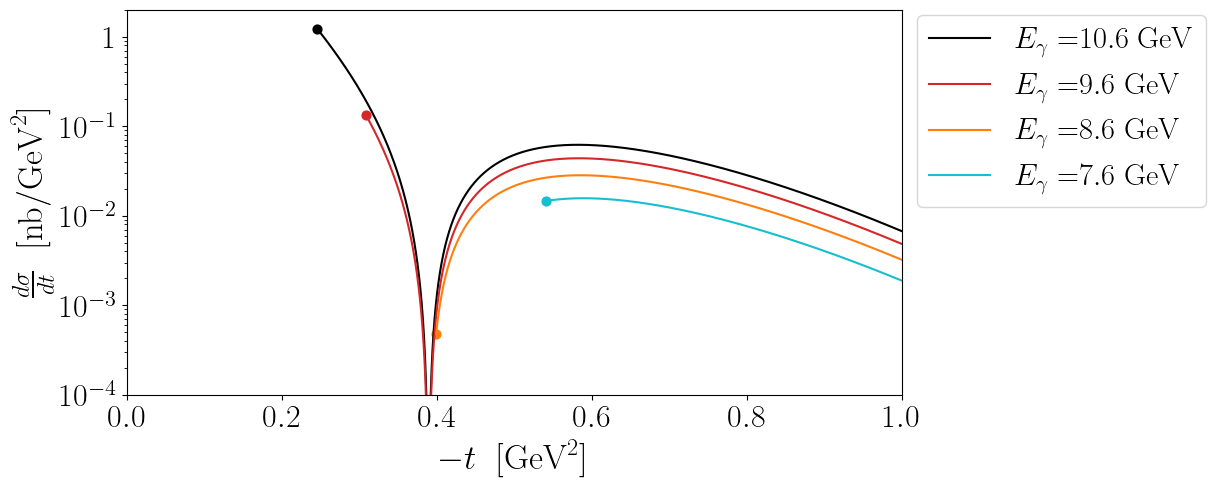

In [247]:
# fig, ax = plt.subplots(1, 1, figsize = (12, 8))
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

Egammad = 10.6
W = W_from_egamma(Egammad, M= mHe4)
s = W**2
x = np.linspace(tmin(W, 0, mHe4, mJpsi), 2, 10001)

ax.plot(x, dsigma_dt(s, -x, mHe4, mJpsi ), label = "$E_{\gamma} =$"+"$ {:.1f}~\mathrm{GeV}$".format(Egammad, GeV = "{GeV}"), color = 'k')#"$^4$He\n"+r"$W = $"+"${:.2f}$".format(W)+"$~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ {:.2f}$".format(tmin(W, 0, mHe4, mJpsi))+"$~\mathrm{GeV}^2$")
ax.scatter(x[0], dsigma_dt(s, -x[0], mHe4, mJpsi ), s = 40, color = 'k')

Egammad = 9.6
W = W_from_egamma(Egammad, M= mHe4)
s = W**2
x = np.linspace(tmin(W, 0, mHe4, mJpsi), 2, 10001)
ax.plot(x, dsigma_dt(s, -x, mHe4, mJpsi ), label = "$E_{\gamma} =$"+"$ {:.1f}~\mathrm{GeV}$".format(Egammad, GeV = "{GeV}"), color = 'tab:red')#"$^4$He\n"+r"$W = $"+"${:.2f}$".format(W)+"$~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ {:.2f}$".format(tmin(W, 0, mHe4, mJpsi))+"$~\mathrm{GeV}^2$")
ax.scatter(x[0], dsigma_dt(s, -x[0], mHe4, mJpsi ), s = 40, color = 'tab:red')

Egammad = 8.6
W = W_from_egamma(Egammad, M= mHe4)
s = W**2
x = np.linspace(tmin(W, 0, mHe4, mJpsi), 2, 10001)
ax.plot(x, dsigma_dt(s, -x, mHe4, mJpsi ), label = "$E_{\gamma} =$"+"$ {:.1f}~\mathrm{GeV}$".format(Egammad, GeV = "{GeV}"), color = 'tab:orange')#"$^4$He\n"+r"$W = $"+"${:.2f}$".format(W)+"$~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ {:.2f}$".format(tmin(W, 0, mHe4, mJpsi))+"$~\mathrm{GeV}^2$")
ax.scatter(x[0], dsigma_dt(s, -x[0], mHe4, mJpsi ), s = 40, color = 'tab:orange')

Egammad = 7.6
W = W_from_egamma(Egammad, M= mHe4)
s = W**2
x = np.linspace(tmin(W, 0, mHe4, mJpsi), 2, 10001)
ax.plot(x, dsigma_dt(s, -x, mHe4, mJpsi ), label = "$E_{\gamma} =$"+"$ {:.1f}~\mathrm{GeV}$".format(Egammad, GeV = "{GeV}"), color = 'tab:cyan')#"$^4$He\n"+r"$W = $"+"${:.2f}$".format(W)+"$~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ {:.2f}$".format(tmin(W, 0, mHe4, mJpsi))+"$~\mathrm{GeV}^2$")
ax.scatter(x[0], dsigma_dt(s, -x[0], mHe4, mJpsi ), s = 40, color = 'tab:cyan')

ax.set_xlim([0, 1])# 3])
ax.set_xlabel(r"$-t~~[\mathrm{GeV}^2]$")
ax.set_ylabel(r"$\frac{d\sigma}{dt}~~[\mathrm{nb/GeV}^2]$")
ax.set_yscale('log')
# ax.set_yticks([10**-6, 10**-3, 1, 10**3])
ax.set_yticks(10**(np.linspace(-6, 0, 6+1)), ["$10^{-6}$","$10^{-5}$","$10^{-4}$","$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$"])
ax.set_ylim([10**-4, 2])

# plt.subplots_adjust(hspace=0)
# plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.9), title = "$W = 10~\mathrm{GeV}$\n $E_{\gamma}=11.6~\mathrm{GeV}$\n $|t_{min}|=0.202~\mathrm{GeV}^2$")
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.9))#, title = "$E_{\gamma} =$"+"$ {:.2f}$".format(Egammad) +"$~\mathrm{GeV}$"+"\n"+r"$W = $"+"${:.2f}$".format(W)+"$~\mathrm{GeV}$"+"\n" +r"$~~|t_{min}| =$"+"$ {:.2f}$".format(tmin(W, 0, mHe4, mJpsi))+"$~\mathrm{GeV}^2$")
# plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.5, 0.5), title = "$E_{\gamma} =$"+"$ {:.2f}$".format(Egammad) +"$~\mathrm{GeV}$")
plt.savefig("Cross-section_he4.pdf", bbox_inches = 'tight')

## Read the entire data set and divide into small chunks

In [14]:
# # read
# df = pd.read_pickle("he4_ia1_001.pkl")
# # sort
# he4 = df.loc[df.pid > 1000, :].reset_index()
# scattered_e = df.loc[df.subentry == 4, :].reset_index()
# jpsi_lepton = df.loc[df.subentry == 8, :].reset_index()
# jpsi_antilepton = df.loc[df.subentry == 7, :].reset_index()
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# he4 = he4.loc[:, he4.columns[1:]]
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# jpsi_lepton = jpsi_lepton.loc[:, jpsi_lepton.columns[1:]]
# jpsi_antilepton = jpsi_antilepton.loc[:, jpsi_antilepton.columns[1:]]
# # assign vzs
# vzs = np.random.uniform(-20-3, 20-3, len(jpsi_lepton))
# he4.loc[:, "vz"] = vzs
# jpsi_lepton.loc[:, "vz"] = vzs
# jpsi_antilepton.loc[:, "vz"] = vzs
# scattered_e.loc[:, "vz"] = vzs
# scattered_e.to_pickle("scattered_e_electron_2M.pkl")
# he4.to_pickle("he4_electron_2M.pkl")
# jpsi_lepton.to_pickle("lepton_electron_2M.pkl")
# jpsi_antilepton.to_pickle("antilepton_electron_2M.pkl")

In [15]:
# # read
# df = pd.read_pickle("he4_ia1_002.pkl")
# # sort
# he4 = df.loc[df.pid > 1000, :].reset_index()
# scattered_e = df.loc[df.subentry == 4, :].reset_index()
# jpsi_lepton = df.loc[df.subentry == 8, :].reset_index()
# jpsi_antilepton = df.loc[df.subentry == 7, :].reset_index()
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# he4 = he4.loc[:, he4.columns[1:]]
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# jpsi_lepton = jpsi_lepton.loc[:, jpsi_lepton.columns[1:]]
# jpsi_antilepton = jpsi_antilepton.loc[:, jpsi_antilepton.columns[1:]]
# # assign vzs
# vzs = np.random.uniform(-20-3, 20-3, len(jpsi_lepton))
# he4.loc[:, "vz"] = vzs
# jpsi_lepton.loc[:, "vz"] = vzs
# jpsi_antilepton.loc[:, "vz"] = vzs
# scattered_e.loc[:, "vz"] = vzs
# scattered_e.to_pickle("scattered_e_muon_2M.pkl")
# he4.to_pickle("he4_muon_2M.pkl")
# jpsi_lepton.to_pickle("lepton_muon_2M.pkl")
# jpsi_antilepton.to_pickle("antilepton_muon_2M.pkl")

In [16]:
# # read
# df = pd.read_pickle("he4_ia1_003.pkl")
# # sort
# he4 = df.loc[df.pid > 1000, :].reset_index()
# scattered_e = df.loc[df.subentry == 4, :].reset_index()
# jpsi_lepton = df.loc[df.subentry == 8, :].reset_index()
# jpsi_antilepton = df.loc[df.subentry == 7, :].reset_index()
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# he4 = he4.loc[:, he4.columns[1:]]
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# jpsi_lepton = jpsi_lepton.loc[:, jpsi_lepton.columns[1:]]
# jpsi_antilepton = jpsi_antilepton.loc[:, jpsi_antilepton.columns[1:]]
# # assign vzs
# vzs = np.random.uniform(-20-3, 20-3, len(jpsi_lepton))
# he4.loc[:, "vz"] = vzs
# jpsi_lepton.loc[:, "vz"] = vzs
# jpsi_antilepton.loc[:, "vz"] = vzs
# scattered_e.loc[:, "vz"] = vzs
# scattered_e.to_pickle("scattered_e_modified_electron_2M.pkl")
# he4.to_pickle("he4_modified_electron_2M.pkl")
# jpsi_lepton.to_pickle("lepton_modified_electron_2M.pkl")
# jpsi_antilepton.to_pickle("antilepton_modified_electron_2M.pkl")

In [17]:
# # read
# df = pd.read_pickle("he4_ia1_004.pkl")
# # sort
# he4 = df.loc[df.pid > 1000, :].reset_index()
# scattered_e = df.loc[df.subentry == 4, :].reset_index()
# jpsi_lepton = df.loc[df.subentry == 8, :].reset_index()
# jpsi_antilepton = df.loc[df.subentry == 7, :].reset_index()
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# he4 = he4.loc[:, he4.columns[1:]]
# scattered_e = scattered_e.loc[:, scattered_e.columns[1:]]
# jpsi_lepton = jpsi_lepton.loc[:, jpsi_lepton.columns[1:]]
# jpsi_antilepton = jpsi_antilepton.loc[:, jpsi_antilepton.columns[1:]]
# # assign vzs
# vzs = np.random.uniform(-20-3, 20-3, len(jpsi_lepton))
# he4.loc[:, "vz"] = vzs
# jpsi_lepton.loc[:, "vz"] = vzs
# jpsi_antilepton.loc[:, "vz"] = vzs
# scattered_e.loc[:, "vz"] = vzs
# scattered_e.to_pickle("scattered_e_modified_muon_2M.pkl")
# he4.to_pickle("he4_modified_muon_2M.pkl")
# jpsi_lepton.to_pickle("lepton_modified_muon_2M.pkl")
# jpsi_antilepton.to_pickle("antilepton_modified_muon_2M.pkl")

## Read the individual particles

In [18]:
# ahdc_start_coord  = 0 # cm
# atof_start_coord  = ahdc_start_coord + 39.2*0.1
# alert_end_coord   = 349.2*0.1

# target_length = 40 #cm
# target_end_adjustment = 10
# target_end_coord = alert_end_coord - target_end_adjustment
# target_start_coord = target_end_coord - target_length

In [19]:
ahdc_entry_coord = 0
ahdc_exit_coord  = 34.92

atof_exit_coord  = 34.92-2
atof_entry_coord = atof_exit_coord - 27.975

nominal_target_start = atof_entry_coord - 3.92

target_length = 28#atof_exit_coord - nominal_target_start
target_start_adjustment = 8
target_start_coord = nominal_target_start - target_start_adjustment
target_end_coord = target_start_coord + target_length


In [20]:
target_start_coord

-6.975

In [21]:
import numpy as np
np.random.uniform(-7, -7+28)

-1.5203151976153286

In [22]:
mode = 'electron'
he4_electron = pd.read_pickle("he4_{}_2M.pkl".format(mode))
he4_electron.loc[:, 'p'] = np.sqrt(he4_electron.px**2 + he4_electron.py**2 + he4_electron.pz**2)
he4_electron.loc[:, 'pt'] = np.sqrt(he4_electron.px**2 + he4_electron.py**2)
he4_electron.loc[:, 'theta'] = np.degrees(np.arctan2(he4_electron.pt, he4_electron.pz))
he4_electron.loc[:, 'phi'] = np.degrees(np.arctan2(he4_electron.py, he4_electron.px))
he4_electron.loc[:, "vx"] = 0#np.random.uniform(-20, 20, len(he4_electron))
he4_electron.loc[:, "vy"] = 0#np.random.uniform(-20, 20, len(he4_electron))
he4_electron.loc[:, "vz"] = np.random.uniform(target_start_coord, target_end_coord, len(he4_electron))

scattered_e_electron = pd.read_pickle("scattered_e_{}_2M.pkl".format(mode))
scattered_e_electron.loc[:, 'p'] = np.sqrt(scattered_e_electron.px**2 + scattered_e_electron.py**2 + scattered_e_electron.pz**2)
scattered_e_electron.loc[:, 'pt'] = np.sqrt(scattered_e_electron.px**2 + scattered_e_electron.py**2)
scattered_e_electron.loc[:, 'theta'] = np.degrees(np.arctan2(scattered_e_electron.pt, scattered_e_electron.pz))
scattered_e_electron.loc[:, 'phi'] = np.degrees(np.arctan2(scattered_e_electron.py, scattered_e_electron.px))
scattered_e_electron.loc[:, "Q2"] = - (scattered_e_electron.e-10.604)**2 + scattered_e_electron.px**2 + scattered_e_electron.py**2 + (scattered_e_electron.pz-10.604)**2

jpsi_lepton_electron = pd.read_pickle("lepton_{}_2M.pkl".format(mode))
jpsi_lepton_electron.loc[:, 'p'] = np.sqrt(jpsi_lepton_electron.px**2 + jpsi_lepton_electron.py**2 + jpsi_lepton_electron.pz**2)
jpsi_lepton_electron.loc[:, 'pt'] = np.sqrt(jpsi_lepton_electron.px**2 + jpsi_lepton_electron.py**2)
jpsi_lepton_electron.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_lepton_electron.pt, jpsi_lepton_electron.pz))
jpsi_lepton_electron.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_lepton_electron.py, jpsi_lepton_electron.px))

jpsi_antilepton_electron = pd.read_pickle("antilepton_{}_2M.pkl".format(mode))
jpsi_antilepton_electron.loc[:, 'p'] = np.sqrt(jpsi_antilepton_electron.px**2 + jpsi_antilepton_electron.py**2 + jpsi_antilepton_electron.pz**2)
jpsi_antilepton_electron.loc[:, 'pt'] = np.sqrt(jpsi_antilepton_electron.px**2 + jpsi_antilepton_electron.py**2)
jpsi_antilepton_electron.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_antilepton_electron.pt, jpsi_antilepton_electron.pz))
jpsi_antilepton_electron.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_antilepton_electron.py, jpsi_antilepton_electron.px))

he4_electron.loc[:, "W2"]      = (jpsi_lepton_electron.e + jpsi_antilepton_electron.e + he4_electron.e)**2 - (jpsi_lepton_electron.px + jpsi_antilepton_electron.px + he4_electron.px)**2 - (jpsi_lepton_electron.py + jpsi_antilepton_electron.py + he4_electron.py)**2 - (jpsi_lepton_electron.pz + jpsi_antilepton_electron.pz + he4_electron.pz)**2
he4_electron.loc[:, "W"]      = np.sqrt(he4_electron.W2)
he4_electron.loc[:, "kgamma"] = (he4_electron.W2-mHe4**2)/2/mHe4
he4_electron.loc[:, "t"]      = 2 * (he4_electron.e-he4_electron.m)*he4_electron.m

total_xsec_electron    = he4_electron.loc[he4_electron.total_xsec>0, "total_xsec"].mean()
accepted_xsec_electron = he4_electron.loc[he4_electron.accepted_xsec>0, "accepted_xsec"].mean()


c = 3e8
B = 5
he4_electron_rhelix = he4_electron.pt*10**9/2/B/c
he4_electron_omega  = 2*B*c**2/he4_electron.e/10**9
he4_electron_betat  = he4_electron.pt/he4_electron.e

#atof_exit_condition
he4_electron_time_atof_exit   = (atof_exit_coord - he4_electron.vz)*0.01/(he4_electron.pz/he4_electron.e*c)
he4_electron_theta_atof_exit  = he4_electron_omega * he4_electron_time_atof_exit
he4_electron_transverse_displacement_atof_exit = he4_electron_rhelix*2*np.sin(he4_electron_theta_atof_exit/2)
he4_electron_atof_exit_condition = he4_electron_transverse_displacement_atof_exit > 0.08

#atof_entry_condition
he4_electron_time_atof_entry   = (atof_entry_coord - he4_electron.vz)*0.01/(he4_electron.pz/he4_electron.e*c)
he4_electron_theta_atof_entry  = he4_electron_omega * he4_electron_time_atof_entry
he4_electron_transverse_displacement_atof_entry = he4_electron_rhelix*2*np.sin(he4_electron_theta_atof_entry/2)
he4_electron_atof_entry_condition = he4_electron_transverse_displacement_atof_entry < 0.08

#ahdc_entry_condition
he4_electron_time_ahdc_entry   = (ahdc_entry_coord - he4_electron.vz)*0.01/(he4_electron.pz/he4_electron.e*c)
he4_electron_theta_ahdc_entry  = he4_electron_omega * he4_electron_time_ahdc_entry
he4_electron_transverse_displacement_ahdc_entry = he4_electron_rhelix*2*np.sin(he4_electron_theta_ahdc_entry/2)
he4_electron_ahdc_entry_condition = he4_electron_transverse_displacement_ahdc_entry < 0.02

he4_electron.loc[:, "accepted"] = he4_electron_atof_exit_condition & he4_electron_atof_entry_condition & he4_electron_ahdc_entry_condition

jpsi_lepton_electron_indices = np.loadtxt('lepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_lepton_electron.loc[:, "accepted"] = jpsi_lepton_electron.index.isin(jpsi_lepton_electron_indices)

jpsi_antilepton_electron_indices = np.loadtxt('antilepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_antilepton_electron.loc[:, "accepted"] = jpsi_antilepton_electron.index.isin(jpsi_antilepton_electron_indices)

scattered_e_electron_indices = np.loadtxt('scattered_e_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
scattered_e_electron.loc[:, "accepted"] = scattered_e_electron.index.isin(scattered_e_electron_indices)
scattered_e_electron_ft_indices = np.loadtxt('scattered_e_{}_2M.ft.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
scattered_e_electron.loc[:, "accepted_ft"] = scattered_e_electron.index.isin(scattered_e_electron_ft_indices)

jpsi_electron_indices = jpsi_lepton_electron_indices[np.isin(jpsi_lepton_electron_indices, jpsi_antilepton_electron_indices)]

jpsi_electron_cond = he4_electron.index.isin(jpsi_electron_indices)
jpsi_electron_fd_cond = ((jpsi_lepton_electron.p>1) | (jpsi_antilepton_electron.p>1)) & jpsi_electron_cond
scattered_e_electron_fd_cond = (scattered_e_electron.p>1) & (scattered_e_electron.index.isin(scattered_e_electron_indices))
scattered_e_electron_ft_cond = (scattered_e_electron.p>0.5) & (scattered_e_electron.theta>2.5 + np.exp(-(scattered_e_electron.p-0.5)/0.25)) & (scattered_e_electron.theta<4.5 + np.exp(-(scattered_e_electron.p-0.5)/0.25))

topology_electron_1 =  (scattered_e_electron_fd_cond|scattered_e_electron_ft_cond) & he4_electron.accepted
topology_electron_2 =  jpsi_electron_fd_cond & he4_electron.accepted & (~topology_electron_1)
topology_electron   = topology_electron_1 | topology_electron_2

he4_electron.loc[:, "topology_1"] = topology_electron_1
he4_electron.loc[:, "topology_2"] = topology_electron_2
he4_electron.loc[:, "topology"]   = topology_electron
he4_electron.loc[:, "decay_channel"] = "electron"

In [23]:
mode = 'modified_electron'
he4_modified_electron = pd.read_pickle("he4_{}_2M.pkl".format(mode))
he4_modified_electron.loc[:, 'p'] = np.sqrt(he4_modified_electron.px**2 + he4_modified_electron.py**2 + he4_modified_electron.pz**2)
he4_modified_electron.loc[:, 'pt'] = np.sqrt(he4_modified_electron.px**2 + he4_modified_electron.py**2)
he4_modified_electron.loc[:, 'theta'] = np.degrees(np.arctan2(he4_modified_electron.pt, he4_modified_electron.pz))
he4_modified_electron.loc[:, 'phi'] = np.degrees(np.arctan2(he4_modified_electron.py, he4_modified_electron.px))
he4_modified_electron.loc[:, "vx"] = 0#np.random.uniform(-20, 20, len(he4_modified_electron))
he4_modified_electron.loc[:, "vy"] = 0#np.random.uniform(-20, 20, len(he4_modified_electron))
he4_modified_electron.loc[:, "vz"] = np.random.uniform(target_start_coord, target_end_coord, len(he4_modified_electron))

scattered_e_modified_electron = pd.read_pickle("scattered_e_{}_2M.pkl".format(mode))
scattered_e_modified_electron.loc[:, 'p'] = np.sqrt(scattered_e_modified_electron.px**2 + scattered_e_modified_electron.py**2 + scattered_e_modified_electron.pz**2)
scattered_e_modified_electron.loc[:, 'pt'] = np.sqrt(scattered_e_modified_electron.px**2 + scattered_e_modified_electron.py**2)
scattered_e_modified_electron.loc[:, 'theta'] = np.degrees(np.arctan2(scattered_e_modified_electron.pt, scattered_e_modified_electron.pz))
scattered_e_modified_electron.loc[:, 'phi'] = np.degrees(np.arctan2(scattered_e_modified_electron.py, scattered_e_modified_electron.px))
scattered_e_modified_electron.loc[:, "Q2"] = - (scattered_e_modified_electron.e-10.604)**2 + scattered_e_modified_electron.px**2 + scattered_e_modified_electron.py**2 + (scattered_e_modified_electron.pz-10.604)**2

jpsi_lepton_modified_electron = pd.read_pickle("lepton_{}_2M.pkl".format(mode))
jpsi_lepton_modified_electron.loc[:, 'p'] = np.sqrt(jpsi_lepton_modified_electron.px**2 + jpsi_lepton_modified_electron.py**2 + jpsi_lepton_modified_electron.pz**2)
jpsi_lepton_modified_electron.loc[:, 'pt'] = np.sqrt(jpsi_lepton_modified_electron.px**2 + jpsi_lepton_modified_electron.py**2)
jpsi_lepton_modified_electron.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_lepton_modified_electron.pt, jpsi_lepton_modified_electron.pz))
jpsi_lepton_modified_electron.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_lepton_modified_electron.py, jpsi_lepton_modified_electron.px))

jpsi_antilepton_modified_electron = pd.read_pickle("antilepton_{}_2M.pkl".format(mode))
jpsi_antilepton_modified_electron.loc[:, 'p'] = np.sqrt(jpsi_antilepton_modified_electron.px**2 + jpsi_antilepton_modified_electron.py**2 + jpsi_antilepton_modified_electron.pz**2)
jpsi_antilepton_modified_electron.loc[:, 'pt'] = np.sqrt(jpsi_antilepton_modified_electron.px**2 + jpsi_antilepton_modified_electron.py**2)
jpsi_antilepton_modified_electron.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_antilepton_modified_electron.pt, jpsi_antilepton_modified_electron.pz))
jpsi_antilepton_modified_electron.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_antilepton_modified_electron.py, jpsi_antilepton_modified_electron.px))

he4_modified_electron.loc[:, "W2"]      = (jpsi_lepton_modified_electron.e + jpsi_antilepton_modified_electron.e + he4_modified_electron.e)**2 - (jpsi_lepton_modified_electron.px + jpsi_antilepton_modified_electron.px + he4_modified_electron.px)**2 - (jpsi_lepton_modified_electron.py + jpsi_antilepton_modified_electron.py + he4_modified_electron.py)**2 - (jpsi_lepton_modified_electron.pz + jpsi_antilepton_modified_electron.pz + he4_modified_electron.pz)**2
he4_modified_electron.loc[:, "W"]      = np.sqrt(he4_modified_electron.W2)
he4_modified_electron.loc[:, "kgamma"] = (he4_modified_electron.W2-mHe4**2)/2/mHe4
he4_modified_electron.loc[:, "t"]      = 2 * (he4_modified_electron.e-he4_modified_electron.m)*he4_modified_electron.m

total_xsec_modified_electron    = he4_modified_electron.loc[he4_modified_electron.total_xsec>0, "total_xsec"].mean()
accepted_xsec_modified_electron = he4_modified_electron.loc[he4_modified_electron.accepted_xsec>0, "accepted_xsec"].mean()


c = 3e8
B = 5
he4_modified_electron_rhelix = he4_modified_electron.pt*10**9/2/B/c
he4_modified_electron_omega  = 2*B*c**2/he4_modified_electron.e/10**9
he4_modified_electron_betat  = he4_modified_electron.pt/he4_modified_electron.e

#atof_exit_condition
he4_modified_electron_time_atof_exit   = (atof_exit_coord - he4_modified_electron.vz)*0.01/(he4_modified_electron.pz/he4_modified_electron.e*c)
he4_modified_electron_theta_atof_exit  = he4_modified_electron_omega * he4_modified_electron_time_atof_exit
he4_modified_electron_transverse_displacement_atof_exit = he4_modified_electron_rhelix*2*np.sin(he4_modified_electron_theta_atof_exit/2)
he4_modified_electron_atof_exit_condition = he4_modified_electron_transverse_displacement_atof_exit > 0.08

#atof_entry_condition
he4_modified_electron_time_atof_entry   = (atof_entry_coord - he4_modified_electron.vz)*0.01/(he4_modified_electron.pz/he4_modified_electron.e*c)
he4_modified_electron_theta_atof_entry  = he4_modified_electron_omega * he4_modified_electron_time_atof_entry
he4_modified_electron_transverse_displacement_atof_entry = he4_modified_electron_rhelix*2*np.sin(he4_modified_electron_theta_atof_entry/2)
he4_modified_electron_atof_entry_condition = he4_modified_electron_transverse_displacement_atof_entry < 0.08

#ahdc_entry_condition
he4_modified_electron_time_ahdc_entry   = (ahdc_entry_coord - he4_modified_electron.vz)*0.01/(he4_modified_electron.pz/he4_modified_electron.e*c)
he4_modified_electron_theta_ahdc_entry  = he4_modified_electron_omega * he4_modified_electron_time_ahdc_entry
he4_modified_electron_transverse_displacement_ahdc_entry = he4_modified_electron_rhelix*2*np.sin(he4_modified_electron_theta_ahdc_entry/2)
he4_modified_electron_ahdc_entry_condition = he4_modified_electron_transverse_displacement_ahdc_entry < 0.02

he4_modified_electron.loc[:, "accepted"] = he4_modified_electron_atof_exit_condition & he4_modified_electron_atof_entry_condition & he4_modified_electron_ahdc_entry_condition

jpsi_lepton_modified_electron_indices = np.loadtxt('lepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_lepton_modified_electron.loc[:, "accepted"] = jpsi_lepton_modified_electron.index.isin(jpsi_lepton_modified_electron_indices)

jpsi_antilepton_modified_electron_indices = np.loadtxt('antilepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_antilepton_modified_electron.loc[:, "accepted"] = jpsi_antilepton_modified_electron.index.isin(jpsi_antilepton_modified_electron_indices)

scattered_e_modified_electron_indices = np.loadtxt('scattered_e_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
scattered_e_modified_electron.loc[:, "accepted"] = scattered_e_modified_electron.index.isin(scattered_e_modified_electron_indices)

jpsi_modified_electron_indices = jpsi_lepton_modified_electron_indices[np.isin(jpsi_lepton_modified_electron_indices, jpsi_antilepton_modified_electron_indices)]

jpsi_modified_electron_cond = he4_modified_electron.index.isin(jpsi_modified_electron_indices)
jpsi_modified_electron_fd_cond = ((jpsi_lepton_modified_electron.p>1) | (jpsi_antilepton_modified_electron.p>1)) & jpsi_modified_electron_cond
scattered_e_modified_electron_fd_cond = (scattered_e_modified_electron.p>1) & (scattered_e_modified_electron.index.isin(scattered_e_modified_electron_indices))
scattered_e_modified_electron_ft_cond = (scattered_e_modified_electron.p>0.5) & (scattered_e_modified_electron.theta>2.5 + np.exp(-(scattered_e_modified_electron.p-0.5)/0.25)) & (scattered_e_modified_electron.theta<4.5 + np.exp(-(scattered_e_modified_electron.p-0.5)/0.25))

topology_modified_electron_1 =  (scattered_e_modified_electron_fd_cond|scattered_e_modified_electron_ft_cond) & he4_modified_electron.accepted
topology_modified_electron_2 =  jpsi_modified_electron_fd_cond & he4_modified_electron.accepted & (~topology_modified_electron_1)
topology_modified_electron   = topology_modified_electron_1 | topology_modified_electron_2

he4_modified_electron.loc[:, "topology_1"] = topology_modified_electron_1
he4_modified_electron.loc[:, "topology_2"] = topology_modified_electron_2
he4_modified_electron.loc[:, "topology"]   = topology_modified_electron
he4_modified_electron.loc[:, "decay_channel"] = "electron"

In [24]:
mode = 'muon'
he4_muon = pd.read_pickle("he4_{}_2M.pkl".format(mode))
he4_muon.loc[:, 'p'] = np.sqrt(he4_muon.px**2 + he4_muon.py**2 + he4_muon.pz**2)
he4_muon.loc[:, 'pt'] = np.sqrt(he4_muon.px**2 + he4_muon.py**2)
he4_muon.loc[:, 'theta'] = np.degrees(np.arctan2(he4_muon.pt, he4_muon.pz))
he4_muon.loc[:, 'phi'] = np.degrees(np.arctan2(he4_muon.py, he4_muon.px))
he4_muon.loc[:, "vx"] = 0#np.random.uniform(-20, 20, len(he4_muon))
he4_muon.loc[:, "vy"] = 0#np.random.uniform(-20, 20, len(he4_muon))
he4_muon.loc[:, "vz"] = np.random.uniform(target_start_coord, target_end_coord, len(he4_muon))

scattered_e_muon = pd.read_pickle("scattered_e_{}_2M.pkl".format(mode))
scattered_e_muon.loc[:, 'p'] = np.sqrt(scattered_e_muon.px**2 + scattered_e_muon.py**2 + scattered_e_muon.pz**2)
scattered_e_muon.loc[:, 'pt'] = np.sqrt(scattered_e_muon.px**2 + scattered_e_muon.py**2)
scattered_e_muon.loc[:, 'theta'] = np.degrees(np.arctan2(scattered_e_muon.pt, scattered_e_muon.pz))
scattered_e_muon.loc[:, 'phi'] = np.degrees(np.arctan2(scattered_e_muon.py, scattered_e_muon.px))
scattered_e_muon.loc[:, "Q2"] = - (scattered_e_muon.e-10.604)**2 + scattered_e_muon.px**2 + scattered_e_muon.py**2 + (scattered_e_muon.pz-10.604)**2

jpsi_lepton_muon = pd.read_pickle("lepton_{}_2M.pkl".format(mode))
jpsi_lepton_muon.loc[:, 'p'] = np.sqrt(jpsi_lepton_muon.px**2 + jpsi_lepton_muon.py**2 + jpsi_lepton_muon.pz**2)
jpsi_lepton_muon.loc[:, 'pt'] = np.sqrt(jpsi_lepton_muon.px**2 + jpsi_lepton_muon.py**2)
jpsi_lepton_muon.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_lepton_muon.pt, jpsi_lepton_muon.pz))
jpsi_lepton_muon.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_lepton_muon.py, jpsi_lepton_muon.px))

jpsi_antilepton_muon = pd.read_pickle("antilepton_{}_2M.pkl".format(mode))
jpsi_antilepton_muon.loc[:, 'p'] = np.sqrt(jpsi_antilepton_muon.px**2 + jpsi_antilepton_muon.py**2 + jpsi_antilepton_muon.pz**2)
jpsi_antilepton_muon.loc[:, 'pt'] = np.sqrt(jpsi_antilepton_muon.px**2 + jpsi_antilepton_muon.py**2)
jpsi_antilepton_muon.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_antilepton_muon.pt, jpsi_antilepton_muon.pz))
jpsi_antilepton_muon.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_antilepton_muon.py, jpsi_antilepton_muon.px))

he4_muon.loc[:, "W2"]      = (jpsi_lepton_muon.e + jpsi_antilepton_muon.e + he4_muon.e)**2 - (jpsi_lepton_muon.px + jpsi_antilepton_muon.px + he4_muon.px)**2 - (jpsi_lepton_muon.py + jpsi_antilepton_muon.py + he4_muon.py)**2 - (jpsi_lepton_muon.pz + jpsi_antilepton_muon.pz + he4_muon.pz)**2
he4_muon.loc[:, "W"]      = np.sqrt(he4_muon.W2)
he4_muon.loc[:, "kgamma"] = (he4_muon.W2-mHe4**2)/2/mHe4
he4_muon.loc[:, "t"]      = 2 * (he4_muon.e-he4_muon.m)*he4_muon.m

total_xsec_muon    = he4_muon.loc[he4_muon.total_xsec>0, "total_xsec"].mean()
accepted_xsec_muon = he4_muon.loc[he4_muon.accepted_xsec>0, "accepted_xsec"].mean()


c = 3e8
B = 5
he4_muon_rhelix = he4_muon.pt*10**9/2/B/c
he4_muon_omega  = 2*B*c**2/he4_muon.e/10**9
he4_muon_betat  = he4_muon.pt/he4_muon.e

#atof_exit_condition
he4_muon_time_atof_exit   = (atof_exit_coord - he4_muon.vz)*0.01/(he4_muon.pz/he4_muon.e*c)
he4_muon_theta_atof_exit  = he4_muon_omega * he4_muon_time_atof_exit
he4_muon_transverse_displacement_atof_exit = he4_muon_rhelix*2*np.sin(he4_muon_theta_atof_exit/2)
he4_muon_atof_exit_condition = he4_muon_transverse_displacement_atof_exit > 0.08

#atof_entry_condition
he4_muon_time_atof_entry   = (atof_entry_coord - he4_muon.vz)*0.01/(he4_muon.pz/he4_muon.e*c)
he4_muon_theta_atof_entry  = he4_muon_omega * he4_muon_time_atof_entry
he4_muon_transverse_displacement_atof_entry = he4_muon_rhelix*2*np.sin(he4_muon_theta_atof_entry/2)
he4_muon_atof_entry_condition = he4_muon_transverse_displacement_atof_entry < 0.08

#ahdc_entry_condition
he4_muon_time_ahdc_entry   = (ahdc_entry_coord - he4_muon.vz)*0.01/(he4_muon.pz/he4_muon.e*c)
he4_muon_theta_ahdc_entry  = he4_muon_omega * he4_muon_time_ahdc_entry
he4_muon_transverse_displacement_ahdc_entry = he4_muon_rhelix*2*np.sin(he4_muon_theta_ahdc_entry/2)
he4_muon_ahdc_entry_condition = he4_muon_transverse_displacement_ahdc_entry < 0.02

he4_muon.loc[:, "accepted"] = he4_muon_atof_exit_condition & he4_muon_atof_entry_condition & he4_muon_ahdc_entry_condition

jpsi_lepton_muon_indices = np.loadtxt('lepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_lepton_muon.loc[:, "accepted"] = jpsi_lepton_muon.index.isin(jpsi_lepton_muon_indices)

jpsi_antilepton_muon_indices = np.loadtxt('antilepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_antilepton_muon.loc[:, "accepted"] = jpsi_antilepton_muon.index.isin(jpsi_antilepton_muon_indices)

scattered_e_muon_indices = np.loadtxt('scattered_e_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
scattered_e_muon.loc[:, "accepted"] = scattered_e_muon.index.isin(scattered_e_muon_indices)

jpsi_muon_indices = jpsi_lepton_muon_indices[np.isin(jpsi_lepton_muon_indices, jpsi_antilepton_muon_indices)]

jpsi_muon_cond = he4_muon.index.isin(jpsi_muon_indices)
jpsi_muon_fd_cond = ((jpsi_lepton_muon.p>1) | (jpsi_antilepton_muon.p>1)) & jpsi_muon_cond
scattered_e_muon_fd_cond = (scattered_e_muon.p>1) & (scattered_e_muon.index.isin(scattered_e_muon_indices))
scattered_e_muon_ft_cond = (scattered_e_muon.p>0.5) & (scattered_e_muon.theta>2.5 + np.exp(-(scattered_e_muon.p-0.5)/0.25)) & (scattered_e_muon.theta<4.5 + np.exp(-(scattered_e_muon.p-0.5)/0.25))

topology_muon_1 =  (scattered_e_muon_fd_cond|scattered_e_muon_ft_cond) & he4_muon.accepted
topology_muon_2 =  jpsi_muon_fd_cond & he4_muon.accepted & (~topology_muon_1)
topology_muon   = topology_muon_1 | topology_muon_2

he4_muon.loc[:, "topology_1"] = topology_muon_1
he4_muon.loc[:, "topology_2"] = topology_muon_2
he4_muon.loc[:, "topology"]   = topology_muon
he4_muon.loc[:, "decay_channel"] = "muon"

In [25]:
mode = 'modified_muon'
he4_modified_muon = pd.read_pickle("he4_{}_2M.pkl".format(mode))
he4_modified_muon.loc[:, 'p'] = np.sqrt(he4_modified_muon.px**2 + he4_modified_muon.py**2 + he4_modified_muon.pz**2)
he4_modified_muon.loc[:, 'pt'] = np.sqrt(he4_modified_muon.px**2 + he4_modified_muon.py**2)
he4_modified_muon.loc[:, 'theta'] = np.degrees(np.arctan2(he4_modified_muon.pt, he4_modified_muon.pz))
he4_modified_muon.loc[:, 'phi'] = np.degrees(np.arctan2(he4_modified_muon.py, he4_modified_muon.px))
he4_modified_muon.loc[:, "vx"] = 0#np.random.uniform(-20, 20, len(he4_modified_muon))
he4_modified_muon.loc[:, "vy"] = 0#np.random.uniform(-20, 20, len(he4_modified_muon))
he4_modified_muon.loc[:, "vz"] = np.random.uniform(target_start_coord, target_end_coord, len(he4_modified_muon))

scattered_e_modified_muon = pd.read_pickle("scattered_e_{}_2M.pkl".format(mode))
scattered_e_modified_muon.loc[:, 'p'] = np.sqrt(scattered_e_modified_muon.px**2 + scattered_e_modified_muon.py**2 + scattered_e_modified_muon.pz**2)
scattered_e_modified_muon.loc[:, 'pt'] = np.sqrt(scattered_e_modified_muon.px**2 + scattered_e_modified_muon.py**2)
scattered_e_modified_muon.loc[:, 'theta'] = np.degrees(np.arctan2(scattered_e_modified_muon.pt, scattered_e_modified_muon.pz))
scattered_e_modified_muon.loc[:, 'phi'] = np.degrees(np.arctan2(scattered_e_modified_muon.py, scattered_e_modified_muon.px))
scattered_e_modified_muon.loc[:, "Q2"] = - (scattered_e_modified_muon.e-10.604)**2 + scattered_e_modified_muon.px**2 + scattered_e_modified_muon.py**2 + (scattered_e_modified_muon.pz-10.604)**2

jpsi_lepton_modified_muon = pd.read_pickle("lepton_{}_2M.pkl".format(mode))
jpsi_lepton_modified_muon.loc[:, 'p'] = np.sqrt(jpsi_lepton_modified_muon.px**2 + jpsi_lepton_modified_muon.py**2 + jpsi_lepton_modified_muon.pz**2)
jpsi_lepton_modified_muon.loc[:, 'pt'] = np.sqrt(jpsi_lepton_modified_muon.px**2 + jpsi_lepton_modified_muon.py**2)
jpsi_lepton_modified_muon.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_lepton_modified_muon.pt, jpsi_lepton_modified_muon.pz))
jpsi_lepton_modified_muon.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_lepton_modified_muon.py, jpsi_lepton_modified_muon.px))

jpsi_antilepton_modified_muon = pd.read_pickle("antilepton_{}_2M.pkl".format(mode))
jpsi_antilepton_modified_muon.loc[:, 'p'] = np.sqrt(jpsi_antilepton_modified_muon.px**2 + jpsi_antilepton_modified_muon.py**2 + jpsi_antilepton_modified_muon.pz**2)
jpsi_antilepton_modified_muon.loc[:, 'pt'] = np.sqrt(jpsi_antilepton_modified_muon.px**2 + jpsi_antilepton_modified_muon.py**2)
jpsi_antilepton_modified_muon.loc[:, 'theta'] = np.degrees(np.arctan2(jpsi_antilepton_modified_muon.pt, jpsi_antilepton_modified_muon.pz))
jpsi_antilepton_modified_muon.loc[:, 'phi'] = np.degrees(np.arctan2(jpsi_antilepton_modified_muon.py, jpsi_antilepton_modified_muon.px))

he4_modified_muon.loc[:, "W2"]      = (jpsi_lepton_modified_muon.e + jpsi_antilepton_modified_muon.e + he4_modified_muon.e)**2 - (jpsi_lepton_modified_muon.px + jpsi_antilepton_modified_muon.px + he4_modified_muon.px)**2 - (jpsi_lepton_modified_muon.py + jpsi_antilepton_modified_muon.py + he4_modified_muon.py)**2 - (jpsi_lepton_modified_muon.pz + jpsi_antilepton_modified_muon.pz + he4_modified_muon.pz)**2
he4_modified_muon.loc[:, "W"]      = np.sqrt(he4_modified_muon.W2)
he4_modified_muon.loc[:, "kgamma"] = (he4_modified_muon.W2-mHe4**2)/2/mHe4
he4_modified_muon.loc[:, "t"]      = 2 * (he4_modified_muon.e-he4_modified_muon.m)*he4_modified_muon.m

total_xsec_modified_muon    = he4_modified_muon.loc[he4_modified_muon.total_xsec>0, "total_xsec"].mean()
accepted_xsec_modified_muon = he4_modified_muon.loc[he4_modified_muon.accepted_xsec>0, "accepted_xsec"].mean()


c = 3e8
B = 5
he4_modified_muon_rhelix = he4_modified_muon.pt*10**9/2/B/c
he4_modified_muon_omega  = 2*B*c**2/he4_modified_muon.e/10**9
he4_modified_muon_betat  = he4_modified_muon.pt/he4_modified_muon.e

#atof_exit_condition
he4_modified_muon_time_atof_exit   = (atof_exit_coord - he4_modified_muon.vz)*0.01/(he4_modified_muon.pz/he4_modified_muon.e*c)
he4_modified_muon_theta_atof_exit  = he4_modified_muon_omega * he4_modified_muon_time_atof_exit
he4_modified_muon_transverse_displacement_atof_exit = he4_modified_muon_rhelix*2*np.sin(he4_modified_muon_theta_atof_exit/2)
he4_modified_muon_atof_exit_condition = he4_modified_muon_transverse_displacement_atof_exit > 0.08

#atof_entry_condition
he4_modified_muon_time_atof_entry   = (atof_entry_coord - he4_modified_muon.vz)*0.01/(he4_modified_muon.pz/he4_modified_muon.e*c)
he4_modified_muon_theta_atof_entry  = he4_modified_muon_omega * he4_modified_muon_time_atof_entry
he4_modified_muon_transverse_displacement_atof_entry = he4_modified_muon_rhelix*2*np.sin(he4_modified_muon_theta_atof_entry/2)
he4_modified_muon_atof_entry_condition = he4_modified_muon_transverse_displacement_atof_entry < 0.08

#ahdc_entry_condition
he4_modified_muon_time_ahdc_entry   = (ahdc_entry_coord - he4_modified_muon.vz)*0.01/(he4_modified_muon.pz/he4_modified_muon.e*c)
he4_modified_muon_theta_ahdc_entry  = he4_modified_muon_omega * he4_modified_muon_time_ahdc_entry
he4_modified_muon_transverse_displacement_ahdc_entry = he4_modified_muon_rhelix*2*np.sin(he4_modified_muon_theta_ahdc_entry/2)
he4_modified_muon_ahdc_entry_condition = he4_modified_muon_transverse_displacement_ahdc_entry < 0.02

he4_modified_muon.loc[:, "accepted"] = he4_modified_muon_atof_exit_condition & he4_modified_muon_atof_entry_condition & he4_modified_muon_ahdc_entry_condition

jpsi_lepton_modified_muon_indices = np.loadtxt('lepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_lepton_modified_muon.loc[:, "accepted"] = jpsi_lepton_modified_muon.index.isin(jpsi_lepton_modified_muon_indices)

jpsi_antilepton_modified_muon_indices = np.loadtxt('antilepton_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
jpsi_antilepton_modified_muon.loc[:, "accepted"] = jpsi_antilepton_modified_muon.index.isin(jpsi_antilepton_modified_muon_indices)

scattered_e_modified_muon_indices = np.loadtxt('scattered_e_{}_2M.dat.fastmc.index'.format(mode), delimiter = ',', dtype = int)
scattered_e_modified_muon.loc[:, "accepted"] = scattered_e_modified_muon.index.isin(scattered_e_modified_muon_indices)

jpsi_modified_muon_indices = jpsi_lepton_modified_muon_indices[np.isin(jpsi_lepton_modified_muon_indices, jpsi_antilepton_modified_muon_indices)]

jpsi_modified_muon_cond = he4_modified_muon.index.isin(jpsi_modified_muon_indices)
jpsi_modified_muon_fd_cond = ((jpsi_lepton_modified_muon.p>1) | (jpsi_antilepton_modified_muon.p>1)) & jpsi_modified_muon_cond
scattered_e_modified_muon_fd_cond = (scattered_e_modified_muon.p>1) & (scattered_e_modified_muon.index.isin(scattered_e_modified_muon_indices))
scattered_e_modified_muon_ft_cond = (scattered_e_modified_muon.p>0.5) & (scattered_e_modified_muon.theta>2.5 + np.exp(-(scattered_e_modified_muon.p-0.5)/0.25)) & (scattered_e_modified_muon.theta<4.5 + np.exp(-(scattered_e_modified_muon.p-0.5)/0.25))

topology_modified_muon_1 =  (scattered_e_modified_muon_fd_cond|scattered_e_modified_muon_ft_cond) & he4_modified_muon.accepted
topology_modified_muon_2 =  jpsi_modified_muon_fd_cond & he4_modified_muon.accepted & (~topology_modified_muon_1)
topology_modified_muon   = topology_modified_muon_1 | topology_modified_muon_2

he4_modified_muon.loc[:, "topology_1"] = topology_modified_muon_1
he4_modified_muon.loc[:, "topology_2"] = topology_modified_muon_2
he4_modified_muon.loc[:, "topology"]   = topology_modified_muon
he4_modified_muon.loc[:, "decay_channel"] = "muon"

In [26]:
scattered_e = pd.concat([scattered_e_electron, scattered_e_muon]).reset_index()
jpsi_lepton = pd.concat([jpsi_lepton_electron, jpsi_lepton_muon]).reset_index()
jpsi_antilepton = pd.concat([jpsi_antilepton_electron, jpsi_antilepton_muon]).reset_index()
he4         = pd.concat([he4_electron, he4_muon]).reset_index()

scattered_e = scattered_e.loc[:, scattered_e.columns[4:]]
jpsi_lepton = jpsi_lepton.loc[:, jpsi_lepton.columns[4:]]
jpsi_antilepton = jpsi_antilepton.loc[:, jpsi_antilepton.columns[4:]]
he4 = he4.loc[:, he4.columns[4:]]

scattered_e.loc[:, "p_smeared"]     = scattered_e.p* np.random.normal(1, np.sqrt(0.01**2+0.02**2/np.sqrt(scattered_e.e)**2), len(scattered_e))
scattered_e.loc[:, "theta_smeared"] = scattered_e.theta* np.random.normal(1, np.sqrt(0.015), len(scattered_e))
scattered_e.loc[:, "phi_smeared"  ] = scattered_e.phi  + np.random.normal(0, 2, len(scattered_e))
scattered_e.loc[:, "px_smeared"] = scattered_e.p_smeared * np.sin(np.radians(scattered_e.theta_smeared)) * np.cos(np.radians(scattered_e.phi_smeared))
scattered_e.loc[:, "py_smeared"] = scattered_e.p_smeared * np.sin(np.radians(scattered_e.theta_smeared)) * np.sin(np.radians(scattered_e.phi_smeared))
scattered_e.loc[:, "pz_smeared"] = scattered_e.p_smeared * np.cos(np.radians(scattered_e.theta_smeared))
scattered_e.loc[:, "e_smeared"]  = np.sqrt(scattered_e.p_smeared**2+scattered_e.m**2)

jpsi_lepton.loc[:, "p_smeared"]     = jpsi_lepton.p* np.random.normal(1, 0.01, len(jpsi_lepton))
jpsi_lepton.loc[:, "theta_smeared"] = jpsi_lepton.theta + np.random.normal(0, np.degrees(0.001), len(jpsi_lepton))
jpsi_lepton.loc[:, "phi_smeared"  ] = jpsi_lepton.phi   + np.random.normal(0, np.degrees(0.001/np.sin(np.radians(jpsi_lepton.theta))), len(jpsi_lepton))
jpsi_lepton.loc[:, "px_smeared"] = jpsi_lepton.p_smeared * np.sin(np.radians(jpsi_lepton.theta_smeared)) * np.cos(np.radians(jpsi_lepton.phi_smeared))
jpsi_lepton.loc[:, "py_smeared"] = jpsi_lepton.p_smeared * np.sin(np.radians(jpsi_lepton.theta_smeared)) * np.sin(np.radians(jpsi_lepton.phi_smeared))
jpsi_lepton.loc[:, "pz_smeared"] = jpsi_lepton.p_smeared * np.cos(np.radians(jpsi_lepton.theta_smeared))
jpsi_lepton.loc[:, "e_smeared"]  = np.sqrt(jpsi_lepton.p_smeared**2+jpsi_lepton.m**2)

jpsi_antilepton.loc[:, "p_smeared"]     = jpsi_antilepton.p* np.random.normal(1, 0.01, len(jpsi_antilepton))
jpsi_antilepton.loc[:, "theta_smeared"] = jpsi_antilepton.theta + np.random.normal(0, np.degrees(0.001), len(jpsi_antilepton))
jpsi_antilepton.loc[:, "phi_smeared"  ] = jpsi_antilepton.phi   + np.random.normal(0, np.degrees(0.001/np.sin(np.radians(jpsi_antilepton.theta))), len(jpsi_antilepton))
jpsi_antilepton.loc[:, "px_smeared"] = jpsi_antilepton.p_smeared * np.sin(np.radians(jpsi_antilepton.theta_smeared)) * np.cos(np.radians(jpsi_antilepton.phi_smeared))
jpsi_antilepton.loc[:, "py_smeared"] = jpsi_antilepton.p_smeared * np.sin(np.radians(jpsi_antilepton.theta_smeared)) * np.sin(np.radians(jpsi_antilepton.phi_smeared))
jpsi_antilepton.loc[:, "pz_smeared"] = jpsi_antilepton.p_smeared * np.cos(np.radians(jpsi_antilepton.theta_smeared))
jpsi_antilepton.loc[:, "e_smeared"]  = np.sqrt(jpsi_antilepton.p_smeared**2+jpsi_antilepton.m**2)

he4.loc[:, "p_smeared"]     = he4.p* np.random.normal(1, 0.05, len(he4))
he4.loc[:, "theta_smeared"] = he4.theta + np.random.normal(0, np.degrees(0.05), len(he4))
he4.loc[:, "phi_smeared"  ] = he4.phi   + np.random.normal(0, np.degrees(0.1), len(he4))
he4.loc[:, "px_smeared"] = he4.p_smeared * np.sin(np.radians(he4.theta_smeared)) * np.cos(np.radians(he4.phi_smeared))
he4.loc[:, "py_smeared"] = he4.p_smeared * np.sin(np.radians(he4.theta_smeared)) * np.sin(np.radians(he4.phi_smeared))
he4.loc[:, "pz_smeared"] = he4.p_smeared * np.cos(np.radians(he4.theta_smeared))
he4.loc[:, "e_smeared"]  = np.sqrt(he4.p_smeared**2+he4.m**2)
he4.loc[:, "t_smeared"] = (he4.e_smeared - he4.m)* 2 * he4.m

he4.loc[:, "Q2_smeared_1"]      = -(scattered_e.e_smeared - 10.604)**2 + scattered_e.px_smeared**2  + scattered_e.py_smeared**2 + (scattered_e.pz_smeared - 10.604)**2
he4.loc[:, "nu_smeared_1"]      = -(scattered_e.e_smeared - 10.604)
he4.loc[:, "kgamma_smeared_1"]  = he4.nu_smeared_1 - he4.Q2_smeared_1/2/he4.m
he4.loc[:, "W2_smeared_1"]      = he4.m**2 - he4.Q2_smeared_1 + 2 * he4.m * he4.nu_smeared_1

he4.loc[:, "W2_smeared_2"]      = (jpsi_lepton.e_smeared + jpsi_antilepton.e_smeared + he4.e_smeared)**2 - (jpsi_lepton.px_smeared + jpsi_antilepton.px_smeared + he4.px_smeared)**2 - (jpsi_lepton.py_smeared + jpsi_antilepton.py_smeared + he4.py_smeared)**2 - (jpsi_lepton.pz_smeared + jpsi_antilepton.pz_smeared + he4.pz_smeared)**2
he4.loc[:, "nu_smeared_2"]      = he4.e_smeared + jpsi_lepton.e_smeared + jpsi_antilepton.e_smeared

he4.loc[:, "kgamma_smeared_2"]  = (he4.W2_smeared_1 - he4.m**2)/ 2/ he4.m

he4.loc[:, "kgamma_smeared"] = he4.loc[:, "kgamma_smeared_1"]
he4.loc[he4.topology_2, "kgamma_smeared"] = he4.loc[he4.topology_2, "kgamma_smeared_2"]

he4.loc[:, "Mjpsi_smeared" ] = np.sqrt((he4.e_smeared+scattered_e.e_smeared-10.604-mHe4)**2 - (he4.px_smeared + scattered_e.px_smeared)**2 - (he4.py_smeared + scattered_e.py_smeared)**2 -(he4.pz_smeared + scattered_e.pz_smeared-10.604)**2)
jpsi_lepton.loc[:, "Mjpsi_smeared" ] = np.sqrt((jpsi_lepton.e_smeared+jpsi_antilepton.e_smeared)**2 - (jpsi_lepton.px_smeared + jpsi_antilepton.px_smeared)**2 - (jpsi_lepton.py_smeared + jpsi_antilepton.py_smeared)**2 - (jpsi_lepton.pz_smeared + jpsi_antilepton.pz_smeared)**2)

he4.loc[:, "xi_true" ] = (-he4.t - mJpsi**2)/(2*mHe4**2+mJpsi**2 - 2*scattered_e.W**2 + he4.t);
he4.loc[:, "xi_smeared_1" ] = (-he4.t_smeared - mJpsi**2)/(2*mHe4**2+mJpsi**2 - 2*he4.W2_smeared_1 + he4.t_smeared);
he4.loc[:, "xi_smeared_2" ] = (-he4.t_smeared - mJpsi**2)/(2*mHe4**2+mJpsi**2 - 2*he4.W2_smeared_2 + he4.t_smeared);

In [27]:
scattered_e_modified = pd.concat([scattered_e_modified_electron, scattered_e_modified_muon]).reset_index()
jpsi_lepton_modified = pd.concat([jpsi_lepton_modified_electron, jpsi_lepton_modified_muon]).reset_index()
jpsi_antilepton_modified = pd.concat([jpsi_antilepton_modified_electron, jpsi_antilepton_modified_muon]).reset_index()
he4_modified         = pd.concat([he4_modified_electron, he4_modified_muon]).reset_index()

scattered_e_modified = scattered_e_modified.loc[:, scattered_e_modified.columns[4:]]
jpsi_lepton_modified = jpsi_lepton_modified.loc[:, jpsi_lepton_modified.columns[4:]]
jpsi_antilepton_modified = jpsi_antilepton_modified.loc[:, jpsi_antilepton_modified.columns[4:]]
he4_modified = he4_modified.loc[:, he4_modified.columns[4:]]

scattered_e_modified.loc[:, "p_smeared"]     = scattered_e_modified.p* np.random.normal(1, np.sqrt(0.01**2+0.02**2/np.sqrt(scattered_e_modified.e)**2), len(scattered_e_modified))
scattered_e_modified.loc[:, "theta_smeared"] = scattered_e_modified.theta* np.random.normal(1, np.sqrt(0.015), len(scattered_e_modified))
scattered_e_modified.loc[:, "phi_smeared"  ] = scattered_e_modified.phi  + np.random.normal(0, 2, len(scattered_e_modified))
scattered_e_modified.loc[:, "px_smeared"] = scattered_e_modified.p_smeared * np.sin(np.radians(scattered_e_modified.theta_smeared)) * np.cos(np.radians(scattered_e_modified.phi_smeared))
scattered_e_modified.loc[:, "py_smeared"] = scattered_e_modified.p_smeared * np.sin(np.radians(scattered_e_modified.theta_smeared)) * np.sin(np.radians(scattered_e_modified.phi_smeared))
scattered_e_modified.loc[:, "pz_smeared"] = scattered_e_modified.p_smeared * np.cos(np.radians(scattered_e_modified.theta_smeared))
scattered_e_modified.loc[:, "e_smeared"]  = np.sqrt(scattered_e_modified.p_smeared**2+scattered_e_modified.m**2)

jpsi_lepton_modified.loc[:, "p_smeared"]     = jpsi_lepton_modified.p* np.random.normal(1, 0.01, len(jpsi_lepton_modified))
jpsi_lepton_modified.loc[:, "theta_smeared"] = jpsi_lepton_modified.theta + np.random.normal(0, np.degrees(0.001), len(jpsi_lepton_modified))
jpsi_lepton_modified.loc[:, "phi_smeared"  ] = jpsi_lepton_modified.phi   + np.random.normal(0, np.degrees(0.001/np.sin(np.radians(jpsi_lepton_modified.theta))), len(jpsi_lepton_modified))
jpsi_lepton_modified.loc[:, "px_smeared"] = jpsi_lepton_modified.p_smeared * np.sin(np.radians(jpsi_lepton_modified.theta_smeared)) * np.cos(np.radians(jpsi_lepton_modified.phi_smeared))
jpsi_lepton_modified.loc[:, "py_smeared"] = jpsi_lepton_modified.p_smeared * np.sin(np.radians(jpsi_lepton_modified.theta_smeared)) * np.sin(np.radians(jpsi_lepton_modified.phi_smeared))
jpsi_lepton_modified.loc[:, "pz_smeared"] = jpsi_lepton_modified.p_smeared * np.cos(np.radians(jpsi_lepton_modified.theta_smeared))
jpsi_lepton_modified.loc[:, "e_smeared"]  = np.sqrt(jpsi_lepton_modified.p_smeared**2+jpsi_lepton_modified.m**2)

jpsi_antilepton_modified.loc[:, "p_smeared"]     = jpsi_antilepton_modified.p* np.random.normal(1, 0.01, len(jpsi_antilepton_modified))
jpsi_antilepton_modified.loc[:, "theta_smeared"] = jpsi_antilepton_modified.theta + np.random.normal(0, np.degrees(0.001), len(jpsi_antilepton_modified))
jpsi_antilepton_modified.loc[:, "phi_smeared"  ] = jpsi_antilepton_modified.phi   + np.random.normal(0, np.degrees(0.001/np.sin(np.radians(jpsi_antilepton_modified.theta))), len(jpsi_antilepton_modified))
jpsi_antilepton_modified.loc[:, "px_smeared"] = jpsi_antilepton_modified.p_smeared * np.sin(np.radians(jpsi_antilepton_modified.theta_smeared)) * np.cos(np.radians(jpsi_antilepton_modified.phi_smeared))
jpsi_antilepton_modified.loc[:, "py_smeared"] = jpsi_antilepton_modified.p_smeared * np.sin(np.radians(jpsi_antilepton_modified.theta_smeared)) * np.sin(np.radians(jpsi_antilepton_modified.phi_smeared))
jpsi_antilepton_modified.loc[:, "pz_smeared"] = jpsi_antilepton_modified.p_smeared * np.cos(np.radians(jpsi_antilepton_modified.theta_smeared))
jpsi_antilepton_modified.loc[:, "e_smeared"]  = np.sqrt(jpsi_antilepton_modified.p_smeared**2+jpsi_antilepton_modified.m**2)

he4_modified.loc[:, "p_smeared"]     = he4_modified.p* np.random.normal(1, 0.05, len(he4_modified))
he4_modified.loc[:, "theta_smeared"] = he4_modified.theta + np.random.normal(0, np.degrees(0.05), len(he4_modified))
he4_modified.loc[:, "phi_smeared"  ] = he4_modified.phi   + np.random.normal(0, np.degrees(0.1), len(he4_modified))
he4_modified.loc[:, "px_smeared"] = he4_modified.p_smeared * np.sin(np.radians(he4_modified.theta_smeared)) * np.cos(np.radians(he4_modified.phi_smeared))
he4_modified.loc[:, "py_smeared"] = he4_modified.p_smeared * np.sin(np.radians(he4_modified.theta_smeared)) * np.sin(np.radians(he4_modified.phi_smeared))
he4_modified.loc[:, "pz_smeared"] = he4_modified.p_smeared * np.cos(np.radians(he4_modified.theta_smeared))
he4_modified.loc[:, "e_smeared"]  = np.sqrt(he4_modified.p_smeared**2+he4_modified.m**2)
he4_modified.loc[:, "t_smeared"] = (he4_modified.e_smeared - he4_modified.m)* 2 * he4_modified.m

he4_modified.loc[:, "Q2_smeared_1"]      = -(scattered_e_modified.e_smeared - 10.604)**2 + scattered_e_modified.px_smeared**2  + scattered_e_modified.py_smeared**2 + (scattered_e_modified.pz_smeared - 10.604)**2
he4_modified.loc[:, "nu_smeared_1"]      = -(scattered_e_modified.e_smeared - 10.604)
he4_modified.loc[:, "kgamma_smeared_1"]  = he4_modified.nu_smeared_1 - he4_modified.Q2_smeared_1/2/he4_modified.m
he4_modified.loc[:, "W2_smeared_1"]      = he4_modified.m**2 - he4_modified.Q2_smeared_1 + 2 * he4_modified.m * he4_modified.nu_smeared_1

he4_modified.loc[:, "W2_smeared_2"]      = (jpsi_lepton_modified.e_smeared + jpsi_antilepton_modified.e_smeared + he4_modified.e_smeared)**2 - (jpsi_lepton_modified.px_smeared + jpsi_antilepton_modified.px_smeared + he4_modified.px_smeared)**2 - (jpsi_lepton_modified.py_smeared + jpsi_antilepton_modified.py_smeared + he4_modified.py_smeared)**2 - (jpsi_lepton_modified.pz_smeared + jpsi_antilepton_modified.pz_smeared + he4_modified.pz_smeared)**2
he4_modified.loc[:, "nu_smeared_2"]      = he4_modified.e_smeared + jpsi_lepton_modified.e_smeared + jpsi_antilepton_modified.e_smeared

he4_modified.loc[:, "kgamma_smeared_2"]  = (he4_modified.W2_smeared_1 - he4_modified.m**2)/ 2/ he4_modified.m

he4_modified.loc[:, "kgamma_smeared"] = he4_modified.loc[:, "kgamma_smeared_1"]
he4_modified.loc[he4_modified.topology_2, "kgamma_smeared"] = he4_modified.loc[he4_modified.topology_2, "kgamma_smeared_2"]

he4_modified.loc[:, "Mjpsi_smeared" ] = np.sqrt((he4_modified.e_smeared+scattered_e_modified.e_smeared-10.604-mHe4)**2 - (he4_modified.px_smeared + scattered_e_modified.px_smeared)**2 - (he4_modified.py_smeared + scattered_e_modified.py_smeared)**2 -(he4_modified.pz_smeared + scattered_e_modified.pz_smeared-10.604)**2)
jpsi_lepton_modified.loc[:, "Mjpsi_smeared" ] = np.sqrt((jpsi_lepton_modified.e_smeared+jpsi_antilepton_modified.e_smeared)**2 - (jpsi_lepton_modified.px_smeared + jpsi_antilepton_modified.px_smeared)**2 - (jpsi_lepton_modified.py_smeared + jpsi_antilepton_modified.py_smeared)**2 - (jpsi_lepton_modified.pz_smeared + jpsi_antilepton_modified.pz_smeared)**2)

he4_modified.loc[:, "xi_true" ] = (-he4_modified.t - mJpsi**2)/(2*mHe4**2+mJpsi**2 - 2*scattered_e_modified.W**2 + he4_modified.t);
he4_modified.loc[:, "xi_smeared_1" ] = (-he4_modified.t_smeared - mJpsi**2)/(2*mHe4**2+mJpsi**2 - 2*he4_modified.W2_smeared_1 + he4_modified.t_smeared);
he4_modified.loc[:, "xi_smeared_2" ] = (-he4_modified.t_smeared - mJpsi**2)/(2*mHe4**2+mJpsi**2 - 2*he4_modified.W2_smeared_2 + he4_modified.t_smeared);

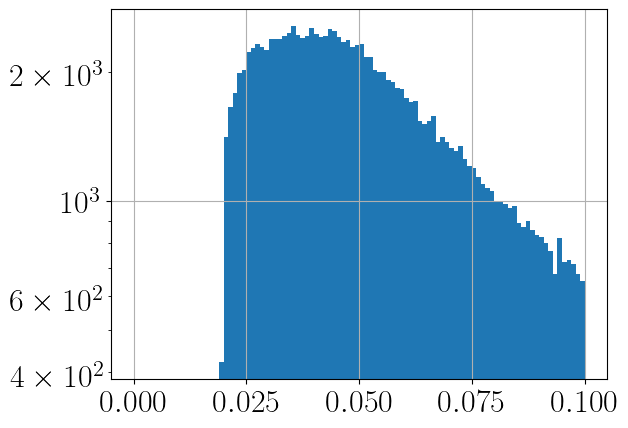

In [28]:
scattered_e.loc[he4.topology_1, "Q2"].hist(bins = np.linspace(0, 0.1, 101))
plt.yscale('log')

### Answer Silvia's question

<Axes: >

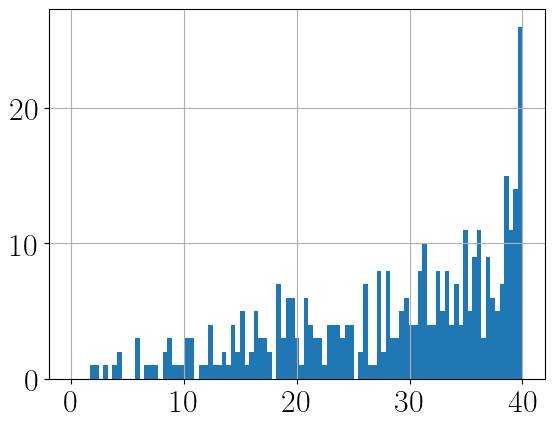

In [69]:
jpsi_antilepton_electron.loc[ (jpsi_lepton_electron.theta>2.5) & (jpsi_lepton_electron.theta<4.5)].theta.hist(bins = np.linspace(0, 40, 100))

## ALERT Phase Space

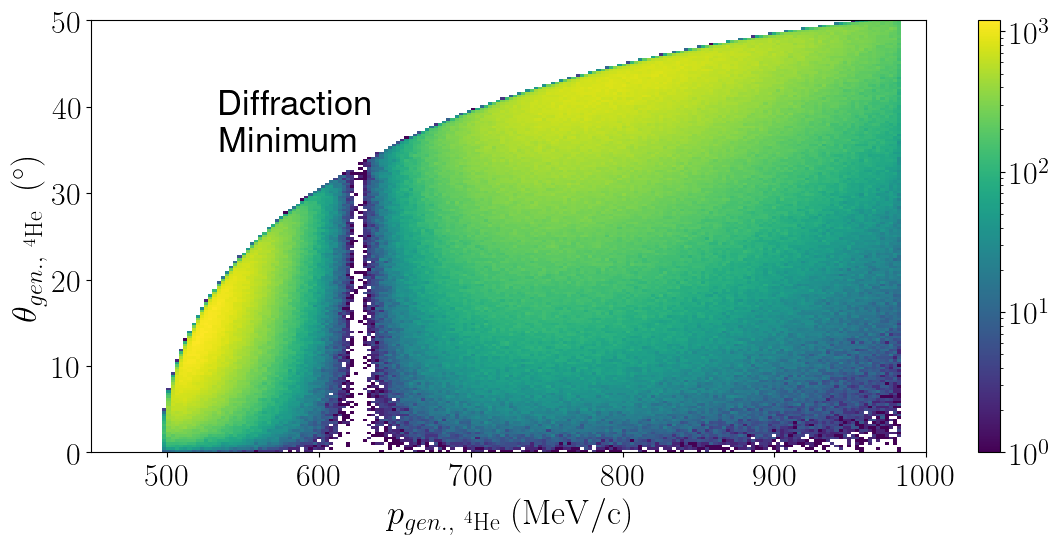

In [29]:
fig, ax = plt.subplots(1, 1, figsize = [12, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax.hist2d(1000*he4.p, he4.theta, bins = [np.linspace(450, 1000, 201), np.linspace(0, 60, 201)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax.set_ylabel(r"$\theta_{gen.,~^4\mathrm{He}}~~(^\circ)$")
ax.set_xlabel(r"$p_{gen.,~^4\mathrm{He}}~ (\mathrm{MeV/c})$")
def draw_box(ax, xstart, xend, ystart, yend, color = 'k', label = '', linewidth = 5, alpha = 0.3):
    # dummy = np.linspace(0, 1, 101)
    # ax.plot(xstart + (xend - xstart)*dummy, ystart + 0*dummy, color = color, label = label, linewidth = linewidth)
    # ax.plot(xstart + (xend - xstart)*dummy, yend + 0*dummy, color = color,linewidth = linewidth)
    # ax.plot(xend + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    # ax.plot(xstart + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    rect = patches.Rectangle((xstart, ystart), xend - xstart, yend-ystart, linewidth=1, edgecolor=color, facecolor=color, label = label, alpha = alpha, rasterized = True) 
    ax.add_patch(rect)

# draw_box(ax, 840, 1000, 5, 35, color = 'blue', label = 'CLAS12 Forward')
# draw_box(ax, 600, 1000, 40, 60, color = 'red', label = 'CLAS12 Central')
# draw_box(ax, 450, 1000, he4.loc[he4.accepted, "theta"].min(), 60, color = 'orange', label = 'ALERT', alpha = 0.3)
t_diff_min = 0.4
E_diff_min = mHe4 + t_diff_min/2/mHe4
p_diff_min = np.sqrt(E_diff_min**2 - mHe4**2)

plt.annotate(xy = (1000*p_diff_min-100, 35), xytext = (1000*p_diff_min-100, 35), text ='Diffraction\nMinimum')

plt.xticks([500, 600, 700, 800, 900, 1000])
plt.ylim([0, 50])
# plt.figlegend(bbox_to_anchor = (1.2, .9))
plt.tight_layout()


# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.savefig("alert_acceptance.pdf", bbox_inches = 'tight')

In [30]:
ahdc_entry_coord = 0
ahdc_exit_coord  = 34.92

atof_exit_coord  = 34.92-2
atof_entry_coord = atof_exit_coord - 27.975

nominal_target_start = atof_entry_coord - 3.92

survival_rate = {}

for target_length in [28]:#[28, 30, 35, 40, 45, 50]:  
    for target_start in [-8]:#np.linspace(-50, 10, 121):
        # target_end   = target_start + target_length
        # he4.loc[:, "vz"]       = np.random.uniform(target_start, target_end, len(he4))
        # he4.loc[:, "vz"]       = np.random.uniform(target_start_coord, target_end_coord, len(he4))
                
        c = 3e8
        B = 5
        rhelix = he4.pt*10**9/2/B/c
        omega  = 2*B*c**2/he4.e/10**9
        betat  = he4.pt/he4.e
        
        #atof_exit_condition
        time_atof_exit   = (atof_exit_coord - he4.vz)*0.01/(he4.pz/he4.e*c)
        theta_atof_exit  = omega * time_atof_exit
        transverse_displacement_atof_exit = rhelix*2*np.sin(theta_atof_exit/2)
        atof_exit_condition = transverse_displacement_atof_exit > 0.08

        #atof_entry_condition
        time_atof_entry   = (atof_entry_coord - he4.vz)*0.01/(he4.pz/he4.e*c)
        theta_atof_entry  = omega * time_atof_entry
        transverse_displacement_atof_entry = rhelix*2*np.sin(theta_atof_entry/2)
        atof_entry_condition = transverse_displacement_atof_entry < 0.08
        
        #ahdc_entry_condition
        time_ahdc_entry   = (ahdc_entry_coord - he4.vz)*0.01/(he4.pz/he4.e*c)
        theta_ahdc_entry  = omega * time_ahdc_entry
        transverse_displacement_ahdc_entry = rhelix*2*np.sin(theta_ahdc_entry/2)
        ahdc_entry_condition = transverse_displacement_ahdc_entry < 0.02
        
        alert_detection_condition = atof_entry_condition & atof_exit_condition & ahdc_entry_condition
        phase_space_cond = he4.t<0.4
    
        survival_rate[target_start, target_length] =  len(he4.loc[phase_space_cond & alert_detection_condition,:])/len(he4.loc[phase_space_cond,:])

In [31]:
survival_rate[(target_start, target_length)]

0.1937155298799218

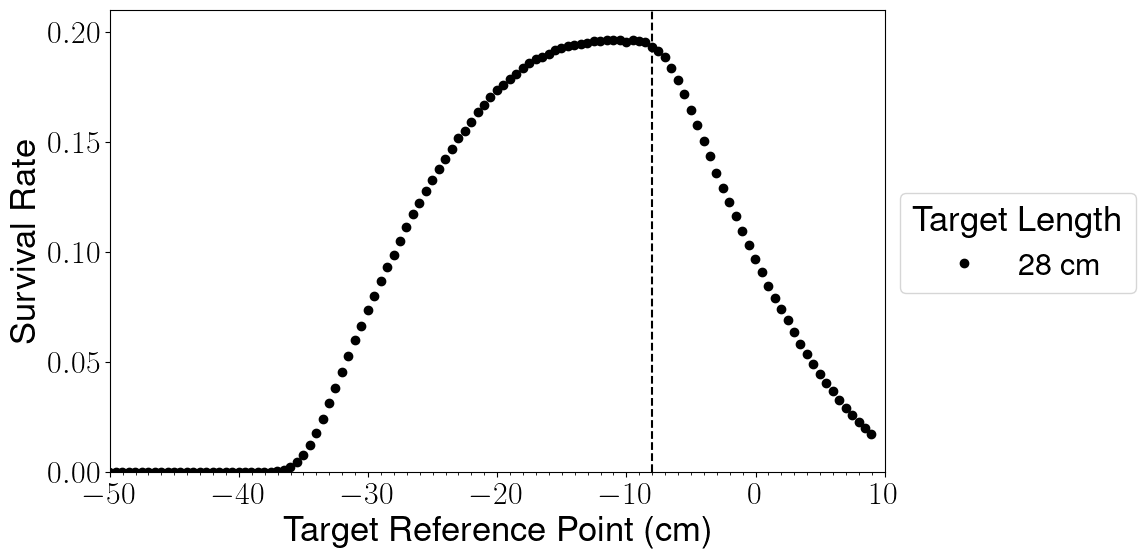

In [143]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
target_upstream_position, target_lengths = np.array(list(survival_rate.keys())).T
survival_rate_values     = np.array(list(survival_rate.values()))

for target_length in [28]:
    plt.plot(target_upstream_position[target_lengths==target_length] - nominal_target_start, survival_rate_values[target_lengths==target_length], marker = 'o', ls = '', label = "{} cm".format(target_length), color = 'k')
plt.xlim([-50, 10])
plt.ylim([0, 0.21])
plt.xticks([-50, -40, -30, -20, -10, 0, 10])
plt.xticks(np.linspace(-50, 10, 60+1), minor = True)
# plt.annotate(xy = (-23, 0.1), xytext = (-23, 0.1), text = '-23.5 cm')
plt.ylabel("Survival Rate")
plt.xlabel("Target Reference Point (cm)")
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.6), title = 'Target Length')
plt.axvline(-8 , color = 'k', ls = '--')
plt.show()

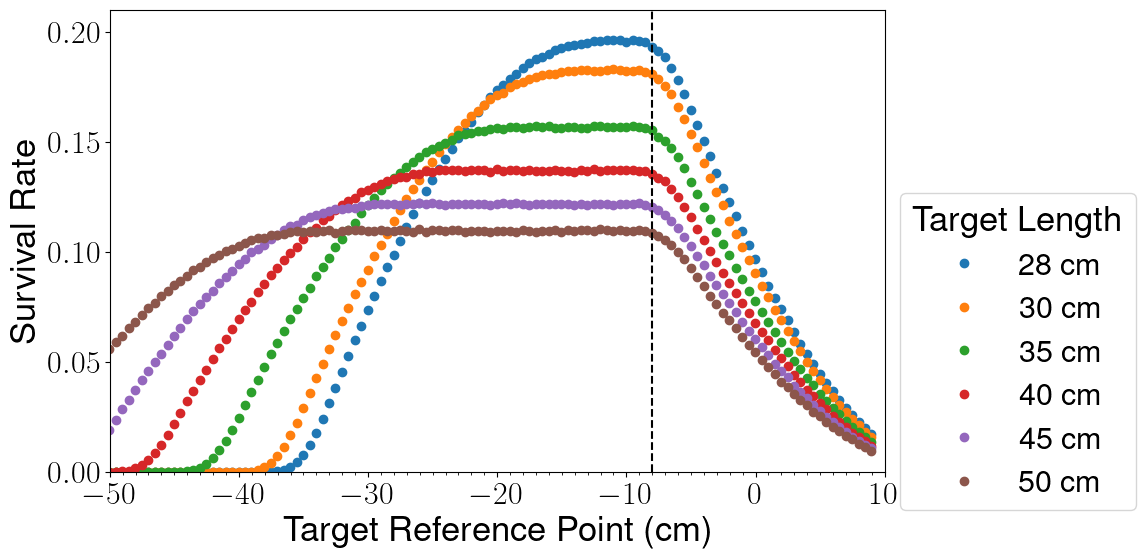

In [141]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
target_upstream_position, target_lengths = np.array(list(survival_rate.keys())).T
survival_rate_values     = np.array(list(survival_rate.values()))

for target_length in [28, 30, 35, 40, 45, 50]:
    plt.plot(target_upstream_position[target_lengths==target_length] - nominal_target_start, survival_rate_values[target_lengths==target_length], marker = 'o', ls = '', label = "{} cm".format(target_length))
plt.xlim([-50, 10])
plt.ylim([0, 0.21])
plt.xticks([-50, -40, -30, -20, -10, 0, 10])
plt.xticks(np.linspace(-50, 10, 60+1), minor = True)
# plt.annotate(xy = (-23, 0.1), xytext = (-23, 0.1), text = '-23.5 cm')
plt.ylabel("Survival Rate")
plt.xlabel("Target Reference Point (cm)")
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.6), title = 'Target Length')
plt.axvline(-8 , color = 'k', ls = '--')
plt.show()

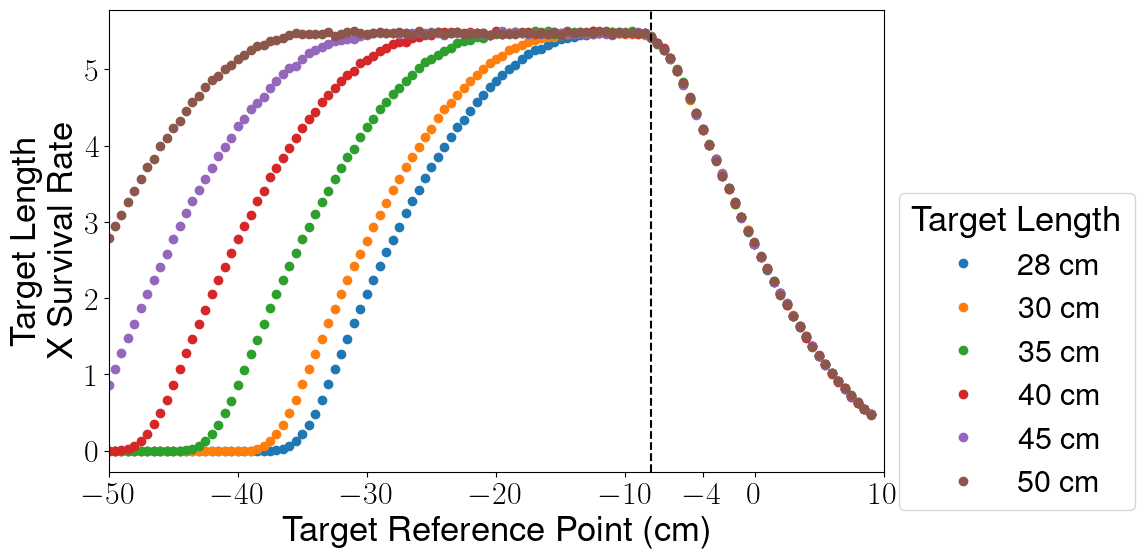

In [142]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
target_upstream_position, target_lengths = np.array(list(survival_rate.keys())).T
survival_rate_values     = np.array(list(survival_rate.values()))

for target_length in [28, 30, 35, 40, 45, 50]:
    plt.plot(target_upstream_position[target_lengths==target_length] - nominal_target_start, target_length* survival_rate_values[target_lengths==target_length], marker = 'o', ls = '', label = "{} cm".format(target_length))
plt.xlim([-50, 10])
# plt.ylim([0, 0.2])
plt.xticks([-50, -40, -30, -20, -10, -4, 0, 10])
# plt.annotate(xy = (-23, 0.1), xytext = (-23, 0.1), text = '-23.5 cm')
plt.ylabel("Target Length \n X Survival Rate")
plt.xlabel("Target Reference Point (cm)")
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.6), title = 'Target Length')
plt.axvline(-8 , color = 'k', ls = '--')
plt.show()

## FT acceptance study with RG-A data

In [32]:
df_exp_5422 = pd.read_pickle("/Users/sangbaek.lee/ANL/Jpsi/proton_rga/data/epebar/outb/5424_ep.pkl")

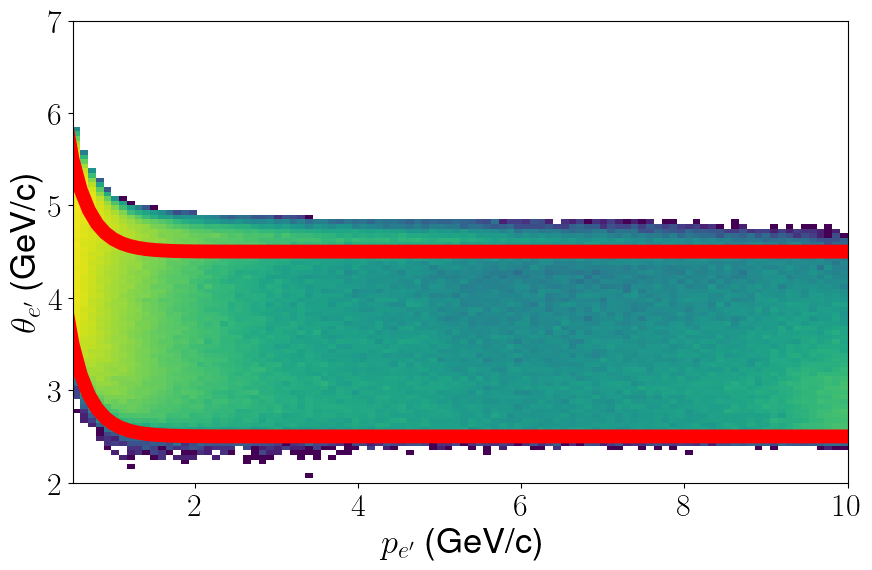

In [41]:
fig, ax = plt.subplots(1,1, figsize = (10, 6))

plt.hist2d(df_exp_5422.Ep, df_exp_5422.Etheta, bins = [np.linspace(0.5, 10, 101), np.linspace(2, 7, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
dummy = np.linspace(0, 10, 101)
plt.plot(dummy, np.exp(-(dummy-0.5)/0.25)+2.5, color = 'r', lw = 10)
plt.plot(dummy, np.exp(-(dummy-0.5)/0.25)+4.5, color = 'r', lw = 10)
plt.xlabel("$p_{e'}$" + " (GeV/c)") 
plt.ylabel(r"$\theta_{e'}$" + " (GeV/c)") 

plt.savefig("Run 5424, FT electron phase space.pdf", bbox_inches = 'tight')

## Study the phase space and acceptance

In [42]:
print(he4.loc[he4.accepted, "theta"].min())

12.200090652223777


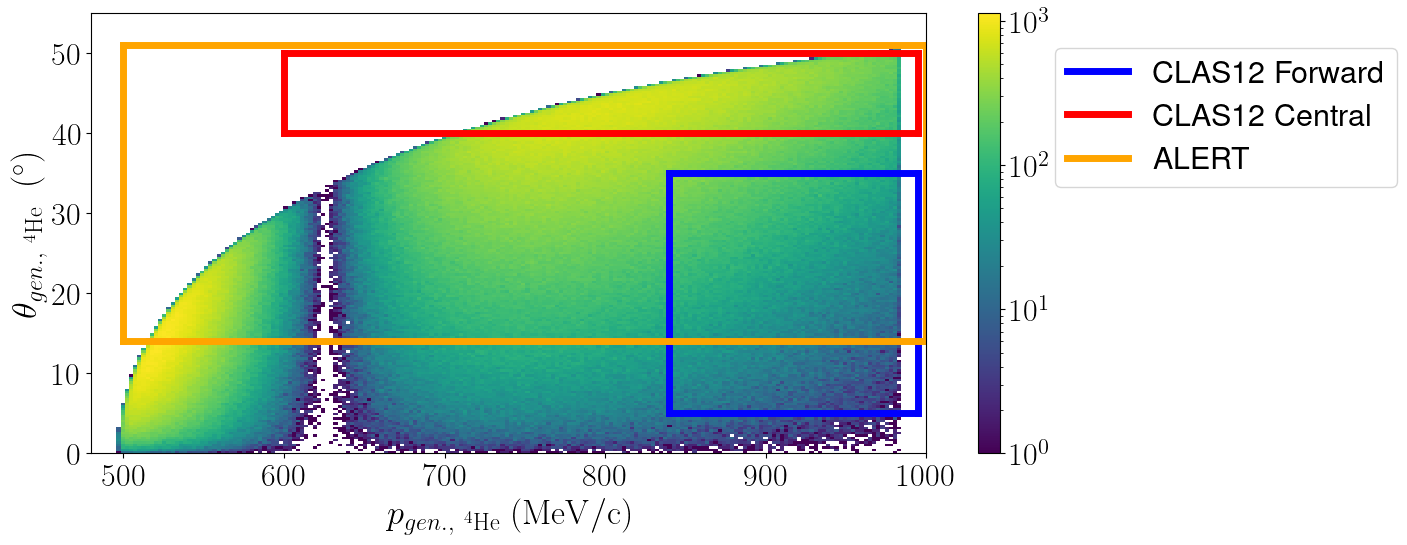

In [43]:
fig, ax = plt.subplots(1, 1, figsize = [12, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax.hist2d(1000*he4.p, he4.theta, bins = [np.linspace(480, 1000, 201), np.linspace(0, 60, 201)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax.set_ylabel(r"$\theta_{gen.,~^4\mathrm{He}}~~(^\circ)$")
ax.set_xlabel(r"$p_{gen.,~^4\mathrm{He}}~ (\mathrm{MeV/c})$")
def draw_box(ax, xstart, xend, ystart, yend, color = 'k', label = '', linewidth = 5, alpha = 0.3):
    dummy = np.linspace(0, 1, 101)
    ax.plot(xstart + (xend - xstart)*dummy, ystart + 0*dummy, color = color, label = label, linewidth = linewidth)
    ax.plot(xstart + (xend - xstart)*dummy, yend + 0*dummy, color = color,linewidth = linewidth)
    ax.plot(xend + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    ax.plot(xstart + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    # rect = patches.Rectangle((xstart, ystart), xend - xstart, yend-ystart, linewidth=1, edgecolor=color, facecolor=color, label = label, alpha = alpha, rasterized = True) 
    # ax.add_patch(rect)

draw_box(ax, 840, 995, 5, 35, color = 'blue', label = 'CLAS12 Forward', alpha = 1)
draw_box(ax, 600, 995, 40, 50, color = '#ff0000', label = 'CLAS12 Central', alpha = 1)
draw_box(ax, 500, 1000, 14, 51, color = 'orange', label = 'ALERT', alpha = 1)

plt.xticks([500, 600, 700, 800, 900, 1000])
plt.ylim([0, 55])
plt.figlegend(bbox_to_anchor = (1.2, .9))
plt.tight_layout()


# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.savefig("alert_acceptance.pdf", bbox_inches = 'tight')

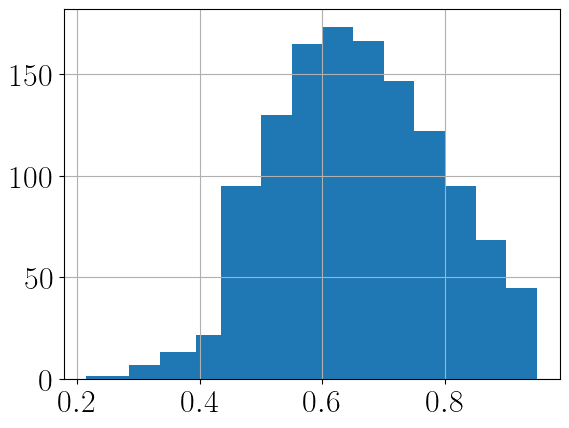

In [211]:
(he4.loc[he4.topology_1].t_smeared).hist(bins = tbins, weights =  he4.loc[he4.topology_1].weights)
plt.show()

In [215]:
np.sum(he4.loc[he4.topology_1 & (he4.t_smeared < 0.5)].weights)

137.60541950000126

In [216]:
np.sum(he4.loc[he4.topology_2 & (he4.t_smeared < 0.5)].weights)

100.57251132775006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


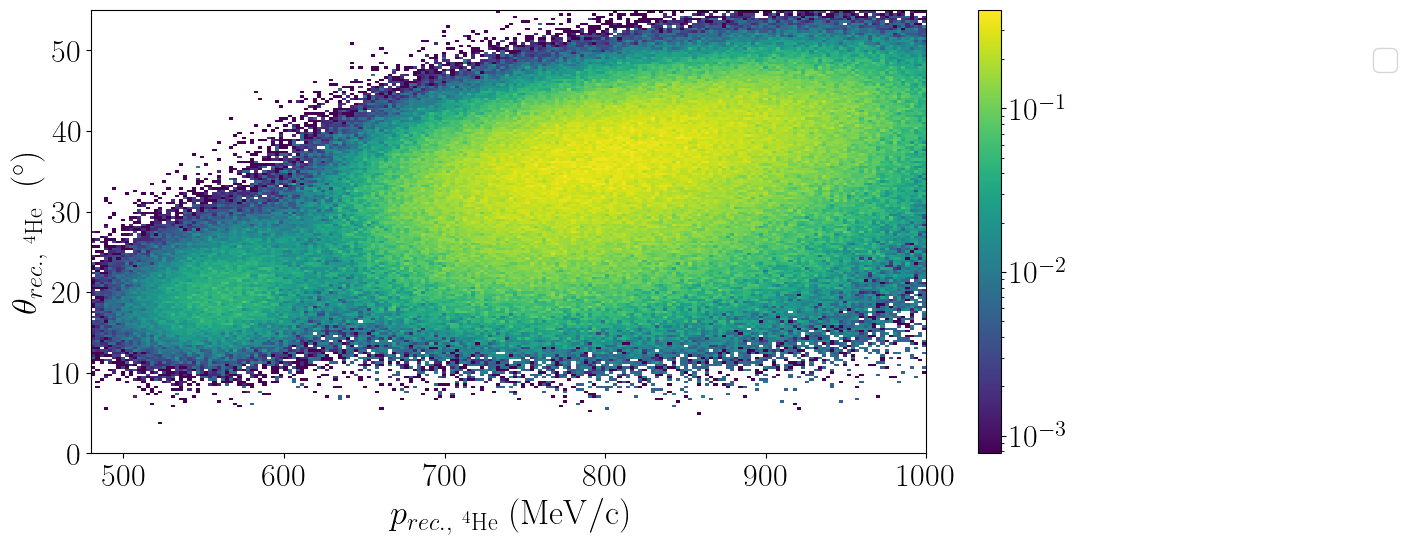

In [223]:
fig, ax = plt.subplots(1, 1, figsize = [12, 6])
#ax.hist2d(1000*he4.loc[topology].ke, he4.loc[topology].theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax.hist2d(1000*he4.loc[he4.topology].p_smeared, he4.loc[he4.topology].theta_smeared, bins = [np.linspace(480, 1000, 201), np.linspace(0, 60, 201)], norm = LogNorm(), rasterized = True, weights = he4.loc[he4.topology].weights)
plt.colorbar(h[3])
ax.set_ylabel(r"$\theta_{rec.,~^4\mathrm{He}}~~(^\circ)$")
ax.set_xlabel(r"$p_{rec.,~^4\mathrm{He}}~ (\mathrm{MeV/c})$")
def draw_box(ax, xstart, xend, ystart, yend, color = 'k', label = '', linewidth = 5, alpha = 0.3):
    dummy = np.linspace(0, 1, 101)
    ax.plot(xstart + (xend - xstart)*dummy, ystart + 0*dummy, color = color, label = label, linewidth = linewidth)
    ax.plot(xstart + (xend - xstart)*dummy, yend + 0*dummy, color = color,linewidth = linewidth)
    ax.plot(xend + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    ax.plot(xstart + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    # rect = patches.Rectangle((xstart, ystart), xend - xstart, yend-ystart, linewidth=1, edgecolor=color, facecolor=color, label = label, alpha = alpha, rasterized = True) 
    # ax.add_patch(rect)

# draw_box(ax, 840, 995, 5, 35, color = 'blue', label = 'CLAS12 Forward', alpha = 1)
# draw_box(ax, 600, 995, 40, 50, color = '#ff0000', label = 'CLAS12 Central', alpha = 1)
# draw_box(ax, 500, 1000, 14, 51, color = 'orange', label = 'ALERT', alpha = 1)

plt.xticks([500, 600, 700, 800, 900, 1000])
plt.ylim([0, 55])
plt.figlegend(bbox_to_anchor = (1.2, .9))
plt.tight_layout()


# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.savefig("alert_acceptance_rec.pdf", bbox_inches = 'tight')

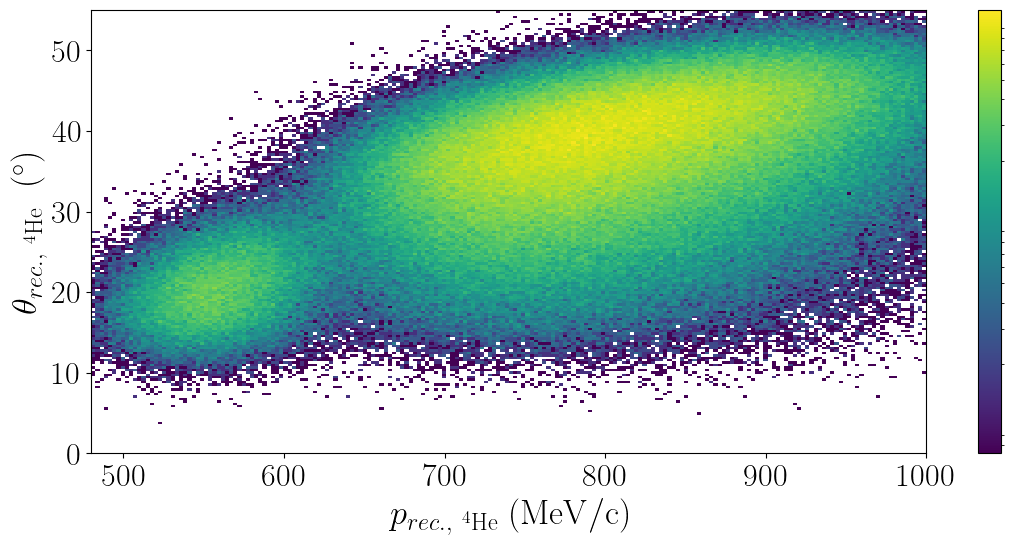

In [694]:
fig, ax = plt.subplots(1, 1, figsize = [12, 6])
#ax.hist2d(1000*he4.loc[topology].ke, he4.loc[topology].theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax.hist2d(1000*he4.loc[he4.topology_2].p_smeared, he4.loc[he4.topology_2].theta_smeared, bins = [np.linspace(480, 1000, 201), np.linspace(0, 60, 201)], norm = LogNorm(), rasterized = True, weights = he4.loc[he4.topology_2].weights)
cbar = plt.colorbar(h[3])
cbar.set_ticks([])
ax.set_ylabel(r"$\theta_{rec.,~^4\mathrm{He}}~~(^\circ)$")
ax.set_xlabel(r"$p_{rec.,~^4\mathrm{He}}~ (\mathrm{MeV/c})$")
def draw_box(ax, xstart, xend, ystart, yend, color = 'k', label = '', linewidth = 5, alpha = 0.3):
    dummy = np.linspace(0, 1, 101)
    ax.plot(xstart + (xend - xstart)*dummy, ystart + 0*dummy, color = color, label = label, linewidth = linewidth)
    ax.plot(xstart + (xend - xstart)*dummy, yend + 0*dummy, color = color,linewidth = linewidth)
    ax.plot(xend + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    ax.plot(xstart + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    # rect = patches.Rectangle((xstart, ystart), xend - xstart, yend-ystart, linewidth=1, edgecolor=color, facecolor=color, label = label, alpha = alpha, rasterized = True) 
    # ax.add_patch(rect)

# draw_box(ax, 840, 995, 5, 35, color = 'blue', label = 'CLAS12 Forward', alpha = 1)
# draw_box(ax, 600, 995, 40, 50, color = '#ff0000', label = 'CLAS12 Central', alpha = 1)
# draw_box(ax, 500, 1000, 14, 51, color = 'orange', label = 'ALERT', alpha = 1)

plt.xticks([500, 600, 700, 800, 900, 1000])
plt.ylim([0, 55])
# plt.figlegend(bbox_to_anchor = (1.2, .9))
plt.tight_layout()


# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.savefig("alert_acceptance2.pdf", bbox_inches = 'tight')

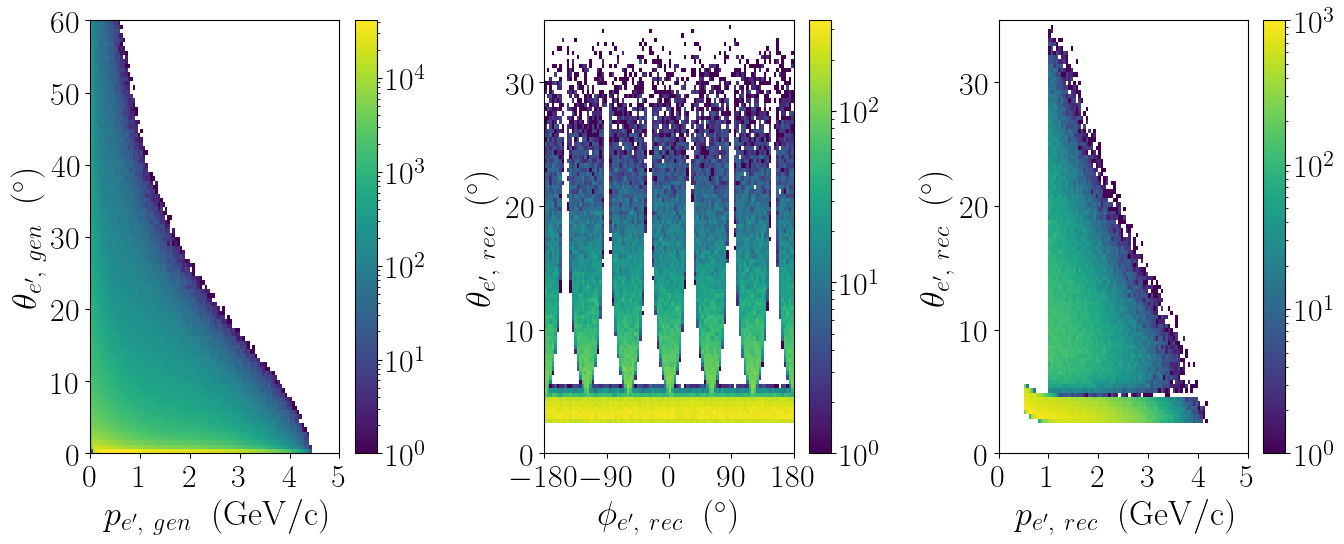

In [44]:
fig, ax = plt.subplots(1, 3, figsize = [14, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax[0].hist2d(scattered_e.p, scattered_e.theta, bins = [np.linspace(0, 5, 101), np.linspace(0, 60, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[0].set_ylabel(r"$\theta_{e',~gen}~~(^\circ)$")
ax[0].set_xlabel(r"$p_{e',~gen}~~(\mathrm{GeV/c})$")
ax[0].set_xticks([0, 1, 2, 3, 4, 5])

h = ax[1].hist2d(scattered_e.loc[he4.topology_1].phi, scattered_e.loc[he4.topology_1].theta, bins = [np.linspace(-180, 180, 101), np.linspace(0, 35, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[1].set_ylabel(r"$\theta_{e',~rec}~~(^\circ)$")
ax[1].set_xlabel(r"$\phi_{e',~rec}~~(^\circ)$")
ax[1].set_xticks([-180, -90, 0, 90, 180])

h = ax[2].hist2d(scattered_e.loc[he4.topology_1].p, scattered_e.loc[he4.topology_1].theta, bins = [np.linspace(0, 5, 101), np.linspace(0, 35, 101)], cmin = 1, norm = LogNorm(vmax = 10**3), rasterized = True)
plt.colorbar(h[3])
ax[2].set_ylabel(r"$\theta_{e',~rec}~~(^\circ)$")
ax[2].set_xlabel(r"$p_{e',~rec}~~(\mathrm{GeV/c})$")
ax[2].set_xticks([0, 1, 2, 3, 4, 5])

# for i in range(3):
#     ax[i].set_ylabel(r"$\theta_{gen}~~(^\circ)$")
#     ax[i].set_xlabel(r"$p_{gen}~ (\mathrm{GeV/c})$")

# draw_box(ax, 32, 65, 0, 20)
# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.tight_layout()
plt.savefig("scattered_e_acceptance.pdf", bbox_inches = 'tight')

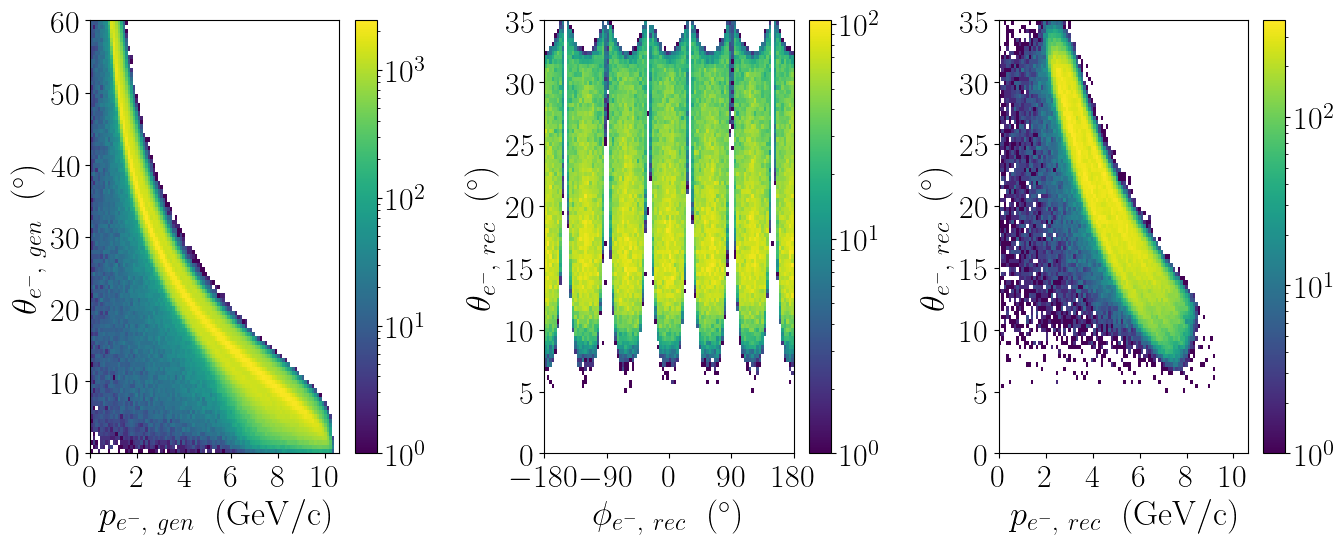

In [190]:
fig, ax = plt.subplots(1, 3, figsize = [14, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax[0].hist2d(jpsi_lepton.loc[he4.decay_channel == "electron"].p, jpsi_lepton.loc[he4.decay_channel == "electron"].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 60, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[0].set_ylabel(r"$\theta_{e^-,~gen}~~(^\circ)$")
ax[0].set_xlabel(r"$p_{e^-,~gen}~~(\mathrm{GeV/c})$")
ax[0].set_xticks([0, 2, 4, 6, 8, 10])

h = ax[1].hist2d(jpsi_lepton.loc[(he4.decay_channel == "electron") & he4.topology_2].phi, jpsi_lepton.loc[(he4.decay_channel == "electron") & he4.topology_2].theta, bins = [np.linspace(-180, 180, 101), np.linspace(0, 35, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[1].set_ylabel(r"$\theta_{e^-,~rec}~~(^\circ)$")
ax[1].set_xlabel(r"$\phi_{e^-,~rec}~~(^\circ)$")
ax[1].set_xticks([-180, -90, 0, 90, 180])
ax[1].set_yticks([0, 5, 10, 15, 20, 25, 30, 35])

h = ax[2].hist2d(jpsi_lepton.loc[(he4.decay_channel == "electron") & he4.topology_2].p, jpsi_lepton.loc[(he4.decay_channel == "electron") & he4.topology_2].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 35, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[2].set_ylabel(r"$\theta_{e^-,~rec}~~(^\circ)$")
ax[2].set_xlabel(r"$p_{e^-,~rec}~~(\mathrm{GeV/c})$")
ax[2].set_xticks([0, 2, 4, 6, 8, 10])
ax[2].set_yticks([0, 5, 10, 15, 20, 25, 30, 35])

# for i in range(3):
#     ax[i].set_ylabel(r"$\theta_{gen}~~(^\circ)$")
#     ax[i].set_xlabel(r"$p_{gen}~ (\mathrm{GeV/c})$")

# draw_box(ax, 32, 65, 0, 20)
# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.tight_layout()
plt.savefig("jpsi_lepton_electron_acceptance.pdf", bbox_inches = 'tight')

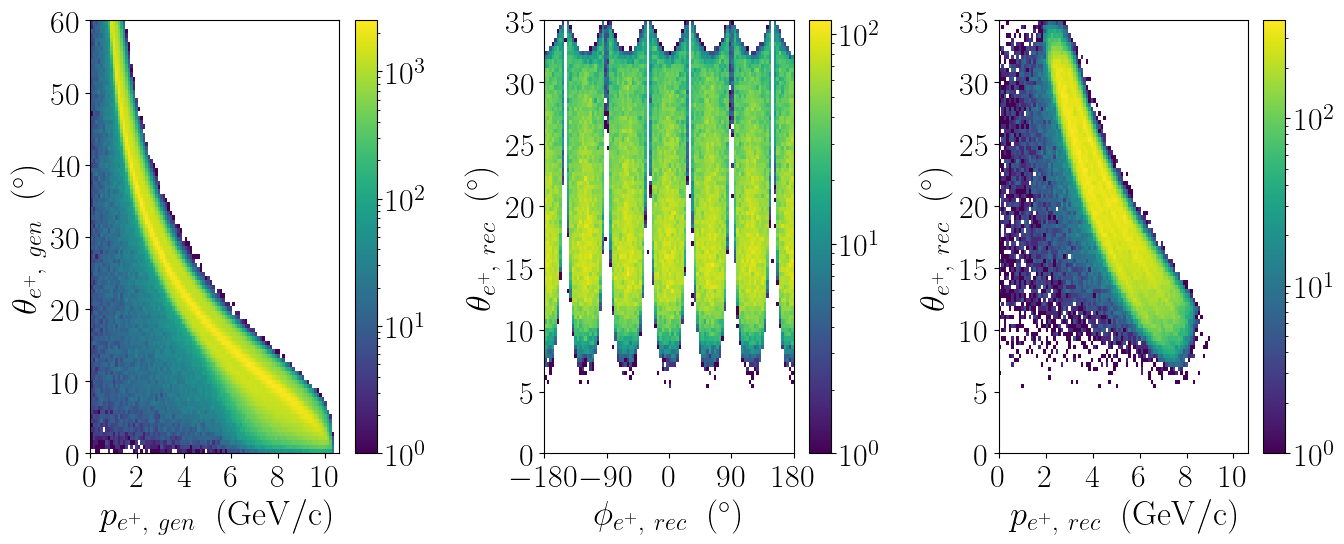

In [191]:
fig, ax = plt.subplots(1, 3, figsize = [14, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax[0].hist2d(jpsi_antilepton.loc[he4.decay_channel == "electron"].p, jpsi_antilepton.loc[he4.decay_channel == "electron"].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 60, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[0].set_ylabel(r"$\theta_{e^+,~gen}~~(^\circ)$")
ax[0].set_xlabel(r"$p_{e^+,~gen}~~(\mathrm{GeV/c})$")
ax[0].set_xticks([0, 2, 4, 6, 8, 10])

h = ax[1].hist2d(jpsi_antilepton.loc[(he4.decay_channel == "electron") & he4.topology_2].phi, jpsi_antilepton.loc[(he4.decay_channel == "electron") & he4.topology_2].theta, bins = [np.linspace(-180, 180, 101), np.linspace(0, 35, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[1].set_ylabel(r"$\theta_{e^+,~rec}~~(^\circ)$")
ax[1].set_xlabel(r"$\phi_{e^+,~rec}~~(^\circ)$")
ax[1].set_xticks([-180, -90, 0, 90, 180])
ax[1].set_yticks([0, 5, 10, 15, 20, 25, 30, 35])

h = ax[2].hist2d(jpsi_antilepton.loc[(he4.decay_channel == "electron") & he4.topology_2].p, jpsi_antilepton.loc[(he4.decay_channel == "electron") & he4.topology_2].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 35, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[2].set_ylabel(r"$\theta_{e^+,~rec}~~(^\circ)$")
ax[2].set_xlabel(r"$p_{e^+,~rec}~~(\mathrm{GeV/c})$")
ax[2].set_xticks([0, 2, 4, 6, 8, 10])
ax[2].set_yticks([0, 5, 10, 15, 20, 25, 30, 35])

# for i in range(3):
#     ax[i].set_ylabel(r"$\theta_{gen}~~(^\circ)$")
#     ax[i].set_xlabel(r"$p_{gen}~ (\mathrm{GeV/c})$")

# draw_box(ax, 32, 65, 0, 20)
# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.tight_layout()
plt.savefig("jpsi_antilepton_electron_acceptance.pdf", bbox_inches = 'tight')

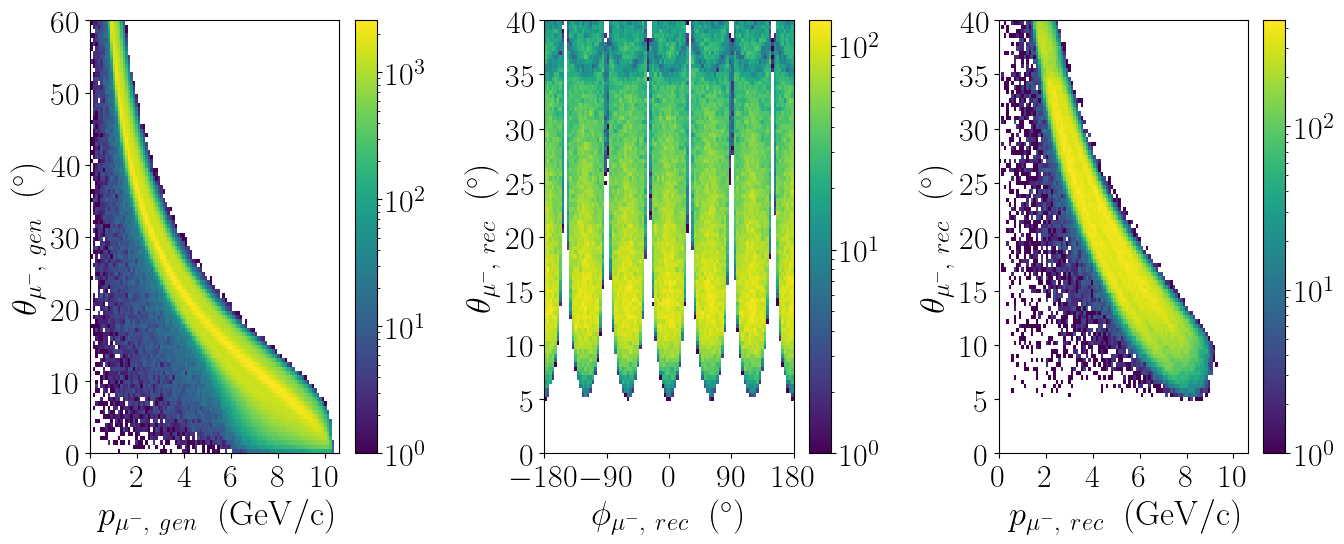

In [192]:
fig, ax = plt.subplots(1, 3, figsize = [14, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax[0].hist2d(jpsi_lepton.loc[he4.decay_channel == "muon"].p, jpsi_lepton.loc[he4.decay_channel == "muon"].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 60, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[0].set_ylabel(r"$\theta_{\mu^-,~gen}~~(^\circ)$")
ax[0].set_xlabel(r"$p_{\mu^-,~gen}~~(\mathrm{GeV/c})$")
ax[0].set_xticks([0, 2, 4, 6, 8, 10])

h = ax[1].hist2d(jpsi_lepton.loc[(he4.decay_channel == "muon") & he4.topology_2].phi, jpsi_lepton.loc[(he4.decay_channel == "muon") & he4.topology_2].theta, bins = [np.linspace(-180, 180, 101), np.linspace(0, 40, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[1].set_ylabel(r"$\theta_{\mu^-,~rec}~~(^\circ)$")
ax[1].set_xlabel(r"$\phi_{\mu^-,~rec}~~(^\circ)$")
ax[1].set_xticks([-180, -90, 0, 90, 180])
ax[1].set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

h = ax[2].hist2d(jpsi_lepton.loc[(he4.decay_channel == "muon") & he4.topology_2].p, jpsi_lepton.loc[(he4.decay_channel == "muon") & he4.topology_2].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 40, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[2].set_ylabel(r"$\theta_{\mu^-,~rec}~~(^\circ)$")
ax[2].set_xlabel(r"$p_{\mu^-,~rec}~~(\mathrm{GeV/c})$")
ax[2].set_xticks([0, 2, 4, 6, 8, 10])
ax[2].set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

# for i in range(3):
#     ax[i].set_ylabel(r"$\theta_{gen}~~(^\circ)$")
#     ax[i].set_xlabel(r"$p_{gen}~ (\mathrm{GeV/c})$")

# draw_box(ax, 32, 65, 0, 20)
# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.tight_layout()
plt.savefig("jpsi_lepton_muon_acceptance.pdf", bbox_inches = 'tight')

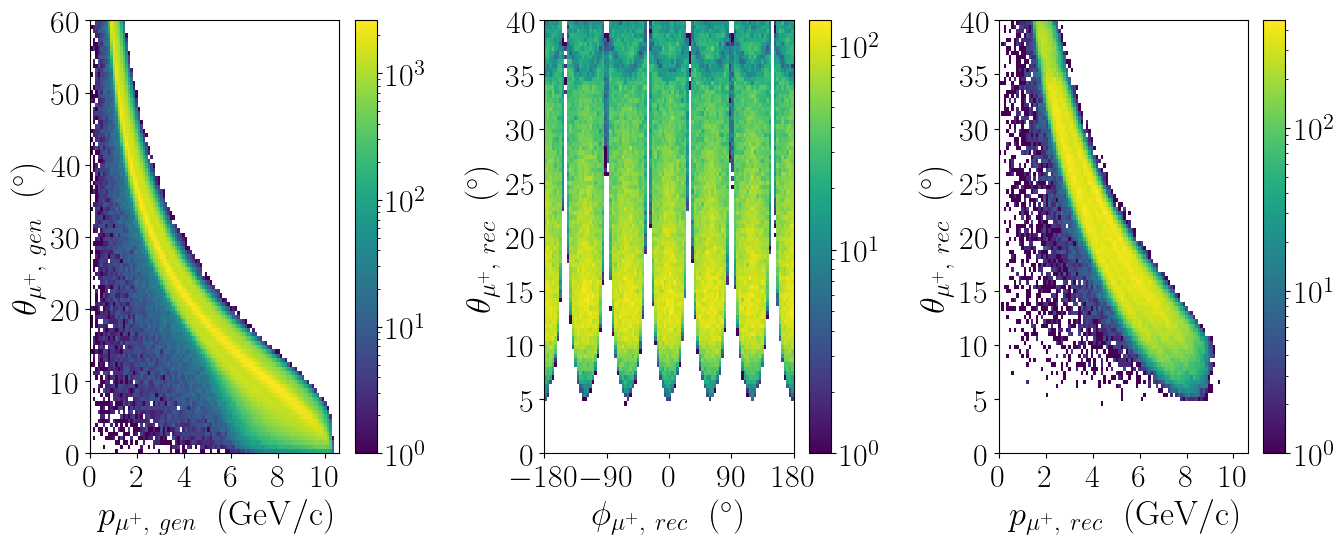

In [193]:
fig, ax = plt.subplots(1, 3, figsize = [14, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
h = ax[0].hist2d(jpsi_antilepton.loc[he4.decay_channel == "muon"].p, jpsi_antilepton.loc[he4.decay_channel == "muon"].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 60, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[0].set_ylabel(r"$\theta_{\mu^+,~gen}~~(^\circ)$")
ax[0].set_xlabel(r"$p_{\mu^+,~gen}~~(\mathrm{GeV/c})$")
ax[0].set_xticks([0, 2, 4, 6, 8, 10])

h = ax[1].hist2d(jpsi_antilepton.loc[(he4.decay_channel == "muon") & he4.topology_2].phi, jpsi_antilepton.loc[(he4.decay_channel == "muon") & he4.topology_2].theta, bins = [np.linspace(-180, 180, 101), np.linspace(0, 40, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[1].set_ylabel(r"$\theta_{\mu^+,~rec}~~(^\circ)$")
ax[1].set_xlabel(r"$\phi_{\mu^+,~rec}~~(^\circ)$")
ax[1].set_xticks([-180, -90, 0, 90, 180])
ax[1].set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

h = ax[2].hist2d(jpsi_antilepton.loc[(he4.decay_channel == "muon") & he4.topology_2].p, jpsi_antilepton.loc[(he4.decay_channel == "muon") & he4.topology_2].theta, bins = [np.linspace(0, 10.604, 101), np.linspace(0, 40, 101)], cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
ax[2].set_ylabel(r"$\theta_{\mu^+,~rec}~~(^\circ)$")
ax[2].set_xlabel(r"$p_{\mu^+,~rec}~~(\mathrm{GeV/c})$")
ax[2].set_xticks([0, 2, 4, 6, 8, 10])
ax[2].set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

# for i in range(3):
#     ax[i].set_ylabel(r"$\theta_{gen}~~(^\circ)$")
#     ax[i].set_xlabel(r"$p_{gen}~ (\mathrm{GeV/c})$")

# draw_box(ax, 32, 65, 0, 20)
# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.tight_layout()
plt.savefig("jpsi_antilepton_muon_acceptance.pdf", bbox_inches = 'tight')

In [194]:
# accidental_p = np.random.uniform(0, 2, len(he4))
# accidental_theta    = np.random.uniform(2, 30, len(he4))
# accidental_phi      = np.random.uniform(0, 360, len(he4))
# accidental_theta    = np.radians(accidental_theta)
# accidental_phi      = np.radians(accidental_phi)
# accidental_px       = accidental_p*np.sin(accidental_theta)*np.cos(accidental_phi)
# accidental_py       = accidental_p*np.sin(accidental_theta)*np.sin(accidental_phi)
# accidental_pz       = accidental_p*np.cos(accidental_phi)
# accidental_mass     = 0
# accidental_e        = accidental_p

# he4.loc[:, "Mjpsi" ] = np.sqrt((he4.e_smeared+scattered_e.e_smeared-10.604-mHe4)**2 - (he4.px_smeared + scattered_e.px_smeared)**2 - (he4.py_smeared + scattered_e.py_smeared)**2 -(he4.pz_smeared + scattered_e.pz_smeared-10.604)**2)
# he4.loc[:, "Mjpsi_accidental" ] = np.sqrt((he4.e_smeared+accidental_e-10.604-mHe4)**2 - (he4.px_smeared + accidental_px)**2 - (he4.py_smeared + accidental_py)**2 -(he4.pz_smeared + accidental_pz-10.604)**2)
# jpsi_lepton.loc[:, "Mjpsi" ] = np.sqrt((jpsi_lepton.e_smeared+jpsi_antilepton.e_smeared)**2 - (jpsi_lepton.px_smeared + jpsi_antilepton.px_smeared)**2 - (jpsi_lepton.py_smeared + jpsi_antilepton.py_smeared)**2 -(jpsi_lepton.pz_smeared + jpsi_antilepton.pz_smeared)**2)


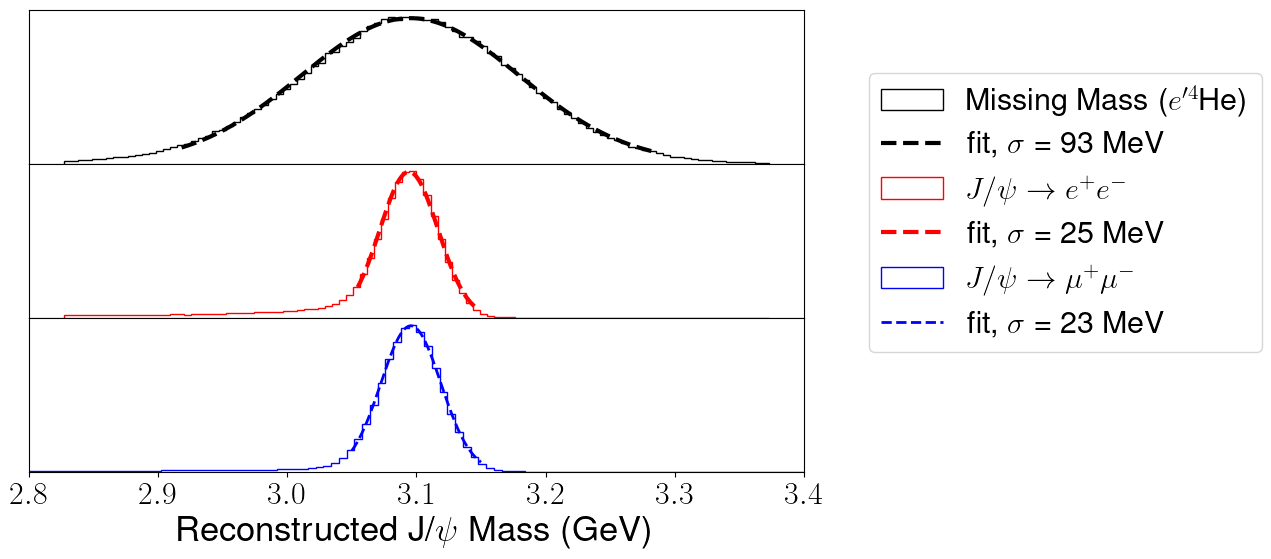

In [92]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

bins = np.linspace(2.8, 3.4, 101)
bincenters = (bins[:-1]+bins[1:])/2.

fig, ax = plt.subplots(3, 1, figsize = (10, 6))
signal, bins= np.histogram(he4.loc[he4.topology_1].Mjpsi_smeared, bins = bins)

ax[0].hist(bins[:-1], bins, weights = signal, histtype = 'step', color = 'k', label = "Missing Mass ($e'^4$He)")
popt, _ = curve_fit(gauss, bincenters, signal, p0 = (10, np.mean(he4.Mjpsi_smeared), np.std(he4.Mjpsi_smeared)))
dummy = np.linspace(2.9, 3.3, 10001)
ax[0].plot(dummy, gauss(dummy, *popt), label = "fit, $\sigma$ = {:.0f} MeV".format(1000*np.abs(popt[-1])), color = 'k', ls = '--', lw = 3)


signal, bins= np.histogram(jpsi_lepton.loc[he4.topology_2 & (he4.decay_channel=="electron")].Mjpsi_smeared, bins = bins)
ax[1].hist(bins[:-1], bins, weights = signal, histtype = 'step', label = r"$J/\psi \rightarrow e^+ e^-$", color = 'r')
popt, _ = curve_fit(gauss, bincenters, signal, p0 = (10, np.mean(he4.Mjpsi_smeared), np.std(he4.Mjpsi_smeared)))
dummy = np.linspace(3.05, 3.15, 10001)
ax[1].plot(dummy, gauss(dummy, *popt), label = "fit, $\sigma$ = {:.0f} MeV".format(1000*np.abs(popt[-1])), color = 'r', ls = '--', lw = 3)

signal, bins= np.histogram(jpsi_lepton.loc[he4.topology_2 & (he4.decay_channel=="muon")].Mjpsi_smeared, bins = bins)
ax[2].hist(bins[:-1], bins, weights = signal, histtype = 'step', label = r"$J/\psi \rightarrow \mu^+ \mu^-$", color = 'b')
popt, _ = curve_fit(gauss, bincenters, signal, p0 = (10, np.mean(he4.Mjpsi_smeared), np.std(he4.Mjpsi_smeared)))
dummy = np.linspace(3.05, 3.15, 10001)
ax[2].plot(dummy, gauss(dummy, *popt), label = "fit, $\sigma$ = {:.0f} MeV".format(1000*np.abs(popt[-1])), color = 'b', ls = '--', lw = 2)

for axis in ax:
    axis.get_yaxis().set_visible(False)
ax[0].set_xticks([])
ax[1].set_xticks([])

plt.subplots_adjust(hspace = 0)

plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.95, 0.8))
plt.xlim([2.8, 3.4])
plt.xlabel("Reconstructed J/$\psi$ Mass (GeV)")
plt.savefig("jpsi_mass_resolution.pdf", bbox_inches = 'tight')

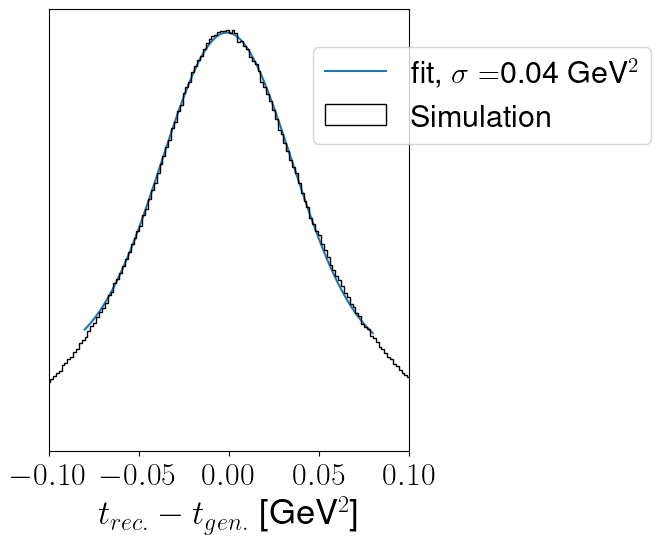

In [47]:
def gauss2(x, *p):
    A, mu, sigma, B = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + B

fig, axs = plt.subplots(1, 1, figsize = (5, 6))
hist, bins = np.histogram(he4.t_smeared - he4.t, bins = np.linspace(-0.08, 0.08, 100+1))
bincenters = (bins[1:] + bins[:-1])/2.
popt, _ = curve_fit(gauss2, bincenters, hist, p0 = (1.5*10**6, 0, 0.01, 0))
plt.plot(np.linspace(-0.08, 0.08, 1001), gauss2(np.linspace(-0.08, 0.08, 1001), *popt), color = 'tab:blue', label = "fit, "+r"$\sigma=$"+"{:.2f} GeV$^2$".format(np.abs(popt[2])))

hist, bins = np.histogram(he4.t_smeared - he4.t, bins = np.linspace(-0.16, 0.16, 201))
plt.hist(bins[:-1], bins, weights = hist, histtype = 'step', color = 'k', label = 'Simulation')

plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.65, 0.9))
# plt.ylim([0, 2.5e3])
plt.xlabel(r"$t_{rec.}-t_{gen.}$" + " [GeV$^2$]")
plt.xlim([-0.1, 0.1])
plt.xticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.yticks([])
# axs.get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig("t_resolution.pdf", bbox_inches = 'tight')

In [197]:
# Egamma = 10.604 - scattered_e.e
# W      = he4.W
# s      = W**2
# t      = -he4.t
# MX     = mJpsi
# MN     = mHe4
# pcprime  = np.sqrt((s-(MN+MX)**2)*(s-(MX-MN)**2)/4/s)
# costheta = (2*s*t+(s-MN**2)**2-MX**2 *(s+MN**2))/(2*np.sqrt(s)*pcprime*(s-MN**2))
# sintheta = np.sqrt(1-costheta**2)
# q      = [ (s-MN**2)/2/np.sqrt(s), 0, -(s-MN**2)/2/np.sqrt(s)]
# qprime = [ (s+MX**2-MN**2)/2/np.sqrt(s), -pcprime*np.sqrt(1-costheta**2), -pcprime*costheta]
# p      = [ (s+MN**2)/2/np.sqrt(s), 0, (s-MN**2)/2/np.sqrt(s)]
# pprime = [ (s-MX**2+MN**2)/2/np.sqrt(s), pcprime*sintheta, pcprime*costheta]

In [198]:
# def fourinner(vec1, vec2):
#     return vec1[0]*vec2[0]-vec1[1]*vec2[1]-vec1[2]*vec2[2]

# def fourinner_diff(vec1, vec2):
#     vec = fourvec_diff(vec1, vec2)
#     return fourinner(vec, vec)

# def fourvec_diff(vec1, vec2):
#     return [vec1[0]-vec2[0], vec1[1] -vec2[1], vec1[2] - vec2[2]]

# def fourvec_sum(vec1, vec2):
#     return [vec1[0] + vec2[0], vec1[1]  + vec2[1], vec1[2]  +  vec2[2]]

# def fourvec_avg(vec1, vec2):
#     return [0.5*vec1[0] + 0.5*vec2[0], 0.5*vec1[1]  + 0.5*vec2[1], 0.5*vec1[2]  +  0.5*vec2[2]]

In [199]:
# delta   = fourvec_diff(pprime, p)
# xi_numerator = fourinner(delta, q)
# pbar         = fourvec_avg(p, pprime)
# xi_denomiator= -2*fourinner(pbar, q)

## Mock-up data for the physics observable extraction

In [248]:
target_length

28

In [457]:
target_thickness = 6.02*10**23*0.506*28/(8.31*298) #5 atm = 0.506 MPa, # 5.5 atm = 0.557288 MPa, R = 8.31 cm3·MPa·K-1·mol-1
beam_current     = 1.3*10**(-6)
luminosity_in_cm_200 = target_thickness * 200*10**(-9)/(1.6e-19)
luminosity_in_nb_200 = 30/4#target_thickness * 200*10**(-9) * 10**(-24) * 10**(-9)/(1.6e-19)
# luminosity_in_cm_400 = target_thickness * 400*10**(-9)/(1.6e-19)
luminosity_in_nb_400 = 60/4#target_thickness * 400*10**(-9) * 10**(-24) * 10**(-9)/(1.6e-19)

luminosity_extended_in_cm = target_thickness * beam_current /(1.6e-19)
luminosity_extended_in_nb = target_thickness * beam_current  * 10**(-24) * 10**(-9)/(1.6e-19)

In [458]:
target_thickness

3.444195155832303e+21

In [459]:
integrated_lumi_proposed

267702499.9394277

In [460]:
number_of_days_approved_200 = 20
number_of_days_approved_400 = 10
number_of_days_extended = 100
integrated_lumi_approved = luminosity_in_nb_200 * 86400 * number_of_days_approved_200 + luminosity_in_nb_400 * 86400 * number_of_days_approved_400
integrated_lumi_extended = luminosity_extended_in_nb * 86400 * number_of_days_extended
integrated_lumi_proposed = integrated_lumi_approved + integrated_lumi_extended

In [461]:
luminosity_extended_in_nb

27.984085641137465

In [319]:
def luminosity_to_days(desired_lumi):
    return (desired_lumi - integrated_lumi_approved)/ (luminosity_extended_in_nb * 86400 )

In [325]:
luminosity_to_days(250e6)

92.6783369582734

In [326]:
235+26*0.5

248.0

In [58]:
def inverse_hist(hist):
    hist = hist.astype(float)
    return np.divide(np.ones_like(hist).astype(float), hist, where = hist!=0, out = np.zeros_like(hist))

def divide_hist(hist1, hist2):
    return hist1*inverse_hist(hist2)

In [59]:
total_xsec = he4.total_xsec.mean()
total_xsec_modified = he4_modified.total_xsec.mean()

accepted_xsec_electron = he4.loc[he4.topology_2 & (he4.decay_channel =="electron"), "accepted_xsec"].mean()
accepted_xsec_muon = he4.loc[he4.topology_2 & (he4.decay_channel =="muon"), "accepted_xsec"].mean()

accepted_xsec_modified_electron = he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="electron"), "accepted_xsec"].mean()
accepted_xsec_modified_muon = he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="muon"), "accepted_xsec"].mean()

## Acceptance Study

In [337]:
np.sum(he4.loc[he4.topology_2, "weights"])*26/250

48.191531680424966

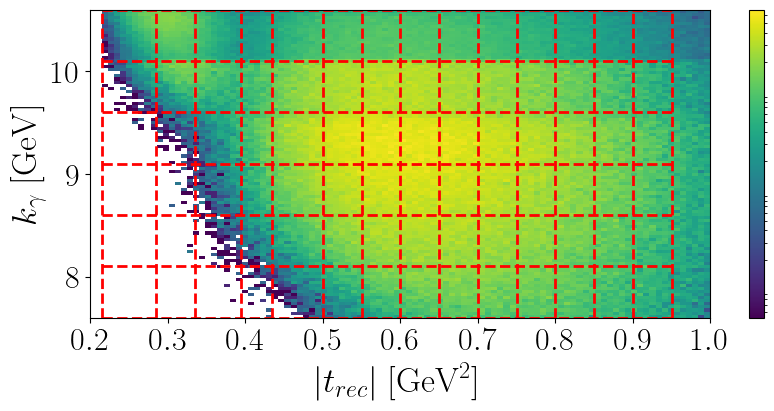

In [340]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

tbins       = [0.215, 0.285, 0.335, 0.395, 0.435, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
egammabins = [7.6, 8.1, 8.6, 9.1, 9.6, 10.1, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]
tbins_finer = np.linspace(np.min(tbins), 1, 101)
egammabins_finer = np.linspace(np.min(egammabins), np.max(egammabins), 101)

desired_lumi = integrated_lumi_proposed#2e8
efficiency   = 0.8
he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*desired_lumi * efficiency *total_xsec
he4.loc[:, "gen_weights"] = np.ones(len(he4))/len(he4)*desired_lumi * efficiency *total_xsec
he4.loc[he4.topology_2 & (he4.decay_channel =="electron"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="electron")])) * desired_lumi * efficiency * accepted_xsec_electron / len(he4.loc[he4.decay_channel =="electron"])
he4.loc[he4.topology_2 & (he4.decay_channel =="muon"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="muon")])) * desired_lumi * efficiency * accepted_xsec_muon / len(he4.loc[he4.decay_channel =="muon"])

h = plt.hist2d(he4.loc[he4.topology].t_smeared, he4.loc[he4.topology].kgamma_smeared, weights = he4.loc[he4.topology].weights, bins = [tbins_finer, egammabins_finer], norm = LogNorm(), rasterized = True)
# h = plt.hist2d(he4.loc[he4.topology].t_smeared, he4.loc[he4.topology].kgamma_smeared, weights = he4.loc[he4.topology].weights, bins = [tbins, egammabins], norm = LogNorm(vmin = 1, vmax = 10**2), rasterized = True)
cbar = plt.colorbar(h[3])
cbar.set_ticks([])

plt.xlabel("$|t_{rec}|~[\mathrm{GeV}^2]$")
plt.ylabel("$k_{\gamma}~[\mathrm{GeV}]$")
# plt.yticks([8.6, 9.1, 9.6, 10.1, 10.6])
# plt.ylim([8.6, 10.6])
plt.xlim([0.2, 1])
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xticks( np.linspace(0.25, 0.95, 7+1))
for ypos in egammabins:
    # plt.axhline(ypos, ls = '--', color = 'r', lw = 2)
    plt.plot(np.linspace(np.min(tbins), np.max(tbins), 101), np.linspace(np.min(tbins), np.max(tbins), 101)*0+ ypos, ls = '--', color = 'r', lw = 2)
for xpos in tbins:
    plt.axvline(xpos, ls = '--', color = 'r', lw = 2)

plt.savefig("suggested_bins.pdf", bbox_inches = 'tight')

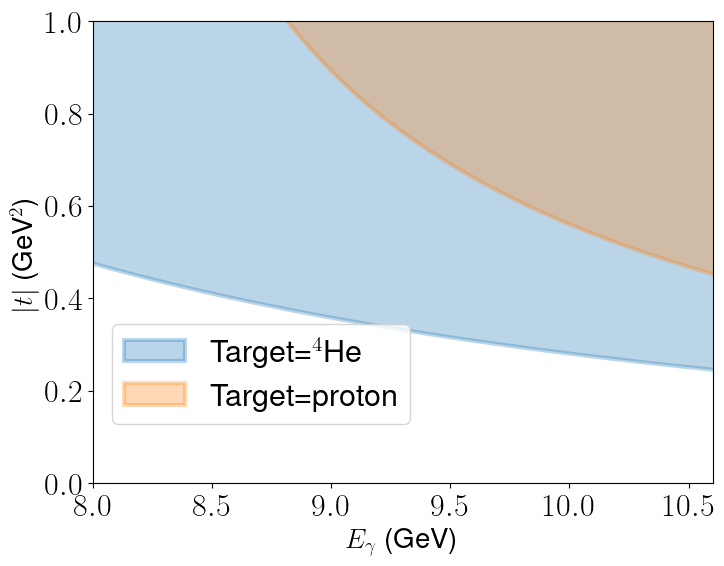

In [341]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

M = mHe4
W = np.linspace(mJpsi + mHe4 + 0.0001, 13, 100001)
ax.fill_between(Egamma_photo(W, M = mHe4), (tmin (W, 0, M = mHe4)), tmax(W, 0, M=mHe4), color = 'tab:blue', linewidth = 3, label = r"Target=$^4$He", alpha = 0.3)

# ax.fill_between((tmin (W, 0, M = mHe4)), Egamma_photo(W, M = mHe4), 30+0*Egamma_photo(W), color = 'tab:blue', linewidth = 3, label = r"$^4\mathrm{He}(e,e'J/\psi)^4\mathrm{He}$"+"\nAllowed phase space")#r"Target="+r"$^4$"+"He", alpha = 0.3)
# h = ax.hist2d(he4.t, 10.604-scattered_e.e, bins =100, norm = LogNorm())#, label = r"$^4\mathrm{He}(e,e'J/\psi)^4\mathrm{He}$"+"\nAllowed phase space")
plt.colorbar(h[3])
# ax.plot((W), (tmin (W, 0, M= mHe4)), color = 'tab:blue', label = r"$^4$" + 'He target')
# ax.plot((W), (tmax (W, 0, M= mHe4)), color = 'tab:blue')

W = np.linspace(mJpsi + mp + 0.0001, 13, 100001)
ax.fill_between(Egamma_photo(W, M = mp), (tmin (W, 0, M = mp)), tmax(W, 0, M=mp), color = 'tab:orange', linewidth = 3, label = r"Target=proton", alpha = 0.3)
# ax.fill_between((tmin (W, 0, M = mp)), Egamma_photo(W, M = mp), 30+0*Egamma_photo(W), color = 'tab:red', linewidth = 3, label = r"$^4\mathrm{p}(e,e'J/\psi)^4\mathrm{p}$"+"\nAllowed phase space")#r"Target="+r"$^4$"+"He", alpha = 0.3)
# ax.plot(W, np.sqrt(tmin (W, 0, M = mp)), 'tab:orange', label = 'Proton target')
# ax.plot(W, np.sqrt(tmax (W, 0, M = mp)), 'tab:orange')
# ax.set_xlabel("W (GeV)", fontsize = 20)
ax.set_xlabel(r"$E_{\gamma}$"+" (GeV)", fontsize = 20)
ax.set_ylabel(r"$|t|$" + " (GeV"+r"$^2$"+")", fontsize = 20)
# x  = np.linspace(0.4, 0.5, 101)
# ax.fill_between(x, 5 + 0*x, 11 + 0*x, linestyle= '--', color = 'orange', linewidth = 2, label = "Charge forn factor \n 1st diffraction mininum", alpha = 0.3)

plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.13, 0.4))#, title = )

# # ax.hist2d(scattered_e.W, he4.t, bins = 100, cmin = 1)
# h = ax.hist2d(10.604 - scattered_e.e, he4.t, bins = 100, cmin = 1, norm = LogNorm(), rasterized = True)
# cbar = plt.colorbar(h[3])
# cbar.ax.tick_params(labelsize=12) 
ax.set_ylim([0, 1])
ax.set_xlim([8, 10.6])
# # ax.set_yticks([5, 6, 7, 8, 9, 10, 11], [5, 6, 7, 8, 9, 10, 11])
# ax.set_xticks(np.linspace(0.2, 0.9, 7+1))

plt.show()

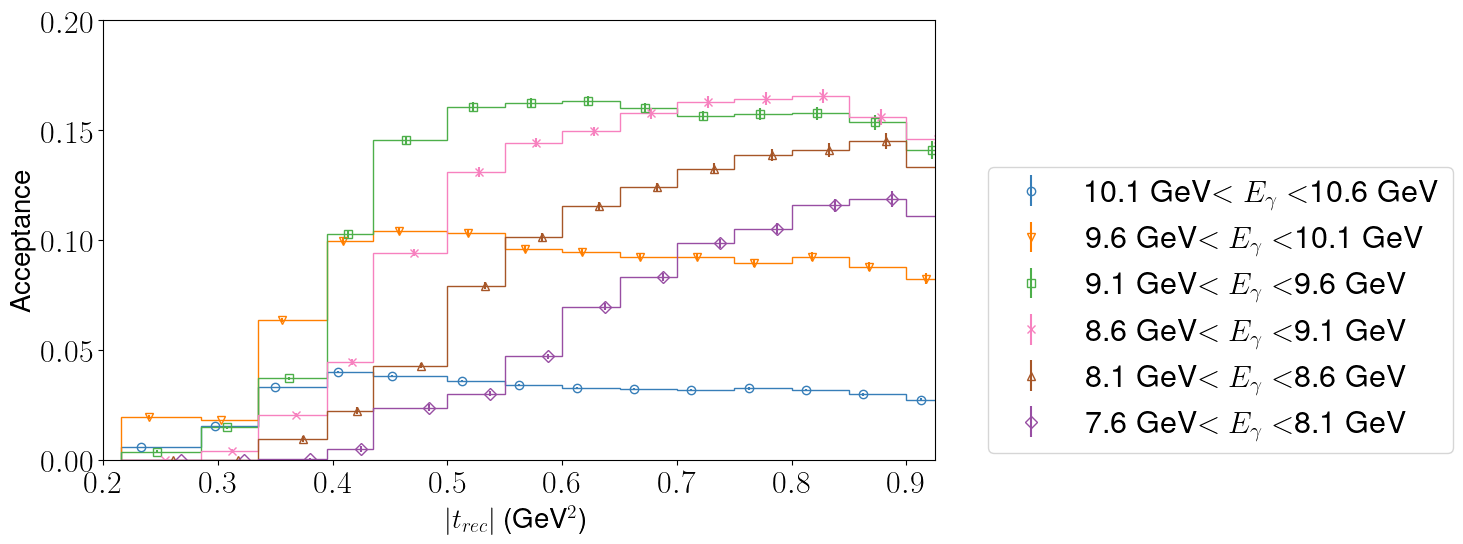

In [342]:
# # bins = [0.3, 0.4, 0.6, 0.8]
# # bins = [0.25, 0.4, 0.55, 0.7, 0.85, 1]#np.linspace(0.25, 0.95, 7+1)
# tbins       = [0.27, 0.3, 0.33, 0.36, 0.42, 0.52, 0.62, 0.72, 0.82, 0.92]
# egamma_bins = [7.4, 8.4, 9.2, 10, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]

# nbins = 7
bins = tbins#np.linspace(0.225, 0.925, nbins + 1)
bins = np.array(bins)
bincenters = (bins[:-1] + bins[1:])/2.

desired_lumi = 10e8#integrated_lumi_approved#2e8
he4_modified.loc[:, "weights"] = np.ones(len(he4_modified))/len(he4_modified)*desired_lumi*total_xsec_modified # * efficiency
he4_modified.loc[:, "gen_weights"] = np.ones(len(he4_modified))/len(he4_modified)*desired_lumi*total_xsec_modified
he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="electron"), "weights"] = np.ones(len(he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="electron")])) * desired_lumi * accepted_xsec_modified_electron / len(he4_modified.loc[he4_modified.decay_channel =="electron"]) # * efficiency
he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="muon"), "weights"] = np.ones(len(he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="muon")])) * desired_lumi * accepted_xsec_modified_muon / len(he4_modified.loc[he4_modified.decay_channel =="muon"]) # * efficiency


# egammabins = [8.6, 9.1, 9.6, 10.1, 10.6]
nevents_rec, _, _ = np.histogram2d(he4_modified.loc[he4_modified.topology].t_smeared, he4_modified.loc[he4_modified.topology].kgamma_smeared, bins = [bins, egammabins], weights = he4_modified.loc[he4_modified.topology].weights)
nevents_gen, _, _ = np.histogram2d(he4_modified.t, he4_modified.kgamma, bins = [bins, egammabins], weights = he4_modified.gen_weights)

stat_rec, _, _ = np.histogram2d(he4_modified.loc[he4_modified.topology].t_smeared, he4_modified.loc[he4_modified.topology].kgamma_smeared, bins = [bins, egammabins])#, weights = he4_modified.loc[he4_modified.topology].weights**2)
stat_gen, _, _ = np.histogram2d(he4_modified.t, he4_modified.kgamma, bins = [bins, egammabins])#, weights = he4_modified.gen_weights**2)
syst_rec, _, _ = np.histogram2d(he4_modified.loc[he4_modified.topology].t_smeared, he4_modified.loc[he4_modified.topology].kgamma_smeared, bins = [bins, egammabins], weights = he4_modified.loc[he4_modified.topology].weights**2)
syst_gen, _, _ = np.histogram2d(he4_modified.t, he4_modified.kgamma, bins = [bins, egammabins], weights = he4_modified.gen_weights**2)

acceptance = divide_hist(nevents_rec, nevents_gen)
acceptance_error = acceptance * np.sqrt( inverse_hist(stat_rec) + inverse_hist(stat_gen) + syst_rec*inverse_hist(nevents_rec)**2 + syst_gen*inverse_hist(nevents_gen)**2)

fig, axs = plt.subplots(1, 1, figsize = (10, 6))
hists = 0
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['o', 'v', 's', 'x', '^', 'D']
binwidths  = np.diff(bins)
adjustment = np.array([-0.25, -0.15, -0.05, 0.05, 0.15, 0.25])
for i in range(len(egammabins)-1):
    axs.hist(bins[:-1], bins, weights = acceptance[:, len(egammabins)-i-2], histtype = 'step', color = colors[i], )
    axs.errorbar(bincenters+adjustment[i]*binwidths, acceptance[:, len(egammabins)-i-2], yerr = acceptance_error[:,len(egammabins)-i-2], ls ='', color = colors[i], marker = markers[i], mfc = 'none',label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]))

axs.set_xlim([0.2, 0.925])
axs.set_xticks(np.linspace(0.2, 0.9, 7+1))
axs.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
# axs.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
axs.set_ylabel("Acceptance", size = 20)
axs.set_ylim([0, 0.2])
axs.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
# axs.xaxis.set_tick_params(labelsize=12)
# axs.yaxis.set_tick_params(labelsize=12)
# axs.set_ylim(bottom = 0.005)
# axs.set_yscale('log')
plt.figlegend(loc = 'upper left', bbox_to_anchor = (1.0, 0.7))
plt.tight_layout()
# plt.show()
plt.savefig("Acceptance.pdf", bbox_inches = 'tight')

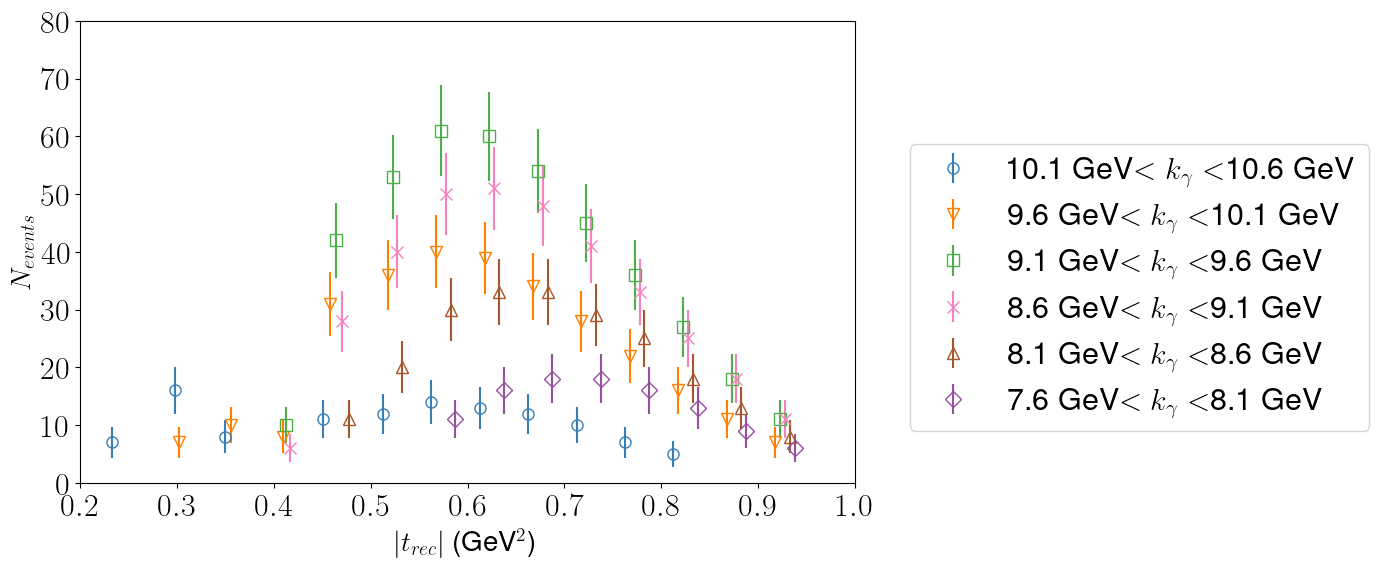

In [343]:
# bins = [0.3, 0.4, 0.6, 0.8]
# bins = [0.25, 0.4, 0.55, 0.7, 0.85, 1]#np.linspace(0.25, 0.95, 7+1)
# nbins = 7
# tbins       = [0.27, 0.3, 0.33, 0.36, 0.42, 0.52, 0.62, 0.72, 0.82, 0.92]
# egammabins = [7.4, 8.4, 9.2, 10, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]
# tbins       = [0.215, 0.285, 0.335, 0.395, 0.435, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# egammabins = [7.6, 8.1, 8.6, 9.1, 9.6, 10.1, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]
bins = np.array(tbins)
bincenters = (bins[:-1] + bins[1:])/2.
# egammabins = [7.4, 8.4, 9.2, 10, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]

desired_lumi = 2.35e8#integrated_lumi_proposed# 4e8#integrated_lumi_approved#2e8
efficiency   = 0.8#%
he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec_modified*efficiency
he4.loc[:, "gen_weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec_modified
he4.loc[he4.topology_2 & (he4.decay_channel =="electron"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="electron")])) * desired_lumi * accepted_xsec_modified_electron / len(he4.loc[he4.decay_channel =="electron"])
he4.loc[he4.topology_2 & (he4.decay_channel =="muon"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="muon")])) * desired_lumi * accepted_xsec_modified_muon / len(he4.loc[he4.decay_channel =="muon"])


# egammabins = [8.6, 9.1, 9.8, 10.2, 10.6]
nevents_rec, _, _ = np.histogram2d(he4.loc[(he4.topology) & (he4.theta_smeared>14)].t_smeared, he4.loc[(he4.topology) & (he4.theta_smeared>14)].kgamma_smeared, bins = [bins, egammabins], weights = he4.loc[(he4.topology) & (he4.theta_smeared>14)].weights)
nevents_gen, _, _ = np.histogram2d(he4.t, he4.kgamma, bins = [bins, egammabins], weights = he4.gen_weights)
nevents_rec = nevents_rec.astype(int)
nevents_rec[nevents_rec<5] = 0

n_events_rec_err = np.sqrt(nevents_rec)
n_events_rec_gen = np.sqrt(nevents_gen)
fig, axs = plt.subplots(1, 1, figsize = (10, 6))
hists = 0
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['o', 'v', 's', 'x', '^', 'D']
binwidths  = np.diff(bins)
adjustment = np.array([-0.25, -0.15, -0.05, 0.05, 0.15, 0.25])
for i in range(len(egammabins)-1):
    # axs.hist(bins[:-1], bins, weights = nevents_rec[:, len(egammabins)-i-2], histtype = 'step', color = colors[i], label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<k_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]))
    axs.errorbar(bincenters[nevents_rec[:, len(egammabins)-i-2]>0]+adjustment[i]*binwidths[nevents_rec[:, len(egammabins)-i-2]>0], nevents_rec[:, len(egammabins)-i-2][nevents_rec[:, len(egammabins)-i-2]>0], yerr = n_events_rec_err[:, len(egammabins)-i-2][nevents_rec[:, len(egammabins)-i-2]>0], ls ='', color = colors[i], marker = markers[i], ms = 8, label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<k_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), markerfacecolor = 'none')

axs.set_xlim([0.2, 1])
axs.set_xticks(np.linspace(0.2, 1, 8+1))
axs.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
# axs.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
axs.set_ylabel("$N_{events}$", size = 20)
axs.set_ylim([0, 80])
axs.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
# axs.xaxis.set_tick_params(labelsize=12)
# axs.yaxis.set_tick_params(labelsize=12)
# axs.axhline(10, color ='k', ls = '--')
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.94, 0.7))
# axs.set_ylim(bottom = 1)
# plt.yscale('log')
# plt.tight_layout()
# # plt.show()
plt.savefig("number_of_events.pdf", bbox_inches = 'tight')

In [344]:
# # bins = [0.3, 0.4, 0.6, 0.8]
# # bins = [0.25, 0.4, 0.55, 0.7, 0.85, 1]#np.linspace(0.25, 0.95, 7+1)
# # nbins = 7
# # tbins       = [0.27, 0.3, 0.33, 0.36, 0.42, 0.52, 0.62, 0.72, 0.82, 0.92]
# # egammabins = [7.4, 8.4, 9.2, 10, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]
# # tbins       = [0.215, 0.285, 0.335, 0.395, 0.435, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# # egammabins = [7.6, 8.1, 8.6, 9.1, 9.6, 10.1, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]
# bins = np.array(tbins)
# bincenters = (bins[:-1] + bins[1:])/2.
# # egammabins = [7.4, 8.4, 9.2, 10, 10.6]#[8.6, 9.1, 9.6, 10.1, 10.6]

# desired_lumi = 2.35e8#integrated_lumi_proposed# 4e8#integrated_lumi_approved#2e8
# efficiency   = 0.8#%
# he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec_modified*efficiency
# he4.loc[:, "gen_weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec_modified
# he4.loc[he4.topology_2 & (he4.decay_channel =="electron"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="electron")])) * desired_lumi * accepted_xsec_modified_electron / len(he4.loc[he4.decay_channel =="electron"])
# he4.loc[he4.topology_2 & (he4.decay_channel =="muon"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="muon")])) * desired_lumi * accepted_xsec_modified_muon / len(he4.loc[he4.decay_channel =="muon"])


# # egammabins = [8.6, 9.1, 9.8, 10.2, 10.6]
# nevents_rec, _, _ = np.histogram2d(he4.loc[(he4.topology_1) & (he4.theta_smeared>14)].t_smeared, he4.loc[(he4.topology_1) & (he4.theta_smeared>14)].kgamma_smeared, bins = [bins, egammabins], weights = he4.loc[(he4.topology_1) & (he4.theta_smeared>14)].weights)
# nevents_gen, _, _ = np.histogram2d(he4.t, he4.kgamma, bins = [bins, egammabins], weights = he4.gen_weights)
# nevents_rec = nevents_rec.astype(int)
# nevents_rec[nevents_rec<5] = 0

# n_events_rec_err = np.sqrt(nevents_rec)
# n_events_rec_gen = np.sqrt(nevents_gen)
# fig, axs = plt.subplots(1, 1, figsize = (10, 6))
# hists = 0
# colors = ['#377eb8', '#ff7f00', '#4daf4a',
#                   '#f781bf', '#a65628', '#984ea3',
#                   '#999999', '#e41a1c', '#dede00']
# markers = ['o', 'v', 's', 'x', '^', 'D']
# binwidths  = np.diff(bins)
# adjustment = np.array([-0.25, -0.15, -0.05, 0.05, 0.15, 0.25])
# for i in range(len(egammabins)-1):
#     # axs.hist(bins[:-1], bins, weights = nevents_rec[:, len(egammabins)-i-2], histtype = 'step', color = colors[i], label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<k_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]))
#     axs.errorbar(bincenters[nevents_rec[:, len(egammabins)-i-2]>0]+adjustment[i]*binwidths[nevents_rec[:, len(egammabins)-i-2]>0], nevents_rec[:, len(egammabins)-i-2][nevents_rec[:, len(egammabins)-i-2]>0], yerr = n_events_rec_err[:, len(egammabins)-i-2][nevents_rec[:, len(egammabins)-i-2]>0], ls ='', color = colors[i], marker = markers[i], ms = 8, label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<k_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), markerfacecolor = 'none')

# axs.set_xlim([0.2, 1])
# axs.set_xticks(np.linspace(0.2, 1, 8+1))
# axs.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
# # axs.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
# axs.set_ylabel("$N_{events}$", size = 20)
# axs.set_ylim([0, 80])
# axs.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
# # axs.xaxis.set_tick_params(labelsize=12)
# # axs.yaxis.set_tick_params(labelsize=12)
# # axs.axhline(10, color ='k', ls = '--')
# plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.94, 0.7))
# # axs.set_ylim(bottom = 1)
# # plt.yscale('log')
# # plt.tight_layout()
# # # plt.show()
# # plt.savefig("number_of_events.pdf", bbox_inches = 'tight')

In [345]:
desired_lumi = 2.35e8#integrated_lumi_proposed#2e8
efficiency   = 0.8

he4_modified.loc[:, "weights"] = np.ones(len(he4_modified))/len(he4_modified)*desired_lumi*total_xsec_modified  * efficiency
he4_modified.loc[:, "gen_weights"] = np.ones(len(he4_modified))/len(he4_modified)*desired_lumi*total_xsec_modified
he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="electron"), "weights"] = np.ones(len(he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="electron")])) * desired_lumi * accepted_xsec_modified_electron / len(he4_modified.loc[he4_modified.decay_channel =="electron"])  * efficiency
he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="muon"), "weights"] = np.ones(len(he4_modified.loc[he4_modified.topology_2 & (he4_modified.decay_channel =="muon")])) * desired_lumi * accepted_xsec_modified_muon / len(he4_modified.loc[he4_modified.decay_channel =="muon"])  * efficiency

he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec_modified*efficiency
he4.loc[:, "gen_weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec_modified
he4.loc[he4.topology_2 & (he4.decay_channel =="electron"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="electron")])) * desired_lumi * accepted_xsec_modified_electron / len(he4.loc[he4.decay_channel =="electron"])
he4.loc[he4.topology_2 & (he4.decay_channel =="muon"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="muon")])) * desired_lumi * accepted_xsec_modified_muon / len(he4.loc[he4.decay_channel =="muon"])


nevents_rec, _, _ = np.histogram2d(he4_modified.loc[he4_modified.topology].t_smeared, he4_modified.loc[he4_modified.topology].kgamma_smeared, bins = [bins, egammabins], weights = he4_modified.loc[he4_modified.topology].weights * efficiency)
nevents_gen, _, _ = np.histogram2d(he4_modified.t, he4_modified.kgamma, bins = [bins, egammabins], weights = he4_modified.gen_weights)

stat_rec, _, _ = np.histogram2d(he4_modified.loc[he4_modified.topology].t_smeared, he4_modified.loc[he4_modified.topology].kgamma_smeared, bins = [bins, egammabins])#, weights = he4_modified.loc[he4_modified.topology].weights**2)
stat_gen, _, _ = np.histogram2d(he4_modified.t, he4_modified.kgamma, bins = [bins, egammabins])#, weights = he4_modified.gen_weights**2)
syst_rec, _, _ = np.histogram2d(he4_modified.loc[he4_modified.topology].t_smeared, he4_modified.loc[he4_modified.topology].kgamma_smeared, bins = [bins, egammabins], weights = he4_modified.loc[he4_modified.topology].weights**2)
syst_gen, _, _ = np.histogram2d(he4_modified.t, he4_modified.kgamma, bins = [bins, egammabins], weights = he4_modified.gen_weights**2)

acceptance = divide_hist(nevents_rec, nevents_gen)
acceptance_error = acceptance * np.sqrt( inverse_hist(stat_rec) + inverse_hist(stat_gen) + syst_rec*inverse_hist(nevents_rec)**2 + syst_gen*inverse_hist(nevents_gen)**2)


nevents_rec, _, _ = np.histogram2d(he4.loc[he4.topology].t_smeared, he4.loc[he4.topology].kgamma_smeared, bins = [bins, egammabins], weights = he4.loc[he4.topology].weights)
nevents_gen, _, _ = np.histogram2d(he4.t, he4.kgamma, bins = [bins, egammabins], weights = he4.gen_weights)
nevents_rec       = nevents_rec.astype(int)
nevents_rec[nevents_rec<5] = 0#10**(-6)

acceptance_corrected_nevents_rec                = divide_hist(nevents_rec, acceptance)
acceptance_corrected_nevents_rec_stat_err       = divide_hist(np.sqrt(nevents_rec), acceptance)
acceptance_corrected_nevents_rec_syst_err_lower = np.select([acceptance_corrected_nevents_rec-nevents_gen<0, acceptance_corrected_nevents_rec-nevents_gen>0], [0.1, np.sqrt(0.1**2 + divide_hist(acceptance_corrected_nevents_rec-nevents_gen, acceptance_corrected_nevents_rec)**2)], default = 0.1)
acceptance_corrected_nevents_rec_syst_err_upper = np.select([acceptance_corrected_nevents_rec-nevents_gen>0, acceptance_corrected_nevents_rec-nevents_gen<0], [0.1, np.sqrt(0.1**2 + divide_hist(acceptance_corrected_nevents_rec-nevents_gen, acceptance_corrected_nevents_rec)**2)], default = 0.1)
acceptance_corrected_nevents_rec_syst_lower     = acceptance_corrected_nevents_rec*(1-acceptance_corrected_nevents_rec_syst_err_lower)
acceptance_corrected_nevents_rec_syst_upper     = acceptance_corrected_nevents_rec*(1+acceptance_corrected_nevents_rec_syst_err_upper)

In [346]:
t_mins = np.array(tbins)[:-1]
t_maxs = np.array(tbins)[1:]
t_centers = (t_mins + t_maxs)/2.
t_binwidths  = np.diff(tbins)
adjustment = np.array([-0.25, -0.15, -0.05, 0.05, 0.15, 0.25])*0.5

np.array(tbins)[:-1]
dfs = []
for i in range(len(egammabins)-1):
    df = pd.DataFrame()
    save_cond = nevents_rec[:, len(egammabins)-i-2]>0
    df.loc[:, "t_min"]                                        = t_mins[save_cond]
    df.loc[:, "t_max"]                                        = t_maxs[save_cond]
    df.loc[:, "t_center"]                                     = t_centers[save_cond]
    df.loc[:, "t_visual_center"]                              = t_centers[save_cond] +adjustment[i]*t_binwidths[save_cond]
    df.loc[:, "nevents_rec"]                                  = nevents_rec[:, len(egammabins)-i-2][save_cond]
    df.loc[:, "nevents_gen"]                                  = nevents_gen[:, len(egammabins)-i-2][save_cond]
    df.loc[:, "acceptance"]                                   = acceptance[:, len(egammabins)-i-2][save_cond]
    df.loc[:, "acceptance_corrected_nevents_rec"]             = acceptance_corrected_nevents_rec[:, len(egammabins)-i-2][save_cond]    
    df.loc[:, "acceptance_corrected_nevents_rec_stat_err"]    = acceptance_corrected_nevents_rec_stat_err[:, len(egammabins)-i-2][save_cond]    
    df.loc[:, "acceptance_corrected_nevents_rec_syst_err_lower"] = acceptance_corrected_nevents_rec_syst_err_lower[:, len(egammabins)-i-2][save_cond]    
    df.loc[:, "acceptance_corrected_nevents_rec_syst_err_upper"] = acceptance_corrected_nevents_rec_syst_err_upper[:, len(egammabins)-i-2][save_cond]
    df.loc[:, "acceptance_corrected_nevents_rec_syst_lower"] = acceptance_corrected_nevents_rec_syst_lower[:, len(egammabins)-i-2][save_cond]    
    df.loc[:, "acceptance_corrected_nevents_rec_syst_upper"] = acceptance_corrected_nevents_rec_syst_upper[:, len(egammabins)-i-2][save_cond]
    df.loc[:, "acceptance_corrected_nevents_rec_partial"]    = np.mean(df.loc[(df.t_center>0.5) & (df.t_center<0.7)].acceptance_corrected_nevents_rec)

    df.loc[:, "acceptance_corrected_nevents_rec_partial"]                =   df.loc[:, "acceptance_corrected_nevents_rec"]                /  np.mean(df.loc[(df.t_center>0.5) & (df.t_center<0.7)].acceptance_corrected_nevents_rec) 
    df.loc[:, "acceptance_corrected_nevents_rec_partial_stat"]           =   np.sqrt(df.nevents_rec)/df.nevents_rec * df.loc[:, "acceptance_corrected_nevents_rec_partial"]  
    df.loc[:, "acceptance_corrected_nevents_rec_partial_syst_lower"]     =   df.loc[:, "acceptance_corrected_nevents_rec_syst_lower"]     /  np.mean(df.loc[(df.t_center>0.5) & (df.t_center<0.7)].acceptance_corrected_nevents_rec) 
    df.loc[:, "acceptance_corrected_nevents_rec_partial_syst_upper"]     =   df.loc[:, "acceptance_corrected_nevents_rec_syst_upper"]     /  np.mean(df.loc[(df.t_center>0.5) & (df.t_center<0.7)].acceptance_corrected_nevents_rec) 
    df.loc[:, "kgamma_min"]                                        = egammabins[len(egammabins)-i-2]
    df.loc[:, "kgamma_max"]                                        = egammabins[len(egammabins)-i-1]
    df.loc[:, "binsize"]      = 0 
    for i in range(len(df)):
        df.loc[df.index==i, "binsize"]                = binsize(df.iloc[i].t_min, df.iloc[i].t_max, df.iloc[i].kgamma_min, df.iloc[i].kgamma_max)
    df.loc[:, "relative_cross_section"]                =    df.acceptance_corrected_nevents_rec/ df.binsize
    df.loc[:, "relative_cross_section"]                =    df.relative_cross_section/ np.mean(df.loc[(df.t_center>0.5) & (df.t_center<0.7)].relative_cross_section)
    df.loc[:, "relative_cross_section_stat"]           =    np.sqrt(df.nevents_rec)/df.nevents_rec * df.relative_cross_section
    df.loc[:, "relative_cross_section_syst_lower"]           =    df.acceptance_corrected_nevents_rec_syst_lower/df.acceptance_corrected_nevents_rec * df.relative_cross_section
    df.loc[:, "relative_cross_section_syst_upper"]           =    df.acceptance_corrected_nevents_rec_syst_upper/df.acceptance_corrected_nevents_rec * df.relative_cross_section

    dfs.append(df)
dfs = pd.concat(dfs).reset_index()
dfs = dfs.loc[:, dfs.columns[1:]]

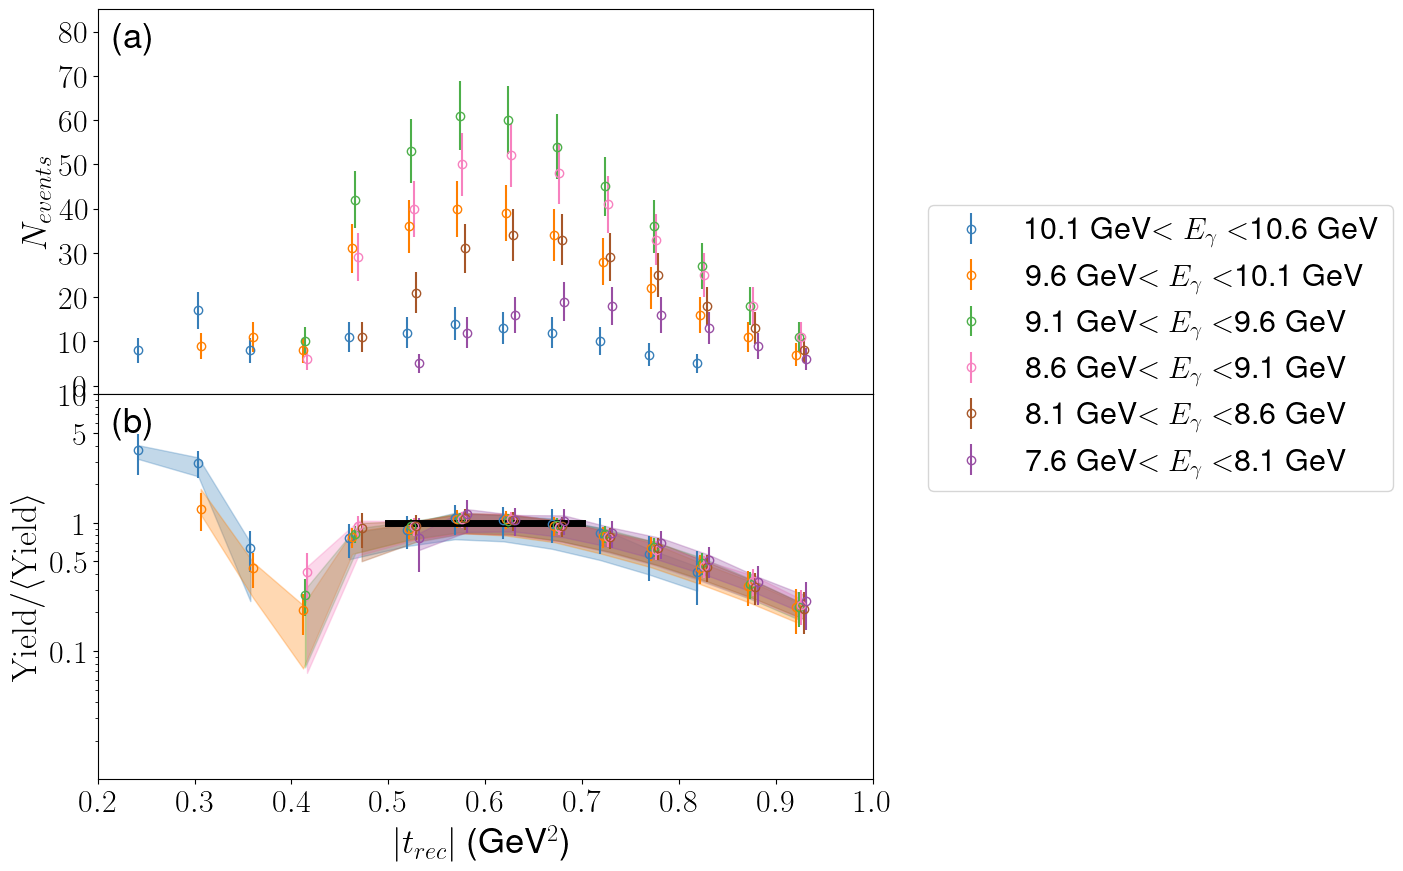

In [347]:
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
hists = 0
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['o', 'v', 's', 'x', '^', 'D']


for i in range(0, len(egammabins)-1):
    draw_cond = dfs.kgamma_min == egammabins[len(egammabins) - i -2]
    axs[0].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].nevents_rec, yerr = np.sqrt(dfs.loc[draw_cond].nevents_rec),  marker = 'o', color = colors[i], ls ='', mfc  = 'none')

axs[0].get_xaxis().set_visible(False)
# axs[0].set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
axs[0].set_ylabel("$N_{events}$")#, size = 20)
axs[0].set_ylim([-2, 85])
axs[0].set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
axs[0].annotate(xy = (0.02, 0.9), xytext = (0.02, 0.9), text = '(a)', xycoords = 'axes fraction')

for i in range(0, 1):
    draw_cond = (dfs.kgamma_min == egammabins[len(egammabins) - i -2]) & (dfs.t_max < 0.4)
    axs[1].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial, yerr = dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_stat,  marker = 'o', color = colors[i], ls ='', label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc = 'none')
    axs[1].fill_between(dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_syst_lower, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_syst_upper, color = colors[i], alpha = 0.3)

    draw_cond = (dfs.kgamma_min == egammabins[len(egammabins) - i -2]) & (dfs.t_min > 0.4)
    axs[1].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial, yerr = dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_stat,  marker = 'o', color = colors[i], ls ='', mfc = 'none')
    axs[1].fill_between(dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_syst_lower, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_syst_upper, color = colors[i], alpha = 0.3)

for i in range(1, len(egammabins)-1):
    draw_cond = dfs.kgamma_min == egammabins[len(egammabins) - i -2]
    axs[1].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial, yerr = dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_stat,  marker = 'o', color = colors[i], ls ='', label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc  = 'none')
    axs[1].fill_between(dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_syst_lower, dfs.loc[draw_cond].acceptance_corrected_nevents_rec_partial_syst_upper, color = colors[i], alpha = 0.3)

dummy = np.linspace(0.5, 0.7, 101)
axs[1].plot(dummy, np.ones_like(dummy), ls = '-', color = 'k', lw = 5)
axs[1].annotate(xy = (0.02, 0.9), xytext = (0.02, 0.9), text = '(b)', xycoords = 'axes fraction')

axs[1].set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")")#, size = 20)
# axs[1].set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
axs[1].set_ylabel("$\mathrm{Yield}/ \\langle \mathrm{Yield} \\rangle $")#, size = 20)
# axs[1].xaxis.set_tick_params(labelsize=12)
# axs[1].yaxis.set_tick_params(labelsize=12)
# axs[1].axhline(10, color ='k', ls = '--')
axs[1].set_ylim([0.01, 10])
for ax in axs:
    ax.set_xlim([0.2, 1])


plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.94, 0.7))
# axs[1].set_ylim(bottom = 1)
axs[1].set_yscale('log')
axs[1].set_yticks([0.1, 0.5, 1, 5, 10])
axs[1].set_yticklabels(["$0.1$", "$0.5$", "$1$", "$5$", "$10$"])
plt.subplots_adjust(hspace = 0)
plt.savefig("acceptance_corrected_yield.pdf", bbox_inches = 'tight')
# # plt.show()
# for i in range(1, len(egammabins)-1):
#     draw_cond = acceptance_corrected_nevents_rec[:, len(egammabins)-i-2]>0
#     # axs.hist(bins[:-1], bins, weights = nevents_rec[:, len(egammabins)-i-2], histtype = 'step', color = colors[i], label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]))
#     axs.errorbar    (bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec[:, len(egammabins)-i-2][draw_cond], yerr = acceptance_corrected_nevents_rec_stat_err[:, len(egammabins)-i-2][draw_cond], ls ='', color = colors[i], marker = markers[i], ms = 10, label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc  = 'none')
#     axs.fill_between(bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec_syst_lower[:, len(egammabins)-i-2][draw_cond], acceptance_corrected_nevents_rec_syst_upper[:, len(egammabins)-i-2][draw_cond], color = colors[i], alpha = 0.3)


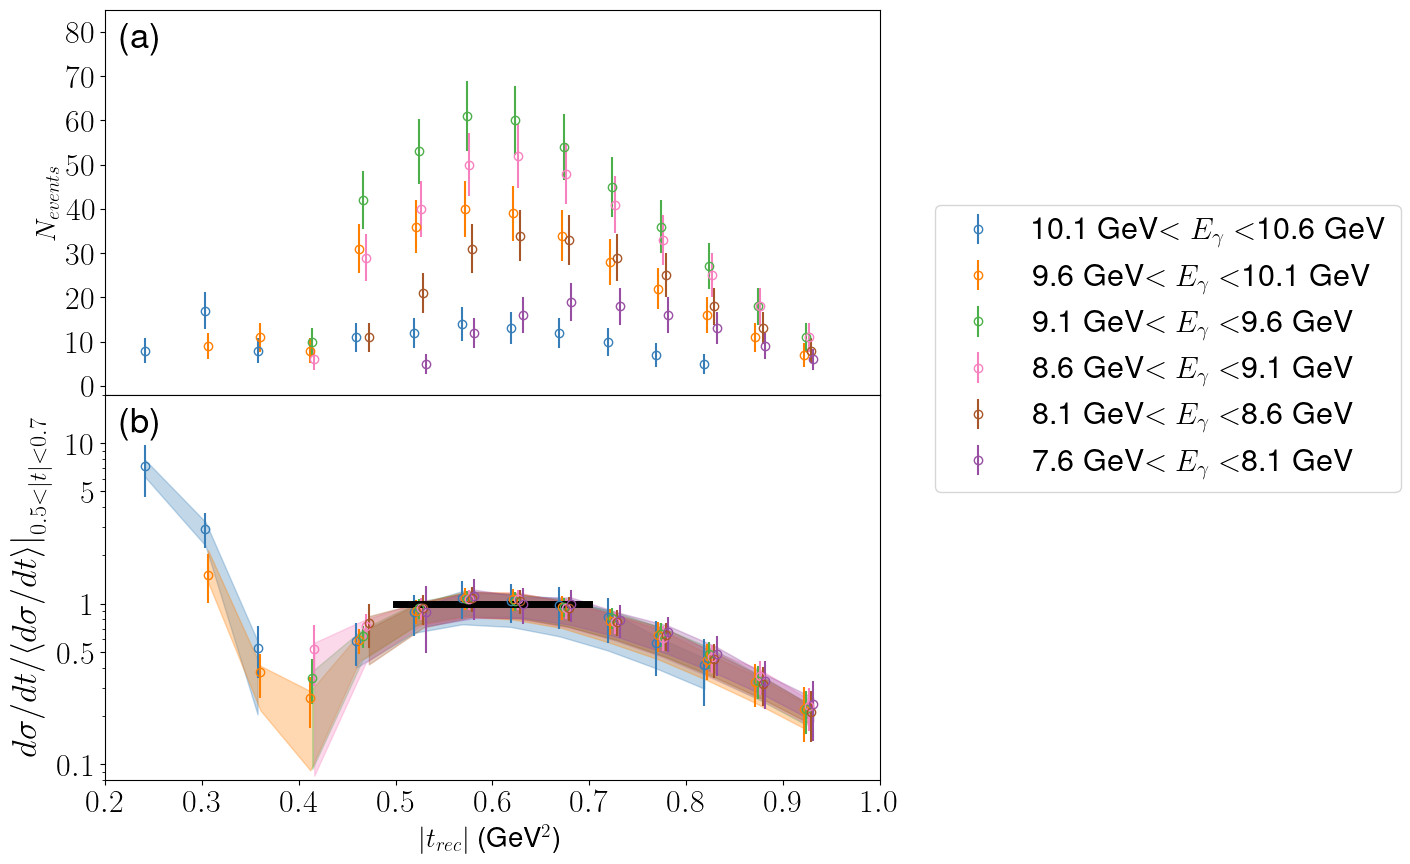

In [348]:
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
hists = 0
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['o', 'v', 's', 'x', '^', 'D']


for i in range(0, len(egammabins)-1):
    draw_cond = dfs.kgamma_min == egammabins[len(egammabins) - i -2]
    axs[0].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].nevents_rec, yerr = np.sqrt(dfs.loc[draw_cond].nevents_rec),  marker = 'o', color = colors[i], ls ='', mfc  = 'none')

axs[0].get_xaxis().set_visible(False)
# axs[0].set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
axs[0].set_ylabel("$N_{events}$", size = 20)
axs[0].set_ylim([-2, 85])
axs[0].set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
axs[0].annotate(xy = (0.02, 0.9), xytext = (0.02, 0.9), text = '(a)', xycoords = 'axes fraction')

for i in range(0, 1):
    draw_cond = (dfs.kgamma_min == egammabins[len(egammabins) - i -2]) & (dfs.t_max < 0.4)
    axs[1].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].relative_cross_section, yerr = dfs.loc[draw_cond].relative_cross_section_stat,  marker = 'o', color = colors[i], ls ='', label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc = 'none')
    axs[1].fill_between(dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].relative_cross_section_syst_lower, dfs.loc[draw_cond].relative_cross_section_syst_upper, color = colors[i], alpha = 0.3)

    draw_cond = (dfs.kgamma_min == egammabins[len(egammabins) - i -2]) & (dfs.t_min > 0.4)
    axs[1].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].relative_cross_section, yerr = dfs.loc[draw_cond].relative_cross_section_stat,  marker = 'o', color = colors[i], ls ='', mfc = 'none')
    axs[1].fill_between(dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].relative_cross_section_syst_lower, dfs.loc[draw_cond].relative_cross_section_syst_upper, color = colors[i], alpha = 0.3)

for i in range(1, len(egammabins)-1):
    draw_cond = dfs.kgamma_min == egammabins[len(egammabins) - i -2]
    axs[1].errorbar    (dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].relative_cross_section, yerr = dfs.loc[draw_cond].relative_cross_section_stat,  marker = 'o', color = colors[i], ls ='', label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc  = 'none')
    axs[1].fill_between(dfs.loc[draw_cond].t_visual_center, dfs.loc[draw_cond].relative_cross_section_syst_lower, dfs.loc[draw_cond].relative_cross_section_syst_upper, color = colors[i], alpha = 0.3)

dummy = np.linspace(0.5, 0.7, 101)
axs[1].plot(dummy, np.ones_like(dummy), ls = '-', color = 'k', lw = 5)
axs[1].annotate(xy = (0.02, 0.9), xytext = (0.02, 0.9), text = '(b)', xycoords = 'axes fraction')

axs[1].set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
# axs[1].set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
axs[1].set_ylabel("$d\sigma/dt   /  \\langle d\sigma/dt \\rangle \\bigg|_{0.5<|t|<0.7} $")#, size = 20)
# axs[1].xaxis.set_tick_params(labelsize=12)
# axs[1].yaxis.set_tick_params(labelsize=12)
# axs[1].axhline(10, color ='k', ls = '--')
axs[1].set_ylim([0.08, 20])
for ax in axs:
    ax.set_xlim([0.2, 1])


plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.94, 0.7))
# axs[1].set_ylim(bottom = 1)
axs[1].set_yscale('log')
axs[1].set_yticks([0.1, 0.5, 1, 5, 10])
axs[1].set_yticklabels(["$0.1$", "$0.5$", "$1$", "$5$", "$10$"])
plt.subplots_adjust(hspace = 0)
plt.savefig("relative_cross_sections.pdf", bbox_inches = 'tight')
# # plt.show()
# for i in range(1, len(egammabins)-1):
#     draw_cond = acceptance_corrected_nevents_rec[:, len(egammabins)-i-2]>0
#     # axs.hist(bins[:-1], bins, weights = nevents_rec[:, len(egammabins)-i-2], histtype = 'step', color = colors[i], label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]))
#     axs.errorbar    (bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec[:, len(egammabins)-i-2][draw_cond], yerr = acceptance_corrected_nevents_rec_stat_err[:, len(egammabins)-i-2][draw_cond], ls ='', color = colors[i], marker = markers[i], ms = 10, label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<E_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc  = 'none')
#     axs.fill_between(bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec_syst_lower[:, len(egammabins)-i-2][draw_cond], acceptance_corrected_nevents_rec_syst_upper[:, len(egammabins)-i-2][draw_cond], color = colors[i], alpha = 0.3)


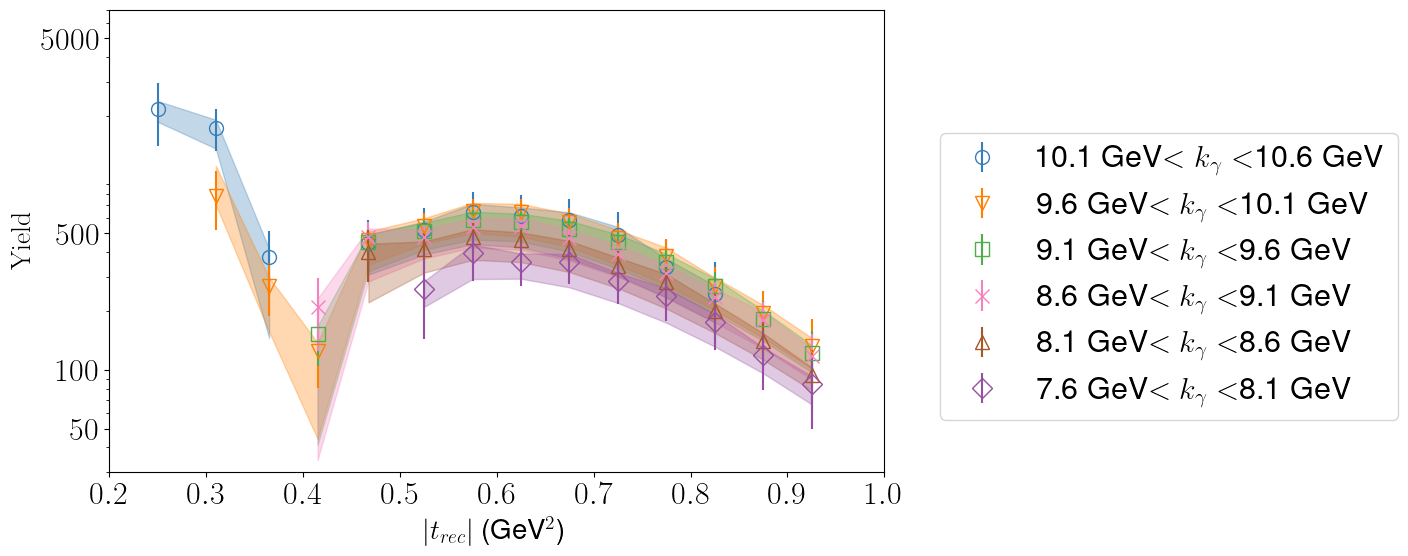

In [349]:
fig, axs = plt.subplots(1, 1, figsize = (10, 6))
hists = 0
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['o', 'v', 's', 'x', '^', 'D']
binwidths  = np.diff(bins)
adjustment = np.array([0]*6)

acceptance_corrected_nevents_rec[3, -1] = 0
for i in [0]:
    draw_cond = (acceptance_corrected_nevents_rec[:, len(egammabins)-i-2]>0) & (bincenters<0.4)
    axs.errorbar    (bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec[:, len(egammabins)-i-2][draw_cond], yerr = acceptance_corrected_nevents_rec_stat_err[:, len(egammabins)-i-2][draw_cond], ls ='', color = colors[i], marker = markers[i], ms = 10, label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<k_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc  = 'none')
    axs.fill_between(bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec_syst_lower[:, len(egammabins)-i-2][draw_cond], acceptance_corrected_nevents_rec_syst_upper[:, len(egammabins)-i-2][draw_cond], color = colors[i], alpha = 0.3)
    draw_cond = (acceptance_corrected_nevents_rec[:, len(egammabins)-i-2]>0) & (bincenters>0.45)
    axs.errorbar    (bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec[:, len(egammabins)-i-2][draw_cond], yerr = acceptance_corrected_nevents_rec_stat_err[:, len(egammabins)-i-2][draw_cond], ls ='', color = colors[i], marker = markers[i], ms = 10, mfc  = 'none')
    axs.fill_between(bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec_syst_lower[:, len(egammabins)-i-2][draw_cond], acceptance_corrected_nevents_rec_syst_upper[:, len(egammabins)-i-2][draw_cond], color = colors[i], alpha = 0.3)

for i in range(1, len(egammabins)-1):
    draw_cond = acceptance_corrected_nevents_rec[:, len(egammabins)-i-2]>0
    # axs.hist(bins[:-1], bins, weights = nevents_rec[:, len(egammabins)-i-2], histtype = 'step', color = colors[i], label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<k_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]))
    axs.errorbar    (bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec[:, len(egammabins)-i-2][draw_cond], yerr = acceptance_corrected_nevents_rec_stat_err[:, len(egammabins)-i-2][draw_cond], ls ='', color = colors[i], marker = markers[i], ms = 10, label = "{} GeV".format(egammabins[len(egammabins)-i-2]) +r"$<k_{\gamma}<$" + "{} GeV".format(egammabins[len(egammabins)-i-1]), mfc  = 'none')
    axs.fill_between(bincenters[draw_cond]+adjustment[i]*binwidths[draw_cond], acceptance_corrected_nevents_rec_syst_lower[:, len(egammabins)-i-2][draw_cond], acceptance_corrected_nevents_rec_syst_upper[:, len(egammabins)-i-2][draw_cond], color = colors[i], alpha = 0.3)
# axs.set_xlim([0.2, 0.925])
# axs.set_xticks(np.linspace(0.2, 0.9, 7+1))
axs.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
# axs.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
axs.set_ylabel("$\mathrm{Yield}$", size = 20)
axs.set_ylim([30, 7000])
# axs.xaxis.set_tick_params(labelsize=12)
# axs.yaxis.set_tick_params(labelsize=12)
# axs.axhline(10, color ='k', ls = '--')
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.94, 0.7))
# axs.set_ylim(bottom = 1)
axs.set_xlim([0.2, 1])
axs.set_xticks(np.linspace(0.2, 1, 8+1))

plt.yscale('log')
axs.set_yticks([50, 100, 500, 5000])
axs.set_yticklabels(["$50$", "$100$", "$500$", "$5000$"])

# plt.tight_layout()
# # plt.show()
plt.savefig("acceptance_corrected_yields.pdf", bbox_inches = 'tight')

In [ ]:
bins_low = bins[:-1]
bins_high = bins[1:]

nevents_rec, _, _ = np.histogram2d(he4.loc[he4.topology].t_smeared, he4.loc[he4.topology].kgamma_smeared, bins = [bins, egammabins], weights = he4.loc[he4.topology].weights)
nevents_gen, _, _ = np.histogram2d(he4.t, he4.kgamma_smeared, bins = [bins, egammabins], weights = he4.gen_weights)
nevents_rec[nevents_rec<8] = 0

n_events_rec_err = np.sqrt(nevents_rec)
n_events_rec_gen = np.sqrt(nevents_gen)


df = pd.DataFrame({"t_low": np.concatenate([bins_low, bins_low[3:], bins_low[5:]])})
df.loc[:, "t_high"] = np.concatenate([bins_high, bins_high[3:], bins_high[5:]])
df.loc[:, "kgamma_low"] = np.concatenate([np.ones(len(bins_low))*9.6, np.ones(len(bins_low[3:]))*8.6, np.ones(len(bins_low[5:]))*7.6])
df.loc[:, "kgamma_high"] = np.concatenate([np.ones(len(bins_low))*10.6, np.ones(len(bins_low[3:]))*9.6, np.ones(len(bins_low[5:]))*8.6])
df.loc[:, "acceptance"] = np.concatenate([acceptance_bin1, acceptance_bin2, acceptance_bin3])
df.loc[:, "accepted_counts"] = np.concatenate([count_bin1, count_bin2, count_bin3])

bin_property_array = [bin_properties(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high) for i in range(len(df))]
tlim_1, tlim_2, egamma_lim_1, egamma_lim_2, binsize, t_average, egamma_average, cross_section_within_bin, cross_section_at_bin_average  = np.array(bin_property_array).T


df.loc[:, "t_physical"]  = t_average# [bin_average(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[0] for i in range(len(df))]#(df.t_low + df.t_high)/2.
df.loc[:, "kgamma_physical"]  = egamma_average# [bin_average(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[1] for i in range(len(df))]
df.loc[:, "W2"] = W_from_egamma(df.kgamma_physical, mHe4)**2
df.loc[:, "t_physical_low"]  = tlim_1#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[0] for i in range(len(df))]
df.loc[:, "t_physical_high"] = tlim_2#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[1] for i in range(len(df))]
df.loc[:, "kgamma_physical_low"]  = egamma_lim_1#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[0] for i in range(len(df))]
df.loc[:, "kgamma_physical_high"] = egamma_lim_2#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[1] for i in range(len(df))]
df.loc[:, "N_EPA"] = [ N_EPA(10.604, Eg, 1) for Eg in df.kgamma_physical]
df.loc[:, "dsigmadt_nominal"] = cross_section_at_bin_average#dsigma_dt(df.W2, -(df.t_low + df.t_high)/2., mHe4, mJpsi)
df.loc[:, "finite_volume"] = cross_section_within_bin/cross_section_at_bin_average
df.loc[:, "bin_volume"] = binsize#[binsize(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high) for i in range(len(df))]
df.loc[:, "integrated_luminosity"] = desired_lumi
df.loc[:, "efficiency"] = efficiency

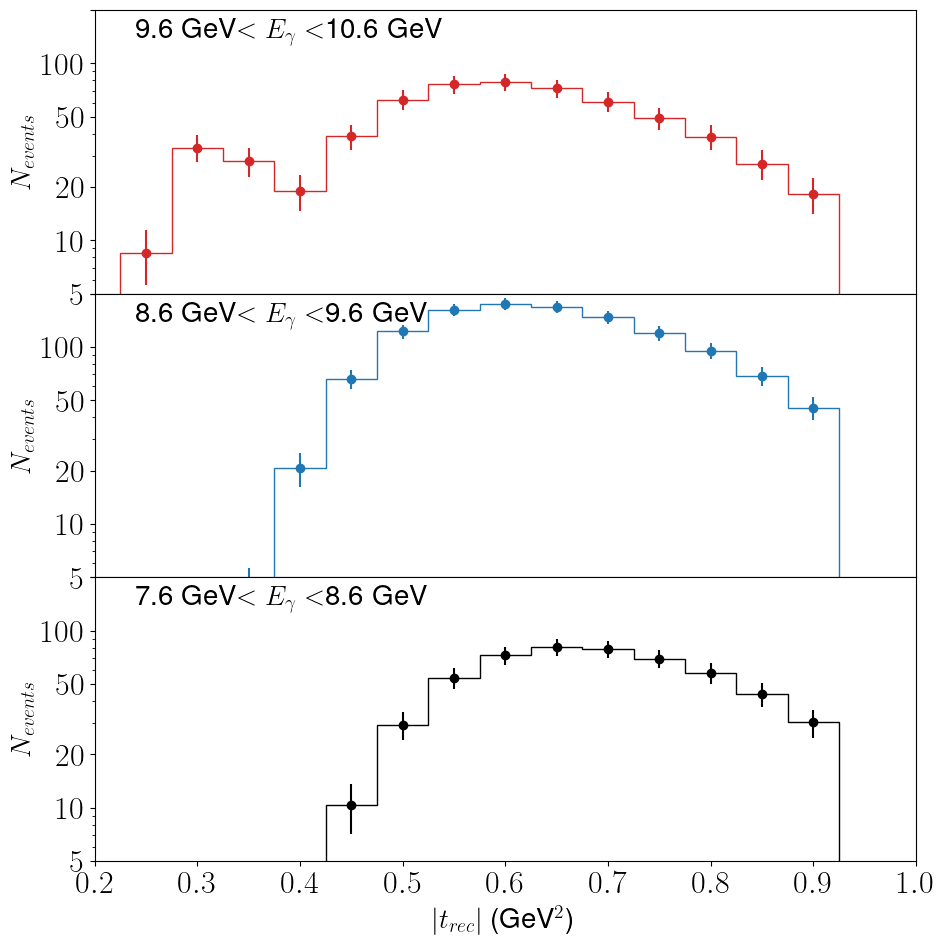

In [939]:
# bins = [0.25, 0.3, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]#[0.15, 0.25, 0.35, 0.45, 0.55, 0.75, 0.9, 1.1]
# bins = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]#[0.15, 0.25, 0.35, 0.45, 0.55, 0.75, 0.9, 1.1]
# bins = np.linspace(0.2, 1, 20+1)
# bins = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
desired_lumi = 4.5e8
efficiency = 0.85
nbins = 14
bins = np.linspace(0.225, 0.925, nbins + 1)
bincenters = (bins[:-1] + bins[1:])/2.


# desired_lumi = integrated_lumi_approved#2e8
he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*desired_lumi * efficiency *total_xsec
he4.loc[:, "gen_weights"] = np.ones(len(he4))/len(he4)*desired_lumi * efficiency *total_xsec
he4.loc[he4.topology_2 & (he4.decay_channel =="electron"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="electron")])) * desired_lumi * efficiency * accepted_xsec_electron / len(he4.loc[he4.decay_channel =="electron"])
he4.loc[he4.topology_2 & (he4.decay_channel =="muon"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="muon")])) * desired_lumi * efficiency * accepted_xsec_muon / len(he4.loc[he4.decay_channel =="muon"])

fig, axs = plt.subplots(3, 1, figsize = (10, 10))

Egmin = 9.6
Egmax = 10.6

e_gamma_cond = (he4.kgamma_smeared<Egmax) & (he4.kgamma_smeared>Egmin)
acceptance_egamma_cond = he4.topology & e_gamma_cond

hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')
axs[0].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:red' )#, label = 'With\n diffraction minimum')
axs[0].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

count_bin1 = hist

Egmin = 8.6
Egmax = 9.6

e_gamma_cond = (he4.kgamma_smeared<Egmax) & (he4.kgamma_smeared>Egmin)
acceptance_egamma_cond = he4.topology & e_gamma_cond

hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')
axs[1].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue' , label = 'With\n diffraction minimum')
axs[1].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

count_bin2 = hist[3:]


Egmin = 7.6
Egmax = 8.6

e_gamma_cond = (he4.kgamma_smeared<Egmax) & (he4.kgamma_smeared>Egmin)
acceptance_egamma_cond = he4.topology & e_gamma_cond

hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
axs[2].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'k')
axs[2].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'k' , label = 'With\n diffraction minimum')
axs[2].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

count_bin3 = hist[5:]

for ax in axs.flatten():
    # ax.set_xlim([0.1, 1.1])
    ax.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
    # ax.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
    ax.set_ylabel(r"$N_{events}$", size = 20)
    # ax.xaxis.set_tick_params(labelsize=12)
    # ax.yaxis.set_tick_params(labelsize=12)
    ax.set_ylim([5, 200])
    ax.set_xlim([0.25, 0.95])
    ax.set_xticks(np.linspace(0.2, 1, 8+1))
    ax.set_yscale('log')
    ax.set_yticks([5, 10, 20, 50, 100, 200])
    ax.set_yticklabels(['$5$', '$10$', '$20$', '$50$', '$100$', ''])
    ax.get_xaxis().set_visible(False)
axs[-1].get_xaxis().set_visible(True)

# axs[0].set_ylim(top = 30)
# axs[1].set_yticks([0, 10, 20, 30])

# axs[1].set_ylim(top = 90)
# axs[1].set_yticks([0, 20, 40, 60, 80])
# plt.figlegend(loc= 'upper left', bbox_to_anchor = (0.93, 0.6))
plt.tight_layout()
plt.subplots_adjust(hspace = 0)

plt.savefig("detector_level_accepted_counts.pdf")


In [66]:
bins_low = bins[:-1]
bins_high = bins[1:]

nevents_rec, _, _ = np.histogram2d(he4.loc[he4.topology].t_smeared, he4.loc[he4.topology].kgamma_smeared, bins = [bins, egammabins], weights = he4.loc[he4.topology].weights)
nevents_gen, _, _ = np.histogram2d(he4.t, he4.kgamma_smeared, bins = [bins, egammabins], weights = he4.gen_weights)
nevents_rec[nevents_rec<8] = 0

n_events_rec_err = np.sqrt(nevents_rec)
n_events_rec_gen = np.sqrt(nevents_gen)


df = pd.DataFrame({"t_low": np.concatenate([bins_low, bins_low[3:], bins_low[5:]])})
df.loc[:, "t_high"] = np.concatenate([bins_high, bins_high[3:], bins_high[5:]])
df.loc[:, "kgamma_low"] = np.concatenate([np.ones(len(bins_low))*9.6, np.ones(len(bins_low[3:]))*8.6, np.ones(len(bins_low[5:]))*7.6])
df.loc[:, "kgamma_high"] = np.concatenate([np.ones(len(bins_low))*10.6, np.ones(len(bins_low[3:]))*9.6, np.ones(len(bins_low[5:]))*8.6])
df.loc[:, "acceptance"] = np.concatenate([acceptance_bin1, acceptance_bin2, acceptance_bin3])
df.loc[:, "accepted_counts"] = np.concatenate([count_bin1, count_bin2, count_bin3])

bin_property_array = [bin_properties(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high) for i in range(len(df))]
tlim_1, tlim_2, egamma_lim_1, egamma_lim_2, binsize, t_average, egamma_average, cross_section_within_bin, cross_section_at_bin_average  = np.array(bin_property_array).T


df.loc[:, "t_physical"]  = t_average# [bin_average(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[0] for i in range(len(df))]#(df.t_low + df.t_high)/2.
df.loc[:, "kgamma_physical"]  = egamma_average# [bin_average(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[1] for i in range(len(df))]
df.loc[:, "W2"] = W_from_egamma(df.kgamma_physical, mHe4)**2
df.loc[:, "t_physical_low"]  = tlim_1#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[0] for i in range(len(df))]
df.loc[:, "t_physical_high"] = tlim_2#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[1] for i in range(len(df))]
df.loc[:, "kgamma_physical_low"]  = egamma_lim_1#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[0] for i in range(len(df))]
df.loc[:, "kgamma_physical_high"] = egamma_lim_2#[egamma_range(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high)[1] for i in range(len(df))]
df.loc[:, "N_EPA"] = [ N_EPA(10.604, Eg, 1) for Eg in df.kgamma_physical]
df.loc[:, "dsigmadt_nominal"] = cross_section_at_bin_average#dsigma_dt(df.W2, -(df.t_low + df.t_high)/2., mHe4, mJpsi)
df.loc[:, "finite_volume"] = cross_section_within_bin/cross_section_at_bin_average
df.loc[:, "bin_volume"] = binsize#[binsize(df.iloc[i].t_low, df.iloc[i].t_high, df.iloc[i].kgamma_low, df.iloc[i].kgamma_high) for i in range(len(df))]
df.loc[:, "integrated_luminosity"] = desired_lumi
df.loc[:, "efficiency"] = efficiency

In [67]:
# df.to_csv("he4_jpsi_projection.csv", float_format='%.3f')
df.loc[:, ["counts_{}".format(i) for i in range(1, 11)]] = pd.read_csv("he4_jpsi_projection.csv").loc[:, ["counts_{}".format(i) for i in range(1, 11)]]

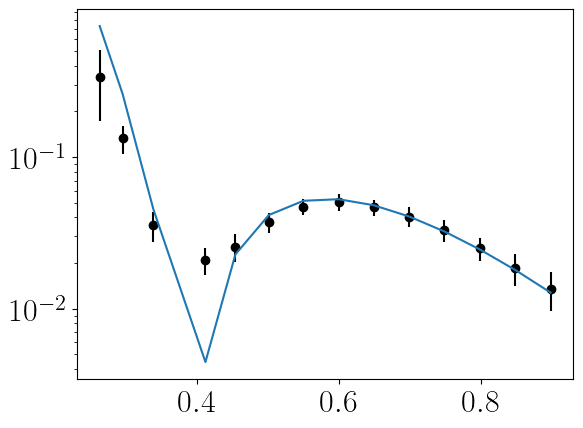

In [68]:
Egmin =  9.6
plt.errorbar(df.loc[df.kgamma_low==Egmin].t_physical, df.loc[df.kgamma_low==Egmin].accepted_counts/df.loc[df.kgamma_low==Egmin].bin_volume/df.loc[df.kgamma_low==Egmin].N_EPA/df.loc[df.kgamma_low==Egmin].acceptance/ df.loc[df.kgamma_low==Egmin].integrated_luminosity/df.loc[df.kgamma_low==Egmin].efficiency/df.loc[df.kgamma_low==Egmin].finite_volume, yerr =np.sqrt(df.loc[df.kgamma_low==Egmin].counts_4)/df.loc[df.kgamma_low==Egmin].bin_volume/df.loc[df.kgamma_low==Egmin].N_EPA/df.loc[df.kgamma_low==Egmin].acceptance/ df.loc[df.kgamma_low==Egmin].integrated_luminosity/df.loc[df.kgamma_low==Egmin].efficiency, ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
plt.errorbar(df.loc[df.kgamma_low==Egmin].t_physical, dsigma_dt(df.loc[df.kgamma_low==Egmin].W2, -df.loc[df.kgamma_low==Egmin].t_physical, mHe4, mJpsi))
plt.yscale('log')
# plt.xlim([0.27, 0.9])
plt.show()

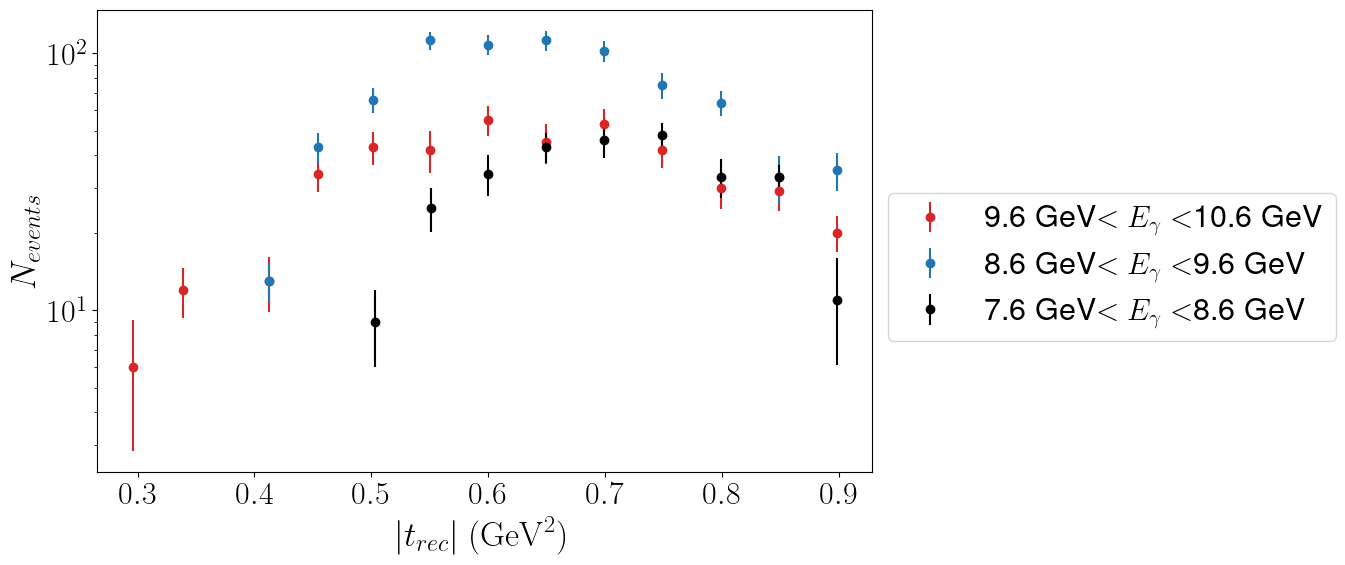

In [69]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
Egmin =  9.6
Egmax = 10.6
df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]

plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4
             , yerr =np.sqrt(df_this_bin.counts_3)
             , ls = '', marker = 'o', color = 'tab:red' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )

Egmin =  8.6
Egmax =  9.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4
             , yerr =np.sqrt(df_this_bin.counts_3)
             , ls = '', marker = 'o', color = 'tab:blue' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )



Egmin =  7.6
Egmax =  8.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4
             , yerr =np.sqrt(df_this_bin.counts_3)
             , ls = '', marker = 'o', color = 'black' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'b')

plt.yscale('log')
# plt.xlim([0.27, 0.9])
# plt.ylim([10**-3, 2*10**-1])
# plt.ylabel(r"$G(t)^2$")
ax.set_ylabel(r"$N_{events}$")

plt.xlabel("$|t_{rec}|~(\mathrm{GeV}^2)$") 
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.6))
plt.savefig("projection_counts_4.pdf", bbox_inches = 'tight')

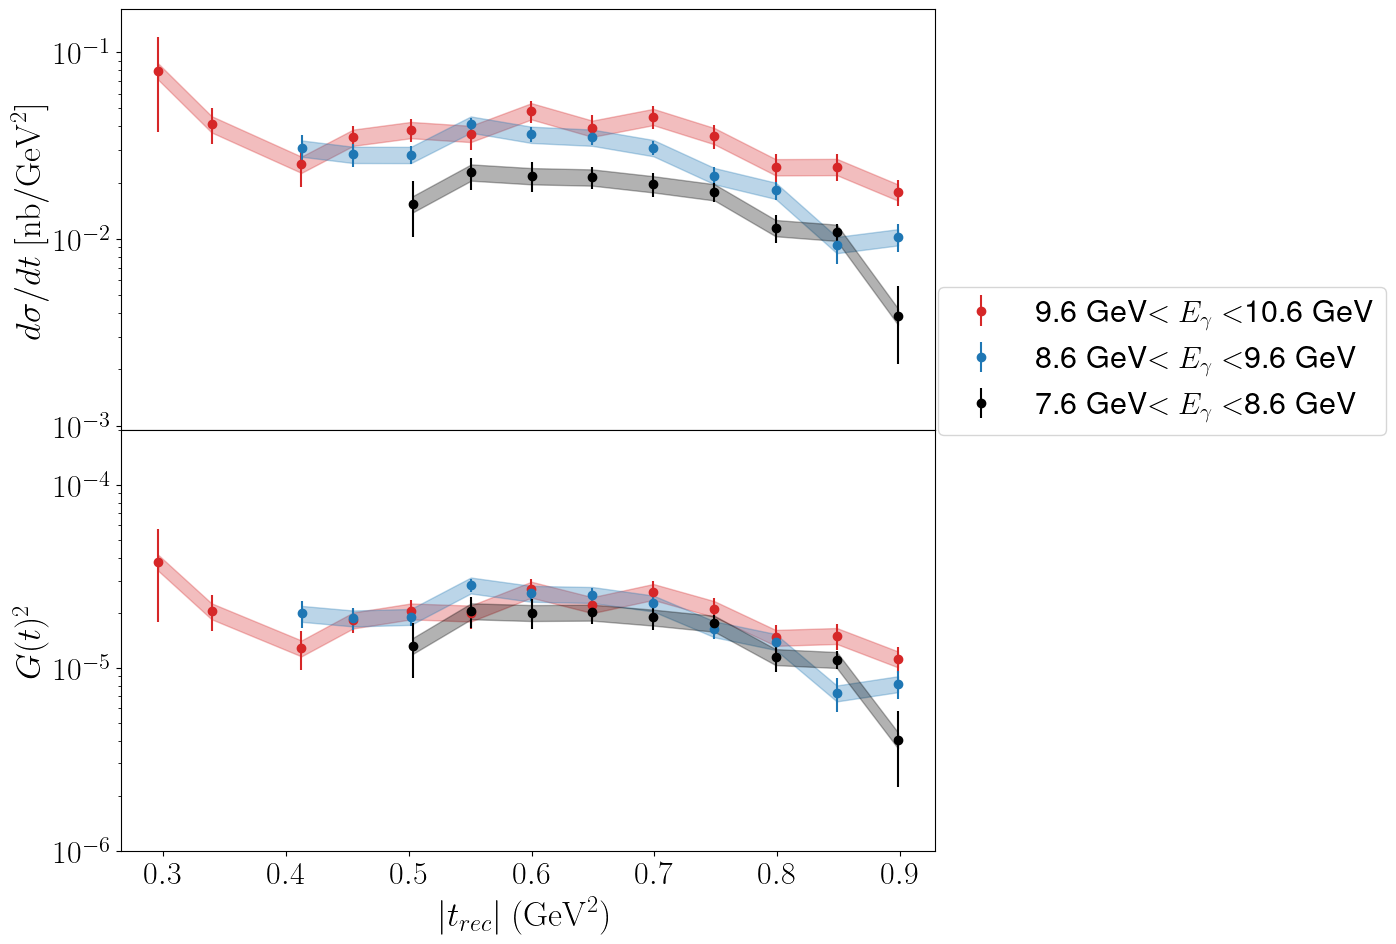

In [108]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
Egmin =  9.6
Egmax = 10.6
df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
prefactors = prefactor(df_this_bin.W2, -df_this_bin.t_physical, mHe4, mJpsi)
denominator_xsec = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume * prefactors

ax[0].errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator_xsec
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator_xsec
             , ls = '', marker = 'o', color = 'tab:red' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
ax[0].fill_between(df_this_bin.t_physical, df_this_bin.counts_4/denominator_xsec*0.9, df_this_bin.counts_4/denominator_xsec*1.1, color = 'tab:red', alpha = 0.3)
ax[1].errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'tab:red')# , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
ax[1].fill_between(df_this_bin.t_physical, df_this_bin.counts_4/denominator*0.9, df_this_bin.counts_4/denominator*1.1, color = 'tab:red', alpha = 0.3)
# ax[1].errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )

Egmin =  8.6
Egmax =  9.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
prefactors = prefactor(df_this_bin.W2, -df_this_bin.t_physical, mHe4, mJpsi)
denominator_xsec = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume * prefactors

ax[0].errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator_xsec
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator_xsec
             , ls = '', marker = 'o', color = 'tab:blue' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
ax[0].fill_between(df_this_bin.t_physical, df_this_bin.counts_4/denominator_xsec*0.9, df_this_bin.counts_4/denominator_xsec*1.1, color = 'tab:blue', alpha = 0.3)

ax[1].errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'tab:blue' )#, label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
ax[1].fill_between(df_this_bin.t_physical, df_this_bin.counts_4/denominator*0.9, df_this_bin.counts_4/denominator*1.1, color = 'tab:blue', alpha = 0.3)
# ax[1].errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )



Egmin =  7.6
Egmax =  8.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
prefactors = prefactor(df_this_bin.W2, -df_this_bin.t_physical, mHe4, mJpsi)
denominator_xsec = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume * prefactors
ax[0].errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator_xsec
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator_xsec
             , ls = '', marker = 'o', color = 'k' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
ax[0].fill_between(df_this_bin.t_physical, df_this_bin.counts_4/denominator_xsec*0.9, df_this_bin.counts_4/denominator_xsec*1.1, color = 'k', alpha = 0.3)

ax[1].errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'k')# , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
ax[1].fill_between(df_this_bin.t_physical, df_this_bin.counts_4/denominator*0.9, df_this_bin.counts_4/denominator*1.1, color = 'k', alpha = 0.3)
# ax[1].errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'b')


ax[0].set_yscale('log')
# ax[0].set_xlim([0.27, 0.9])
ax[0].set_ylim([0.95*10**-3, 1.7*10**-1])
# ax[0].set_ylabel(r"$G(t)^2$")
ax[0].set_ylabel(r"$d\sigma/dt~[\mathrm{nb}/\mathrm{GeV}^2]$")

ax[1].set_yscale('log')
# ax[1].set_xlim([0.27, 0.9])
ax[1].set_ylim([10**-6, 2*10**-4])
ax[1].set_ylabel(r"$G(t)^2$")
ax[1].set_xlabel("$|t_{rec}|~(\mathrm{GeV}^2)$") 
plt.tight_layout()
plt.subplots_adjust(hspace = 0)
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.95, 0.7))

plt.savefig("projection_all.pdf", bbox_inches = 'tight')

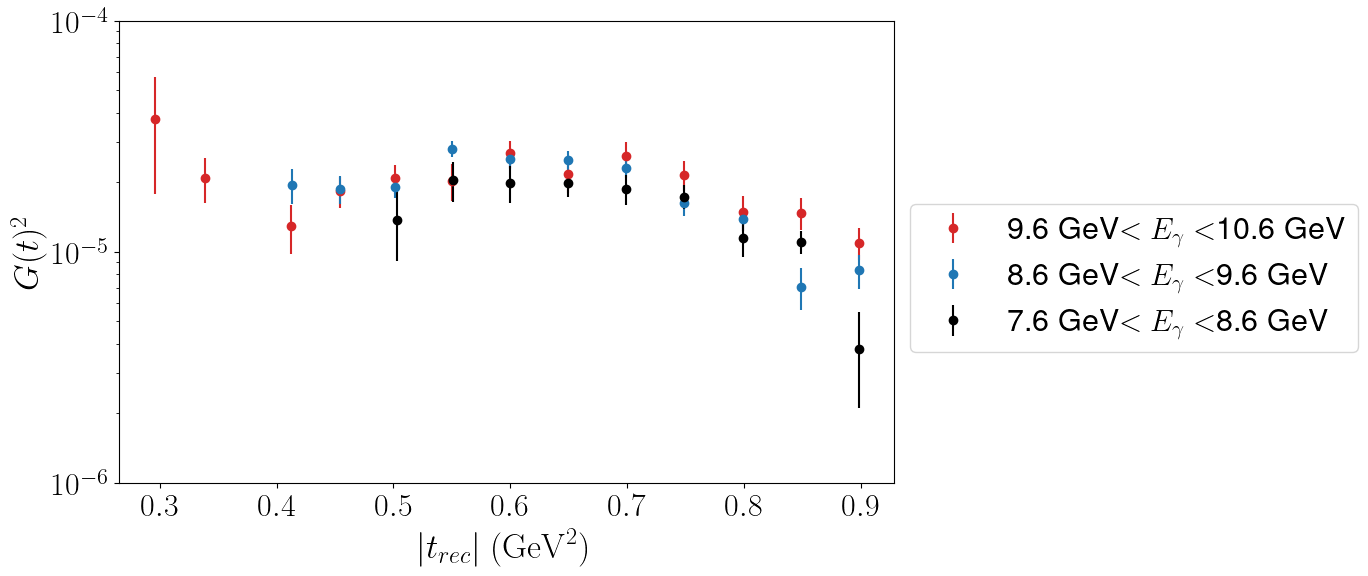

In [1090]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
Egmin =  9.6
Egmax = 10.6
df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
prefactors = prefactor(df_this_bin.W2, -df_this_bin.t_physical, mHe4, mJpsi)
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume * prefactors

plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'tab:red' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )

Egmin =  8.6
Egmax =  9.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
prefactors = prefactor(df_this_bin.W2, -df_this_bin.t_physical, mHe4, mJpsi)
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume * prefactors
plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'tab:blue' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )



Egmin =  7.6
Egmax =  8.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
prefactors = prefactor(df_this_bin.W2, -df_this_bin.t_physical, mHe4, mJpsi)
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume * prefactors
plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'k' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'b')

plt.yscale('log')
# plt.xlim([0.27, 0.9])
plt.ylim([10**-6, 10**-4])
plt.ylabel(r"$G(t)^2$")
plt.xlabel("$|t_{rec}|~(\mathrm{GeV}^2)$") 
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.6))
plt.savefig("projection_Gt.pdf", bbox_inches = 'tight')

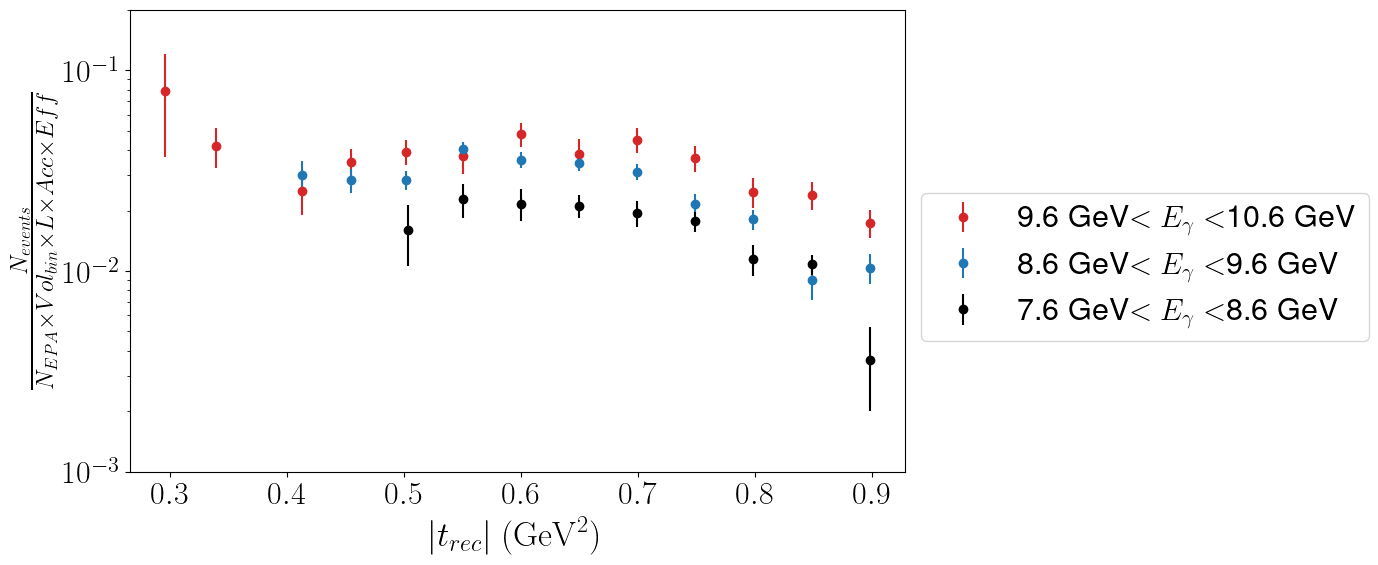

In [1091]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
Egmin =  9.6
Egmax = 10.6
df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume

plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'tab:red' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )

Egmin =  8.6
Egmax =  9.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume
plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'tab:blue' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )



Egmin =  7.6
Egmax =  8.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume
plt.errorbar(df_this_bin.t_physical,
             df_this_bin.counts_4/denominator
             , yerr =np.sqrt(df_this_bin.counts_3)/denominator
             , ls = '', marker = 'o', color = 'black' , label = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax))
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'k' )
# plt.errorbar(df_this_bin.t_physical, scalar_GFF2(df_this_bin.W2, df_this_bin.t_physical, mHe4, mJpsi), color = 'b')

plt.yscale('log')
# plt.xlim([0.27, 0.9])
plt.ylim([10**-3, 2*10**-1])
# plt.ylabel(r"$G(t)^2$")
ax.set_ylabel(r"$\frac{N_{events}}{N_{EPA}\times Vol_{bin} \times L \times Acc \times Eff}$")

plt.xlabel("$|t_{rec}|~(\mathrm{GeV}^2)$") 
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.6))
plt.savefig("projection_xsec.pdf", bbox_inches = 'tight')

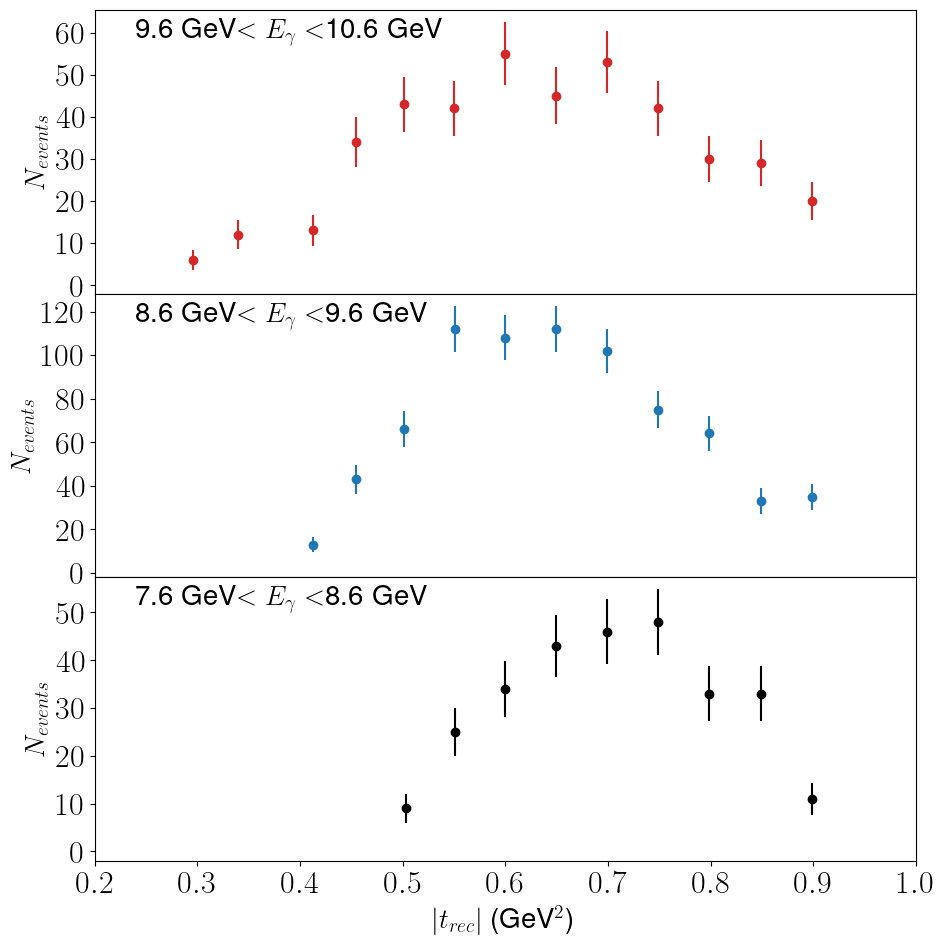

In [1093]:
fig, axs = plt.subplots(3, 1, figsize = (10, 10))

Egmin = 9.6
Egmax = 10.6

axs[0].errorbar(df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].t_physical, df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].counts_4, yerr =np.sqrt(df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].counts_4), ls = '', marker = 'o', color = 'tab:red' )#, label = 'With\n diffraction minimum')
axs[0].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

count_bin1 = hist

Egmin = 8.6
Egmax = 9.6

axs[1].errorbar(df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].t_physical, df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].counts_4, yerr =np.sqrt(df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].counts_4), ls = '', marker = 'o', color = 'tab:blue' )#, label = 'With\n diffraction minimum')
axs[1].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)


Egmin = 7.6
Egmax = 8.6

axs[2].errorbar(df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].t_physical, df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].counts_4, yerr =np.sqrt(df.loc[(df.kgamma_low==Egmin) & (df.t_physical>0.27)].counts_4), ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[2].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

count_bin3 = hist[5:]

for ax in axs.flatten():
    # ax.set_xlim([0.1, 1.1])
    ax.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
    ax.set_ylabel(r"$N_{events}$", size = 20)
    ax.set_ylim(bottom = -2)
    ax.set_xlim([0.25, 0.95])
    ax.set_xticks(np.linspace(0.2, 1, 8+1))
    # ax.set_yscale('log')
    ax.get_xaxis().set_visible(False)
axs[-1].get_xaxis().set_visible(True)
axs[0].set_yticks([0, 10, 20, 30, 40, 50, 60], ['$0$', '$10$', '$20$', '$30$','$40$', '$50$', '$60$'])
axs[1].set_yticks([0, 20, 40, 60, 80, 100, 120], ['$0$', '$20$', '$40$', '$60$', '$80$', '$100$', '$120$'])
axs[2].set_yticks([0, 10, 20, 30, 40, 50], ['$0$', '$10$', '$20$', '$30$', '$40$', '$50$'])
# axs[0].set_ylim(top = 30)
# axs[1].set_yticks([0, 10, 20, 30])

# axs[1].set_ylim(top = 90)
# axs[1].set_yticks([0, 20, 40, 60, 80])
# plt.figlegend(loc= 'upper left', bbox_to_anchor = (0.93, 0.6))
plt.tight_layout()
plt.subplots_adjust(hspace = 0)

plt.savefig("projection_detector_level_counts_4.pdf")


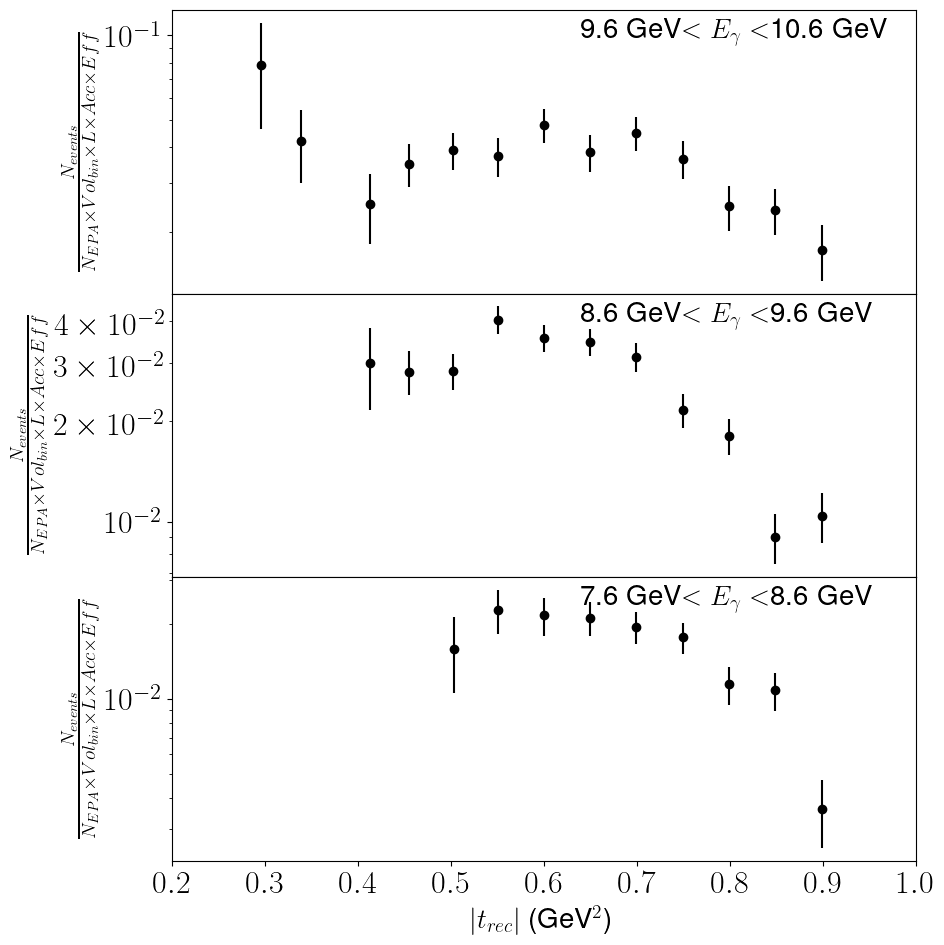

In [1060]:
fig, axs = plt.subplots(3, 1, figsize = (10, 10))

Egmin = 9.6
Egmax = 10.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume

axs[0].errorbar(df_this_bin.t_physical, df_this_bin.counts_4/denominator, yerr =np.sqrt(df_this_bin.counts_4)/denominator, ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[0].annotate(xytext = (0.55, 0.9), xy = (0.55, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
# axs[0].errorbar(df.loc[df.kgamma_low==Egmin].t_physical, df.loc[df.kgamma_low==Egmin].accepted_counts/df.loc[df.kgamma_low==Egmin].bin_volume/df.loc[df.kgamma_low==Egmin].N_EPA/df.loc[df.kgamma_low==Egmin].acceptance/ df.loc[df.kgamma_low==Egmin].integrated_luminosity/df.loc[df.kgamma_low==Egmin].efficiency, ls = '', yerr = np.sqrt(df.loc[df.kgamma_low==Egmin].counts_4)/df.loc[df.kgamma_low==Egmin].bin_volume/df.loc[df.kgamma_low==Egmin].N_EPA/df.loc[df.kgamma_low==Egmin].acceptance/ df.loc[df.kgamma_low==Egmin].integrated_luminosity/df.loc[df.kgamma_low==Egmin].efficiency, marker = 'o')

count_bin1 = hist

Egmin = 8.6
Egmax = 9.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume

axs[1].errorbar(df_this_bin.t_physical, df_this_bin.counts_4/denominator, yerr =np.sqrt(df_this_bin.counts_4)/denominator, ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[1].annotate(xytext = (0.55, 0.9), xy = (0.55, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)


Egmin = 7.6
Egmax = 8.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume

axs[2].errorbar(df_this_bin.t_physical, df_this_bin.counts_4/denominator, yerr =np.sqrt(df_this_bin.counts_4)/denominator, ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[2].annotate(xytext = (0.55, 0.9), xy = (0.55, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

count_bin3 = hist[5:]

for ax in axs.flatten():
    # ax.set_xlim([0.1, 1.1])
    ax.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
    ax.set_ylabel(r"$\frac{N_{events}}{N_{EPA}\times Vol_{bin} \times L \times Acc \times Eff}$", size = 20)
    # ax.set_ylim(bottom = -2)
    ax.set_xlim([0.25, 0.95])
    ax.set_xticks(np.linspace(0.2, 1, 8+1))
    ax.set_yscale('log')
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([
axs[-1].get_xaxis().set_visible(True)
# axs[0].set_yticks([0, 20, 40, 60], ['$0, '$20$', '$40$', '$60$'])
# axs[1].set_yticks([0, 20, 40, 60, 80, 100, 120], ['', '$20$', '$40$', '$60$', '$80$', '$100$', '$120$'])
# axs[2].set_yticks([0, 10, 20, 30, 40, 50], ['$0$', '$10$', '$20$', '$30$', '$40$', '$50$'])
# axs[0].set_ylim(top = 30)
# axs[1].set_yticks([0, 10, 20, 30])

# axs[1].set_ylim(top = 90)
# axs[1].set_yticks([0, 20, 40, 60, 80])
# plt.figlegend(loc= 'upper left', bbox_to_anchor = (0.93, 0.6))
plt.tight_layout()
plt.subplots_adjust(hspace = 0)

plt.savefig("projected_xsec_counts_4.pdf")


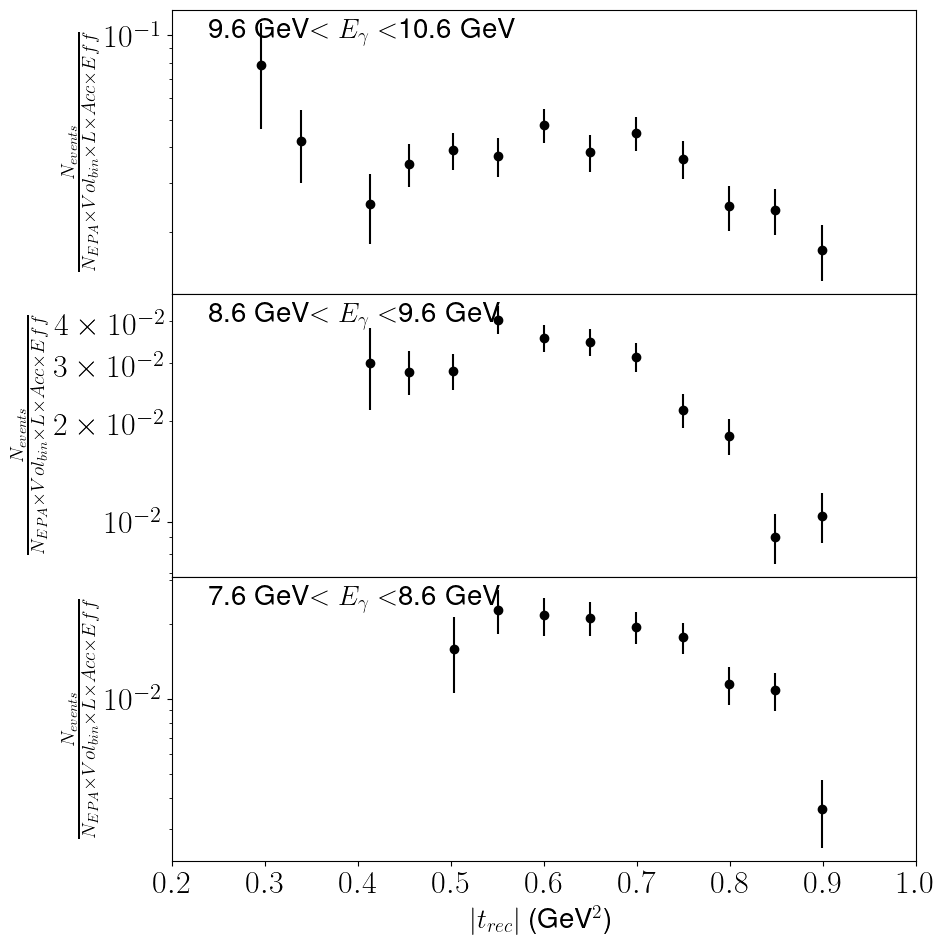

In [1054]:
fig, axs = plt.subplots(3, 1, figsize = (10, 10))

Egmin = 9.6
Egmax = 10.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume

axs[0].errorbar(df_this_bin.t_physical, df_this_bin.counts_4/denominator, yerr =np.sqrt(df_this_bin.counts_4)/denominator, ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[0].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
# axs[0].errorbar(df.loc[df.kgamma_low==Egmin].t_physical, df.loc[df.kgamma_low==Egmin].accepted_counts/df.loc[df.kgamma_low==Egmin].bin_volume/df.loc[df.kgamma_low==Egmin].N_EPA/df.loc[df.kgamma_low==Egmin].acceptance/ df.loc[df.kgamma_low==Egmin].integrated_luminosity/df.loc[df.kgamma_low==Egmin].efficiency, ls = '', yerr = np.sqrt(df.loc[df.kgamma_low==Egmin].counts_4)/df.loc[df.kgamma_low==Egmin].bin_volume/df.loc[df.kgamma_low==Egmin].N_EPA/df.loc[df.kgamma_low==Egmin].acceptance/ df.loc[df.kgamma_low==Egmin].integrated_luminosity/df.loc[df.kgamma_low==Egmin].efficiency, marker = 'o')

count_bin1 = hist

Egmin = 8.6
Egmax = 9.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume

axs[1].errorbar(df_this_bin.t_physical, df_this_bin.counts_4/denominator, yerr =np.sqrt(df_this_bin.counts_4)/denominator, ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[1].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)


Egmin = 7.6
Egmax = 8.6

df_this_bin = df.loc[(df.t_physical>0.27 ) & (df.kgamma_low==Egmin)]
denominator = df_this_bin.bin_volume * df_this_bin.N_EPA * df_this_bin.acceptance * df_this_bin.integrated_luminosity * df_this_bin.efficiency * df_this_bin.finite_volume

axs[2].errorbar(df_this_bin.t_physical, df_this_bin.counts_4/denominator, yerr =np.sqrt(df_this_bin.counts_4)/denominator, ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[2].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

count_bin3 = hist[5:]

for ax in axs.flatten():
    # ax.set_xlim([0.1, 1.1])
    ax.set_xlabel(r"$|t_{rec}|$" + " (GeV"+r"$^2$"+")", size = 20)
    ax.set_ylabel(r"$\frac{N_{events}}{N_{EPA}\times Vol_{bin} \times L \times Acc \times Eff}$", size = 20)
    # ax.set_ylim(bottom = -2)
    ax.set_xlim([0.25, 0.95])
    ax.set_xticks(np.linspace(0.2, 1, 8+1))
    ax.set_yscale('log')
    ax.get_xaxis().set_visible(False)
axs[-1].get_xaxis().set_visible(True)
# axs[0].set_yticks([0, 20, 40, 60], ['$0, '$20$', '$40$', '$60$'])
# axs[1].set_yticks([0, 20, 40, 60, 80, 100, 120], ['', '$20$', '$40$', '$60$', '$80$', '$100$', '$120$'])
# axs[2].set_yticks([0, 10, 20, 30, 40, 50], ['$0$', '$10$', '$20$', '$30$', '$40$', '$50$'])
# axs[0].set_ylim(top = 30)
# axs[1].set_yticks([0, 10, 20, 30])

# axs[1].set_ylim(top = 90)
# axs[1].set_yticks([0, 20, 40, 60, 80])
# plt.figlegend(loc= 'upper left', bbox_to_anchor = (0.93, 0.6))
plt.tight_layout()
plt.subplots_adjust(hspace = 0)

plt.savefig("projected_xsec_counts_4.pdf")


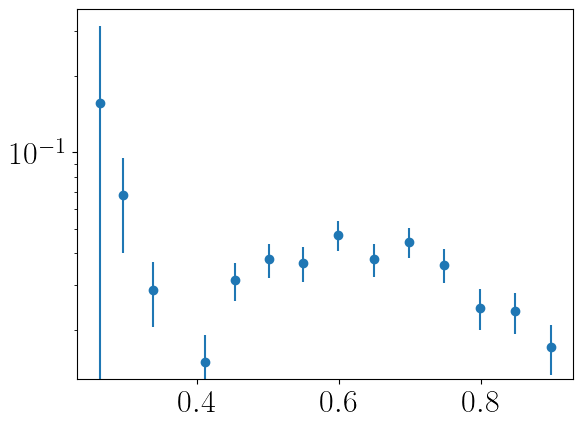

In [1001]:
kgamma_low = 9.6
plt.errorbar(df.loc[df.kgamma_low==kgamma_low].t_physical, df.loc[df.kgamma_low==kgamma_low].counts_4/df.loc[df.kgamma_low==kgamma_low].bin_volume/df.loc[df.kgamma_low==kgamma_low].N_EPA/df.loc[df.kgamma_low==kgamma_low].acceptance/ df.loc[df.kgamma_low==kgamma_low].integrated_luminosity/df.loc[df.kgamma_low==kgamma_low].efficiency, ls = '', yerr = np.sqrt(df.loc[df.kgamma_low==kgamma_low].counts_4)/df.loc[df.kgamma_low==kgamma_low].bin_volume/df.loc[df.kgamma_low==kgamma_low].N_EPA/df.loc[df.kgamma_low==kgamma_low].acceptance/ df.loc[df.kgamma_low==kgamma_low].integrated_luminosity/df.loc[df.kgamma_low==kgamma_low].efficiency, marker = 'o')
plt.yscale('log')

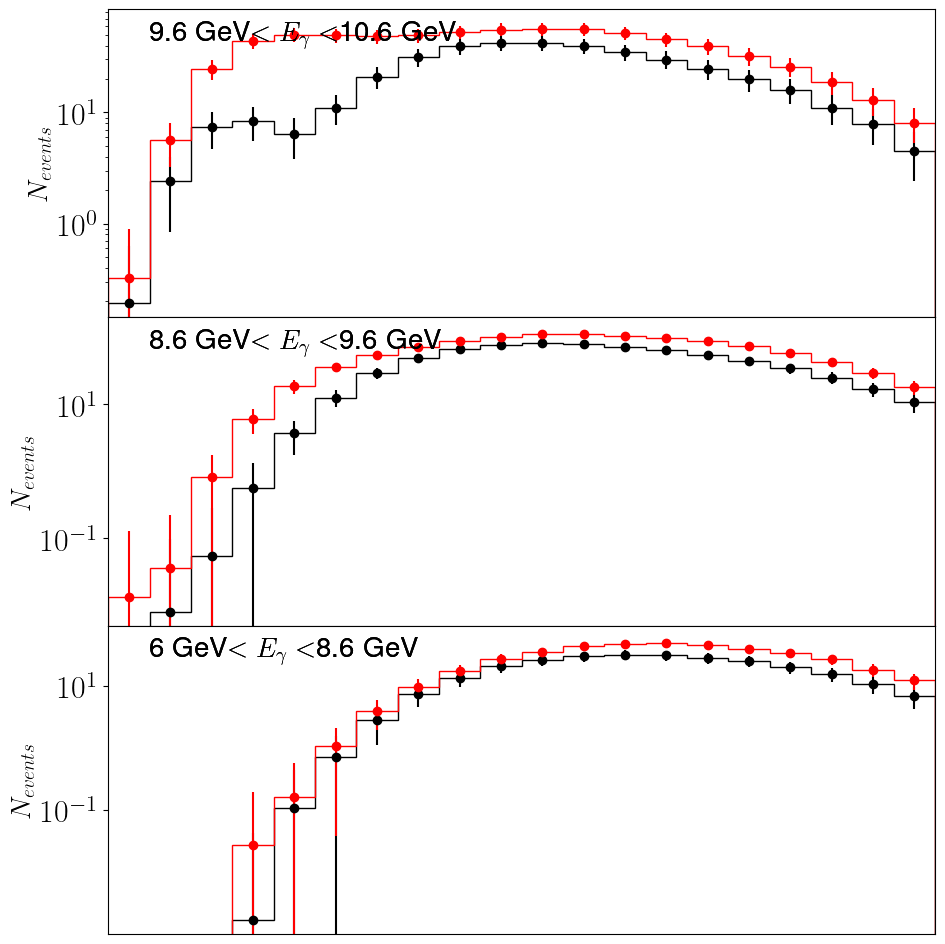

In [1003]:
# bins = [0.25, 0.3, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]#[0.15, 0.25, 0.35, 0.45, 0.55, 0.75, 0.9, 1.1]
# bins = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]#[0.15, 0.25, 0.35, 0.45, 0.55, 0.75, 0.9, 1.1]
# bins = np.linspace(0.2, 1, 20+1)
# bins = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
desired_lumi = 3.5e8
# bins = np.array(bins)
bins = np.linspace(0.2, 1, 20+1)
bincenters = (bins[:-1] + bins[1:])/2.


# desired_lumi = integrated_lumi_approved#2e8
he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec
he4.loc[:, "gen_weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec
he4.loc[he4.topology_2 & (he4.decay_channel =="electron"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="electron")])) * desired_lumi * accepted_xsec_electron / len(he4.loc[he4.decay_channel =="electron"])
he4.loc[he4.topology_2 & (he4.decay_channel =="muon"), "weights"] = np.ones(len(he4.loc[he4.topology_2 & (he4.decay_channel =="muon")])) * desired_lumi * accepted_xsec_muon / len(he4.loc[he4.decay_channel =="muon"])

fig, axs = plt.subplots(3, 1, figsize = (10, 10))

hists = 0

Egmin = 9.6
Egmax = 10.6

e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
acceptance_egamma_cond = he4.topology & e_gamma_cond

hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
hist = hist.astype(float)
hists = hists + hist
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'k')
axs[0].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'k' )#, label = 'With\n diffraction minimum')
axs[0].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)


e_gamma_cond = (10.604-scattered_e_modified.e<Egmax) & (10.604-scattered_e_modified.e>Egmin)
acceptance_egamma_cond = he4_modified.topology & e_gamma_cond

hist, bins = np.histogram(he4_modified.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4_modified.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4_modified.loc[e_gamma_cond, :].t, bins = bins, weights = he4_modified.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
hist = hist.astype(float)
hists = hists + hist
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'r')
axs[0].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'r' )#, label = 'With\n diffraction minimum')
axs[0].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)


Egmin = 8.6
Egmax = 9.6

e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
acceptance_egamma_cond = he4.topology & e_gamma_cond

hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
hist = hist.astype(float)
hists = hists + hist
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'k')
axs[1].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'k' , label = 'With\n diffraction minimum')
axs[1].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

e_gamma_cond = (10.604-scattered_e_modified.e<Egmax) & (10.604-scattered_e_modified.e>Egmin)
acceptance_egamma_cond = he4_modified.topology & e_gamma_cond

hist, bins = np.histogram(he4_modified.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4_modified.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4_modified.loc[e_gamma_cond, :].t, bins = bins, weights = he4_modified.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
hist = hist.astype(float)
hists = hists + hist
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'r')
axs[1].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'r' )#, label = 'With\n diffraction minimum')
axs[1].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

Egmin = 6
Egmax = 8.6

e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
acceptance_egamma_cond = he4.topology & e_gamma_cond

hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
hist = hist.astype(float)
hists = hists + hist
axs[2].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'k')
axs[2].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'k' , label = 'With\n diffraction minimum')
axs[2].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

e_gamma_cond = (10.604-scattered_e_modified.e<Egmax) & (10.604-scattered_e_modified.e>Egmin)
acceptance_egamma_cond = he4_modified.topology & e_gamma_cond

hist, bins = np.histogram(he4_modified.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4_modified.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4_modified.loc[e_gamma_cond, :].t, bins = bins, weights = he4_modified.loc[e_gamma_cond, "gen_weights"])
acceptance = np.divide(hist, hist_gen, where = hist_gen!=0, out = np.zeros_like(hist_gen))
hist = hist.astype(float)
hists = hists + hist
axs[2].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'r')
axs[2].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'r' )#, label = 'With\n diffraction minimum')
axs[2].annotate(xytext = (0.05, 0.9), xy = (0.05, 0.9), xycoords = 'axes fraction', text = "{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)


for ax in axs.flatten():
    # ax.set_xlim([0.1, 1.1])
    ax.set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 20)
    # ax.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
    ax.set_ylabel(r"$N_{events}$", size = 20)
    # ax.xaxis.set_tick_params(labelsize=12)
    # ax.yaxis.set_tick_params(labelsize=12)
    # ax.set_ylim([10, 200])
    ax.set_xlim([0.25, 0.95])
    ax.set_xticks(np.linspace(0.2, 1, 8+1))
    ax.set_yscale('log')
    ax.get_xaxis().set_visible(False)

# axs[0].set_ylim(top = 30)
# axs[1].set_yticks([0, 10, 20, 30])

# axs[1].set_ylim(top = 90)
# axs[1].set_yticks([0, 20, 40, 60, 80])
# plt.figlegend(loc= 'upper left', bbox_to_anchor = (0.93, 0.6))
plt.tight_layout()
plt.subplots_adjust(hspace = 0)

plt.show()

In [234]:
integrated_lumi = 60/4.*86400*10 + 30/4.*86400*20
integrated_lumi_extended = integrated_lumi + 85*86400*200/4.
desired_lumi/integrated_lumi_extended

0.8903133903133903

In [49]:
kgamma = 10.604-scattered_e.e - scattered_e.Q2/2/mHe4 #Egamma
Q2 = scattered_e.Q2
epsilon = 1/(1+2*kgamma**2/Q2*np.tan(0.5*np.radians(5))**2)
alpha = 1/137# * hc2
epsilon = 1/(1+2*kgamma**2/Q2*np.tan(0.5*np.radians(scattered_e.theta))**2)
Gamma = alpha/2/np.pi  * kgamma/10.604/Q2 *1/(1-epsilon)
Gamma = alpha/2/np.pi**2  * scattered_e.e/11 * kgamma/Q2 *1/(1-epsilon)


In [50]:
epsilon.mean()

0.2288290654411987

In [63]:
2*mHe4*(np.sqrt(mHe4**2+0.6346**2)-mHe4)

0.39984038353880824

In [51]:
y = kgamma/10.604
E = 10.604

tworhopp = (2. * E - kgamma) * (2. * E - kgamma) / (kgamma*kgamma + Q2) + 1 - 4 * me**2 / Q2;
epsilon_epa = 1 + (4 * me**2 / Q2 - 2) / tworhopp

jacobian = E * y
gamma_t = alpha / 2. / np.pi /2. * np.sqrt(kgamma**2 + Q2) / (E**2 - me**2) * tworhopp * jacobian;
gamma_epa = gamma_t/ Q2 / y

dipole_n_ = 2.575
R_vm_c_= 1.2666
R_vm_n = 1.8355
Mv = mJpsi
Mv2 = Mv*Mv
xs_R = pow((R_vm_c_ * Mv2 + Q2) / (R_vm_c_ * Mv2), R_vm_n) - 1
xs_dipole = pow(Mv2 / (Mv2 + Q2), dipole_n_)

<Axes: >

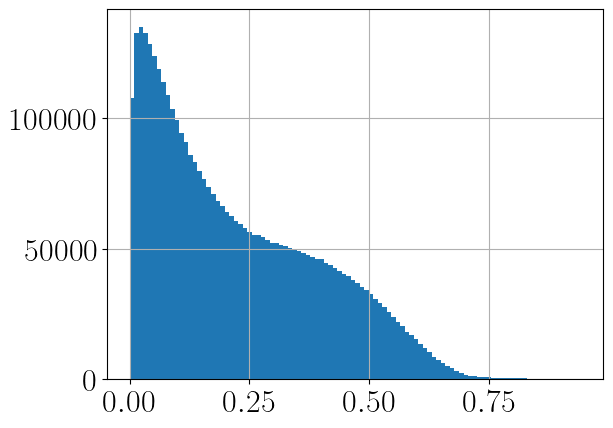

In [53]:
epsilon_epa.hist(bins = 100)

In [587]:
(Gamma/gamma_epa)

0          0.016851
1          0.040297
2          0.040318
3          0.058971
4          1.066109
             ...   
1999995    0.044639
1999996    1.012139
1999997    0.674769
1999998    0.795375
1999999    0.012308
Length: 2000000, dtype: float64

In [420]:
he4.loc[:, "factor"] = (1 + epsilon_epa*xs_R) *xs_dipole*gamma_t
he4.loc[:, "factor_real"] = (1 + epsilon_epa*xs_R) *xs_dipole*gamma_epa

(array([1.230000e+02, 8.910000e+02, 2.683000e+03, 5.431000e+03,
        9.309000e+03, 1.502600e+04, 2.335200e+04, 3.955800e+04,
        8.255500e+04, 1.821072e+06]),
 array([0.22515972, 0.30264374, 0.38012776, 0.45761178, 0.5350958 ,
        0.61257982, 0.69006384, 0.76754786, 0.84503188, 0.9225159 ,
        0.99999992]),
 <BarContainer object of 10 artists>)

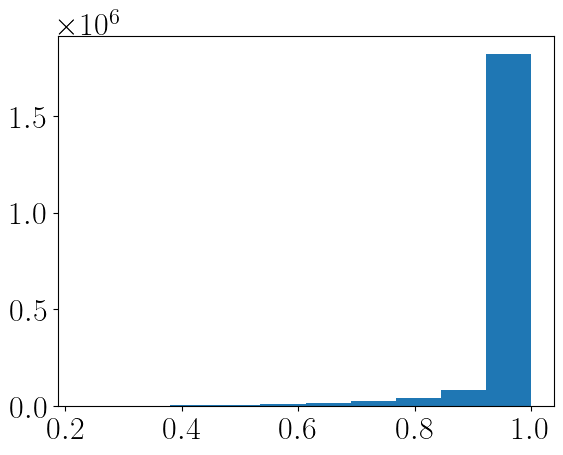

In [487]:
plt.hist((1 + epsilon_epa*xs_R) *xs_dipole)

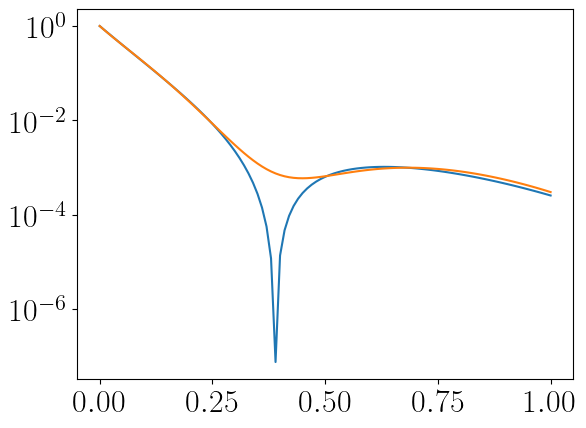

In [362]:
dummy = np.linspace(0, 1, 101)
t0 = 0.7471356
cbar_e = (-15.90270616 * pow(dummy+t0, -8) + 408.6089679* pow(dummy+t0, -7)
- 1509.16153506 * pow(dummy+t0, -6) + 2555.90104941 * pow(dummy+t0, -5) -2235.08186094 * pow(dummy+t0, -4) 
+ 965.53169709 * pow(dummy+t0, -3) -154.69807853*pow(dummy+t0, -2) - 13.69047277 * pow(dummy+t0, -1) + 4.99214927) * (1+dummy/0.71)*(1+dummy/0.71)/1.3434640e2;

cbar_e2 = (77.74373651 * pow(dummy+t0, -8) -483.06238378* pow(dummy+t0, -7)
+ 1269.42409028 * pow(dummy+t0, -6) -1831.65390138 * pow(dummy+t0, -5) + 1584.010715218 * pow(dummy+t0, -4) 
-841.06373938 * pow(dummy+t0, -3) +268.39831231*pow(dummy+t0, -2) -47.21968002 * pow(dummy+t0, -1) + 3.51875738) * (1+dummy/0.71)*(1+dummy/0.71)/1.9654878;

plt.plot(dummy, cbar_e**2)
plt.plot(dummy, cbar_e2**2)
# plt.plot(dummy, )
plt.yscale('log')
plt.show()

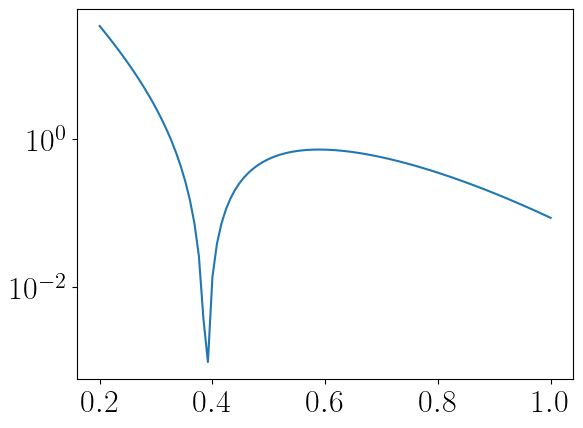

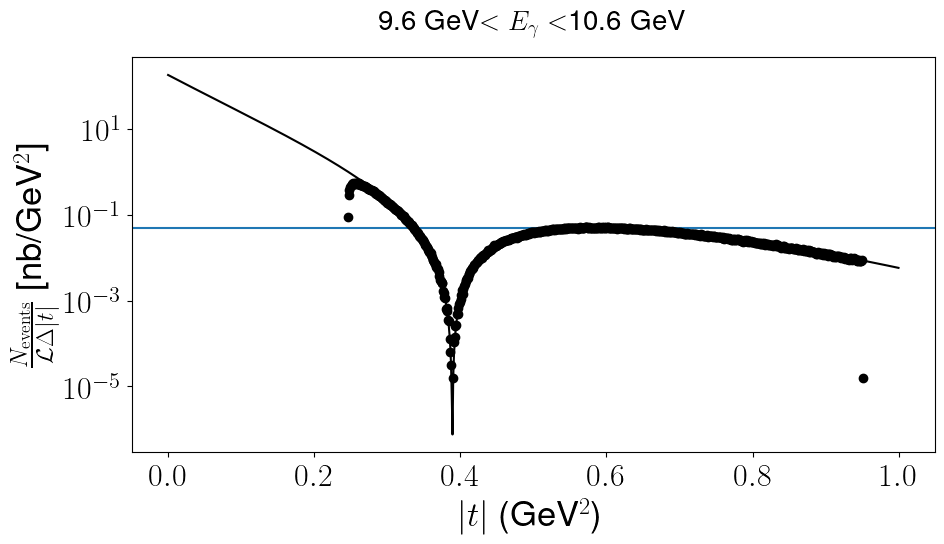

In [667]:
# bins = [0.3, 0.4, 0.6, 0.8]
# middle = 0.42
# bins = [0.2, middle, 1]
desired_lumi = 4.50e8


# he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec/gamma_t
he4.loc[:, "gen_weights"] = np.ones(len(he4))/len(he4)*desired_lumi*total_xsec #/ ((1 + epsilon_epa*xs_R))
# he4.loc[:, "flux"]        
# he4.loc[topology_2, "weights"] = accepted_xsec/total_xsec * he4.loc[topology_2, "weights"]

fig, axs = plt.subplots(1, 1, figsize = (10, 6))

bins = np.linspace(0, 1, 1001)#[0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]# [0.15, 0.25, 0.35, 0.45, 0.55, 0.75, 0.9, 1]
bins = np.array(bins)
bincenters = (bins[:-1] + bins[1:])/2.

hists = 0

# Egmin = 8.9# 9.45
# Egmax = 9#9.5
Egmin = 9.6
Egmax = 10.6
Egavg = (Egmin+Egmax)/2.
Egbinsize = Egmax-Egmin

Wd = W_from_egamma( Egavg, mHe4)
e_gamma_cond = (scattered_e.Q2 < 0.5) & (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
acceptance_egamma_cond = he4.topology & e_gamma_cond
hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
hist = hist.astype(float)
hists = hists + hist
binsizes = np.array([binsize(bins[i], bins[i+1], Egmin, Egmax) for i in range(len(bincenters))])
axs.errorbar(bincenters, np.divide(hist_gen/desired_lumi/N_EPA(10.604, Egavg, 0.5), binsizes, where = binsizes!=0, out = np.zeros_like(hist_gen) ), ls = '', marker = 'o', color = 'k' )
axs.plot(bincenters, dsigma_dt(Wd**2, -bincenters, mHe4, mJpsi), color = 'k' )


# Egmin = 9.55
# Egmax = 9.6
# Egavg = (Egmin+Egmax)/2.
# Egbinsize = Egmax-Egmin

# Wd = W_from_egamma( Egavg, mHe4)
# e_gamma_cond = (scattered_e.Q2 < 0.5) & (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
# Q2_cond = scattered_e.Q2 < 0.5
# acceptance_egamma_cond = he4.topology & e_gamma_cond
# hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
# hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
# hist = hist.astype(float)
# hists = hists + hist
# binsizes = np.array([binsize(bins[i], bins[i+1], Egmin, Egmax) for i in range(len(bincenters))])
# axs.errorbar(bincenters, np.divide(hist_gen/desired_lumi/N_EPA(10.604, Egavg, 0.5), binsizes, where = binsizes!=0, out = np.zeros_like(hist_gen) ), ls = '', marker = 'o', color = 'r' )
# axs.plot(bincenters, dsigma_dt(Wd**2, -bincenters, mHe4, mJpsi), color = 'r' )

# Egmin = 8.5
# Egmax = 9.5
# Egavg = (Egmin+Egmax)/2.
# Egbinsize = Egmax-Egmin

# Wd = W_from_egamma( Egavg, mHe4)
# e_gamma_cond = (scattered_e.Q2 < 0.5) & (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
# Q2_cond = scattered_e.Q2 < 0.5
# acceptance_egamma_cond = he4.topology & e_gamma_cond
# hist, bins = np.histogram(he4.loc[acceptance_egamma_cond, :].t_smeared, bins = bins, weights = he4.loc[acceptance_egamma_cond, "weights"])
# hist_gen, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins, weights = he4.loc[e_gamma_cond, "gen_weights"])
# hist = hist.astype(float)
# hists = hists + hist
# binsizes = np.array([binsize(bins[i], bins[i+1], Egmin, Egmax) for i in range(len(bincenters))])
# axs.errorbar(bincenters, np.divide(hist_gen/desired_lumi/N_EPA(10.604, Egavg, 0.5), binsizes, where = binsizes!=0, out = np.zeros_like(hist_gen) ), ls = '', marker = 'o', color = 'b' )
# axs.plot(bincenters, dsigma_dt(Wd**2, -bincenters, mHe4, mJpsi), color = 'b' )

axs.axhline(0.05)
# for ax in axs.flatten():
# #     ax.set_xlim([0.2, 0.9])
axs.set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
axs.set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")")
axs.set_ylabel(r"$\frac{N_{\mathrm{events}}}{\mathcal{L}\Delta|t|}$" + " [nb/GeV$^2$]")
axs.set_yscale('log')

plt.tight_layout()
plt.show()

In [464]:
he4.accepted_xsec/he4.total_xsec

0          0.05971
1          0.05971
2          0.05971
3          0.05971
4          0.05971
            ...   
1999995    0.05971
1999996    0.05971
1999997    0.05971
1999998    0.05971
1999999    0.05971
Length: 2000000, dtype: float64

In [42]:
jpsi_cond = jpsi_cond & (jpsi_lepton.p>2) & (jpsi_antilepton.p>2)
he4jpsi_cond = he4_cond & jpsi_cond

In [244]:
target_thickness = 6.02*10**23*7*40/(82.05*300)/(1.6e-19)
beam_current     = 450*10**-9
lumi_phase1 = beam_current*target_thickness/10**24/10**9
beam_current     = 2000*10**-9
lumi_phase2      = beam_current*target_thickness/10**24/10**9

5.009115655936736


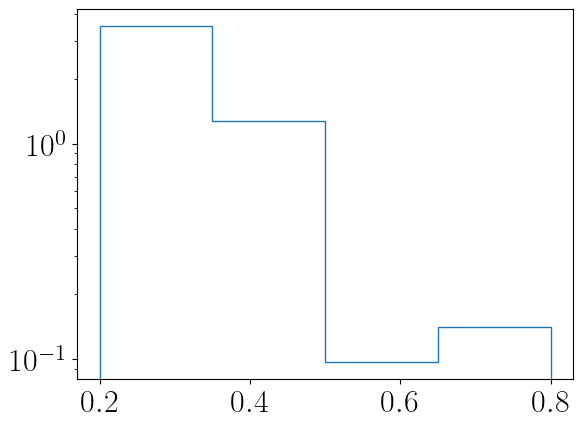

In [252]:
target_thickness = 6.02*10**23*7*40/(82.05*300)/(1.6e-19)

accepted_xsec = np.mean(he4.accepted_xsec)
scenario4_rate = np.sum(he4jpsi_cond)/len(he4)
xsec = scenario4_rate * accepted_xsec

integrated_lumi_phase_0 = 60/4.*86400*10 + 30/4.*86400*20
integrated_lumi_phase_1 = integrated_lumi_phase_0 + lumi_phase1*86400*100
integrated_lumi_phase_2 = integrated_lumi_phase_1 + lumi_phase2*86400*200

scenario4_event_num = xsec*integrated_lumi
scenario4_event_num_extended = xsec*integrated_lumi_phase_0
he4.loc[:, "weights"] = np.ones(len(he4.p))/len(he4) * scenario4_event_num_extended
hist, bins = np.histogram(he4.t_smeared, bins = np.linspace(0.2, 0.8, 5), weights = he4.weights)
print(sum(hist))
plt.hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
# plt.set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
# bincenters = (bins[:-1] + bins[1:])/2.
# plt.errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')


# he4.loc[he4jpsi_cond, "t"].hist(bins = 100, alpha = 0.3)
# he4.loc[he4jpsi_cond, "t_smeared"].hist(bins = 100, alpha = 0.3)
plt.yscale('log')
# plt.ylim(bottom = 1)
plt.show()



In [160]:
tmin(7.7, 0), Egamma_photo(7.7)

(0.9809845775154873, 6.08961924816015)

In [99]:
np.linspace(0.41, 0.8, 11)

array([0.41 , 0.449, 0.488, 0.527, 0.566, 0.605, 0.644, 0.683, 0.722,
       0.761, 0.8  ])

[ 3.47618683e+08 -6.15938901e-11 -6.92428993e+00  5.04922299e-01
  7.76440451e-01] [3.40880589e-11 1.64124107e-01 1.80172623e+01 8.51997792e-03
 3.19279032e+00]


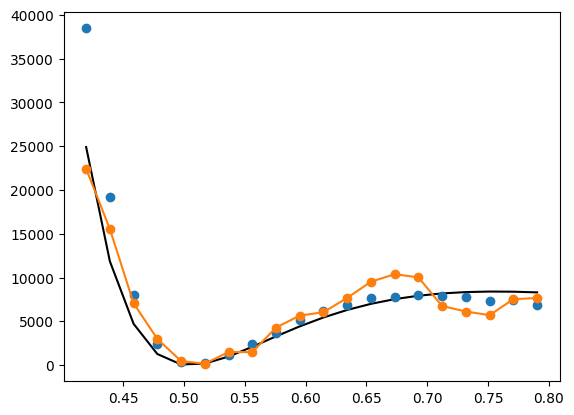

In [100]:
Egamma_min = 8.5
Egamma_max = 10.5
def func(x, a, b, c, d, m):
    return a*(np.exp(c*(x-b)) - np.exp(c*(d-b)))**2/(1+x/m**2)**4


hist, bins = np.histogram(he4.loc[(scattered_e.Egamma>=Egamma_min) & (scattered_e.Egamma<Egamma_max), "t"], bins = np.linspace(0.41, 0.8, 21))
hist_smeared = hist *(1+ np.random.normal(scale = 0.3, size = len(hist)))
bincenters = (bins[:-1]+bins[1:])/2.
plt.errorbar(bincenters, hist, linestyle = '', marker = 'o')
plt.errorbar(bincenters, hist_smeared, marker = 'o')
popt, pcov = curve_fit(func, bincenters, hist_smeared, p0 = [10**8,-0.115, -8.105, 0.5, 0.71],bounds=([10**6, -3, -10, 0.4, 0.65], [10**10, 0, 10, 0.6, 0.8]))
plt.plot(bincenters, func(bincenters, *popt), color = 'k')
print(popt, np.sqrt(np.diag(pcov)))
plt.show()

In [101]:
# Egamma_min = 9
# Egamma_max = 9.5
# print(tmin(df_eHe4.W, Q2=0).max())
# def func(x, a, b, c, d, m):
#     return a*(np.exp(c*(x-b)) - np.exp(c*(d-b)))**2/(1+x/m**2)**4

# bins = np.linspace(0.41, 0.8, 11)
# hist, bins = np.histogram(df_eHe4.loc[(df_eHe4.Egamma>=Egamma_min) & (df_eHe4.Egamma<Egamma_max), "t"], bins = bins)
# hist_smeared = hist *(1+ np.random.normal(scale = np.sqrt(6)/6, size = len(hist)))
# bincenters = (bins[:-1]+bins[1:])/2.
# plt.scatter(bincenters, hist)
# plt.scatter(bincenters, hist_smeared)
# popt, _ = curve_fit(func, bincenters, hist_smeared, p0 = [10**8,-0.115, -8.105, 0.5, 0.71],bounds=([10**6, -3, -10, 0.4, 0.65], [10**10, 0, 10, 0.6, 0.9]))
# plt.plot(bincenters, func(bincenters, *popt))
# print(popt)
# popt, _ = curve_fit(func, bincenters, hist, p0 = [10**8,-0.115, -8.105, 0.5, 0.71],bounds=([10**6, -3, -10, 0.4, 0.65], [10**10, 0, 10, 0.6, 0.9]))
# plt.plot(bincenters, func(bincenters, *popt))

# print(popt)
# plt.show()

In [102]:
hist_smeared-hist

array([-16014.41081273,  -3612.95136184,   -930.17456345,    618.74225674,
           80.11442513,    -63.55471447,    384.46242019,   -911.10771249,
          563.95035019,    449.92690855,   -171.79727297,    813.30047277,
         1817.76517913,   2543.13519397,   2043.16700608,  -1176.02589623,
        -1619.05075396,  -1673.92239663,    151.91174978,    818.97192962])

## Background study

In [443]:
hbarc2   = 0.389379304* 10**6
def fc(t):
    c = 0.7471356
    return (-15.90270616 * (t+c)**(-8) + 408.6089679* (t+c)**(-7) - 1509.16153506 * (t+c)**(-6) + 2555.90104941 * (t+c)**(-5) -2235.08186094 * (t+c)**(-4) + 965.53169709 * (t+c)**(-3) -154.69807853*(t+c)**(-2) - 13.69047277 * (t+c)**(-1) + 4.99214927)/ 134.346402
    
def dsigmadOmega(abst, E_prime_e, Eprime_theta, E_e):
    return hbarc2*(2*alpha)**2 * E_prime_e * np.cos(Eprime_theta/2)**2 * fc(abst)**2/4/E_e**3 /np.sin(Eprime_theta/2)**4

def dsigmadQ2(abst, E_e):
    E_prime_ed = E_e - abst/2/mHe4
    costeld = 1 - abst/(2*E_e*E_prime_ed)
    sinteld = np.sqrt(1-costeld**2)
    E_prime_thetad = np.arctan2(sinteld, costeld)
    return np.pi/E_prime_ed**2 *dsigmadOmega(abst, E_prime_ed, E_prime_thetad, E_e)

FT_counts = [[0.52, 207.43669885491], [0.5200000000000005, 112.93583289668368], [0.5299999999999998, 207.43669885490954], [0.5300000000000002, 67.16197594816822], [0.5400000000000005, 207.43669885490908], [0.5400000000000005, 67.16197594816822], [0.5500000000000003, 201.5303947325201], [0.56, 203.00697076311735], [0.5699999999999998, 205.96012282431184], [0.5800000000000005, 533.760001616907], [0.5800000000000001, 207.43669885491], [0.5899999999999999, 541.1428817698934], [0.5900000000000003, 446.64201581166753], [0.5900000000000003, 352.1411498534426], [0.5900000000000003, 229.5853393138682], [0.6000000000000001, 535.2365776475044], [0.6100000000000003, 536.7131536781014], [0.6200000000000006, 536.7131536781014], [0.6300000000000003, 538.1897297086991], [0.6400000000000001, 682.8941807072317], [0.6400000000000001, 560.3383701676582], [0.6500000000000004, 871.8959126236825], [0.6500000000000004, 777.3950466654571], [0.6500000000000004, 682.8941807072317], [0.6500000000000004, 561.8149461982553], [0.6600000000000001, 871.895912623683], [0.6600000000000001, 777.3950466654571], [0.6600000000000006, 682.8941807072317], [0.6600000000000006, 561.814946198255], [0.6700000000000004, 868.942760562488], [0.6800000000000002, 870.4193365930855], [0.6900000000000004, 871.895912623683], [0.7000000000000006, 874.8490646848772], [0.7100000000000004, 1146.5390543147755], [0.7100000000000004, 1052.03818835655], [0.7100000000000004, 913.2400414804065], [0.7200000000000002, 1146.5390543147755], [0.7200000000000002, 1052.03818835655], [0.7200000000000002, 913.2400414804065], [0.7300000000000004, 1140.6327501923868], [0.7400000000000007, 1142.109326222984], [0.7500000000000004, 1142.1093262229838], [0.7600000000000002, 1142.1093262229838], [0.7700000000000005, 1329.634482108838], [0.7700000000000005, 1235.1336161506122], [0.7700000000000005, 1139.1561741617895], [0.7800000000000007, 1332.5876341700323], [0.7800000000000007, 1238.0867682118067], [0.7800000000000007, 1142.1093262229838], [0.7900000000000005, 1331.111058139435], [0.8000000000000003, 1331.111058139435], [0.81, 1331.1110581394348], [0.8200000000000007, 1334.0642102006295], [0.830000000000001, 1450.713716617814], [0.830000000000001, 1341.4470903536157], [0.8400000000000003, 1450.713716617814], [0.8400000000000003, 1342.923666384213], [0.8500000000000001, 1446.2839885260223], [0.8600000000000008, 1446.2839885260223], [0.870000000000001, 1447.7605645566196], [0.8799999999999999, 1486.1515413521488], [0.8900000000000006, 1554.0740387596234], [0.8900000000000006, 1452.1902926484113], [0.9000000000000008, 1554.0740387596234], [0.9000000000000012, 1452.1902926484113], [0.910000000000001, 1554.0740387596234], [0.9100000000000006, 1453.6668686790085], [0.9200000000000004, 1551.1208866984286], [0.9300000000000006, 1551.1208866984286], [0.9400000000000008, 1546.691158606637], [0.9500000000000006, 1545.2145825760397], [0.9600000000000004, 1545.21458257604], [0.9700000000000006, 1537.8317024230532], [0.9800000000000009, 1536.355126392456], [0.9900000000000007, 1537.8317024230532], [1.0000000000000004, 1554.0740387596234], [1.0100000000000002, 1554.0740387596234], [1.0200000000000005, 1557.0271908208179], [1.0300000000000002, 1557.0271908208179], [1.04, 1567.363223034999], [1.0500000000000007, 1567.363223034999], [1.060000000000001, 1564.410070973804], [1.0700000000000007, 1564.410070973804], [1.0800000000000005, 1562.9334949432068], [1.0900000000000012, 1558.503766851415], [1.100000000000001, 1557.0271908208179], [1.1100000000000008, 1557.0271908208179], [1.12, 1559.9803428820123], [1.12, 1450.713716617814], [1.1300000000000003, 1559.9803428820123], [1.1300000000000003, 1450.713716617814], [1.140000000000001, 1441.8542604342306], [1.1500000000000012, 1438.901108373036], [1.160000000000001, 1437.4245323424386], [1.1700000000000008, 1418.2290439446742], [1.180000000000001, 1413.7993158528823], [1.1900000000000008, 1413.799315852882], [1.200000000000001, 1412.322739822285], [1.2100000000000009, 1391.6506753939232], [1.2200000000000006, 1391.6506753939234], [1.2300000000000009, 1391.6506753939234], [1.2400000000000007, 1391.650675393923], [1.2500000000000004, 1394.6038274551177], [1.2600000000000002, 1396.0804034857151], [1.270000000000001, 1400.5101315775069], [1.2800000000000007, 1400.5101315775069], [1.290000000000001, 1400.5101315775069], [1.3000000000000016, 1403.4632836387013], [1.3000000000000012, 1291.2435053133086], [1.3100000000000014, 1400.5101315775069], [1.3100000000000014, 1289.7669292827115], [1.3200000000000007, 1276.4777450073357], [1.3300000000000005, 1275.0011689767387], [1.3400000000000007, 1276.477745007336], [1.350000000000001, 1276.4777450073357], [1.3600000000000008, 1276.4777450073357], [1.370000000000001, 1280.9074730991276], [1.3800000000000008, 1282.3840491297246], [1.3900000000000006, 1283.8606251603221], [1.4000000000000004, 1283.8606251603221], [1.410000000000001, 1283.8606251603221], [1.4200000000000017, 1288.290353252114], [1.4200000000000017, 1190.836335232694], [1.430000000000002, 1288.2903532521138], [1.430000000000001, 1190.8363352326937], [1.4400000000000013, 1193.7894872938887], [1.4500000000000006, 1192.3129112632914], [1.4600000000000013, 1190.8363352326937], [1.4700000000000015, 1156.8750865289567], [1.4700000000000015, 1097.8120453050658], [1.4800000000000009, 1193.7894872938884], [1.4800000000000009, 1094.858893243871], [1.4900000000000015, 1159.8282385901512], [1.4900000000000015, 1094.858893243871], [1.5000000000000013, 1094.858893243871], [1.5100000000000007, 1091.9057411826764], [1.5200000000000005, 1091.9057411826766], [1.5300000000000011, 1090.4291651520793], [1.540000000000001, 1074.1868288155092], [1.5500000000000012, 1071.2336767543147], [1.560000000000001, 1054.9913404177446], [1.5700000000000007, 1052.03818835655], [1.5800000000000014, 1050.561612325953], [1.5900000000000016, 1049.0850362953556], [1.600000000000001, 1054.9913404177448], [1.6000000000000014, 956.0607463677272], [1.6100000000000008, 1052.03818835655], [1.6100000000000012, 954.58417033713], [1.6200000000000014, 954.5841703371302], [1.6300000000000012, 954.58417033713], [1.6400000000000015, 954.58417033713], [1.6500000000000017, 956.0607463677272], [1.660000000000001, 975.2562347654919], [1.6700000000000008, 976.7328107960889], [1.6800000000000006, 978.2093868266866], [1.6900000000000013, 995.928299193854], [1.7000000000000015, 997.404875224451], [1.7100000000000013, 995.9282991938537], [1.720000000000001, 1001.8346033162429], [1.720000000000001, 892.5679770520449], [1.7300000000000009, 1001.8346033162427], [1.7300000000000009, 891.0914010214472], [1.7400000000000015, 879.2787927766692], [1.7500000000000013, 877.8022167460717], [1.7600000000000011, 877.8022167460717], [1.7700000000000018, 880.7553688072667], [1.7700000000000014, 781.8247747572493], [1.7800000000000016, 880.7553688072662], [1.7800000000000011, 778.8716226960546], [1.7900000000000014, 770.0121665124709], [1.8000000000000012, 764.1058623900817], [1.8100000000000018, 762.6292863594847], [1.820000000000002, 762.6292863594847], [1.8300000000000014, 762.6292863594849], [1.8400000000000007, 762.6292863594845], [1.8500000000000019, 762.6292863594847], [1.860000000000002, 762.6292863594847], [1.8700000000000019, 762.6292863594847], [1.8800000000000012, 762.6292863594847], [1.890000000000001, 764.1058623900817], [1.9000000000000012, 770.0121665124709], [1.910000000000001, 771.4887425430682], [1.9200000000000013, 777.3950466654571], [1.9300000000000015, 780.3481987266518], [1.9400000000000013, 778.8716226960546], [1.950000000000001, 772.9653185736652], [1.9600000000000009, 770.0121665124709], [1.9700000000000015, 767.0590144512764], [1.9800000000000022, 764.1058623900819], [1.990000000000002, 764.1058623900819], [2.0000000000000018, 762.6292863594845], [2.0100000000000016, 761.1527103288872], [2.020000000000001, 765.582438420679], [2.0200000000000005, 656.3158121564807], [2.0300000000000007, 762.6292863594847], [2.0300000000000007, 654.8392361258834], [2.0400000000000005, 647.456355972897], [2.05, 644.5032039117025], [2.0599999999999996, 643.0266278811055], [2.0699999999999994, 635.6437477281186], [2.079999999999999, 634.1671716975216], [2.0899999999999994, 626.7842915445356], [2.099999999999999, 623.8311394833408], [2.1099999999999994, 622.3545634527434], [2.1199999999999988, 622.3545634527434], [2.1299999999999986, 620.8779874221464], [2.139999999999999, 619.4014113915489], [2.149999999999998, 619.4014113915489], [2.1599999999999975, 616.4482593303544], [2.1699999999999977, 614.9716832997569], [2.1799999999999975, 614.9716832997569], [2.1899999999999973, 613.4951072691597], [2.199999999999997, 613.4951072691597], [2.209999999999997, 612.0185312385622], [2.2199999999999966, 612.0185312385624], [2.2299999999999964, 610.5419552079652], [2.239999999999996, 609.0653791773682], [2.2499999999999964, 600.2059229937843], [2.2599999999999953, 598.7293469631873], [2.269999999999995, 588.3933147490061], [2.279999999999995, 586.9167387184091], [2.2899999999999947, 586.9167387184091], [2.2999999999999945, 586.9167387184089], [2.3099999999999943, 563.2915222288525], [2.319999999999994, 561.814946198255], [2.329999999999994, 560.338370167658], [2.3399999999999945, 538.1897297086991], [2.349999999999994, 536.7131536781014], [2.3599999999999937, 536.7131536781017], [2.3699999999999934, 536.7131536781017], [2.379999999999994, 536.7131536781014], [2.389999999999993, 536.7131536781014], [2.3999999999999937, 536.7131536781017], [2.4099999999999926, 536.7131536781017], [2.4199999999999924, 536.7131536781014], [2.429999999999993, 536.7131536781014], [2.439999999999992, 530.8068495557125], [2.4499999999999917, 529.330273525115], [2.4599999999999915, 529.3302735251152], [2.4699999999999913, 524.9005454333233], [2.479999999999991, 521.947393372129], [2.489999999999991, 520.4708173415315], [2.4999999999999907, 517.5176652803368], [2.5099999999999905, 516.0410892497398], [2.5199999999999902, 513.0879371885451], [2.52999999999999, 508.6582090967536], [2.53999999999999, 508.65820909675335], [2.5499999999999887, 507.18163306615634], [2.5599999999999894, 507.18163306615634], [2.569999999999989, 505.70505703555887], [2.579999999999988, 505.70505703555887], [2.5899999999999888, 505.7050570355591], [2.5999999999999885, 504.2284810049614], [2.6099999999999874, 504.22848100496117], [2.619999999999988, 502.75190497436415], [2.629999999999988, 501.27532894376714], [2.6399999999999877, 501.27532894376714], [2.6499999999999866, 498.3221768825724], [2.6599999999999873, 496.8456008519752], [2.669999999999987, 495.36902482137793], [2.6799999999999877, 483.55641657659976], [2.6899999999999875, 480.6032645154053], [2.6999999999999864, 470.2672323012241], [2.709999999999986, 467.3140802400296], [2.719999999999986, 467.3140802400296], [2.7299999999999858, 464.36092817883537], [2.7399999999999856, 452.5483199340572], [2.7499999999999853, 451.0717439034597], [2.7599999999999842, 451.0717439034597], [2.769999999999984, 436.30598359748683], [2.7799999999999847, 436.30598359748683], [2.7899999999999845, 436.30598359748706], [2.7999999999999843, 436.30598359748683], [2.809999999999984, 445.1654397810703], [2.819999999999983, 446.64201581166753], [2.8299999999999836, 455.5014719952517], [2.8399999999999843, 458.45462405644594], [2.849999999999983, 456.9780480258489], [2.859999999999982, 442.21228771987603], [2.869999999999983, 442.21228771987603], [2.8799999999999826, 428.92310344450084], [2.8899999999999832, 427.44652741390337], [2.899999999999983, 425.9699513833059], [2.909999999999982, 425.9699513833059], [2.9199999999999817, 424.4933753527084], [2.9299999999999815, 408.25103901613875], [2.9399999999999813, 406.77446298554173], [2.949999999999981, 392.0087026795686], [2.959999999999981, 390.53212664897137], [2.9699999999999807, 390.53212664897137], [2.9799999999999796, 392.0087026795684], [2.9899999999999802, 393.48527871016586], [2.999999999999979, 394.96185474076333], [3.0099999999999807, 396.4384307713606], [3.0199999999999796, 397.9150068019578], [3.0299999999999794, 397.91500680195804], [3.039999999999979, 399.39158283255506], [3.049999999999979, 399.3915828325553], [3.0599999999999787, 399.3915828325553], [3.0699999999999785, 402.3447348937498], [3.0799999999999783, 405.29788695494403], [3.089999999999978, 405.2978869549445], [3.099999999999977, 384.6258225265824], [3.1099999999999777, 381.6726704653879], [3.1199999999999775, 378.7195184041934], [3.1299999999999772, 361.0006060370256], [3.139999999999977, 361.0006060370258], [3.149999999999977, 361.0006060370258], [3.1599999999999766, 363.9537580982203], [3.1699999999999764, 384.6258225265826], [3.179999999999976, 386.10239855717987], [3.189999999999976, 406.7744629855415], [3.199999999999975, 408.25103901613875], [3.2099999999999755, 408.25103901613875], [3.2199999999999744, 392.0087026795684], [3.2299999999999742, 387.5789745877771], [3.239999999999974, 386.10239855717964], [3.2499999999999747, 365.430334128818], [3.2599999999999745, 365.430334128818], [3.2699999999999734, 365.4303341288178], [3.279999999999974, 365.430334128818], [3.289999999999974, 372.81321428180445], [3.2999999999999736, 375.7663663429987], [3.3099999999999734, 378.7195184041932], [3.319999999999973, 380.19609443479044], [3.329999999999973, 378.7195184041934], [3.3399999999999728, 371.336638251207], [3.3499999999999734, 369.8600622206095], [3.3599999999999723, 369.86006222060973], [3.369999999999972, 362.4771820676233], [3.379999999999972, 361.00060603702605], [3.3899999999999726, 358.04745397583133], [3.3999999999999715, 358.04745397583133], [3.4099999999999713, 356.57087794523386], [3.419999999999971, 355.09430191463684], [3.4299999999999717, 353.6177258840398], [3.4399999999999697, 352.14114985344236], [3.4499999999999704, 350.66457382284534], [3.45999999999997, 344.7582697004557], [3.46999999999997, 341.8051176392612], [3.479999999999969, 337.3753895474697], [3.4899999999999687, 335.8988135168727], [3.4999999999999694, 335.89881351687245], [3.5099999999999683, 337.37538954746947], [3.519999999999969, 337.37538954746947], [3.5299999999999687, 341.8051176392612], [3.5399999999999685, 344.75826970045614], [3.5499999999999683, 350.66457382284534], [3.559999999999968, 350.66457382284534], [3.569999999999968, 350.6645738228451], [3.5799999999999677, 338.8519655780665], [3.5899999999999666, 335.89881351687245], [3.5999999999999672, 325.5627813026915], [3.609999999999967, 324.0862052720943], [3.6199999999999677, 324.08620527209405], [3.6299999999999666, 324.0862052720938], [3.6399999999999673, 325.5627813026913], [3.649999999999966, 325.5627813026915], [3.659999999999966, 327.03935733328876], [3.669999999999965, 327.0393573332883], [3.6799999999999655, 327.03935733328854], [3.6899999999999653, 328.515933363886], [3.699999999999965, 329.992509394483], [3.709999999999965, 341.8051176392614], [3.7199999999999647, 343.2816936698589], [3.7299999999999645, 353.6177258840398], [3.7399999999999642, 353.6177258840396], [3.749999999999964, 353.6177258840398], [3.759999999999964, 347.7114217616506], [3.7699999999999636, 344.7582697004559], [3.7799999999999625, 340.32854160866395], [3.789999999999963, 340.3285416086642], [3.799999999999963, 338.8519655780667], [3.8099999999999627, 334.422237486275], [3.8199999999999625, 334.422237486275], [3.8299999999999623, 331.4690854250807], [3.839999999999962, 329.99250939448325], [3.849999999999962, 324.08620527209405], [3.8599999999999617, 324.08620527209405], [3.8699999999999615, 321.13305321089956], [3.879999999999962, 318.1799011497053], [3.88999999999996, 316.70332511910783], [3.89999999999996, 313.7501730579131], [3.9099999999999606, 312.27359702731565], [3.9199999999999613, 312.2735970273159], [3.9299999999999593, 313.75017305791334], [3.939999999999961, 324.08620527209405], [3.949999999999959, 327.0393573332881], [3.9599999999999604, 337.37538954746947], [3.9699999999999593, 337.37538954746947], [3.979999999999959, 338.8519655780667], [3.989999999999959, 337.3753895474697], [3.9999999999999596, 332.94566145567774], [4.009999999999959, 329.992509394483], [4.019999999999959, 325.5627813026913], [4.02999999999996, 324.08620527209405], [4.039999999999958, 324.08620527209405], [4.049999999999958, 321.13305321089956], [4.059999999999958, 315.22674908851013], [4.069999999999958, 312.2735970273159], [4.079999999999957, 307.84386893552414], [4.089999999999959, 306.3672929049271], [4.099999999999957, 307.84386893552437], [4.109999999999959, 309.3204449661216], [4.119999999999957, 309.3204449661214], [4.129999999999956, 310.79702099671863], [4.139999999999956, 313.75017305791334], [4.149999999999956, 319.6564771803023], [4.159999999999956, 319.6564771803023], [4.1699999999999555, 318.17990114970485], [4.179999999999955, 318.17990114970485], [4.189999999999955, 318.1799011497051], [4.199999999999955, 316.70332511910783], [4.209999999999955, 315.2267490885106], [4.2199999999999545, 313.75017305791334], [4.229999999999954, 307.8438689355239], [4.239999999999954, 307.8438689355239], [4.249999999999954, 307.84386893552414], [4.349999999999952, 297.50783672134344], [4.359999999999953, 306.3672929049269], [4.369999999999951, 306.3672929049269], [4.379999999999951, 312.2735970273161], [4.389999999999951, 313.75017305791334], [4.399999999999951, 316.7033251191076], [4.40999999999995, 319.6564771803023], [4.41999999999995, 319.6564771803023], [4.42999999999995, 322.6096292414966], [4.43999999999995, 324.0862052720938], [4.449999999999951, 328.515933363886], [4.459999999999951, 328.51593336388623], [4.469999999999949, 325.5627813026915], [4.479999999999949, 315.2267490885106], [4.489999999999949, 313.7501730579131], [4.4999999999999485, 300.4609887825377], [4.50999999999995, 298.9844127519407], [4.519999999999948, 298.9844127519407], [4.529999999999948, 298.9844127519407], [4.539999999999948, 300.4609887825377], [4.549999999999947, 301.9375648131347], [4.559999999999947, 301.93756481313494], [4.569999999999947, 301.9375648131347], [4.579999999999947, 301.93756481313494], [4.589999999999948, 303.4141408437322], [4.599999999999948, 306.3672929049269], [4.609999999999946, 307.8438689355239], [4.619999999999948, 309.3204449661216], [4.629999999999946, 310.79702099671886], [4.639999999999947, 312.2735970273161], [4.649999999999945, 313.75017305791334], [4.659999999999945, 322.6096292414968], [4.669999999999945, 324.08620527209405], [4.679999999999945, 332.94566145567774], [4.689999999999944, 334.422237486275], [4.699999999999944, 334.4222374862752], [4.709999999999944, 321.13305321089956], [4.719999999999946, 321.13305321089956], [4.729999999999944, 319.6564771803023], [4.739999999999943, 309.3204449661216], [4.749999999999943, 306.3672929049269], [4.759999999999945, 306.3672929049269], [4.769999999999943, 304.8907168743294], [4.779999999999944, 298.98441275194045], [4.789999999999942, 294.5546846601485], [4.799999999999942, 288.6483805377595], [4.809999999999942, 282.74207641537055], [4.819999999999943, 281.2655003847731], [4.8299999999999415, 282.7420764153703], [4.839999999999941, 282.7420764153703], [4.849999999999941, 297.50783672134344], [4.859999999999941, 298.9844127519402], [4.869999999999941, 298.98441275194045], [4.87999999999994, 312.2735970273159], [4.88999999999994, 313.75017305791334], [4.89999999999994, 312.2735970273159], [4.90999999999994, 309.3204449661216], [4.9199999999999395, 307.84386893552437], [4.929999999999939, 304.8907168743292], [4.939999999999939, 303.4141408437322], [4.949999999999941, 303.4141408437324], [4.959999999999939, 303.4141408437324], [4.96999999999994, 306.36729290492667], [4.979999999999938, 307.8438689355239], [4.98999999999994, 309.3204449661214], [4.999999999999938, 310.79702099671863], [5.009999999999939, 312.2735970273159], [5.019999999999937, 312.2735970273161], [5.029999999999937, 312.2735970273161], [5.039999999999937, 312.27359702731565], [5.0499999999999385, 312.2735970273159], [5.0599999999999365, 312.2735970273159], [5.069999999999936, 312.2735970273161], [5.079999999999938, 312.2735970273159], [5.089999999999936, 324.08620527209405], [5.099999999999936, 325.5627813026913], [5.1099999999999355, 328.515933363886], [5.119999999999935, 338.85196557806694], [5.129999999999935, 337.37538954746947], [5.139999999999935, 325.5627813026913], [5.149999999999935, 324.0862052720938], [5.159999999999934, 321.13305321089956], [5.169999999999934, 321.1330532108998], [5.179999999999934, 307.84386893552414], [5.189999999999934, 306.3672929049269], [5.199999999999934, 304.8907168743294], [5.209999999999933, 297.50783672134344], [5.219999999999933, 294.5546846601485], [5.229999999999933, 288.6483805377595], [5.239999999999933, 287.1718045071623], [5.2499999999999325, 285.6952284765648], [5.259999999999934, 287.1718045071623], [5.269999999999932, 315.22674908851036], [5.279999999999934, 315.2267490885106], [5.289999999999932, 344.75826970045614], [5.299999999999933, 346.2348457310534], [5.309999999999931, 346.2348457310529], [5.319999999999931, 346.23484573105316], [5.329999999999931, 334.422237486275], [5.339999999999931, 332.94566145567796], [5.34999999999993, 322.6096292414966], [5.35999999999993, 321.13305321089956], [5.36999999999993, 319.6564771803023], [5.37999999999993, 316.7033251191076], [5.3899999999999295, 297.50783672134344], [5.399999999999929, 294.5546846601485], [5.409999999999929, 275.3591962623841], [5.419999999999929, 273.88262023178663], [5.429999999999929, 273.88262023178686], [5.4399999999999284, 275.35919626238433], [5.44999999999993, 300.4609887825379], [5.45999999999993, 303.4141408437322], [5.46999999999993, 303.4141408437322], [5.479999999999928, 325.5627813026913], [5.489999999999927, 327.03935733328854], [5.499999999999927, 325.5627813026915], [5.509999999999929, 324.08620527209405], [5.519999999999927, 321.13305321089956], [5.529999999999928, 318.1799011497051], [5.539999999999928, 315.22674908851036], [5.549999999999926, 316.7033251191076], [5.559999999999928, 318.1799011497051], [5.569999999999926, 319.6564771803023], [5.579999999999927, 321.13305321089956], [5.589999999999925, 321.13305321089956], [5.599999999999927, 324.08620527209405], [5.609999999999925, 324.08620527209405], [5.619999999999925, 324.0862052720943], [5.629999999999924, 334.422237486275], [5.639999999999926, 334.422237486275], [5.649999999999924, 337.3753895474697], [5.659999999999924, 346.23484573105316], [5.6699999999999235, 344.75826970045614], [5.679999999999923, 325.5627813026913], [5.689999999999923, 321.1330532108998], [5.699999999999923, 321.13305321089956], [5.709999999999923, 296.03126069074597], [5.719999999999924, 296.03126069074597], [5.729999999999922, 296.03126069074574], [5.739999999999924, 300.4609887825377], [5.749999999999922, 304.8907168743294], [5.759999999999923, 306.3672929049271], [5.769999999999921, 306.3672929049271], [5.779999999999921, 312.2735970273159], [5.789999999999921, 313.7501730579131], [5.799999999999921, 312.27359702731565], [5.809999999999921, 312.2735970273159], [5.81999999999992, 312.2735970273159], [5.82999999999992, 312.2735970273161], [5.83999999999992, 312.2735970273161], [5.8499999999999215, 312.27359702731565], [5.8599999999999195, 312.2735970273159], [5.869999999999921, 312.2735970273159], [5.879999999999919, 312.2735970273161], [5.889999999999919, 313.75017305791334], [5.899999999999919, 313.7501730579131], [5.909999999999918, 316.7033251191074], [5.919999999999918, 316.7033251191076], [5.929999999999918, 316.7033251191076], [5.939999999999918, 318.1799011497051], [5.949999999999918, 318.1799011497053], [5.959999999999917, 319.6564771803021], [5.969999999999917, 319.6564771803023], [5.979999999999917, 318.1799011497051], [5.9899999999999185, 318.1799011497051], [5.9999999999999165, 318.1799011497053], [6.009999999999916, 316.7033251191076], [6.019999999999916, 315.22674908851036], [6.029999999999916, 316.7033251191076], [6.039999999999916, 319.6564771803023], [6.049999999999914, 322.6096292414966], [6.059999999999915, 324.0862052720938], [6.069999999999915, 324.08620527209405], [6.079999999999915, 327.03935733328854], [6.089999999999915, 327.03935733328854], [6.099999999999914, 324.08620527209405], [6.109999999999914, 318.1799011497053], [6.119999999999914, 313.7501730579131], [6.129999999999914, 307.84386893552414], [6.139999999999915, 306.3672929049269], [6.149999999999913, 307.84386893552414], [6.159999999999915, 309.3204449661214], [6.169999999999913, 316.7033251191074], [6.1799999999999145, 318.1799011497051], [6.189999999999914, 328.515933363886], [6.199999999999914, 328.51593336388623], [6.209999999999914, 328.51593336388623], [6.219999999999914, 328.5159333638858], [6.229999999999912, 315.22674908851036], [6.239999999999913, 315.2267490885106], [6.249999999999913, 303.4141408437324], [6.259999999999911, 303.4141408437324], [6.269999999999911, 303.4141408437322], [6.2799999999999105, 304.8907168743294], [6.28999999999991, 324.08620527209405], [6.29999999999991, 325.5627813026915], [6.30999999999991, 346.23484573105316], [6.31999999999991, 346.2348457310534], [6.3299999999999095, 347.7114217616506], [6.339999999999909, 347.7114217616506], [6.349999999999909, 347.7114217616504], [6.359999999999909, 347.7114217616506], [6.369999999999909, 347.7114217616506], [6.379999999999908, 346.23484573105316], [6.389999999999908, 346.23484573105316], [6.399999999999908, 334.422237486275], [6.4099999999999095, 332.94566145567796], [6.419999999999906, 332.94566145567796], [6.429999999999907, 321.13305321089956], [6.439999999999907, 321.13305321089956], [6.449999999999907, 321.13305321089956], [6.459999999999907, 329.99250939448325], [6.4699999999999065, 332.94566145567774], [6.479999999999906, 334.422237486275], [6.489999999999906, 346.2348457310534], [6.499999999999906, 346.2348457310529], [6.509999999999906, 343.2816936698589], [6.519999999999907, 343.2816936698589], [6.529999999999905, 340.3285416086642], [6.539999999999905, 338.8519655780665], [6.549999999999905, 332.94566145567774], [6.559999999999905, 331.4690854250807], [6.569999999999904, 329.99250939448325], [6.579999999999904, 329.99250939448325], [6.589999999999902, 329.99250939448325], [6.599999999999904, 329.9925093944835], [6.6099999999999035, 329.992509394483], [6.619999999999903, 329.99250939448325], [6.629999999999903, 332.94566145567796], [6.639999999999903, 335.89881351687245], [6.649999999999903, 338.8519655780665], [6.659999999999902, 340.3285416086642], [6.6699999999999005, 341.8051176392614], [6.679999999999902, 341.8051176392614], [6.689999999999902, 341.8051176392614], [6.699999999999903, 337.37538954746947], [6.709999999999901, 335.8988135168722], [6.719999999999899, 329.99250939448325], [6.729999999999901, 328.51593336388623], [6.739999999999901, 328.515933363886], [6.7499999999999005, 327.03935733328876], [6.7599999999999, 328.515933363886], [6.7699999999999, 337.37538954746947], [6.7799999999999, 338.8519655780667], [6.7899999999999014, 346.23484573105316], [6.7999999999998995, 349.18799779224787], [6.809999999999899, 349.1879977922474], [6.819999999999899, 349.18799779224764], [6.829999999999901, 356.5708779452341], [6.839999999999899, 358.0474539758311], [6.849999999999898, 362.4771820676233], [6.859999999999896, 363.95375809822053], [6.869999999999898, 363.95375809822076], [6.879999999999898, 363.9537580982203], [6.8899999999998975, 362.4771820676233], [6.899999999999897, 361.0006060370258], [6.909999999999899, 361.0006060370258], [6.919999999999895, 361.0006060370258], [6.9299999999998985, 362.4771820676233], [6.9399999999998965, 369.86006222060973], [6.949999999999898, 371.336638251207], [6.959999999999896, 371.336638251207], [6.969999999999896, 378.71951840419297], [6.979999999999896, 380.1960944347902], [6.989999999999895, 380.1960944347902], [6.999999999999895, 375.7663663429985], [7.009999999999895, 374.28979031240146], [7.019999999999895, 366.90691015941525], [7.0299999999998946, 365.4303341288178], [7.039999999999896, 365.4303341288178], [7.049999999999892, 362.4771820676233], [7.059999999999894, 358.04745397583133], [7.069999999999894, 356.5708779452343], [7.0799999999998935, 349.1879977922474], [7.089999999999893, 349.18799779224764], [7.099999999999893, 349.18799779224764], [7.109999999999893, 349.18799779224787], [7.119999999999893, 350.66457382284534], [7.129999999999892, 359.5240300064288], [7.139999999999892, 361.0006060370258], [7.149999999999892, 371.33663825120675], [7.159999999999892, 372.81321428180445], [7.16999999999989, 372.8132142818042], [7.179999999999891, 375.7663663429987], [7.189999999999891, 361.0006060370256], [7.199999999999889, 358.0474539758311], [7.209999999999891, 356.57087794523386], [7.2199999999998905, 343.28169366985867], [7.22999999999989, 343.2816936698589], [7.239999999999888, 343.28169366985867], [7.24999999999989, 347.7114217616504], [7.259999999999888, 347.7114217616504], [7.269999999999889, 349.18799779224764], [7.2799999999998875, 352.14114985344236], [7.289999999999889, 358.04745397583133], [7.299999999999889, 359.5240300064286], [7.309999999999889, 361.0006060370258], [7.319999999999888, 390.53212664897137], [7.329999999999888, 390.53212664897137], [7.339999999999888, 423.01679932211164], [7.349999999999888, 423.0167993221114], [7.359999999999886, 423.0167993221114], [7.369999999999887, 423.0167993221114], [7.379999999999889, 421.5402232915144], [7.389999999999887, 421.5402232915144], [7.399999999999887, 421.5402232915146], [7.4099999999998865, 421.54022329151417], [7.4199999999998845, 420.0636472609169], [7.429999999999886, 400.86815886315253], [7.439999999999886, 397.9150068019578], [7.449999999999886, 396.4384307713608], [7.459999999999885, 372.81321428180377], [7.469999999999885, 372.8132142818042], [7.479999999999885, 372.8132142818042], [7.489999999999885, 374.28979031240146], [7.4999999999998845, 397.9150068019578], [7.509999999999884, 399.3915828325555], [7.519999999999882, 423.0167993221114], [7.529999999999884, 427.44652741390314], [7.539999999999884, 427.44652741390314], [7.5499999999998835, 428.92310344450084], [7.5599999999998815, 428.92310344450084], [7.569999999999881, 428.9231034445006], [7.579999999999883, 430.39967947509786], [7.589999999999883, 430.3996794750981], [7.599999999999882, 430.39967947509786], [7.609999999999882, 421.5402232915144], [7.619999999999882, 420.0636472609169], [7.629999999999882, 411.20419107733323], [7.6399999999998816, 409.727615046736], [7.649999999999881, 408.25103901613875], [7.659999999999879, 409.727615046736], [7.669999999999881, 418.5870712303199], [7.679999999999881, 420.06364726091715], [7.6899999999998805, 421.5402232915144], [7.6999999999998785, 430.39967947509786], [7.70999999999988, 430.3996794750981], [7.71999999999988, 430.3996794750981], [7.72999999999988, 424.4933753527084], [7.739999999999879, 421.5402232915144], [7.749999999999879, 415.63391916912497], [7.759999999999877, 414.1573431385277], [7.769999999999881, 412.6807671079307], [7.779999999999879, 414.1573431385277], [7.789999999999878, 431.8762555056951], [7.799999999999878, 434.8294075668896], [7.809999999999876, 437.7825596280843], [7.819999999999878, 459.9312000870432], [7.8299999999998775, 461.40777611764065], [7.839999999999877, 464.36092817883514], [7.849999999999877, 465.83750420943215], [7.859999999999877, 468.79065627062687], [7.869999999999877, 470.2672323012241], [7.879999999999876, 474.6969603930163], [7.889999999999876, 477.65011245421056], [7.899999999999876, 479.1266884848078], [7.909999999999876, 480.60326451540504], [7.919999999999876, 492.41587276018345], [7.929999999999875, 495.36902482137793], [7.939999999999877, 505.7050570355591], [7.949999999999875, 507.1816330661561], [7.959999999999875, 505.70505703555887], [7.9699999999998745, 486.5095686377945], [7.979999999999874, 486.50956863779425], [7.989999999999874, 464.36092817883537], [7.999999999999874, 464.3609281788349], [8.009999999999872, 464.36092817883514], [8.019999999999873, 464.36092817883514], [8.029999999999873, 465.8375042094324], [8.039999999999873, 485.03299260719723], [8.049999999999873, 486.5095686377945], [8.059999999999873, 505.7050570355591], [8.069999999999872, 505.70505703555864], [8.079999999999872, 505.70505703555887], [8.089999999999872, 501.27532894376714], [8.099999999999872, 499.7987529131699], [8.109999999999872, 492.415872760183], [8.119999999999873, 492.4158727601832], [8.129999999999871, 490.939296729586], [8.13999999999987, 492.4158727601832], [8.14999999999987, 492.4158727601832], [8.15999999999987, 492.4158727601832], [8.16999999999987, 492.415872760183], [8.17999999999987, 493.8924487907807], [8.189999999999872, 493.8924487907807], [8.19999999999987, 496.8456008519754], [8.20999999999987, 498.32217688257265], [8.21999999999987, 530.8068495557125], [8.229999999999869, 532.2834255863097], [8.239999999999869, 563.2915222288523], [8.249999999999869, 563.2915222288525], [8.259999999999868, 561.8149461982553], [8.269999999999868, 532.2834255863097], [8.279999999999868, 530.8068495557125], [8.289999999999868, 501.2753289437669], [8.299999999999867, 501.2753289437669], [8.309999999999867, 499.79875291316966], [8.319999999999865, 501.27532894376714], [8.329999999999867, 501.2753289437669], [8.339999999999867, 504.22848100496117], [8.349999999999866, 504.2284810049614], [8.359999999999866, 505.70505703555887], [8.369999999999864, 507.18163306615634], [8.379999999999868, 508.6582090967531], [8.389999999999864, 532.2834255863097], [8.399999999999865, 535.2365776475042], [8.409999999999865, 536.7131536781014], [8.419999999999865, 560.3383701676582], [8.429999999999865, 560.338370167658], [8.439999999999864, 557.3852181064628], [8.449999999999863, 557.3852181064635], [8.459999999999866, 555.908642075866], [8.469999999999864, 552.9554900146718], [8.479999999999865, 550.0023379534773], [8.489999999999863, 550.0023379534769], [8.499999999999863, 550.0023379534769], [8.509999999999863, 552.9554900146718], [8.519999999999863, 588.3933147490061], [8.529999999999863, 589.8698907796033], [8.539999999999862, 625.3077155139383], [8.54999999999986, 625.3077155139379], [8.559999999999862, 609.065379177368], [8.569999999999862, 607.5888031467707], [8.579999999999863, 604.6356510855765], [8.58999999999986, 604.6356510855765], [8.599999999999861, 586.9167387184089], [8.60999999999986, 586.9167387184091], [8.61999999999986, 586.9167387184091], [8.62999999999986, 589.8698907796031], [8.63999999999986, 694.7067889520104], [8.63999999999986, 592.823042840798], [8.64999999999986, 694.7067889520099], [8.649999999999858, 594.2996188713953], [8.65999999999986, 690.277060860218], [8.66999999999986, 691.7536368908152], [8.67999999999986, 676.9878765848428], [8.68999999999986, 675.5113005542453], [8.699999999999857, 674.0347245236483], [8.70999999999986, 657.7923881870781], [8.719999999999859, 654.8392361258834], [8.729999999999858, 653.362660095286], [8.739999999999858, 653.3626600952862], [8.749999999999858, 641.550051850508], [8.759999999999858, 640.0734758199105], [8.769999999999857, 628.2608675751326], [8.779999999999857, 626.7842915445353], [8.789999999999857, 626.7842915445356], [8.799999999999857, 626.7842915445356], [8.809999999999857, 631.2140196363271], [8.819999999999856, 669.6049964318559], [8.829999999999856, 671.0815724624536], [8.839999999999856, 712.425701319177], [8.849999999999854, 713.9022773497743], [8.859999999999856, 715.3788533803718], [8.869999999999855, 718.332005441566], [8.879999999999855, 718.3320054415663], [8.889999999999855, 718.3320054415663], [8.899999999999855, 722.7617335333582], [8.909999999999854, 724.2383095639555], [8.919999999999854, 727.1914616251502], [8.929999999999852, 728.6680376557472], [8.939999999999854, 756.7229822370953], [8.949999999999854, 759.67613429829], [8.959999999999853, 784.7779268184438], [8.969999999999851, 787.7310788796381], [8.979999999999855, 789.2076549102353], [8.989999999999851, 812.8328713997919], [8.999999999999854, 814.3094474303891], [9.009999999999852, 836.4580878893485], [9.019999999999852, 837.9346639199455], [9.029999999999852, 837.9346639199453], [9.039999999999852, 837.9346639199455], [9.049999999999851, 832.0283597975563], [9.059999999999853, 832.0283597975563], [9.069999999999851, 826.1220556751675], [9.079999999999849, 824.6454796445696], [9.08999999999985, 824.6454796445703], [9.099999999999849, 826.1220556751673], [9.10999999999985, 860.0833043789046], [9.119999999999848, 863.0364564400991], [9.129999999999852, 864.5130324706963], [9.13999999999985, 901.4274332356281], [9.149999999999848, 902.9040092662256], [9.15999999999985, 904.3805852968228], [9.169999999999849, 904.3805852968228], [9.179999999999849, 911.763465449809], [9.189999999999849, 913.2400414804063], [9.199999999999848, 922.0994976639902], [9.209999999999848, 923.5760736945874], [9.219999999999848, 925.0526497251847], [9.229999999999848, 933.9121059087681], [9.239999999999847, 936.8652579699626], [9.249999999999847, 938.3418340005599], [9.259999999999847, 947.201290184144], [9.269999999999847, 947.2012901841438], [9.279999999999847, 948.677866214741], [9.289999999999846, 987.0688430102703], [9.299999999999846, 988.5454190408673], [9.309999999999846, 1026.9363958363965], [9.319999999999846, 1028.4129718669938], [9.329999999999844, 1028.4129718669938], [9.339999999999847, 1029.889547897591], [9.349999999999843, 1032.8426999587855], [9.359999999999845, 1046.1318842341614], [9.369999999999846, 1046.1318842341611], [9.379999999999844, 1060.8976445401338], [9.389999999999844, 1062.3742205707313], [9.399999999999842, 1065.327372631926], [9.409999999999846, 1078.616556907301], [9.419999999999845, 1080.0931329378984], [9.429999999999843, 1087.4760130908849], [9.439999999999841, 1093.3823172132738], [9.449999999999845, 1096.3354692744686], [9.459999999999845, 1096.3354692744683], [9.46999999999984, 1099.288621335663], [9.479999999999842, 1187.8831831714992], [9.489999999999842, 1142.1093262229838], [9.499999999999842, 1184.9300311103048], [9.509999999999842, 1186.406607140902], [9.519999999999841, 1187.8831831714992], [9.529999999999843, 1202.6489434774721], [9.539999999999843, 1202.6489434774721], [9.54999999999984, 1205.6020955386666], [9.559999999999839, 1217.414703783445], [9.569999999999839, 1217.4147037834446], [9.579999999999842, 1218.891279814042], [9.589999999999838, 1245.4696483647929], [9.599999999999838, 1245.469648364793], [9.60999999999984, 1248.4228004259876], [9.619999999999841, 1248.4228004259876], [9.629999999999841, 1275.0011689767384], [9.649999999999837, 1279.4308970685304], [9.659999999999838, 1279.4308970685302], [9.66999999999984, 1282.3840491297249], [9.679999999999838, 1282.3840491297246], [9.689999999999838, 1283.8606251603223], [9.699999999999838, 1285.3372011909194], [9.709999999999837, 1285.3372011909194], [9.719999999999839, 1292.7200813439058], [9.729999999999835, 1295.6732334051003], [9.739999999999837, 1297.1498094356975], [9.749999999999835, 1297.1498094356978], [9.759999999999836, 1304.5326895886838], [9.769999999999834, 1307.4858416498787], [9.779999999999834, 1307.4858416498787], [9.789999999999837, 1342.923666384213], [9.799999999999836, 1344.4002424148102], [9.809999999999835, 1376.8849150879505], [9.819999999999835, 1378.3614911185477], [9.829999999999835, 1379.8380671491452], [9.839999999999835, 1382.7912192103395], [9.849999999999834, 1422.658772036466], [9.859999999999834, 1427.088500128258], [9.869999999999834, 1466.9560529543842], [9.879999999999834, 1466.9560529543842], [9.889999999999832, 1465.479476923787], [9.899999999999832, 1464.0029008931897], [9.909999999999833, 1428.565076158855], [9.919999999999833, 1424.1353480670632], [9.929999999999835, 1388.6975233327285], [9.93999999999983, 1388.6975233327285], [9.949999999999834, 1388.6975233327285], [9.959999999999832, 1390.1740993633257], [9.96999999999983, 1425.6119240976604], [9.97999999999983, 1428.565076158855], [9.989999999999831, 1465.4794769237872], [9.999999999999833, 1466.9560529543842], [10.009999999999833, 1466.9560529543842], [10.019999999999829, 1580.6524073103742], [10.01999999999983, 1474.3389331073704], [10.029999999999829, 1592.4650155551526], [10.029999999999829, 1480.2452372297596], [10.039999999999832, 1595.4181676163469], [10.039999999999832, 1483.198389290954], [10.04999999999983, 1588.0352874633606], [10.05999999999983, 1589.5118634939577], [10.069999999999828, 1590.9884395245551], [10.07999999999983, 1592.4650155551526], [10.08999999999983, 1599.8478957081388], [10.099999999999827, 1602.8010477693333], [10.109999999999829, 1613.1370799835142], [10.11999999999983, 1613.1370799835142], [10.129999999999828, 1616.0902320447087], [10.139999999999828, 1619.0433841059034], [10.149999999999826, 1722.4037062477125], [10.149999999999828, 1620.5199601365007], [10.159999999999828, 1716.4974021253233], [10.15999999999983, 1619.0433841059034], [10.169999999999828, 1716.4974021253233], [10.16999999999983, 1619.0433841059032], [10.179999999999826, 1722.4037062477125], [10.189999999999825, 1722.4037062477128], [10.199999999999829, 1723.88028227831], [10.209999999999827, 1728.3100103701017], [10.219999999999828, 1729.7865864006988], [10.229999999999826, 1735.692890523088], [10.239999999999828, 1737.1694665536852], [10.249999999999826, 1738.6460425842824], [10.259999999999826, 1741.599194645477], [10.269999999999824, 1768.177563196228], [10.279999999999824, 1769.6541392268255], [10.289999999999825, 1794.7559317469788], [10.299999999999825, 1794.7559317469788], [10.309999999999823, 1794.7559317469788], [10.319999999999823, 1796.2325077775763], [10.329999999999826, 1802.1388118999653], [10.339999999999824, 1803.6153879305625], [10.349999999999824, 1808.0451160223545], [10.359999999999824, 1810.998268083549], [10.369999999999823, 1812.4748441141462], [10.379999999999823, 1813.9514201447435], [10.389999999999823, 1840.5297886954945], [10.399999999999823, 1842.0063647260918], [10.409999999999823, 1867.1081572462454], [10.419999999999822, 1867.1081572462454], [10.429999999999822, 1867.1081572462454], [10.43999999999982, 1850.8658209096752], [10.449999999999823, 1850.8658209096752], [10.459999999999821, 1849.389244879078], [10.469999999999821, 1834.6234845731053], [10.479999999999821, 1833.146908542508], [10.489999999999819, 1831.6703325119108], [10.49999999999982, 1834.6234845731053], [10.49999999999982, 1740.1226186148797], [10.49999999999982, 1645.6217526566543], [10.49999999999982, 1543.7380065454424], [10.50999999999982, 1834.6234845731053], [10.50999999999982, 1740.1226186148797], [10.50999999999982, 1645.6217526566543], [10.509999999999819, 1542.261430514845], [10.51999999999982, 1819.8577242671327], [10.51999999999982, 1725.3568583089068], [10.51999999999982, 1630.8559923506814], [10.519999999999822, 1533.4019743312615], [10.529999999999818, 1537.8317024230532], [10.53999999999982, 1536.355126392456], [10.54999999999982, 1533.4019743312615], [10.559999999999821, 1539.3082784536505], [10.55999999999982, 1444.807412495425], [10.55999999999982, 1314.8687218028651], [10.569999999999817, 1539.3082784536505], [10.569999999999819, 1444.807412495425], [10.569999999999819, 1314.868721802865], [10.579999999999819, 1283.8606251603221], [10.589999999999819, 1282.3840491297249], [10.599999999999818, 1280.9074730991276], [10.609999999999816, 1282.3840491297249], [10.609999999999816, 1187.8831831714992], [10.609999999999816, 1093.3823172132738], [10.609999999999816, 966.3967785819082], [10.619999999999818, 1282.3840491297246], [10.619999999999818, 1187.8831831714992], [10.61999999999982, 1093.3823172132738], [10.619999999999818, 963.4436265207137], [10.629999999999818, 1282.3840491297249], [10.629999999999818, 1187.8831831714992], [10.629999999999818, 1093.3823172132738], [10.629999999999818, 963.4436265207137], [10.639999999999818, 933.9121059087684], [10.649999999999816, 930.9589538475732], [10.659999999999819, 928.0058017863792], [10.669999999999819, 899.9508572050311], [10.669999999999817, 839.4112399505427], [10.669999999999817, 744.9103739923173], [10.669999999999817, 648.9329320034942], [10.679999999999819, 933.9121059087681], [10.679999999999817, 839.4112399505427], [10.679999999999817, 744.9103739923173], [10.679999999999819, 647.456355972897], [10.689999999999817, 933.9121059087681], [10.689999999999817, 839.4112399505427], [10.689999999999817, 744.9103739923173], [10.689999999999817, 647.4563559728967], [10.699999999999816, 650.4095080340919], [10.709999999999816, 647.456355972897], [10.719999999999816, 645.9797799422995], [10.729999999999816, 643.0266278811055], [10.739999999999814, 650.4095080340917], [10.739999999999814, 555.908642075866], [10.739999999999814, 461.40777611764065], [10.739999999999815, 361.00060603702605], [10.749999999999817, 647.456355972897], [10.749999999999815, 552.955490014672], [10.749999999999815, 458.45462405644594], [10.749999999999815, 358.04745397583133], [10.759999999999815, 356.57087794523386], [10.769999999999817, 355.09430191463684], [10.779999999999813, 353.6177258840398], [10.789999999999814, 358.04745397583133], [10.789999999999814, 235.49164343625762], [10.799999999999816, 355.0943019146371], [10.799999999999816, 232.53849137506313], [10.809999999999812, 208.91327488550724], [10.819999999999812, 207.43669885490908], [10.829999999999815, 205.96012282431184], [10.839999999999815, 204.4835467937146], [10.849999999999813, 210.38985091610402], [10.849999999999811, 112.93583289668368], [10.859999999999811, 207.43669885490954], [10.859999999999813, 111.45925686608689], [10.869999999999813, 163.13941793699087], [10.869999999999813, 111.45925686608643], [10.879999999999814, 114.41240892728092], [10.889999999999812, 111.45925686608643], [10.89999999999981, 111.45925686608643], [10.909999999999814, 87.83404037653054], [10.919999999999812, 86.35746434593284]]
FT_e, FT_counts = np.array(FT_counts).T

N = 10**7 # number of events
Ed = 10.604

# external rc.
Ed = 10.604 * np.ones(N)
lambda_he = 5.671E+05 #cm
Ed = Ed - Ed * np.random.rand(N)**(3./4./ (40/lambda_he))
# external rc done

# phase space
abst = np.random.uniform(0, 2*mHe4*10.604, N)

nud      = abst/2/mHe4
Esc      = Ed - nud

# energy loss before the vertex (s-peak)
afac  = alpha/np.pi * (np.log(abst/me**2) - 1.)
dE_1  = np.random.rand(N)**(1/afac) * Ed

# energy loss after the vertex (p-peak)
dE_2  = np.random.rand(N)**(1/afac) * Esc
costel = 1 - abst/(2*Ed*Esc)
sintel = np.sqrt(1-costel**2)

#incoming electron
incoming_electron_px = 0
incoming_electron_py = 0
incoming_electron_pz = Ed
incoming_electron_e  = Ed
# radiated_photon
radiated_speak_px = 0
radiated_speak_py = 0
radiated_speak_pz = dE_1
radiated_speak_e  = dE_1

# internal_electron
internal_electron_px = 0
internal_electron_py = 0
internal_electron_pz = Ed -dE_1
internal_electron_e  = Ed -dE_1

# outgoing_electron
outgoing_electron_px = Esc*sintel
outgoing_electron_py = 0
outgoing_electron_pz = Esc*costel
outgoing_electron_e  = Esc

# radiated photon
radiated_ppeak_px = dE_2*sintel
radiated_ppeak_py = 0
radiated_ppeak_pz = dE_2*costel
radiated_ppeak_e  = dE_2

# internal_electron2
internal_electron2_px = Esc*sintel + dE_2*sintel
internal_electron2_py = 0
internal_electron2_pz = Esc*costel + dE_2*costel
internal_electron2_e  = Esc + dE_2

nud_tr                   = nud - dE_1 - dE_2
elastic_tail_he4_e       =  mHe4 + internal_electron_e - internal_electron2_e
abst_tr                  =  2 * mHe4 * (elastic_tail_he4_e - mHe4)
elastic_tail_he4_p       = np.sqrt(elastic_tail_he4_e**2 - mHe4**2)
elastic_tail_he4_px      = internal_electron_px - internal_electron2_px
elastic_tail_he4_py      = 0
elastic_tail_he4_pz      = internal_electron_pz - internal_electron2_pz
elastic_tail_he4_p2      = np.sqrt(elastic_tail_he4_px**2 + elastic_tail_he4_pz**2)
elastic_tail_he4_theta   = -np.arctan2(elastic_tail_he4_px, elastic_tail_he4_pz)
elastic_tail_he4_vz      = np.random.uniform(target_start_coord, target_end_coord, len(elastic_tail_he4_p))

cond = (nud_tr >= 0) & (np.abs(sintel*Esc/elastic_tail_he4_p)<1)# & elastic_tail_he4_accepted# & (abst_tr < 1)
nud      = nud[cond]
Esc      = Esc[cond]
afac     = afac[cond]
dE_1     = dE_1[cond]
dE_2     = dE_2[cond]
abst_tr  = abst_tr[cond]
elastic_tail_he4_e  = elastic_tail_he4_e[cond]
elastic_tail_he4_p  = elastic_tail_he4_p[cond]
elastic_tail_he4_theta  = elastic_tail_he4_theta[cond]
elastic_tail_he4_px  = elastic_tail_he4_px[cond]
# elastic_tail_he4_py  = elastic_tail_he4_py[cond]
elastic_tail_he4_pz  = elastic_tail_he4_pz[cond]
elastic_tail_he4_p2  = elastic_tail_he4_p2[cond]
elastic_tail_he4_vz  = elastic_tail_he4_vz[cond]

costel = costel[cond]
sintel = sintel[cond]
Ed   = Ed  [cond]

xsec    = dsigmadQ2(abst_tr, Ed - dE_1)

abst_tr = abst_tr[~np.isnan(xsec)]
Esc = Esc[~np.isnan(xsec)]
dE_1   = dE_1[~np.isnan(xsec)]
dE_2   = dE_2[~np.isnan(xsec)]
costel = costel[~np.isnan(xsec)]
sintel = sintel[~np.isnan(xsec)]
elastic_tail_he4_e  = elastic_tail_he4_e[~np.isnan(xsec)]
elastic_tail_he4_p  = elastic_tail_he4_p[~np.isnan(xsec)]
elastic_tail_he4_theta  = elastic_tail_he4_theta[~np.isnan(xsec)]
Ed   = Ed  [~np.isnan(xsec)]
elastic_tail_he4_px  = elastic_tail_he4_px[~np.isnan(xsec)]
# elastic_tail_he4_py  = elastic_tail_he4_py[~np.isnan(xsec)]
elastic_tail_he4_pz  = elastic_tail_he4_pz[~np.isnan(xsec)]
elastic_tail_he4_p2  = elastic_tail_he4_p2[~np.isnan(xsec)]
elastic_tail_he4_vz  =elastic_tail_he4_vz[~np.isnan(xsec)]
xsec = xsec[~np.isnan(xsec)]
elastic_tail_he4_p_smeared     = elastic_tail_he4_p     * np.random.normal(1, 0.05, len(abst_tr))
elastic_tail_he4_theta_smeared = elastic_tail_he4_theta + np.random.normal(0, 0.05, len(abst_tr))
# elastic_tail_he4_phi_smeared   = elastic_tail_he4_phi   + np.random.normal(0, 0.1, len(abst_tr))
elastic_tail_he4_e_smeared     = np.sqrt(elastic_tail_he4_p_smeared**2 + mHe4**2)
elastic_tail_he4_t_smeared     = 2 * mHe4 * (elastic_tail_he4_e_smeared - mHe4)


he4_xsec = np.sum(xsec)/N * (abst.max() - abst.min())
he4_rates = he4_xsec * luminosity_extended_in_nb
ft_rates  = np.sum(FT_counts[FT_e<2])/np.sum(FT_counts)* 4*120*10**6
coincidence_time = 4*10**(-9)


# luminosity_extended_in_nb = 30

he4_elastic_tail = pd.DataFrame()
he4_elastic_tail.loc[:, "p"]                  = elastic_tail_he4_p
he4_elastic_tail.loc[:, "pt"]                 = elastic_tail_he4_px
he4_elastic_tail.loc[:, "pz"]                 = elastic_tail_he4_pz
he4_elastic_tail.loc[:, "e"]                  = elastic_tail_he4_e
he4_elastic_tail.loc[:, "t_smeared"]          = elastic_tail_he4_t_smeared
he4_elastic_tail.loc[:, "theta"]              = np.degrees(elastic_tail_he4_theta)
he4_elastic_tail.loc[:, "theta_smeared"]      = np.degrees(elastic_tail_he4_theta_smeared)
he4_elastic_tail.loc[:, "vz"]                 = elastic_tail_he4_vz
he4_elastic_tail.loc[:, "weights"]            = xsec/N * (abst.max() - abst.min()) * luminosity_extended_in_nb * ft_rates * coincidence_time * 86400 * 100

c = 3e8
B = 5
he4_elastic_tail_rhelix = he4_elastic_tail.pt*10**9/2/B/c
he4_elastic_tail_omega  = 2*B*c**2/he4_elastic_tail.e/10**9
he4_elastic_tail_betat  = he4_elastic_tail.pt/he4_elastic_tail.e

#atof_exit_condition
he4_elastic_tail_time_atof_exit   = (atof_exit_coord - he4_elastic_tail.vz)*0.01/(he4_elastic_tail.pz/he4_elastic_tail.e*c)
he4_elastic_tail_theta_atof_exit  = he4_elastic_tail_omega * he4_elastic_tail_time_atof_exit
he4_elastic_tail_transverse_displacement_atof_exit = he4_elastic_tail_rhelix*2*np.sin(he4_elastic_tail_theta_atof_exit/2)
he4_elastic_tail_atof_exit_condition = he4_elastic_tail_transverse_displacement_atof_exit > 0.08

#atof_entry_condition
he4_elastic_tail_time_atof_entry   = (atof_entry_coord - he4_elastic_tail.vz)*0.01/(he4_elastic_tail.pz/he4_elastic_tail.e*c)
he4_elastic_tail_theta_atof_entry  = he4_elastic_tail_omega * he4_elastic_tail_time_atof_entry
he4_elastic_tail_transverse_displacement_atof_entry = he4_elastic_tail_rhelix*2*np.sin(he4_elastic_tail_theta_atof_entry/2)
he4_elastic_tail_atof_entry_condition = he4_elastic_tail_transverse_displacement_atof_entry < 0.08

#ahdc_entry_condition
he4_elastic_tail_time_ahdc_entry   = (ahdc_entry_coord - he4_elastic_tail.vz)*0.01/(he4_elastic_tail.pz/he4_elastic_tail.e*c)
he4_elastic_tail_theta_ahdc_entry  = he4_elastic_tail_omega * he4_elastic_tail_time_ahdc_entry
he4_elastic_tail_transverse_displacement_ahdc_entry = he4_elastic_tail_rhelix*2*np.sin(he4_elastic_tail_theta_ahdc_entry/2)
he4_elastic_tail_ahdc_entry_condition = he4_elastic_tail_transverse_displacement_ahdc_entry < 0.02

he4_elastic_tail.loc[:, "accepted"] = he4_elastic_tail_atof_exit_condition & he4_elastic_tail_atof_entry_condition & he4_elastic_tail_ahdc_entry_condition


/var/folders/5v/v47_2n_d7f7g_31nzsrvq31c0000gs/T/ipykernel_69556/2221634891.py:41: RuntimeWarning: invalid value encountered in sqrt
  sintel = np.sqrt(1-costel**2)
/var/folders/5v/v47_2n_d7f7g_31nzsrvq31c0000gs/T/ipykernel_69556/2221634891.py:81: RuntimeWarning: invalid value encountered in sqrt
  elastic_tail_he4_p       = np.sqrt(elastic_tail_he4_e**2 - mHe4**2)


In [456]:
luminosity_extended_in_nb

30

<Axes: >

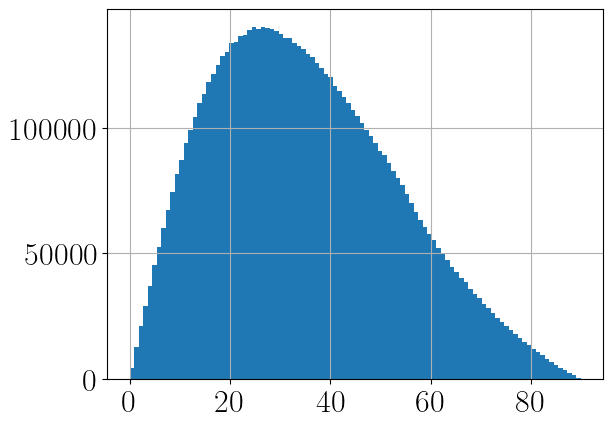

In [449]:
he4_elastic_tail.theta.hist(bins = 100)

In [70]:
he4_rate_per_s = he4_elastic_tail.loc[ (he4_elastic_tail.theta_smeared<50) & (he4_elastic_tail.theta_smeared>10) & (he4_elastic_tail.t_smeared>0.2) &  (he4_elastic_tail.t_smeared<1), "weights"].sum()

In [71]:
he4_rate_per_s

1589.459511830351

In [140]:
jpsi_rga = 19.1 + 27.2 + 26+ 28.4 + 94.4 + 80.9 + 176.3 + 111.5 + 80.3 + 58.4
bkg_rga = 190 + 200 + 147 + 200 + 459 + 545 + 864 + 573 + 442 + 308
charge_rga = 26.312 + 4.00 + 5.355 + 11.831 + 20.620 + 45.994
integrated_lumi_rga = 1.316 * charge_rga * 10**6
jpsi_rate_per_s = 4*jpsi_rga/(integrated_lumi_rga/luminosity_extended_in_nb)

In [109]:
bkg_profile = np.array([2.7089057386455226, 66.07806774844835, 2.7209523727307614, 63.60991958015808, 2.732999113569813, 61.19319116537389, 2.7450460679164923, 58.87930225760175, 2.7570933425246116, 56.7196726103478, 2.7691405103789175, 54.508623209587824, 2.781187998494664, 52.45183306934592, 2.7932357001180375, 50.49788243611613, 2.805283668625945, 48.67248118665151, 2.8173315837569453, 46.82137006043382, 2.8293796056417593, 45.02167868772216, 2.8414278944111073, 43.35053669877567, 2.853476236557362, 41.705104586582195, 2.8655247388343366, 40.1368021046477, 2.8775734012420315, 38.645629252972356, 2.88962201027282, 37.128746524544, 2.9016709929419555, 35.791832933386786, 2.9137198154803707, 34.37778971197048, 2.92576890490332, 33.09229587431929, 2.9378181544569895, 31.883931666927197, 2.9498674573875654, 30.70127733628817, 2.961916867071955, 29.570042759155115, 2.973966276756345, 28.438808182022115, 2.9860156864407346, 27.307573604889058, 2.996422315065966, 26.48485754879232, 3.0112104404589806, 25.19936371114113, 3.023260330535531, 24.2995180247853, 3.0353102206120814, 23.39967233842947, 3.0473601106886314, 22.499826652073693, 3.059410160895902, 21.677110595976956, 3.0714602644800797, 20.88010441663323, 3.0835102613104435, 20.03167848378348, 3.095560578402248, 19.337511811451805, 3.107610842117146, 18.617635262367173, 3.119660945701323, 17.82062908302339, 3.1317114763007545, 17.22930191770388, 3.1437617933925592, 16.53513524537226, 3.155812377368897, 15.969517956805703, 3.166924137808162, 15.536122891540458, 3.1799134385677603, 14.786863626166678, 3.191964075921005, 14.24695621435319, 3.2040147132742502, 13.707048802539646, 3.2160651904967748, 13.090011760467178, 3.2281160947345535, 12.678653732418752, 3.240166892218519, 12.215875950864302, 3.2522175829486706, 11.701678415803883, 3.2642685405633562, 11.31603026450847, 3.276319231293508, 10.801832729448051, 3.288370295662007, 10.46760433165872, 3.295491282103562, 10.223360502504988])
bkg_mass, bkg_yield = bkg_profile.reshape(50,2).T

In [127]:
def decay_profile(x, *par):
    a, b, c = par
    return a*np.exp( -(x-b)/c)

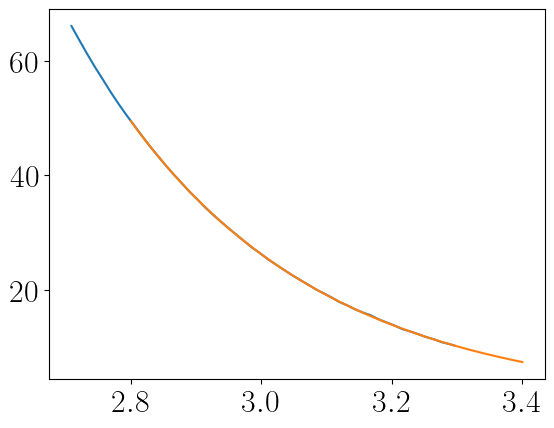

In [160]:
popt, _ = curve_fit(decay_profile, bkg_mass, bkg_yield, p0 = (60, 2.8, 0.5))
plt.plot(bkg_mass, bkg_yield)
dummy = np.linspace(2.8, 3.4, 101)
plt.plot(dummy, decay_profile(dummy, *popt))
plt.show()

In [149]:
topology_2_bkg

array([238.79307915, 213.68502495, 191.471579  , 171.78773294,
       154.31866439, 138.79224123, 124.97273706, 112.6555471 ,
       101.66273291,  91.83925612,  83.04978647,  75.17599003,
        68.11421983,  61.77354484,  56.07406405,  50.94546124,
        46.32576369,  42.16027391,  38.40064849,  35.00410236])

In [74]:
he4_rate_per_s*jpsi_rate_per_s*10**(-7)*86400*100

0.7709098243962867

In [76]:
coincidence_rate = he4_rate_per_s*jpsi_rate_per_s*10**(-7)

In [77]:
coincidence_rate

8.92256741199406e-08

In [78]:
df_background = pd.read_pickle("background.pkl") # from he4_evgen.ipynb
df_background2 = pd.read_pickle("background2.pkl") # from he4_evgen.ipynb

<Axes: >

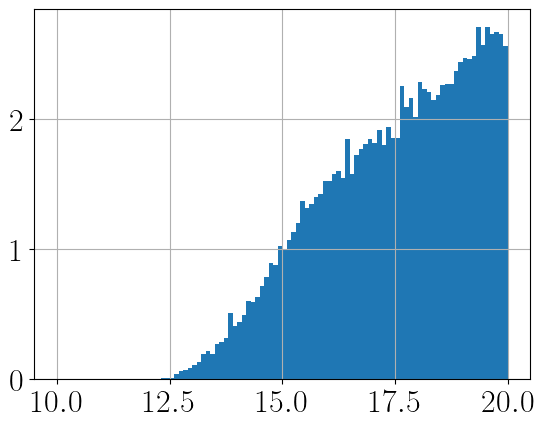

In [403]:
he4.loc[he4.topology].theta.hist(weights =he4.loc[he4.topology].weights, bins = np.linspace(10, 20, 101))

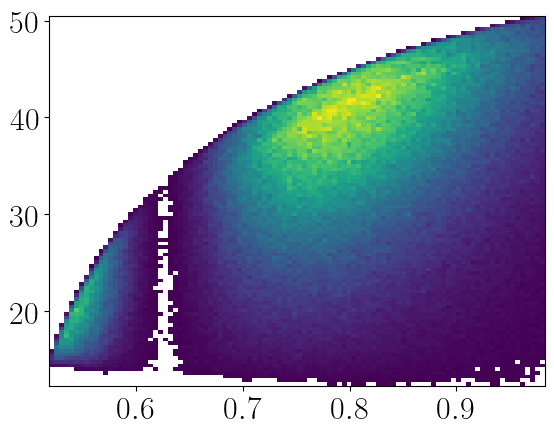

In [396]:
plt.hist2d(he4.loc[he4.topology].p, he4.loc[he4.topology].theta, bins = 100, cmin = 1)
plt.show()

In [428]:
scattered_e.loc[he4.topology_1].e.min()

0.5000013689632059

In [430]:
he4.loc[he4.topology_1].p.max()

0.9829719187905256

In [669]:
N = 10**7

accidental_electron_p      = np.random.uniform(0.5, 2, N)
accidental_electron_theta  = np.radians( np.random.uniform(np.exp(-(accidental_electron_p-0.5)/0.25)+2.5, np.exp(-(accidental_electron_p-0.5)/0.25)+4.5, N))
accidental_electron_phi    = np.random.uniform(0, 2*np.pi, N)

accidental_electron_p_smeared     = accidental_electron_p     * np.random.normal(1, np.sqrt(0.01**2+0.02**2/np.sqrt(accidental_electron_p)**2), N)
accidental_electron_theta_smeared = accidental_electron_theta * np.random.normal(1, np.sqrt(0.015), N)
accidental_electron_phi_smeared   = accidental_electron_phi   + np.random.normal(0, np.radians(2), N)

accidental_electron_px_smeared = accidental_electron_p_smeared*np.sin(accidental_electron_theta_smeared) * np.cos(accidental_electron_phi_smeared)
accidental_electron_py_smeared = accidental_electron_p_smeared*np.sin(accidental_electron_theta_smeared) * np.sin(accidental_electron_phi_smeared)
accidental_electron_pz_smeared = accidental_electron_p_smeared*np.cos(accidental_electron_theta_smeared)


accidental_he4_p      = np.random.uniform(0.2, 1, N)
accidental_he4_theta  = np.radians( np.random.uniform(12.5, theta_max(10.1, accidental_he4_p), N))
accidental_he4_phi    = np.random.uniform(0, 2*np.pi, N)

accidental_he4_p_smeared     = accidental_he4_p     * np.random.normal(1, np.sqrt(0.01**2+0.02**2/np.sqrt(accidental_he4_p)**2), N)
accidental_he4_theta_smeared = accidental_he4_theta * np.random.normal(1, np.sqrt(0.015), N)
accidental_he4_phi_smeared   = accidental_electron_phi   + np.random.normal(0, np.radians(2), N)

accidental_he4_px_smeared = accidental_he4_p_smeared*np.sin(accidental_he4_theta_smeared) * np.cos(accidental_he4_phi_smeared)
accidental_he4_py_smeared = accidental_he4_p_smeared*np.sin(accidental_he4_theta_smeared) * np.sin(accidental_he4_phi_smeared)
accidental_he4_pz_smeared = accidental_he4_p_smeared*np.cos(accidental_he4_theta_smeared)
accidental_he4_e_smeared   = np.sqrt(accidental_he4_p_smeared**2 + mHe4**2)
accidental_he4_t_smeared   = 2*mHe4*(accidental_he4_e_smeared-mHe4)

mJpsi2_smeared = (10.604 + mHe4 - accidental_electron_p_smeared - accidental_he4_e_smeared)**2 - (accidental_electron_px_smeared + accidental_he4_px_smeared)**2  - (accidental_electron_py_smeared + accidental_he4_py_smeared)**2  - (10.604 - accidental_electron_pz_smeared - accidental_he4_pz_smeared)**2 

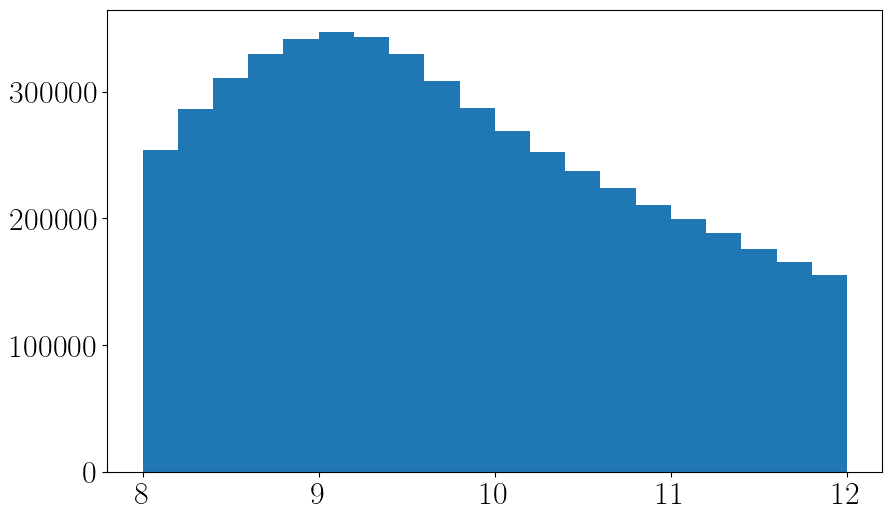

In [670]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
# hist, t_bins, jpsi_bins = np.histogram2d(accidental_he4_t_smeared, mJpsi2_smeared, bins = [np.linspace(0.2, 1, 21), np.linspace(8, 12, 21)])
# plt.hist2d(accidental_he4_t_smeared, mJpsi2_smeared, bins = [np.linspace(0.2, 1, 21), np.linspace(8, 12, 21)], cmin = 1)
# plt.show()
# hist[0, :]/np.sum(hist[0, :])
ax.hist(mJpsi2_smeared, bins = np.linspace(8, 12, 21))
plt.show()

In [645]:
df_background3.weights.max()

34.644522279590745

In [634]:
i = 0
np.sum(hist[:, i]/np.sum(mJpsi2_smeared[  (accidental_he4_t_smeared>t_bins[i]) & (accidental_he4_t_smeared<t_bins[i+1])  ] ))

0.0

In [658]:
df_background2

kgamma_smeared  mJpsi2_smeared  p_smeared  t_smeared  theta_smeared  \
4385172        9.210827        7.506361   0.501776   0.250651      24.125863   
815269         9.061369        7.672699   0.578016   0.332120      32.599073   
1266436        9.866644        7.290387   0.602942   0.361195      43.550713   
4387519        9.628206        8.137895   0.603637   0.362022      35.003270   
809616         8.797814        7.949042   0.705144   0.492863      38.288063   
...                 ...             ...        ...        ...            ...   
9887147        9.515676        8.663801   0.518891   0.267957      11.894133   
590102         8.968913       12.029261   0.818543   0.662135      12.231376   
594865         9.339857       11.776577   0.748514   0.554744      10.265111   
1645449        9.725936        9.254627   0.538155   0.288119      10.007269   
2375858        9.407369       10.851775   0.678070   0.456041      10.925309   

                p      theta         vz    weights  
4385172  0.515989  27.340666   0.719965   6.781199  
815269   0.570925  30.701561  -0.842026   0.727736  
1266436  0.616922  42.860583  15.269963   0.014410  
4387519  0.616278  33.216796   5.694162   0.010846  
809616   0.680497  36.635492  13.984120   0.112226  
...           ...        ...        ...        ...  
9887147  0.540040   6.107204  19.890749  11.632327  
590102   0.788730   2.316101  15.317229   0.278878  
594865   0.686007   2.925451  17.304863   0.312217  
1645449  0.526655   1.308272  13.236611  20.177380  
2375858  0.694307   1.249341  13.804840   0.341958  

[4654 rows x 9 columns]

In [646]:
t_profile, t_bins    = np.histogram(df_background3.loc[df_background3.theta>12.5].t_smeared, bins = np.linspace(0.2, 1, 21), weights = df_background3.loc[df_background3.theta>12.5].weights)
hist, _, _   = np.histogram2d(accidental_he4_t_smeared, mJpsi2_smeared, bins = [t_bins, np.linspace(8, 12, 21)])
jpsi_profile = 0
for i in range(len(t_bins)-1):
    jpsi_profile = jpsi_profile+ hist[i, :]/np.sum(mJpsi2_smeared[  (accidental_he4_t_smeared>t_bins[i]) & (accidental_he4_t_smeared<t_bins[i+1])  ] )*t_profile[i]# for i in range( len(t_bins)-1)]
print(jpsi_profile)

[4.10107502 4.71041489 4.82721945 4.82211347 4.73894108 4.36836264
 3.85405885 3.25370509 2.76008361 2.49827541 2.4971278  2.55901242
 2.66352862 2.73900883 2.79731637 2.79573722 2.77735661 2.73138179
 2.63889    2.49918477]


(array([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan, 13.44080843, 31.97572188,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan],
        [ 8.4026606 , 15.43122218, 17.51143361, 32.36749702, 28.36650504,
         17.86441789, 13.97999788,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,  3.09465577,         nan,  7.06220256,
          3.48479341,  2.27245443, 

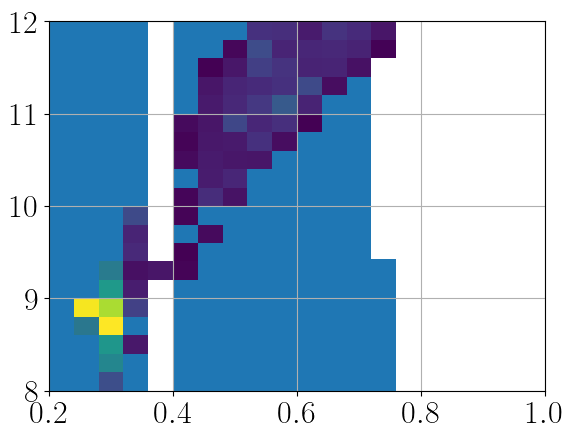

In [663]:
df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].t_smeared.hist(bins = np.linspace(0.2, 1, 21), weights = df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights)
plt.hist2d( df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].t_smeared, df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].mJpsi2_smeared,
           bins = [np.linspace(0.2, 1, 21), np.linspace(8, 12, 21)], weights = df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights, cmin = 1)
# plt.show()

In [567]:
df_background3.theta_smeared.max()

59.98583524830825

<Axes: >

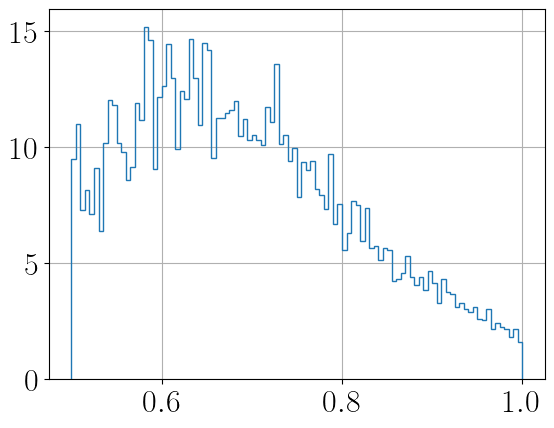

In [665]:
# df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].p.hist(bins = np.linspace(0.5, 1, 101), weights = df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights)
df_background3.t_smeared.hist(bins = np.linspace(0.5, 1, 101), weights = df_background3.weights, histtype = 'step')
# plt.show()

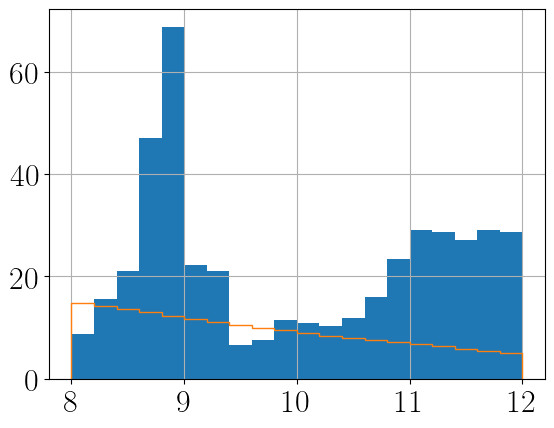

In [599]:
df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].mJpsi2_smeared.hist(bins = np.linspace(8, 12, 21), weights = df_background2.loc[(df_background2.theta_smeared>14) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights)
bck_yields = jpsi_profile
plt.hist(bins[:-1], bins = bins, histtype = 'step', weights = bck_yields , label = 'Topology 1 Background')
plt.show()

(array([14.81244702, 14.21030486, 13.64718486, 12.98252689, 12.34687692,
        11.83750377, 11.13802455, 10.50553891, 10.00600427,  9.42722587,
         9.0198228 ,  8.47224343,  8.01181589,  7.52788086,  7.15365142,
         6.71863019,  6.27096171,  5.91440279,  5.41339714,  5.06506234]),
 array([ 8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ,
        10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. ]),
 [<matplotlib.patches.Polygon at 0x4e7a095d0>])

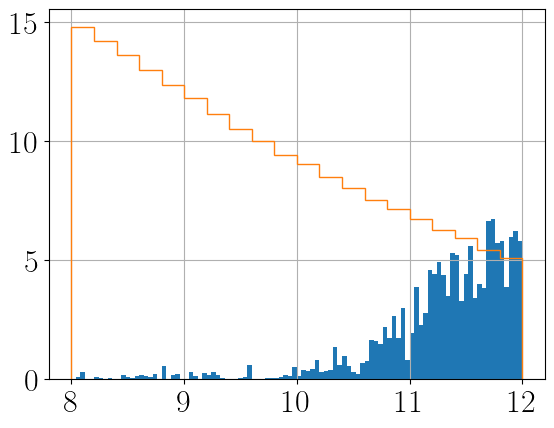

In [587]:
df_background2.loc[(df_background2.theta>12.5) & (df_background2.theta_smeared<50) & (df_background2.p > 0.5) & (df_background2.t_smeared<1)].mJpsi2_smeared.hist(bins = np.linspace(8, 12, 101), weights = df_background2.loc[(df_background2.theta>12.5) & (df_background2.theta_smeared<50) & (df_background2.p > 0.5) & (df_background2.t_smeared<1)].weights)
# df_background3.mJpsi_smeared.hist(bins = 100, weights = df_background3.weights, histtype = 'step')
bck_yields = jpsi_profile*5
plt.hist(bins[:-1], bins = bins, histtype = 'step', weights = bck_yields , label = 'Topology 1 Background')

# plt.show()

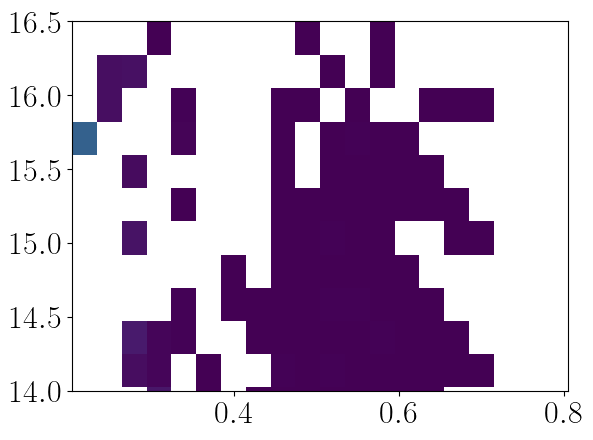

In [703]:
plt.hist2d( df_background2.loc[  (df_background2.theta_smeared>12) & (df_background2.theta_smeared<16.5) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].t_smeared, df_background2.loc[  (df_background2.theta_smeared>12) & (df_background2.theta_smeared<16.5) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].theta_smeared, bins = 20, cmin = 1, weights = df_background2.loc[  (df_background2.theta_smeared>12) & (df_background2.theta_smeared<16.5) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights)
plt.ylim([14, 16.5])
plt.show()

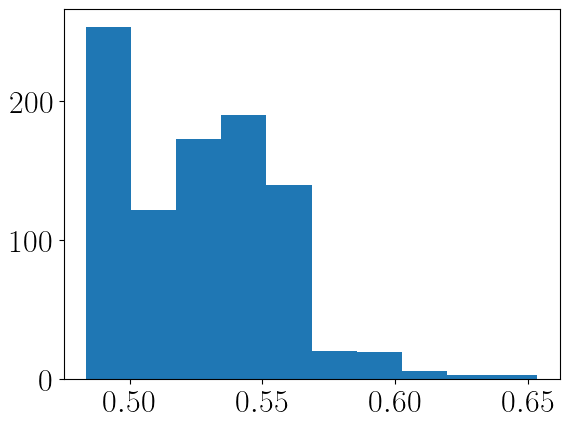

In [709]:
plt.hist( df_background2.loc[  (df_background2.mJpsi2_smeared>8.5) & (df_background2.mJpsi2_smeared<9.5) &  (df_background2.theta_smeared>12) & (df_background2.theta_smeared<16.5) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].p_smeared, bins = 10, weights = df_background2.loc[ (df_background2.mJpsi2_smeared>8.5) & (df_background2.mJpsi2_smeared<9.5) & (df_background2.theta_smeared>12) & (df_background2.theta_smeared<16.5) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights)

# plt.ylim([14, 16.5])
plt.show()

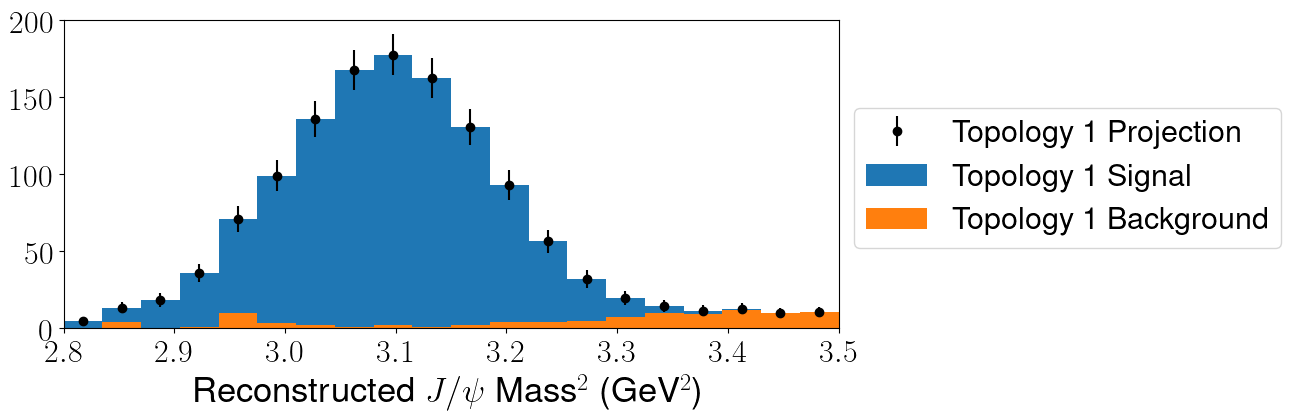

In [724]:
# plt.hist(df_background.loc[ (df_background.theta_smeared>14) & (df_background.theta_smeared<50) & (df_background.t_smeared>0.2) & (df_background.t_smeared<1)].mJpsi2_smeared, bins = np.linspace(2.8**2, 3.4**2, 21), histtype = 'step', weights = df_background.loc[ (df_background.theta_smeared>14) & (df_background.theta_smeared<50) & (df_background.t_smeared>0.2) & (df_background.t_smeared<1)].weights)
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
bins = np.linspace(2.8, 3.5, 21)
bincenters  = (bins[1:] + bins[:-1])/2.
bck_yields, _ = np.histogram(np.sqrt(df_background2.loc[ (df_background2.theta_smeared>16.5) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].mJpsi2_smeared), bins = bins, weights = df_background2.loc[ (df_background2.theta_smeared>16.5) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights)
# bck_yields = jpsi_profile*10/3
# bck_yields, _ = np.histogram(df_background2.loc[ (df_background2.theta>12.5) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].mJpsi2_smeared, bins = bins, weights = df_background2.loc[ (df_background2.theta>12.5) & (df_background2.theta_smeared<50) & (df_background2.t_smeared>0.2) & (df_background2.t_smeared<1)].weights)
topology_1_yields, _ = np.histogram(he4.loc[(he4.topology_1) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].Mjpsi_smeared, bins = bins, weights =  he4.loc[(he4.topology_1) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].weights)
topology_2_yields, _ = np.histogram(jpsi_lepton.loc[(he4.topology_2) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].Mjpsi_smeared, bins = bins, weights =  he4.loc[(he4.topology_2) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].weights)
ax.errorbar(bincenters, topology_1_yields + bck_yields, yerr = np.sqrt(topology_1_yields + bck_yields), color = 'k', ls = '', marker = 'o', label = 'Topology 1 Projection')
ax.hist(bins[:-1], bins = bins, histtype = 'stepfilled', weights = topology_1_yields + bck_yields, label = 'Topology 1 Signal')
ax.hist(bins[:-1], bins = bins, histtype = 'stepfilled', weights = bck_yields , label = 'Topology 1 Background')
handles, labels = ax.get_legend_handles_labels()
new_handles = [handles[i] for i in [2, 0, 1]]
new_labels  = [labels[i] for i in [2, 0, 1]]
plt.figlegend(handles = new_handles, labels =new_labels, loc = 'upper left', bbox_to_anchor = (0.9, 0.7))
ax.set_xlim([2.8, 3.5])
ax.set_ylim([0, 200])
ax.set_xlabel("Reconstructed $J/\psi$ Mass$^2$ (GeV$^2$)")
plt.savefig("signal_and_background.pdf_topo1.pdf", bbox_inches = 'tight')

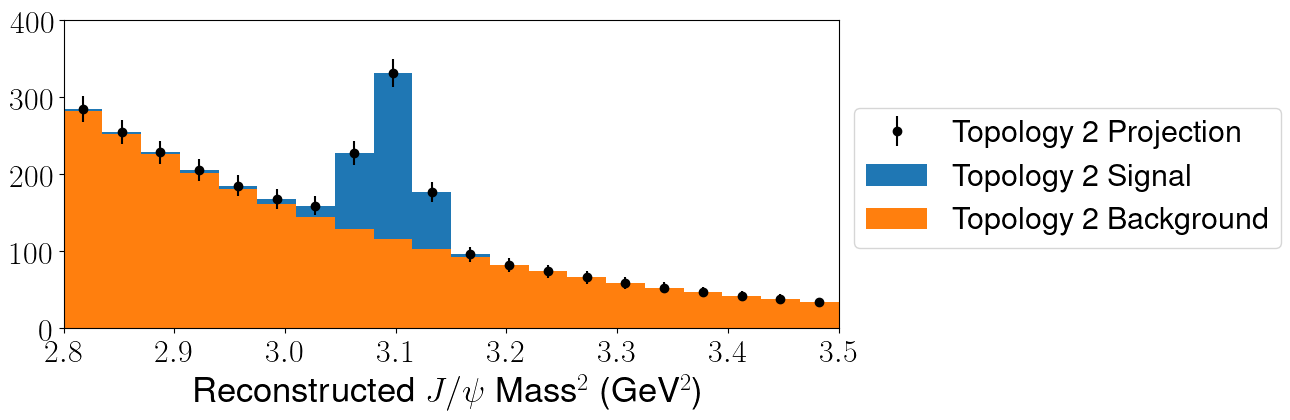

In [726]:
# plt.hist(df_background.loc[ (df_background.theta_smeared>14) & (df_background.theta_smeared<50) & (df_background.t_smeared>0.2) & (df_background.t_smeared<1)].mJpsi2_smeared, bins = np.linspace(2.8**2, 3.4**2, 21), histtype = 'step', weights = df_background.loc[ (df_background.theta_smeared>14) & (df_background.theta_smeared<50) & (df_background.t_smeared>0.2) & (df_background.t_smeared<1)].weights)
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
bins = np.linspace(2.8, 3.5, 21)
bincenters  = (bins[1:] + bins[:-1])/2.

topology_1_yields, _ = np.histogram(he4.loc[(he4.topology_1) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].Mjpsi_smeared, bins = bins, weights =  he4.loc[(he4.topology_1) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].weights)
topology_2_yields, _ = np.histogram(jpsi_lepton.loc[(he4.topology_2) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].Mjpsi_smeared, bins = bins, weights =  he4.loc[(he4.topology_2) & (he4.theta_smeared>16.5) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].weights)


bkg_topology_2 = np.sum(topology_2_yields) * bkg_rga/jpsi_rga
topology_2_bkg = decay_profile(bincenters, *popt)
topology_2_bkg = bkg_rga/jpsi_rga* np.sum(topology_2_yields) * topology_2_bkg/np.sum(topology_2_bkg)

ax.errorbar(bincenters, topology_2_yields+topology_2_bkg, yerr = np.sqrt(topology_2_yields+topology_2_bkg), color = 'k', ls = '', marker = 'o', label = 'Topology 2 Projection')
ax.hist(bins[:-1], bins = bins, histtype = 'stepfilled', weights = topology_2_yields + topology_2_bkg, label = 'Topology 2 Signal')
ax.hist(bins[:-1], bins = bins, histtype = 'stepfilled', weights = topology_2_bkg , label = 'Topology 2 Background')
handles, labels = ax.get_legend_handles_labels()
new_handles = [handles[i] for i in [2, 0, 1]]
new_labels  = [labels[i] for i in [2, 0, 1]]
plt.figlegend(handles = new_handles, labels =new_labels, loc = 'upper left', bbox_to_anchor = (0.9, 0.7))
ax.set_xlim([2.8, 3.5])
ax.set_ylim([0, 400])
ax.set_xlabel("Reconstructed $J/\psi$ Mass$^2$ (GeV$^2$)")
plt.savefig("signal_and_background.pdf_topo2.pdf", bbox_inches = 'tight')

In [192]:
legends

NameError: name 'legends' is not defined

In [784]:
len(df_background.loc[ (df_background.theta_smeared>14) & (df_background.theta_smeared<50) & (df_background.t_smeared>0.2) & (df_background.t_smeared<1)].mJpsi2_smeared)

68

In [768]:
np.sum(df_background.loc[(df_background.theta_smeared>14) & (df_background.theta_smeared<50)].weights)

85660.25318587325

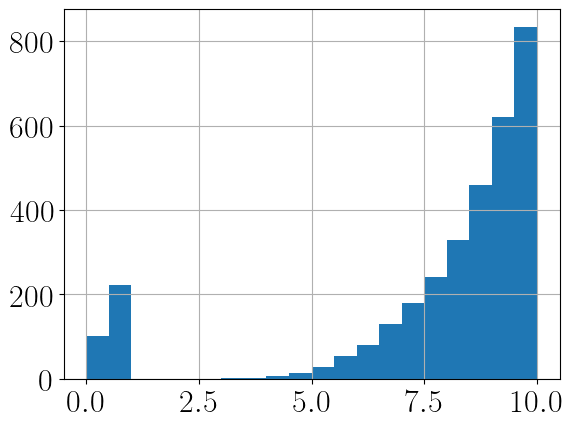

In [782]:
# df_background.mJpsi2_smeared.hist(weights = df_background.weights, bins = np.linspace(2.8**2, 3.4**2, 21))
# df_background.theta_smeared.hist(weights = df_background.weights, bins = np.linspace(14, 60, 21))
df_background.loc[df_background.theta_smeared>14].t_smeared.hist(weights = df_background.loc[df_background.theta_smeared>14].weights, bins = np.linspace(0, 10, 21))
plt.show()

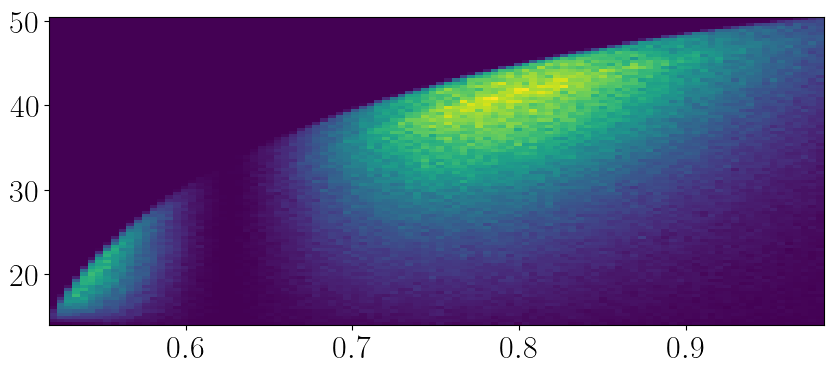

In [195]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.hist2d(he4.loc[(he4.topology) & (he4.theta>14) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].p, he4.loc[(he4.topology) & (he4.theta>14) & (he4.t_smeared>0.2) & (he4.t_smeared<2)].theta, bins = 100)
plt.show()

## Detector Study

In [31]:
raster = 0#np.random.uniform(0, 1, len(he4))
costheta = np.random.uniform(-1, 1, len(he4))
phi = np.random.uniform(0, 2*np.pi, len(he4))
he4.loc[:, "vx"] = raster * np.sqrt(1-costheta**2) * np.cos(phi)
he4.loc[:, "vy"] = raster * np.sqrt(1-costheta**2) * np.sin(phi)
he4.loc[:, "vz"] = 35/2.*costheta

In [32]:
def fiducial(df, offset = 20, power = 0.3, start = 5):
    df = df.loc[df.theta>start,:]
    df = df.loc[df.theta<35, :]
    df.loc[:, "sector"] = ((df.phi+offset +np.where(df.phi+offset >0, 0, 360))//60 + 1)
    df.loc[:, "sector_center"] = 60* ((df.phi+offset)//60) + 30 - offset
    return df.loc[np.abs(df.phi - df.sector_center) < 28*(df.theta-start)**power/(30)**power, :]

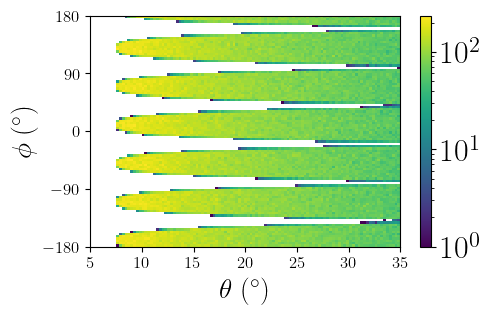

In [33]:
fig ,ax = plt.subplots(1, 1, figsize = (5, 3))
power = 0.3
h = plt.hist2d(fiducial(jpsi_lepton, power =power, start = 7.5).loc[:, "theta"], fiducial(jpsi_lepton, power =power, start = 7.5).loc[:, "phi"], bins = 100, cmin = 1, norm = LogNorm(), rasterized = True)
plt.colorbar(h[3])
# plt.xlim([5, 35])
# plt.show()

# plt.hist2d(df_pi0.GenEtheta, df_pi0.GenEphi, bins = 100, cmin = 1)
plt.xlim([5, 35])
ax.set_xlabel(r"$\theta~(^{\circ})$" , size = 20)
ax.set_ylabel(r"$\phi~(^{\circ})$", size = 20)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_yticks([-180, -90, 0, 90, 180])
plt.show()

In [39]:
lepton_cond = jpsi_lepton.index.isin(fiducial(jpsi_lepton, offset = 20).index)

In [40]:
scattered_e_cond = scattered_e.index.isin(fiducial(scattered_e, offset = 20).index)

In [41]:
antilepton_cond = jpsi_antilepton.index.isin(fiducial(jpsi_antilepton, offset = 40).index)

In [42]:
# Rh = pt/qBc
# W   = qBc/E
# T    = (35/2. - vz)/ (pz/E c)
# theta = WT
# v_transverse + transverse displacement at leaving = 
he4.loc[:, "vz"] = np.random.uniform(-20, 20, len(he4))
he4.loc[:, "vx"] = 0#np.random.uniform(-20, 20, len(he4))
he4.loc[:, "vy"] = 0#np.random.uniform(-20, 20, len(he4))
c = 3e8
B = 5
he4_rhelix = he4.pt*10**9/2/B/c
he4_omega  = 2*B*c**2/he4.e/10**9
he4_time   = (20 - he4.vz)*0.01/(he4.pz/he4.e*c)
he4_theta  = he4_omega * he4_time
he4_betat  = he4.pt/he4.e
he4_transverse_displacement = he4_rhelix*2*np.sin(he4_theta/2)

d_v = np.sqrt(he4.vx**2 + he4.vy**2)*0.01
costheta_v = 0.01*(he4.vx*he4.px + he4.vy*he4.py)/d_v/he4.pt

d_helix = he4_transverse_displacement#np.sqrt(he4_transverse_displacement**2 + d_v**2 + 2*he4_transverse_displacement*d_v*costheta_v)
he4_transverse_displacement_line = he4.pt/he4.e * c * he4_time
d_line  = he4_transverse_displacement_line#np.sqrt(he4_transverse_displacement_line**2 + d_v**2 + 2*he4_transverse_displacement_line*d_v*costheta_v)

# d_helix.hist(bins = 100, histtype = 'step')
# d_line.hist(bins = 100, histtype = 'step')
# plt.show()

In [5]:
total_xsec = he4.loc[he4.total_xsec>0, "total_xsec"].mean()
accepted_xsec = he4.loc[he4.accepted_xsec>0, "accepted_xsec"].mean()

In [6]:
total_xsec

4.68582128e-05

In [47]:
he4_cond = he4.index.isin(he4.loc[d_helix > 0.08, :].index)
scattered_e_cond_ft = (scattered_e.p>0.5) & (scattered_e.theta>2.5) & (scattered_e.theta<4.5)
scattered_e_cond_ft_trigger = scattered_e_cond_ft
scattered_e_cond_fd = (scattered_e.index.isin(fiducial(scattered_e, offset = 20).index) ) & (scattered_e.p > 0.7)
jpsi_lepton_cond_fd = (jpsi_lepton.index.isin(fiducial(jpsi_lepton, offset = 20).index) ) & (jpsi_lepton.p > 0.7)
jpsi_lepton_cond_fd_trigger = (jpsi_lepton.index.isin(fiducial(jpsi_lepton, offset = 20).index) ) & (jpsi_lepton.p > 2)
jpsi_lepton_cond_ft = (jpsi_lepton.p>0.5) & (jpsi_lepton.theta>2.5) & (jpsi_lepton.theta<5)
jpsi_lepton_cond_ft_trigger = jpsi_lepton_cond_ft
jpsi_antilepton_cond_fd = (jpsi_antilepton.index.isin(fiducial(jpsi_antilepton, offset = 40).index) ) & (jpsi_antilepton.p > 0.7)
jpsi_antilepton_cond_fd_trigger = (jpsi_antilepton.index.isin(fiducial(jpsi_antilepton, offset = 40).index) ) & (jpsi_antilepton.p > 2)
jpsi_antilepton_cond_ft = (jpsi_antilepton.p>0.5) & (jpsi_antilepton.theta>2.5) & (jpsi_antilepton.theta<5)
jpsi_antilepton_cond_ft_trigger = jpsi_antilepton_cond_ft

In [48]:
target_thickness = 6.02*10**23*7*40/(82.05*300)/(1.6e-19)
luminosity = target_thickness*(200*10**-9)

In [49]:
luminosity_to_nb = luminosity * 1e-24 * 1e-9

In [323]:
luminosity_to_nb

NameError: name 'luminosity_to_nb' is not defined

In [76]:
#scenario_1
integrated_lumi = 60/4.*86400*10 + 30/4.*86400*20
integrated_lumi_extended = integrated_lumi + 85*86400*100
scattered_e_cond = scattered_e_cond_ft_trigger
scenario1_rate = np.sum(scattered_e_cond & he4_cond)/len(he4)
xsec = scenario1_rate * total_xsec
scenario1_event_num = xsec*integrated_lumi
scenario1_event_num_extended = xsec*integrated_lumi_extended
print(scenario1_rate*100, scenario1_event_num, scenario1_event_num_extended)

1.1488500000000001 13.953528575352575 409.30350487700883


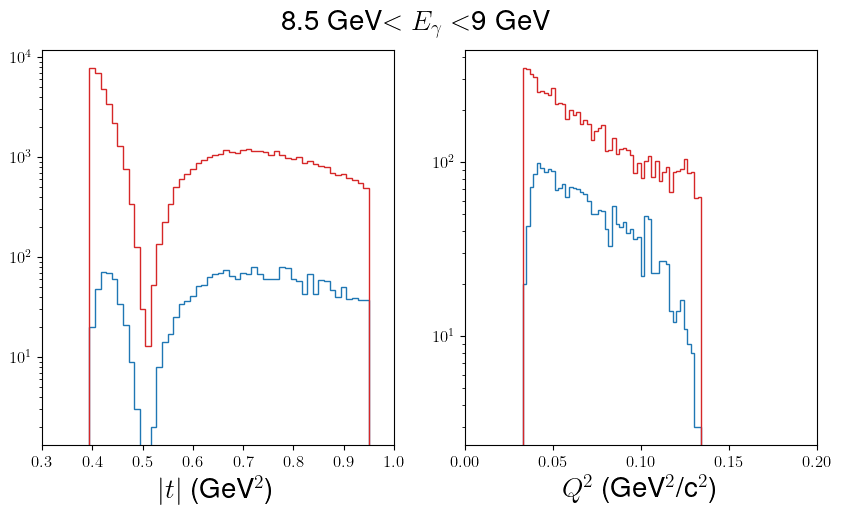

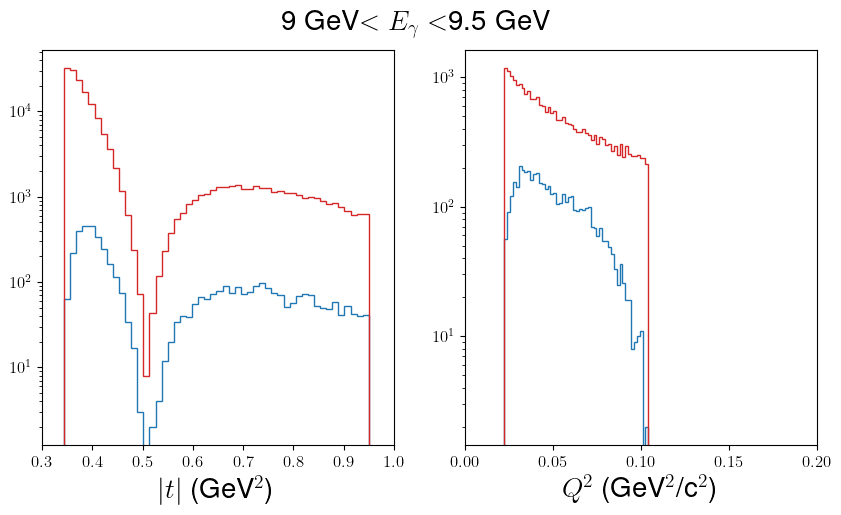

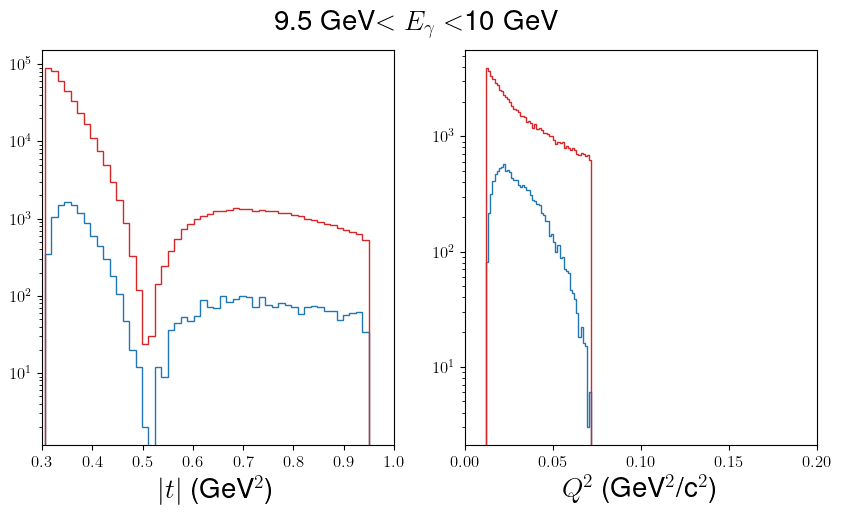

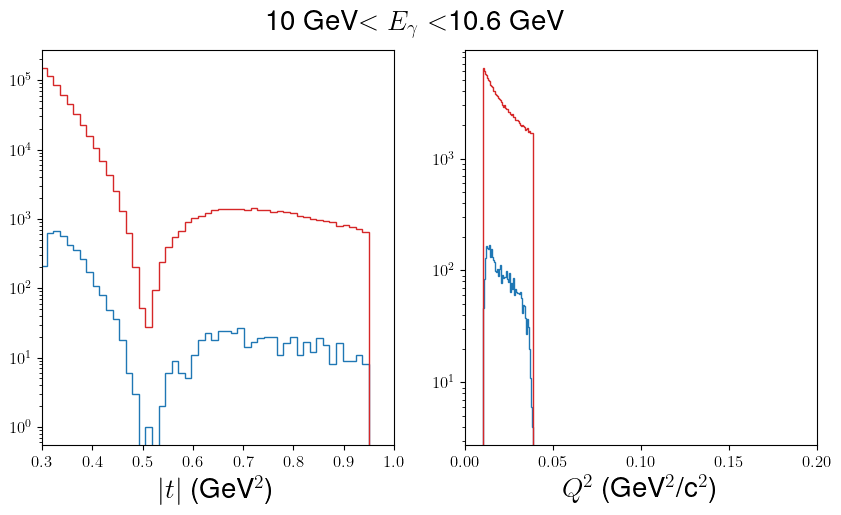

In [69]:
Egmin = 8.5
Egmax = 9
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>=Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(top=0.9)

hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')
hist, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')

hist, bins = np.histogram(scattered_e.loc[scenario1_cond, :].Q2, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[scenario1_cond,:]))/len(scattered_e.loc[scenario1_cond, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')

hist, bins = np.histogram(scattered_e.loc[e_gamma_cond, :].Q2, bins = bins)# weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[:,:]))/len(scattered_e.loc[:, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')

fig.suptitle("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

for ax in axs:
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yscale('log')

axs[0].set_xlim([0.3, 1])
axs[1].set_xlim([0, 0.2])

axs[0].set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 20)
axs[1].set_xlabel(r"$Q^2$" + " (GeV"+r"$^2$"+"/c"+r"$^2$" +")", size = 20)

plt.show()

Egmin = 9
Egmax = 9.5
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>=Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(top=0.9)

hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')
hist, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')

hist, bins = np.histogram(scattered_e.loc[scenario1_cond, :].Q2, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[scenario1_cond,:]))/len(scattered_e.loc[scenario1_cond, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')

hist, bins = np.histogram(scattered_e.loc[e_gamma_cond, :].Q2, bins = bins)# weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[:,:]))/len(scattered_e.loc[:, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')

fig.suptitle("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

for ax in axs:
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yscale('log')

axs[0].set_xlim([0.3, 1])
axs[1].set_xlim([0, 0.2])

axs[0].set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 20)
axs[1].set_xlabel(r"$Q^2$" + " (GeV"+r"$^2$"+"/c"+r"$^2$" +")", size = 20)

plt.show()

Egmin = 9.5
Egmax = 10
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>=Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(top=0.9)

hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')
hist, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')

hist, bins = np.histogram(scattered_e.loc[scenario1_cond, :].Q2, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[scenario1_cond,:]))/len(scattered_e.loc[scenario1_cond, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')

hist, bins = np.histogram(scattered_e.loc[e_gamma_cond, :].Q2, bins = bins)# weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[:,:]))/len(scattered_e.loc[:, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')

fig.suptitle("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

for ax in axs:
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yscale('log')

axs[0].set_xlim([0.3, 1])
axs[1].set_xlim([0, 0.2])

axs[0].set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 20)
axs[1].set_xlabel(r"$Q^2$" + " (GeV"+r"$^2$"+"/c"+r"$^2$" +")", size = 20)

# plt.tight_layout()
plt.show()


Egmin = 10
Egmax = 10.6
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>=Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(top=0.9)

hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue', label = 'Detected w/ perfect resolution')
hist, bins = np.histogram(he4.loc[e_gamma_cond, :].t, bins = bins)#, weights =scenario1_event_num_extended* np.ones(len(he4.loc[scenario1_cond,:]))/len(he4.loc[scenario1_cond, :]) )
axs[0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red', label = 'Generated')

hist, bins = np.histogram(scattered_e.loc[scenario1_cond, :].Q2, bins = 50)#, weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[scenario1_cond,:]))/len(scattered_e.loc[scenario1_cond, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:blue')

hist, bins = np.histogram(scattered_e.loc[e_gamma_cond, :].Q2, bins = bins)# weights =scenario1_event_num_extended* np.ones(len(scattered_e.loc[:,:]))/len(scattered_e.loc[:, :]) )
axs[1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step', color = 'tab:red')

fig.suptitle("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)

for ax in axs:
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yscale('log')

axs[0].set_xlim([0.3, 1])
axs[1].set_xlim([0, 0.2])

axs[0].set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 20)
axs[1].set_xlabel(r"$Q^2$" + " (GeV"+r"$^2$"+"/c"+r"$^2$" +")", size = 20)

# plt.figlegend(fontsize = 20, bbox_to_anchor = (1.5, 0.9))
# plt.tight_layout()
plt.show()


In [87]:
np.ones(len(he4))/len(he4)*integrated_lumi_extended*total_xsec

array([0.01781362, 0.01781362, 0.01781362, ..., 0.01781362, 0.01781362,
       0.01781362])

float64


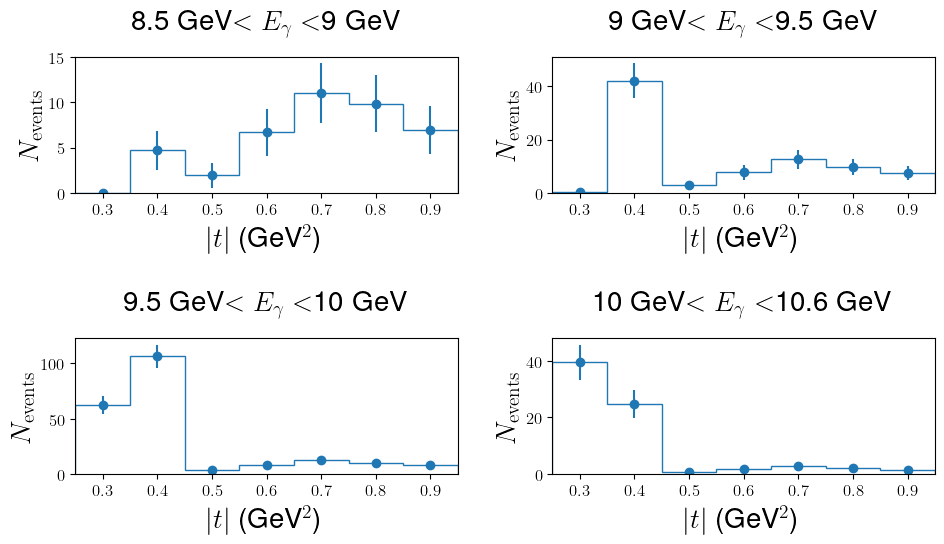

In [114]:
bins = [0.3, 0.4, 0.6, 0.8]
bins = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
# bins = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

he4.loc[:, "weights"] = np.ones(len(he4))/len(he4)*integrated_lumi_extended*total_xsec

fig, axs = plt.subplots(2, 2, figsize = (10, 6))
hists = 0
Egmin = 8.5
Egmax = 9
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond
scenario1_rate = np.sum(scenario1_cond)/len(he4_cond)
xsec = scenario1_rate * total_xsec
scenario1_event_num = xsec*integrated_lumi
scenario1_event_num_extended = xsec*integrated_lumi_extended

hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = bins, weights = he4.loc[scenario1_cond, "weights"])
hist = hist.astype(float)
hists = hists + hist
axs[0, 0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
axs[0, 0].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
bincenters = (bins[:-1] + bins[1:])/2.
print(hist.dtype)
axs[0, 0].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

Egmin = 9
Egmax = 9.5
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>=Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond
scenario1_rate = np.sum(scenario1_cond)/len(he4_cond)
xsec = scenario1_rate * total_xsec
scenario1_event_num = xsec*integrated_lumi
scenario1_event_num_extended = xsec*integrated_lumi_extended

hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = bins, weights = he4.loc[scenario1_cond, "weights"] )
hist = hist.astype(float)
hists = hists + hist
axs[0, 1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
axs[0, 1].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
bincenters = (bins[:-1] + bins[1:])/2.
axs[0, 1].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

Egmin = 9.5
Egmax = 10
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond
scenario1_rate = np.sum(scenario1_cond)/len(he4_cond)
xsec = scenario1_rate * total_xsec
scenario1_event_num = xsec*integrated_lumi
scenario1_event_num_extended = xsec*integrated_lumi_extended
hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = bins, weights = he4.loc[scenario1_cond, "weights"] )
hist = hist.astype(float)
hists = hists + hist
axs[1, 0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
axs[1, 0].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
bincenters = (bins[:-1] + bins[1:])/2.
axs[1, 0].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

Egmin = 10
Egmax = 10.6
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
scenario1_cond = scattered_e_cond & he4_cond & e_gamma_cond
scenario1_rate = np.sum(scenario1_cond)/len(he4_cond)
xsec = scenario1_rate * total_xsec
scenario1_event_num = xsec*integrated_lumi
scenario1_event_num_extended = xsec*integrated_lumi_extended
hist, bins = np.histogram(he4.loc[scenario1_cond, :].t, bins = bins, weights = he4.loc[scenario1_cond, "weights"] )
hist = hist.astype(float)
hists = hists + hist
axs[1, 1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
axs[1, 1].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
bincenters = (bins[:-1] + bins[1:])/2.
axs[1, 1].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

for ax in axs.flatten():
    ax.set_xlim([0.25, 0.95])
    ax.set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 20)
    ax.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_ylim(bottom = 0)
plt.tight_layout()
plt.show()


In [61]:
#scenario_2
scattered_e_cond = scattered_e_cond_ft_trigger
jpsi_lepton_cond    = jpsi_lepton_cond_ft | jpsi_lepton_cond_fd
jpsi_antilepton_cond    = jpsi_antilepton_cond_ft | jpsi_antilepton_cond_fd
scenario2_rate = np.sum(scattered_e_cond & jpsi_lepton_cond & jpsi_antilepton_cond)/len(he4_cond)
xsec = scenario2_rate * accepted_xsec
scenario2_event_num = xsec*integrated_lumi
scenario2_event_num_extended = xsec*integrated_lumi_extended
print(100*scenario2_rate, scenario2_event_num, scenario2_event_num_extended)

1.04495 0.7560350492395465 22.177028111026697


In [62]:
#scenario_3
scattered_e_cond = scattered_e_cond_ft | scattered_e_cond_fd
jpsi_lepton_cond_trigger = jpsi_lepton_cond_fd_trigger | jpsi_lepton_cond_ft_trigger
jpsi_lepton_cond         = jpsi_lepton_cond_fd         | jpsi_lepton_cond_ft
jpsi_antilepton_cond_trigger = jpsi_antilepton_cond_fd_trigger | jpsi_antilepton_cond_ft_trigger
jpsi_antilepton_cond         = jpsi_antilepton_cond_fd         | jpsi_antilepton_cond_ft
jpsi_cond             = (jpsi_lepton_cond & jpsi_antilepton_cond_trigger) | (jpsi_lepton_cond_trigger & jpsi_antilepton_cond)


scenario3_rate = np.sum(scattered_e_cond & jpsi_cond)/len(he4_cond)
xsec = scenario3_rate * accepted_xsec
scenario3_event_num = xsec*integrated_lumi
scenario3_event_num_extended = xsec*integrated_lumi_extended
print(100*scenario3_rate, scenario3_event_num, scenario3_event_num_extended)

1.49745 1.0834247423166263 31.780459107954375


In [63]:
#scenario_4
jpsi_lepton_cond_trigger = jpsi_lepton_cond_fd_trigger | jpsi_lepton_cond_ft_trigger
jpsi_lepton_cond         = jpsi_lepton_cond_fd         | jpsi_lepton_cond_ft
jpsi_antilepton_cond_trigger = jpsi_antilepton_cond_fd_trigger | jpsi_antilepton_cond_ft_trigger
jpsi_antilepton_cond         = jpsi_antilepton_cond_fd         | jpsi_antilepton_cond_ft
jpsi_cond             = (jpsi_lepton_cond & jpsi_antilepton_cond_trigger) | (jpsi_lepton_cond_trigger & jpsi_antilepton_cond)


scenario4_rate = np.sum(he4_cond & jpsi_cond)/len(he4_cond)
xsec = scenario4_rate * accepted_xsec
scenario4_event_num = xsec*integrated_lumi
scenario4_event_num_extended = xsec*integrated_lumi_extended
print(100*scenario4_rate, scenario4_event_num, scenario4_event_num_extended)

6.02595 4.359853969055979 127.88904975897537


<ErrorbarContainer object of 3 artists>

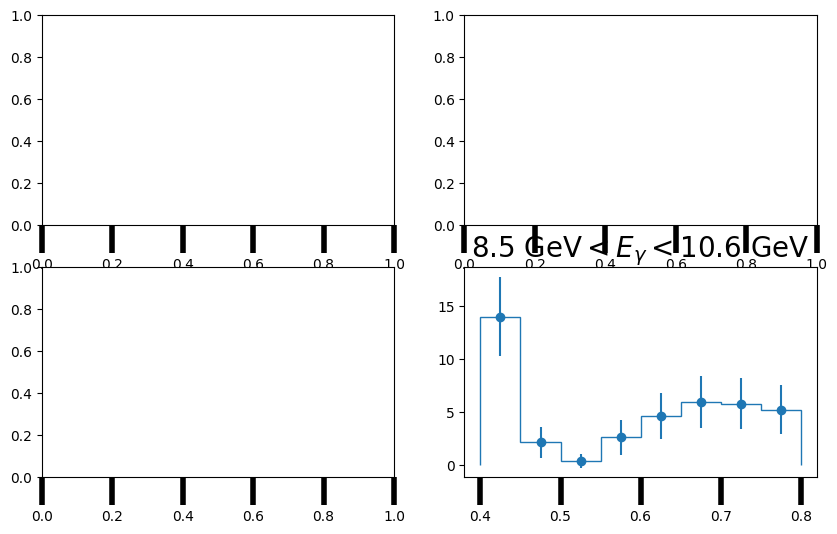

In [156]:
bins = [0.3, 0.4, 0.6, 0.8]
bins = [0.3, 0.35, 0.4, 0.5, 0.6, 0.8]
bins = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

fig, axs = plt.subplots(2, 2, figsize = (10, 6))

# Egmin = 8.5
# Egmax = 9
# e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
# scenario4_cond = scattered_e_cond & he4_cond & e_gamma_cond
# scenario4_rate = np.sum(scenario4_cond)/len(he4_cond)
# xsec = scenario4_rate * total_xsec
# scenario4_event_num = xsec*integrated_lumi
# scenario4_event_num_extended = xsec*integrated_lumi_extended

# hist, bins = np.histogram(he4.loc[scenario4_cond, :].t, bins = bins, weights =scenario4_event_num_extended* np.ones(len(he4.loc[scenario4_cond,:]))/len(he4.loc[scenario4_cond, :]) )
# axs[0, 0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
# axs[0, 0].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
# bincenters = (bins[:-1] + bins[1:])/2.
# axs[0, 0].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

# Egmin = 9
# Egmax = 9.5
# e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>=Egmin)
# scenario4_cond = scattered_e_cond & he4_cond & e_gamma_cond
# scenario4_rate = np.sum(scenario4_cond)/len(he4_cond)
# xsec = scenario4_rate * total_xsec
# scenario4_event_num = xsec*integrated_lumi
# scenario4_event_num_extended = xsec*integrated_lumi_extended

# hist, bins = np.histogram(he4.loc[scenario4_cond, :].t, bins = bins, weights =scenario4_event_num_extended* np.ones(len(he4.loc[scenario4_cond,:]))/len(he4.loc[scenario4_cond, :]) )
# axs[0, 1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
# axs[0, 1].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
# bincenters = (bins[:-1] + bins[1:])/2.
# axs[0, 1].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

# Egmin = 9.5
# Egmax = 10
# e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
# scenario4_cond = scattered_e_cond & he4_cond & e_gamma_cond
# scenario4_rate = np.sum(scenario4_cond)/len(he4_cond)
# xsec = scenario4_rate * total_xsec
# scenario4_event_num = xsec*integrated_lumi
# scenario4_event_num_extended = xsec*integrated_lumi_extended
# hist, bins = np.histogram(he4.loc[scenario4_cond, :].t, bins = bins, weights =scenario4_event_num_extended* np.ones(len(he4.loc[scenario4_cond,:]))/len(he4.loc[scenario4_cond, :]) )
# axs[1, 0].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
# axs[1, 0].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
# bincenters = (bins[:-1] + bins[1:])/2.
# axs[1, 0].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

Egmin = 8.5
Egmax = 10.6
e_gamma_cond = (10.604-scattered_e.e<Egmax) & (10.604-scattered_e.e>Egmin)
scenario4_cond = scattered_e_cond & he4_cond & e_gamma_cond
scenario4_rate = np.sum(scenario4_cond)/len(he4_cond)
xsec = scenario4_rate * total_xsec
# scenario4_event_num = xsec*integrated_lumi
# scenario4_event_num_extended = xsec*integrated_lumi_extended
hist, bins = np.histogram(he4.loc[scenario4_cond, :].t, bins = bins, weights =scenario4_event_num_extended* np.ones(len(he4.loc[scenario4_cond,:]))/len(he4.loc[scenario4_cond, :]) )
axs[1, 1].hist(bins[:-1], bins = bins, weights=hist, histtype = 'step')
axs[1, 1].set_title("{} GeV".format(Egmin) + r"$<E_{\gamma}<$" + "{} GeV".format(Egmax), fontsize = 20)
bincenters = (bins[:-1] + bins[1:])/2.
axs[1, 1].errorbar(bincenters, hist, yerr =np.sqrt(hist), ls = '', marker = 'o', color = 'tab:blue')

# for ax in axs.flatten():
#     ax.set_xlim([0.3, 0.8])
#     ax.set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 20)
#     ax.set_ylabel(r"$N_{\mathrm{events}}$", size = 20)
#     ax.xaxis.set_tick_params(labelsize=12)
#     ax.yaxis.set_tick_params(labelsize=12)
#     ax.set_ylim(bottom = 0)
# plt.tight_layout()
# plt.show()


In [106]:
#scenario_5
scattered_e_cond = scattered_e_cond_ft_trigger
jpsi_ele_cond    = jpsi_ele_cond_ft | jpsi_ele_cond_fd
jpsi_pos_cond    = jpsi_pos_cond_ft | jpsi_pos_cond_fd


scenario5_rate = np.sum(scattered_e_cond & jpsi_ele_cond & jpsi_pos_cond & he4_cond)/len(he4_cond)
xsec = scenario5_rate * accepted_xsec
scenario5_event_num = xsec*integrated_lumi
scenario5_event_num_extended = xsec*integrated_lumi_extended
print(100*scenario5_rate, scenario5_event_num, scenario5_event_num_extended)

0.22185 0.6435572868866303 5.148458295093042


In [107]:
#scenario_6
scattered_e_cond = scattered_e_cond_ft | scattered_e_cond_fd
jpsi_ele_cond_trigger = jpsi_ele_cond_fd_trigger | jpsi_ele_cond_ft_trigger
jpsi_ele_cond         = jpsi_ele_cond_fd         | jpsi_ele_cond_ft
jpsi_pos_cond_trigger = jpsi_pos_cond_fd_trigger | jpsi_pos_cond_ft_trigger
jpsi_pos_cond         = jpsi_pos_cond_fd         | jpsi_pos_cond_ft
jpsi_cond             = (jpsi_ele_cond & jpsi_pos_cond_trigger) | (jpsi_ele_cond_trigger & jpsi_pos_cond)


scenario6_rate = np.sum(scattered_e_cond & jpsi_cond & he4_cond)/len(he4_cond)
xsec = scenario6_rate * accepted_xsec
scenario6_event_num = xsec*integrated_lumi
scenario6_event_num_extended = xsec*integrated_lumi_extended
print(100*scenario6_rate, scenario6_event_num, scenario6_event_num_extended)

0.34195 0.9919513826949886 7.935611061559909


In [108]:
print(scenario1_event_num + scenario2_event_num + scenario3_event_num + scenario4_event_num)

30.116393921260567


In [109]:
np.sum(jpsi_ele_cond_trigger&jpsi_pos_cond)

457816

In [110]:
he4_detected = he4.loc[(he4_cond) & scattered_ele_cond, :]
xsec = he4.total_xsec.mean() * scenario1_rate
lumi = 30
xsec*lumi*86400*30

5.946509631799296

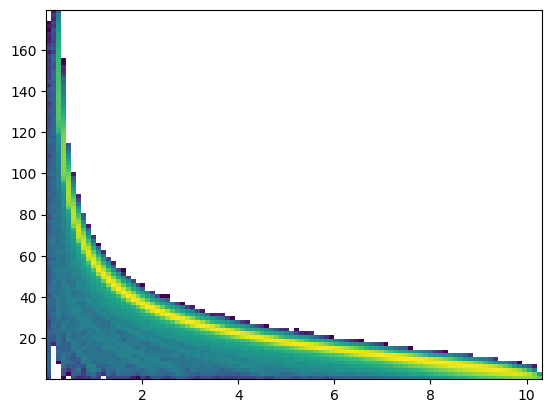

In [111]:
plt.hist2d(jpsi_pos.p, jpsi_pos.theta, bins = 100, cmin = 1, norm = LogNorm())
plt.show()

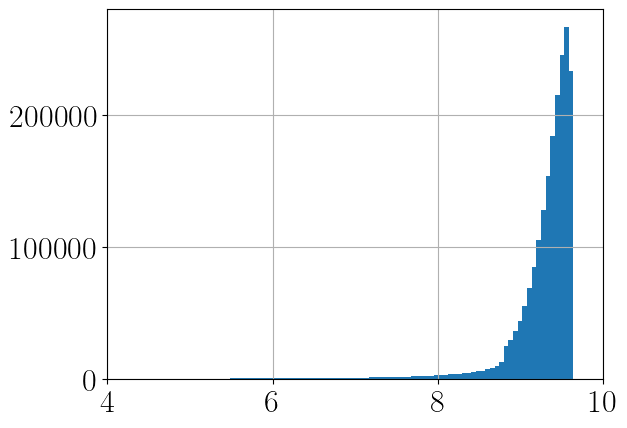

In [231]:
he4.W.hist(bins = 100)
plt.xlim([4, 10])
plt.show()

In [113]:
he4.accepted_xsec.mean()

2.7979038799999996e-06

In [114]:
xsec = he4.accepted_xsec.mean() * len(he4_detected)/len(he4)* 10**(-9)* 10**(-24)
lumi = 3*10**34
xsec*lumi*86400*55

10.624079967520695

In [115]:
xsec = he4.accepted_xsec.mean() * len(he4_detected)/len(he4)* 10**(-9)* 10**(-24)
lumi = 3*10**34
xsec*lumi*86400*55

10.624079967520695

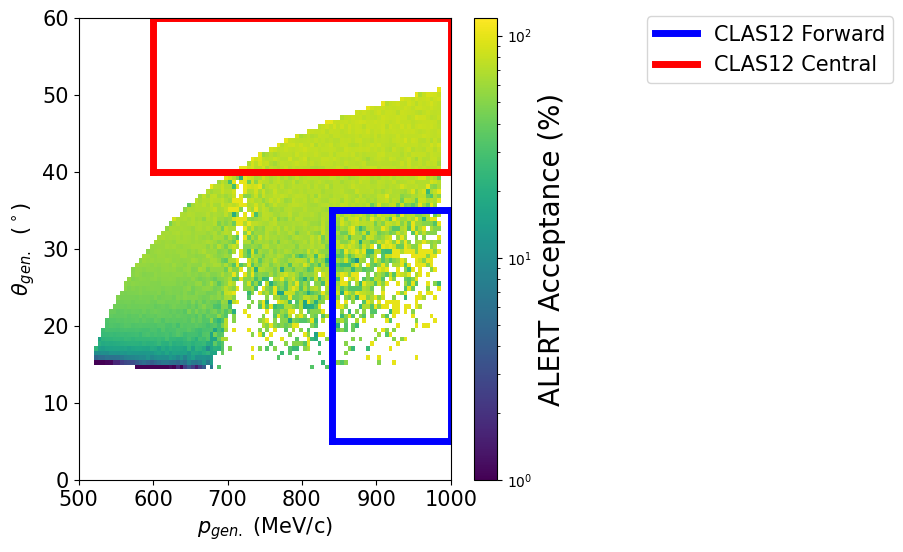

In [123]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
#ax.hist2d(1000*he4.ke, he4.theta, bins = [[30, 65, 130], [0, 22, 42, 58]], cmin = 1)
histogram_he4_1, xedges, yedges = np.histogram2d(1000*he4[he4_cond].p, he4[he4_cond].theta, bins = [np.linspace(500, 1000, 101), np.linspace(0, 60, 101)])
histogram_he4_1 = histogram_he4_1.T
histogram_he4_2, xedges, yedges = np.histogram2d(1000*he4.p, he4.theta, bins = [np.linspace(500, 1000, 101), np.linspace(0, 60, 101)])
histogram_he4_2 = histogram_he4_2.T
histogram_he4 = 100*np.divide(histogram_he4_1, histogram_he4_2, where = histogram_he4_2!=0, out=np.zeros_like(histogram_he4_2))
h = ax.imshow(histogram_he4, interpolation='none', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],aspect='auto', norm = LogNorm(vmin = 1, vmax = 120))
cbar = plt.colorbar(h, ax = ax)
cbar.set_label("ALERT Acceptance (%)", fontsize = 20)
ax.set_ylabel(r"$\theta_{gen.}~~(^\circ)$", fontsize = 15)
ax.set_xlabel(r"$p_{gen.}~ (\mathrm{MeV/c})$", fontsize = 15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
def draw_box(ax, xstart, xend, ystart, yend, color = 'k', label = '', linewidth = 5):
    dummy = np.linspace(0, 1, 101)
    ax.plot(xstart + (xend - xstart)*dummy, ystart + 0*dummy, color = color, label = label, linewidth = linewidth)
    ax.plot(xstart + (xend - xstart)*dummy, yend + 0*dummy, color = color,linewidth = linewidth)
    ax.plot(xend + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)
    ax.plot(xstart + 0*dummy, ystart + (yend-ystart)*dummy, color = color,linewidth = linewidth)

draw_box(ax, 840, 1000, 5, 35, color = 'b', label = 'CLAS12 Forward')

draw_box(ax, 600, 1000, 40, 60, color = 'r', label = 'CLAS12 Central')
he4_p = np.linspace(0.5, 1, 101)
minimum_pt = 1/12
maximum_pz = np.sqrt(he4_p**2 - minimum_pt**2)
minimum_angle = np.degrees(np.arctan(minimum_pt/maximum_pz))
# plt.plot(he4_p*1000, minimum_angle, color = 'k', label = 'ALERT if infinitely long',linewidth = 5)

plt.figlegend(bbox_to_anchor = (1.5, .9), fontsize = 15)
# plt.tight_layout()


# draw_box(ax, 37, 65, 20, 40)
# draw_box(ax, 70, 128, 25, 50)
plt.show()

In [124]:
histogram_he4.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

(array([9501.,  145.,   87.,   68.,   55.,   34.,   38.,   27.,   25.,
          20.]),
 array([   0. ,  159.9,  319.8,  479.7,  639.6,  799.5,  959.4, 1119.3,
        1279.2, 1439.1, 1599. ]),
 <BarContainer object of 10 artists>)

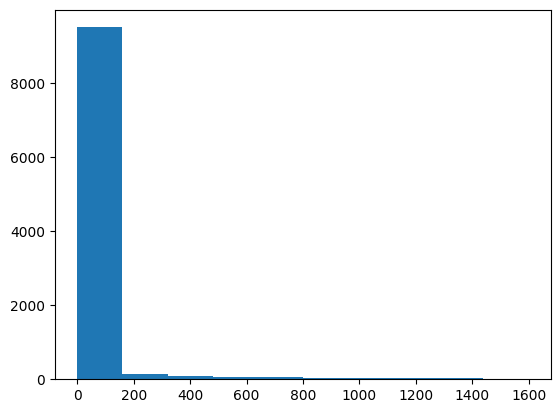

In [125]:
plt.hist(histogram_he4_1.flatten())

(array([9094.,  271.,  166.,  114.,   96.,   72.,   64.,   48.,   44.,
          31.]),
 array([   0. ,  497.8,  995.6, 1493.4, 1991.2, 2489. , 2986.8, 3484.6,
        3982.4, 4480.2, 4978. ]),
 <BarContainer object of 10 artists>)

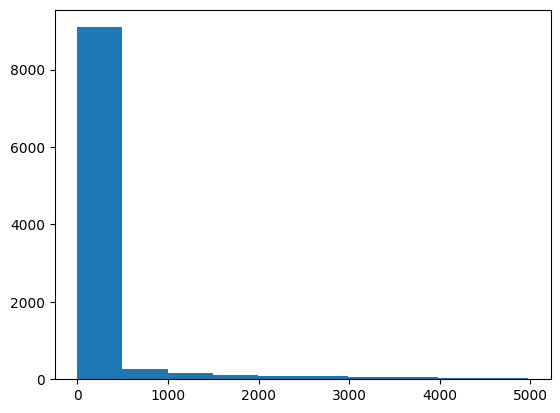

In [126]:
plt.hist(histogram_he4_2.flatten())

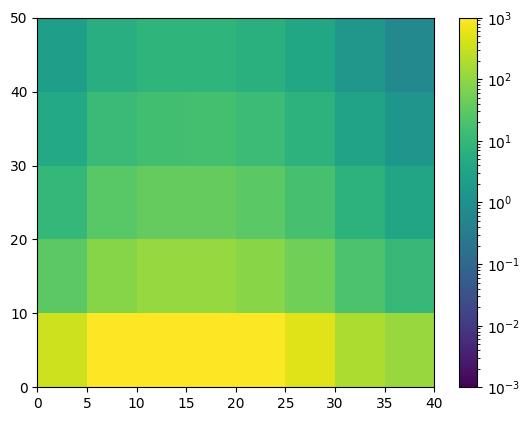

In [127]:
h = plt.hist2d(he4.theta, scattered_e.theta, bins = [np.linspace(0, 40, 9), np.linspace(0, 50, 6)], norm = LogNorm(vmin = 10**(-3), vmax = 10**3), weights = np.ones(len(he4)) * (he4.accepted_xsec.mean()* 10**(-24)*10**(-9) * (6*10**34*20)))
plt.colorbar(h[3])
plt.show()

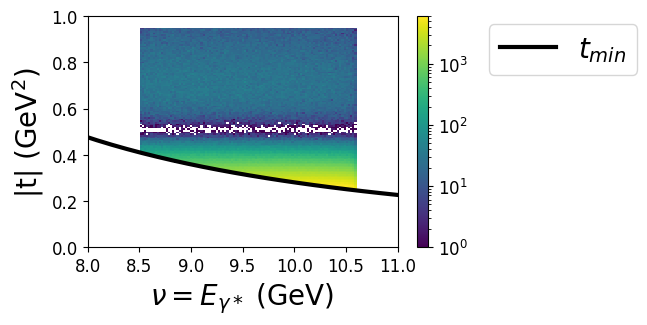

In [128]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

M = mHe4
W = np.linspace(mJpsi + mHe4 + 0.0001, 13, 101)
ax.plot(Egamma_photo(W, M = mHe4), (tmin (W, 0, M = mHe4)), color = 'k', linewidth = 3, label = r"$t_{min}$")
# ax.plot(Egamma_photo(W, M = mHe4), (tmax (W, 0, M = mHe4)))
# ax.plot((W), (tmin (W, 0, M= mHe4)), color = 'tab:blue', label = r"$^4$" + 'He target')
# ax.plot((W), (tmax (W, 0, M= mHe4)), color = 'tab:blue')

# W = np.linspace(mJpsi + mp + 0.0001, 13, 101)
# ax.plot(Egamma_photo(W, M = mp), (tmin (W, 0, M = mp)))
# ax.plot(Egamma_photo(W, M = mp), (tmax (W, 0, M = mp)))
# # ax.plot(W, np.sqrt(tmin (W, 0, M = mp)), 'tab:orange', label = 'Proton target')
# # ax.plot(W, np.sqrt(tmax (W, 0, M = mp)), 'tab:orange')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

# ax.set_xlabel("W (GeV)", fontsize = 20)
ax.set_xlabel(r"$\nu = E_{\gamma*}$"+" (GeV)", fontsize = 20)
ax.set_ylabel("|t|" + " (GeV"+r"$^2$"+")", fontsize = 20)
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.9), fontsize = 20)

# ax.hist2d(scattered_e.W, he4.t, bins = 100, cmin = 1)
h = ax.hist2d(10.604 - scattered_e.e, he4.t, bins = 100, cmin = 1, norm = LogNorm(), rasterized = True)
cbar = plt.colorbar(h[3])
cbar.ax.tick_params(labelsize=12) 
ax.set_ylim([0, 1])
ax.set_xlim([8, 11])

plt.show()

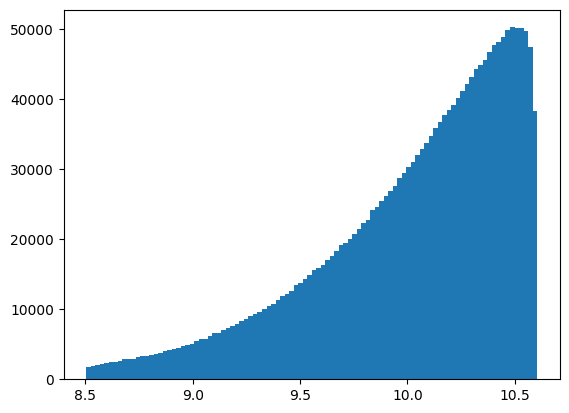

In [129]:
plt.hist(10.604 - scattered_e.e, bins = 100)
plt.show()

In [130]:
nu = (10.6 - scattered_e.e)
Q2 = 2*10.6*scattered_e.e * (1-np.cos(np.radians(scattered_e.theta)))
xB = Q2/2/M/nu
y = nu/10.6

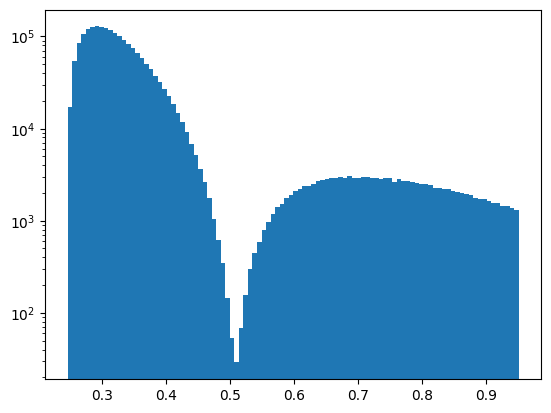

In [139]:
plt.hist(he4.loc[scattered_e.W>5].t, bins = 100)
plt.yscale('log')
plt.show()

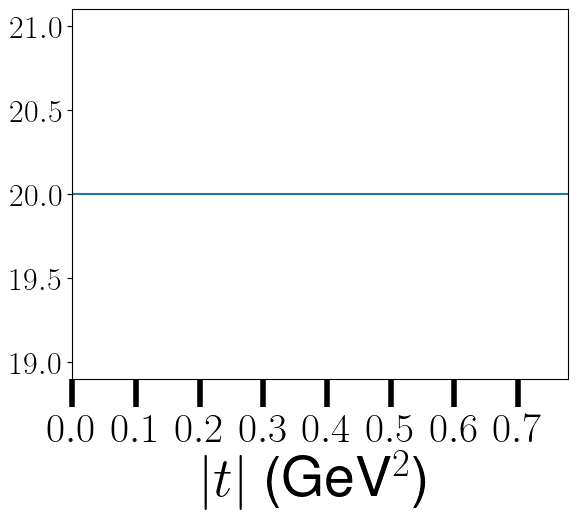

In [286]:
hbar = 197.3 *0.001
plt.plot([0, 20], [20, 20])
# plt.xticks([0,20], [0, 20*hbar**2], fontsize = 20)
# plt.xticks([0, 5, 10, 15, 20], minor = True)
# plt.xlim([0, 20])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize = 30)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,], minor = True)
plt.xlim([0, 20*hbar**2])
plt.xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", size = 40, labelpad = 0)

matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['xtick.major.width'] = 4
matplotlib.rcParams['xtick.minor.size'] = 20
matplotlib.rcParams['xtick.minor.width'] = 3

plt.show()

In [142]:
Q2 = 3
print(tmin(mJpsi+mp+0.000001, Q2, mp, mJpsi), tmax(mJpsi+mp+0.000001, Q2, mp, mJpsi))
print(mp*(mJpsi**2 + Q2)/(mp+mJpsi))

2.9214584830078154 2.9325716467523746
2.9270105161641666


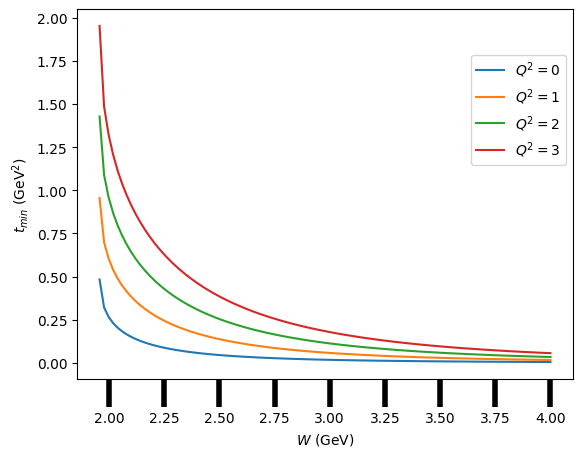

In [144]:
phi_mass = 1.019
W = np.linspace(mp+phi_mass+0.0001, 4, 101)
plt.plot(W, tmin(W,0, mp, phi_mass), label = r'$Q^2=0$')
plt.plot(W, tmin(W,1, mp, phi_mass), label = r'$Q^2=1$')
plt.plot(W, tmin(W,2, mp, phi_mass), label = r'$Q^2=2$')
plt.plot(W, tmin(W,3, mp, phi_mass), label = r'$Q^2=3$')
# plt.yscale('log')
plt.ylabel(r"$t_{min}$" + " (GeV$^2$)")
plt.xlabel(r"$W$" + " (GeV)")
plt.figlegend(bbox_to_anchor = (0.9, 0.8))
plt.show()

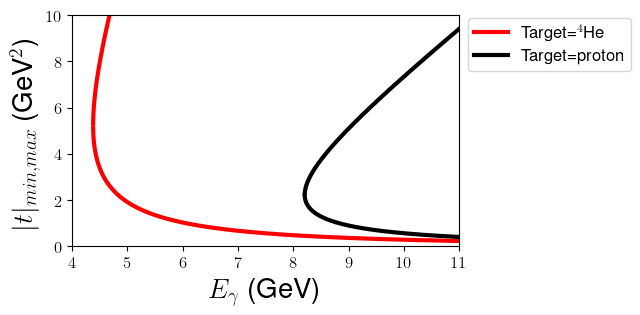

In [192]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

M = mHe4
W = np.linspace(mJpsi + mHe4 + 0.0001, 13, 100001)
ax.plot(Egamma_photo(W, M = mHe4), (tmin (W, 0, M = mHe4)), color = 'r', linewidth = 3, label = r"Target="+r"$^4$"+"He")
ax.plot(Egamma_photo(W, M = mHe4), (tmax (W, 0, M = mHe4)), color = 'r', linewidth = 3, )
# ax.plot((W), (tmin (W, 0, M= mHe4)), color = 'tab:blue', label = r"$^4$" + 'He target')
# ax.plot((W), (tmax (W, 0, M= mHe4)), color = 'tab:blue')

W = np.linspace(mJpsi + mp + 0.0001, 13, 100001)
ax.plot(Egamma_photo(W, M = mp), (tmin (W, 0, M = mp)), color = 'k', linewidth = 3, label = r"Target=proton")
ax.plot(Egamma_photo(W, M = mp), (tmax (W, 0, M = mp)), color = 'k', linewidth = 3, )
# ax.plot(W, np.sqrt(tmin (W, 0, M = mp)), 'tab:orange', label = 'Proton target')
# ax.plot(W, np.sqrt(tmax (W, 0, M = mp)), 'tab:orange')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

# ax.set_xlabel("W (GeV)", fontsize = 20)
ax.set_xlabel(r"$E_{\gamma}$"+" (GeV)", fontsize = 20)
ax.set_ylabel(r"$|t|_{min, max}$" + " (GeV"+r"$^2$"+")", fontsize = 20)
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.9), fontsize = 12)

# # ax.hist2d(scattered_e.W, he4.t, bins = 100, cmin = 1)
# h = ax.hist2d(10.604 - scattered_e.e, he4.t, bins = 100, cmin = 1, norm = LogNorm(), rasterized = True)
# cbar = plt.colorbar(h[3])
# cbar.ax.tick_params(labelsize=12) 
ax.set_ylim([0, 10])
ax.set_xlim([4, 11])

plt.show()

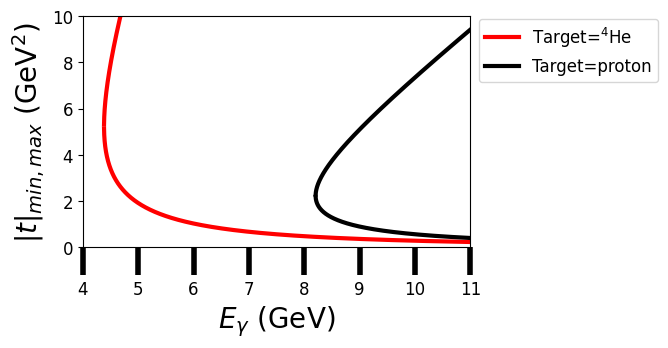

In [146]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

M = mHe4
W = np.linspace(mJpsi + mHe4 + 0.0001, 13, 100001)
ax.plot(Egamma_photo(W, M = mHe4), (tmin (W, 0, M = mHe4)), color = 'r', linewidth = 3, label = r"Target="+r"$^4$"+"He")
ax.plot(Egamma_photo(W, M = mHe4), (tmax (W, 0, M = mHe4)), color = 'r', linewidth = 3, )
# ax.plot((W), (tmin (W, 0, M= mHe4)), color = 'tab:blue', label = r"$^4$" + 'He target')
# ax.plot((W), (tmax (W, 0, M= mHe4)), color = 'tab:blue')

W = np.linspace(mJpsi + mp + 0.0001, 13, 100001)
ax.plot(Egamma_photo(W, M = mp), (tmin (W, 0, M = mp)), color = 'k', linewidth = 3, label = r"Target=proton")
ax.plot(Egamma_photo(W, M = mp), (tmax (W, 0, M = mp)), color = 'k', linewidth = 3, )
# ax.plot(W, np.sqrt(tmin (W, 0, M = mp)), 'tab:orange', label = 'Proton target')
# ax.plot(W, np.sqrt(tmax (W, 0, M = mp)), 'tab:orange')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

# ax.set_xlabel("W (GeV)", fontsize = 20)
ax.set_xlabel(r"$E_{\gamma}$"+" (GeV)", fontsize = 20)
ax.set_ylabel(r"$|t|_{min, max}$" + " (GeV"+r"$^2$"+")", fontsize = 20)
plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.9, 0.9), fontsize = 12)

# # ax.hist2d(scattered_e.W, he4.t, bins = 100, cmin = 1)
# h = ax.hist2d(10.604 - scattered_e.e, he4.t, bins = 100, cmin = 1, norm = LogNorm(), rasterized = True)
# cbar = plt.colorbar(h[3])
# cbar.ax.tick_params(labelsize=12) 
ax.set_ylim([0, 10])
ax.set_xlim([4, 11])

plt.show()

/var/folders/5v/v47_2n_d7f7g_31nzsrvq31c0000gs/T/ipykernel_25266/1074117320.py:9: RuntimeWarning: invalid value encountered in sqrt
  return 1/2/W*np.sqrt(W**4 - 2 *(Mv**2 + M**2)*W**2 + (Mv**2 - M**2)**2)


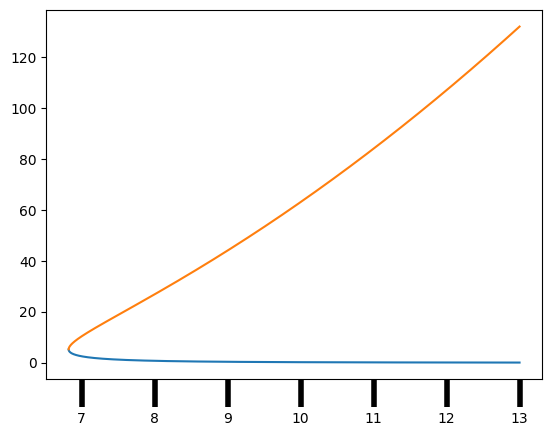

In [149]:
# plt.plot(W, -t_range(W**2, 0, mHe4, mJpsi, mHe4)[1])
plt.plot(W,tmin(W, 0, M = mHe4))
plt.plot(W,tmax(W, 0, M = mHe4))
plt.show()

In [150]:
c = 3*10**8
(he4.pt*10**9/5/c).max()

0.5054869925657552

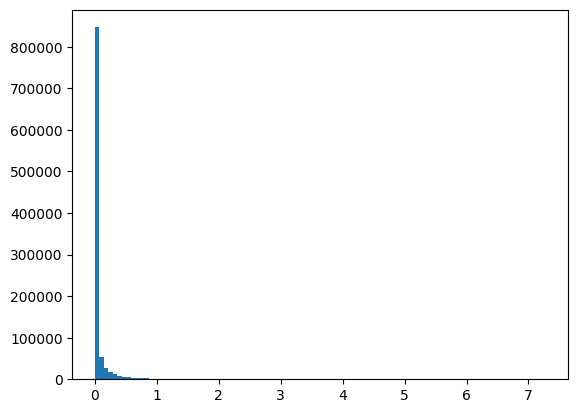

In [45]:
plt.hist(scattered_e.Q2, bins = 100)
plt.show()

In [48]:
# Rh = pt/qBc
# W   = qBc/E
# T    = (35/2. - vz)/ (pz/E c)
# theta = WT
# v_transverse + transverse displacement at leaving = 
c = 3e8
B = 5
he4_pt = np.linspace(0, 0.5,100)
he4_rhelix = he4_pt*10**9/2/B/c*100
he4_rhelix2 = he4_pt*33
# he4_omega  = 2*B*c**2/he4_e/10**9
# he4_time   = (35/2. - he4_vz)*0.01/(he4_pz/he4_e*c)
# he4_theta  = he4_omega * he4_time
# he4_betat  = he4_pt/he4_e
# he4_transverse_displacement = he4_rhelix*2*np.sin(he4_theta/2)

# d_v = np.sqrt(he4_vx**2 + he4_vy**2)*0.01
# costheta_v = 0.01*(he4_vx*he4_px + he4_vy*he4_py)/d_v/he4_pt

# d_helix = np.sqrt(he4_transverse_displacement**2 + d_v**2 + 2*he4_transverse_displacement*d_v*costheta_v)
# he4_transverse_displacement_line = he4_pt/he4_e * c * he4_time
# d_line  = np.sqrt(he4_transverse_displacement_line**2 + d_v**2 + 2*he4_transverse_displacement_line*d_v*costheta_v)

# d_helix.hist(bins = 100, histtype = 'step')
# d_line.hist(bins = 100, histtype = 'step')
# plt.show()

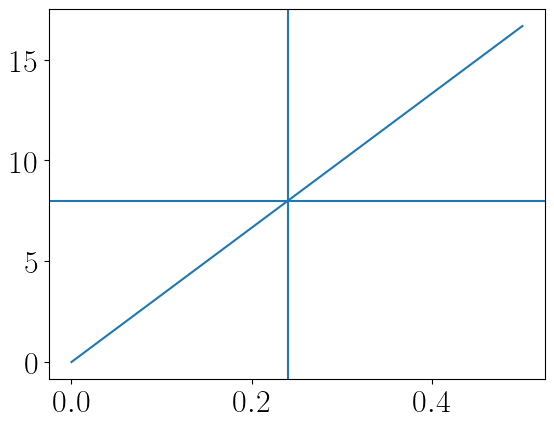

In [60]:
plt.plot(he4_pt, he4_rhelix)
plt.axhline(8)
plt.axvline(0.24)

In [62]:
he4_pt[(he4_rhelix>7.85) & (he4_rhelix<8.15)]

array([0.23737374, 0.24242424])

In [66]:
np.sqrt(0.24**2 + (0.24*20/8)**2)

0.6462197768561405

In [72]:
20*np.tan(np.radians(22))

8.080524516703136

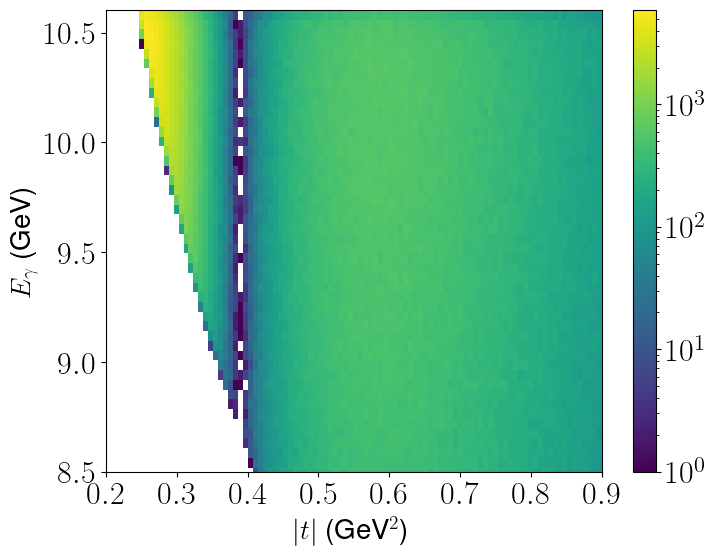

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

M = mHe4
W = np.linspace(mJpsi + mHe4 + 0.0001, 13, 100001)
# ax.fill_between((tmin (W, 0, M = mHe4)), Egamma_photo(W, M = mHe4), 11+0*Egamma_photo(W), color = 'tab:blue', linewidth = 3, label = r"$^4\mathrm{He}(e,e'J/\psi)^4\mathrm{He}$"+"\nAllowed phase space")#r"Target="+r"$^4$"+"He", alpha = 0.3)
h = ax.hist2d(he4.t, 10.604-scattered_e.e, bins =100, norm = LogNorm())#, label = r"$^4\mathrm{He}(e,e'J/\psi)^4\mathrm{He}$"+"\nAllowed phase space")
plt.colorbar(h[3])
# ax.plot((W), (tmin (W, 0, M= mHe4)), color = 'tab:blue', label = r"$^4$" + 'He target')
# ax.plot((W), (tmax (W, 0, M= mHe4)), color = 'tab:blue')

# W = np.linspace(mJpsi + mp + 0.0001, 13, 100001)
# ax.fill_between(Egamma_photo(W, M = mp), (tmin (W, 0, M = mp)), tmax(W, 0, M=mp), color = 'k', linewidth = 3, label = r"Target=proton", alpha = 0.3)
# ax.plot(W, np.sqrt(tmin (W, 0, M = mp)), 'tab:orange', label = 'Proton target')
# ax.plot(W, np.sqrt(tmax (W, 0, M = mp)), 'tab:orange')
# ax.set_xlabel("W (GeV)", fontsize = 20)
ax.set_ylabel(r"$E_{\gamma}$"+" (GeV)", fontsize = 20)
ax.set_xlabel(r"$|t|$" + " (GeV"+r"$^2$"+")", fontsize = 20)
# x  = np.linspace(0.4, 0.5, 101)
# ax.fill_between(x, 5 + 0*x, 11 + 0*x, linestyle= '--', color = 'orange', linewidth = 2, label = "Charge forn factor \n 1st diffraction mininum", alpha = 0.3)

# plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.53, 0.4))#, title = )

# # ax.hist2d(scattered_e.W, he4.t, bins = 100, cmin = 1)
# h = ax.hist2d(10.604 - scattered_e.e, he4.t, bins = 100, cmin = 1, norm = LogNorm(), rasterized = True)
# cbar = plt.colorbar(h[3])
# cbar.ax.tick_params(labelsize=12) 
ax.set_xlim([0.2, 0.9])
ax.set_ylim([8.5, 10.604])
# ax.set_yticks([5, 6, 7, 8, 9, 10, 11], [5, 6, 7, 8, 9, 10, 11])
ax.set_xticks(np.linspace(0.2, 0.9, 7+1))

plt.show()

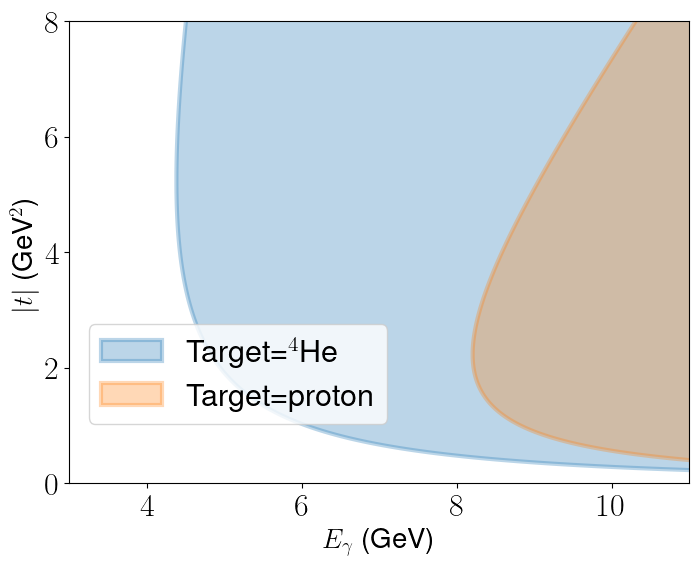

In [226]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

M = mHe4
W = np.linspace(mJpsi + mHe4 + 0.0001, 13, 100001)
ax.fill_between(Egamma_photo(W, M = mHe4), (tmin (W, 0, M = mHe4)), tmax(W, 0, M=mHe4), color = 'tab:blue', linewidth = 3, label = r"Target=$^4$He", alpha = 0.3)

# ax.fill_between((tmin (W, 0, M = mHe4)), Egamma_photo(W, M = mHe4), 30+0*Egamma_photo(W), color = 'tab:blue', linewidth = 3, label = r"$^4\mathrm{He}(e,e'J/\psi)^4\mathrm{He}$"+"\nAllowed phase space")#r"Target="+r"$^4$"+"He", alpha = 0.3)
# h = ax.hist2d(he4.t, 10.604-scattered_e.e, bins =100, norm = LogNorm())#, label = r"$^4\mathrm{He}(e,e'J/\psi)^4\mathrm{He}$"+"\nAllowed phase space")
plt.colorbar(h[3])
# ax.plot((W), (tmin (W, 0, M= mHe4)), color = 'tab:blue', label = r"$^4$" + 'He target')
# ax.plot((W), (tmax (W, 0, M= mHe4)), color = 'tab:blue')

W = np.linspace(mJpsi + mp + 0.0001, 13, 100001)
ax.fill_between(Egamma_photo(W, M = mp), (tmin (W, 0, M = mp)), tmax(W, 0, M=mp), color = 'tab:orange', linewidth = 3, label = r"Target=proton", alpha = 0.3)
# ax.fill_between((tmin (W, 0, M = mp)), Egamma_photo(W, M = mp), 30+0*Egamma_photo(W), color = 'tab:red', linewidth = 3, label = r"$^4\mathrm{p}(e,e'J/\psi)^4\mathrm{p}$"+"\nAllowed phase space")#r"Target="+r"$^4$"+"He", alpha = 0.3)
# ax.plot(W, np.sqrt(tmin (W, 0, M = mp)), 'tab:orange', label = 'Proton target')
# ax.plot(W, np.sqrt(tmax (W, 0, M = mp)), 'tab:orange')
# ax.set_xlabel("W (GeV)", fontsize = 20)
ax.set_xlabel(r"$E_{\gamma}$"+" (GeV)", fontsize = 20)
ax.set_ylabel(r"$|t|$" + " (GeV"+r"$^2$"+")", fontsize = 20)
# x  = np.linspace(0.4, 0.5, 101)
# ax.fill_between(x, 5 + 0*x, 11 + 0*x, linestyle= '--', color = 'orange', linewidth = 2, label = "Charge forn factor \n 1st diffraction mininum", alpha = 0.3)

plt.figlegend(loc = 'upper left', bbox_to_anchor = (0.13, 0.4))#, title = )

# # ax.hist2d(scattered_e.W, he4.t, bins = 100, cmin = 1)
# h = ax.hist2d(10.604 - scattered_e.e, he4.t, bins = 100, cmin = 1, norm = LogNorm(), rasterized = True)
# cbar = plt.colorbar(h[3])
# cbar.ax.tick_params(labelsize=12) 
ax.set_ylim([0, 8])
ax.set_xlim([3, 11])
# # ax.set_yticks([5, 6, 7, 8, 9, 10, 11], [5, 6, 7, 8, 9, 10, 11])
# ax.set_xticks(np.linspace(0.2, 0.9, 7+1))

plt.show()